2017-06-09 13:35:41 
Mel Rose
meljulerose@gmail.com

# Set up/Load

## imports and functions

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
import numpy as np
import os
import glob
from mirpy import miriad 
import subprocess
# note: mirpy is a python2 module that I futurized
# so I could use it in python3

# takes mir_output from uvsplit and return the names of the new files
def names_uvsplit(mir_output):
    tmp = mir_output.decode("utf-8").split("\n")[2:]
    temp = [t.split(' ')[-1] for t in tmp]
    return(temp)
    

# takes mir_output from uvsplit and return the names of the new files
def grabrms_invert(mir_output):
    tmp = mir_output.decode("utf-8").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'rms' in j:
            return(j.split(': ')[-1])
        
# issue a warning if pgflags more than 50% of the data
def flaggingcheck_pgflag(mir_output):
    tmp = mir_output.decode("utf-8").split("\n")[-1].split('%')[0]
    tmp = float(tmp)
    if tmp >= 50:
        print('!'*500 + 'Warning! You are flagging {0}% of the data, which is a lot'.format(tmp)+'!'*500)


# check if the rms decreases with each iteration
def rmscheck_clean(mir_output):
    tmp = mir_output.decode("utf-8").split("\n")[2:]
    
    min_arr = []
    max_arr = []
    rms_arr = []
    iter_arr = []
    flux_arr = []
    for k, j in enumerate(tmp):
        if 'rms' in j:
            temp = j.split(': ')[-1].split('  ')
            min_arr.append(temp[1])
            max_arr.append(temp[2])
            rms_arr.append(temp[3])
        elif 'Iterations' in j:
            iter_arr.append(j.split(': ')[-1])
        elif 'flux' in j:
            flux_arr.append(j.split(': ')[-1])
    
    # check that the rms is monotonically decreasing
    dx= np.diff(np.asarray(rms_arr,dtype=float))
    all_decreasing = np.all(dx <= 0)
    
    if not all_decreasing:
        culprit = iter_arr[np.argmax(dx>0)]
        print("Warning: RMS values are not monotonically decreasing after {0} iterations".format(culprit))
        
    
    # get a visual 
    '''
    plt.title("Total Cleaned Flux")
    plt.plot(iter_arr, flux_arr)
    plt.xlabel('Iterations')
    plt.ylabel('Flux')
    plt.show()
    '''
    
    plt.title("Residual RMS")
    #plt.plot(iter_arr, min_arr, label="min")
    #plt.plot(iter_arr, max_arr, label="max")
    plt.plot(iter_arr, rms_arr, label="rms")
    
    if not all_decreasing:
        plt.axvline(x=float(culprit), linestyle="--")
        
        
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Iterations')
    plt.ylabel('Flux')
    plt.show()
    
# grab the peak flux value
# returns [peak value, error]
def grabrms_imhist(mir_output):
    tmp = mir_output.decode("utf-8").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'rms' in j:
            temp = tmp[k+1].split(' ')
            ret = [t for t in temp if t !='']
            return(ret[2])

    


# grab the peak flux value
# returns [peak value, error]
def grabpeak_imfit(mir_output):
    tmp = mir_output.decode("utf-8").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'Peak' in j:
            temp = j.split(': ')[-1].split(' ')
            ret = [t for t in temp if t !='']
            return(ret[::2])


# save as HTML
# I also had to install nbconvert
# conda install nbconvert
# conda install -c conda-forge jupyter_contrib_nbextensions
def export_to_html(filename,source):
    save_as = notebook_dir+'/'+source+'_reduction.html'
    print(save_as)
    !rm $save_as
    rename_cmd = filename.replace(".ipynb", ".html") + ' ' + save_as
    print(rename_cmd)
    cmd = 'jupyter nbconvert --to html_embed --template toc2 {0}'.format(filename)
    print(cmd)
    subprocess.call(cmd, shell=True)
    !mv $rename_cmd
    return(source+'_reduction.html')


## loading the data

In [2]:
# checking the contents of the directory we're in 
notebook_dir = os.getcwd()
os.chdir("/Volumes/mjrose media/ASTRON data/L")
cwd = os.getcwd()
infiles = glob.glob('*')
print(infiles)

['2015-04-11_0149.C3030', '2015-04-11_0513.C3030', '2015-04-11_0836.C3030']


In [15]:
# load in the data 

loadeduv = "loaded.uv"

# atlod parameters
in_ = "2015-04-11_0149.C3030"#infiles
out= loadeduv
ifsel=1
options = 'birdie,rfiflag,noauto,xycorr'

# remove uvdata if it already exists
!rm -r $out

# store miriad output in variable in case you want to parse it
mir_output = miriad.atlod(in_=in_, out=out, ifsel=ifsel, options=options)

# but let's take a look at it
print(mir_output.decode("utf-8"))


# flag the edge channels that are within the bandpass rollof

# uvflag parameters
vis = loadeduv
edge = 40
flagval = "flag"

mir_output = miriad.uvflag(vis=vis, edge=edge, flagval=flagval)
print(mir_output.decode("utf-8"))

# split the dataset into its component sources:

if cwd.split('/')[-1] == 'L':    # 
    suffix = '.2100'             #
elif cwd.split('/')[-1] == 'CX': #
    suffix = '.5500'             #
     

# uvsplit parameters
vis = loadeduv

# remove vis if it already exists
!rm -r *$suffix

mir_output = miriad.uvsplit(vis=vis)
print(mir_output.decode("utf-8"))

rm: loaded.uv: No such file or directory
atlod: Revision 1.53, 2016/08/25 23:02:21 UTC

Processing file 2015-04-11_0149.C3030
 01:43:36 CAOBS> set file c3030_targets_mos
 01:49:05 CAOBS> set file c3030_cal
 01:49:14 CAOBS> track 1
CABB data detected
Scan 1 started at 15APR11:01:49:34.9
Source: 1934-638
Flagging channels in  28 frequency ranges
 01:55:26 CAOBS> stop
 01:55:43 CAOBS> set file c3030_targets_mos
 01:55:50 CAOBS> start 1/99
Scan 2 started at 15APR11:01:56:35.7
Source: pks1934-638
Source: pks1740-649
Source: pmnj1726-6427
Source: pks1814-637
Source: mwacsj2153.5
Source: pks2149-28
Source: pks2135-209
Source: mwacsj2157.5
Source: pks2254-367
Source: 2311-452
Source: pks2333-528
Source: 0022-423
Source: mwacsj2352.4
Source: 0023-263
Scan 3 started at 15APR11:02:32:45.7
Source: pks1934-638
Source: pks1740-649
Source: pmnj1726-6427
Source: pks1814-637
Source: mwacsj2153.5
Source: pks2149-28
Source: pks2135-209
Source: mwacsj2157.5
Source: pks2254-367
Source: 2311-452
Source: pks

In [4]:
##################################
bandflux_cal = '1934-638'+suffix #
sources = glob.glob('*'+suffix)  #
sources.remove(bandflux_cal)     #    
##################################


# actually, for this data set I need to order the sources so each can be the phase calibrator for the next
block = 1

temp_txt = np.loadtxt(notebook_dir+"/c3030_block{0}.mos".format(block), dtype=bytes)
sources = [t[-1].decode('UTF-8')[1:].lower() for t in temp_txt]
sources = sources[1:] # the first one is the bandpass calibrator, not a source
print(sources)

['pks1740-649', 'pmnj1726-6427', 'pks1814-637', 'mwacsj2153.5', 'pks2149-28', 'pks2135-209', 'mwacsj2157.5', 'pks2254-367', '2311-452', 'pks2333-528', '0022-423', 'mwacsj2352.4', '0023-263', 'pks0105-122']


# Bandpass Calibration

## Precalibration Images

##########Pre mfcal bandpass, flux calibration##########
rm: *png*: No such file or directory


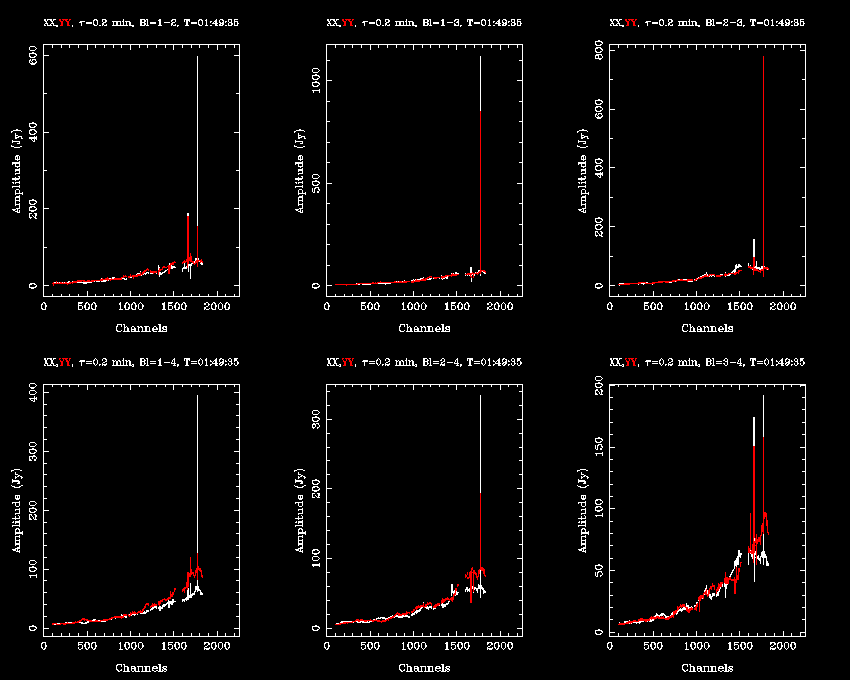

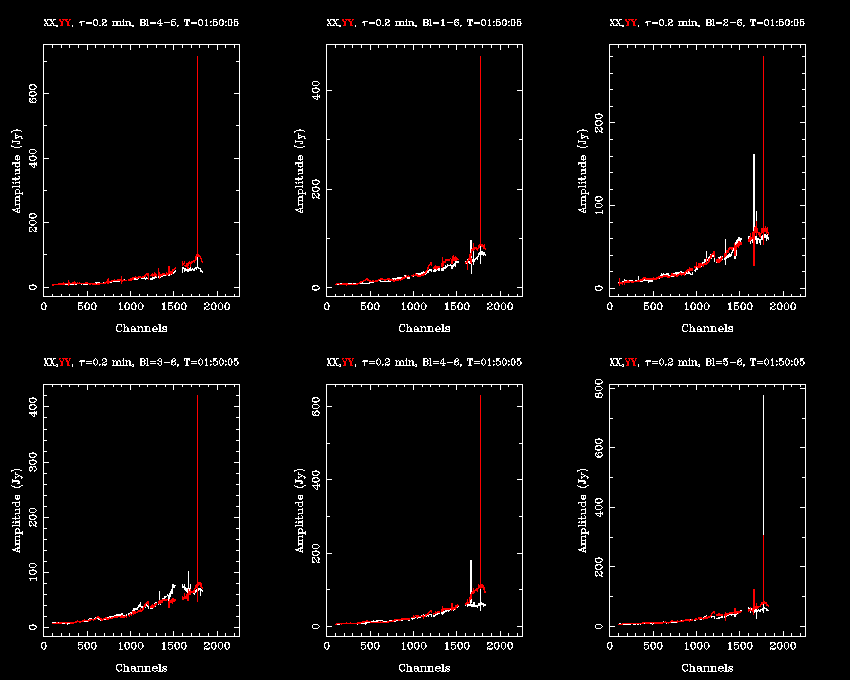

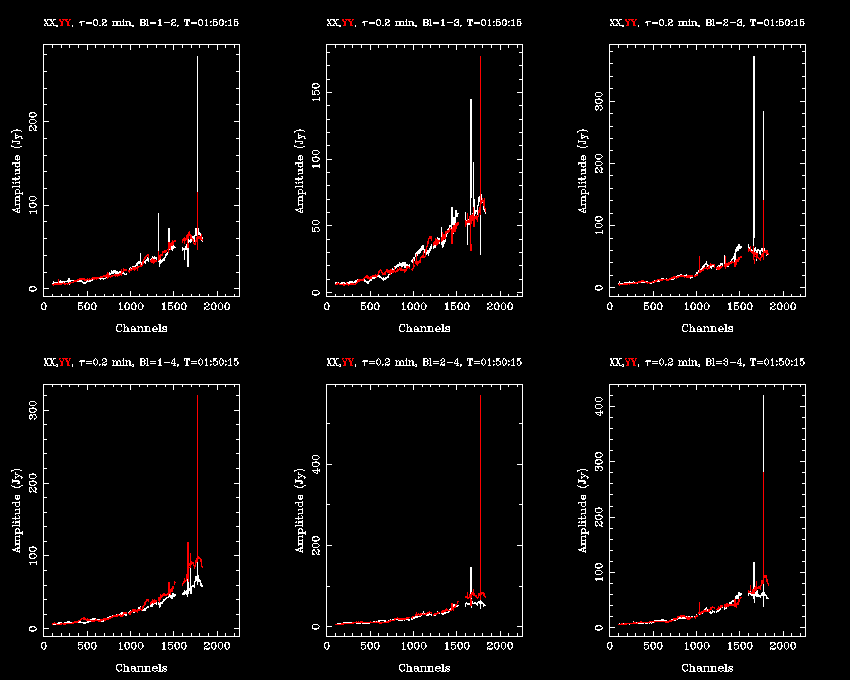

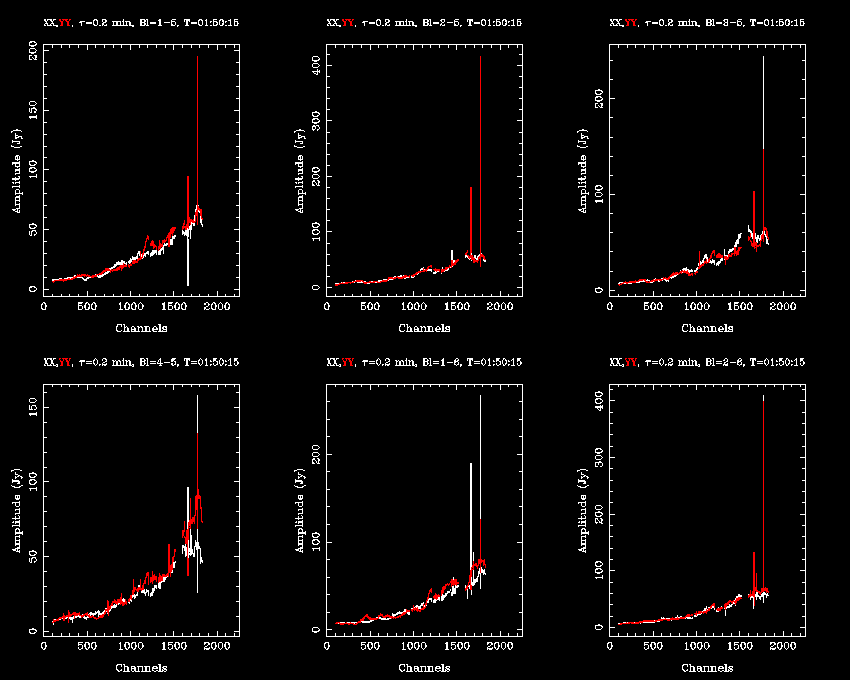

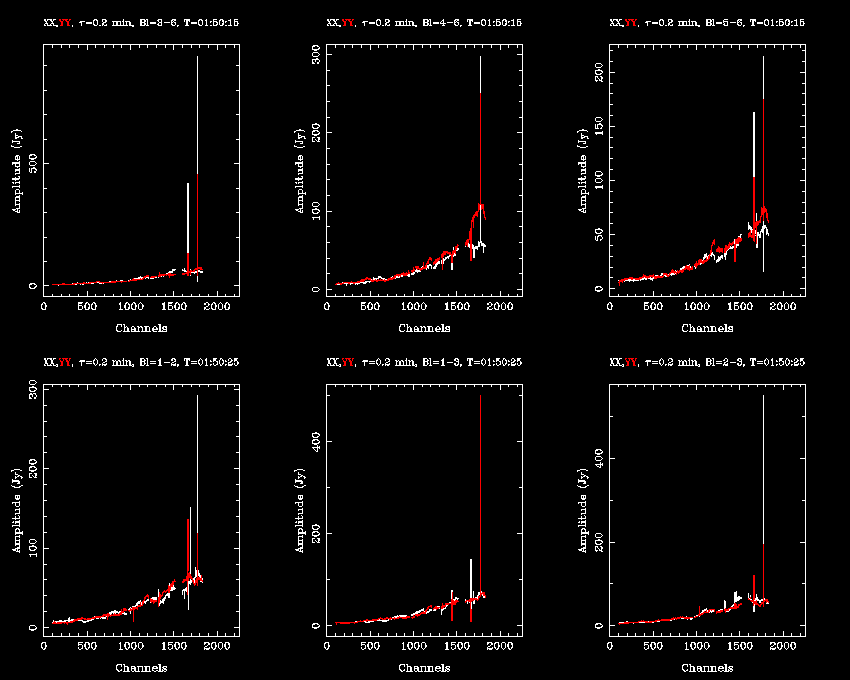

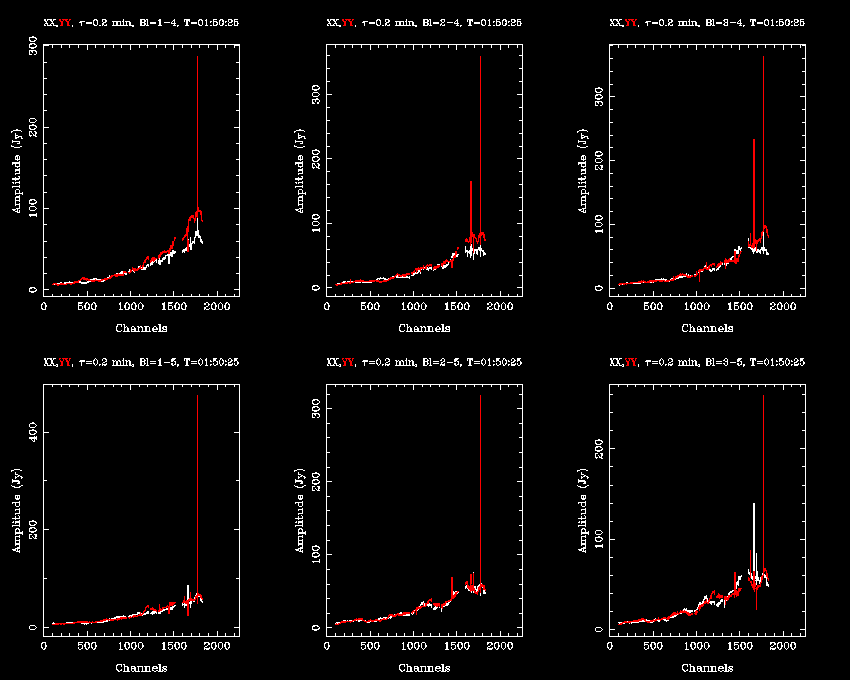

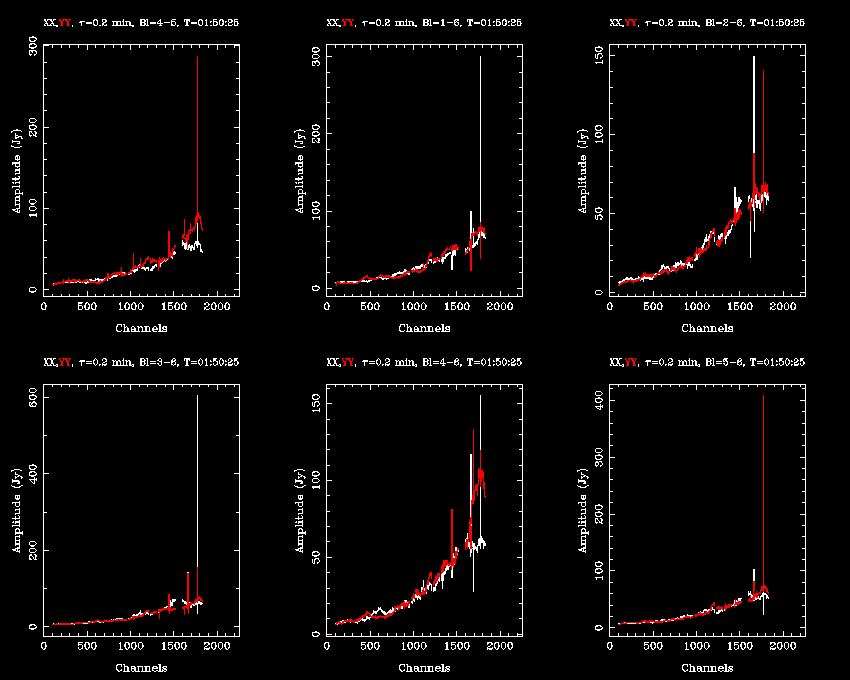

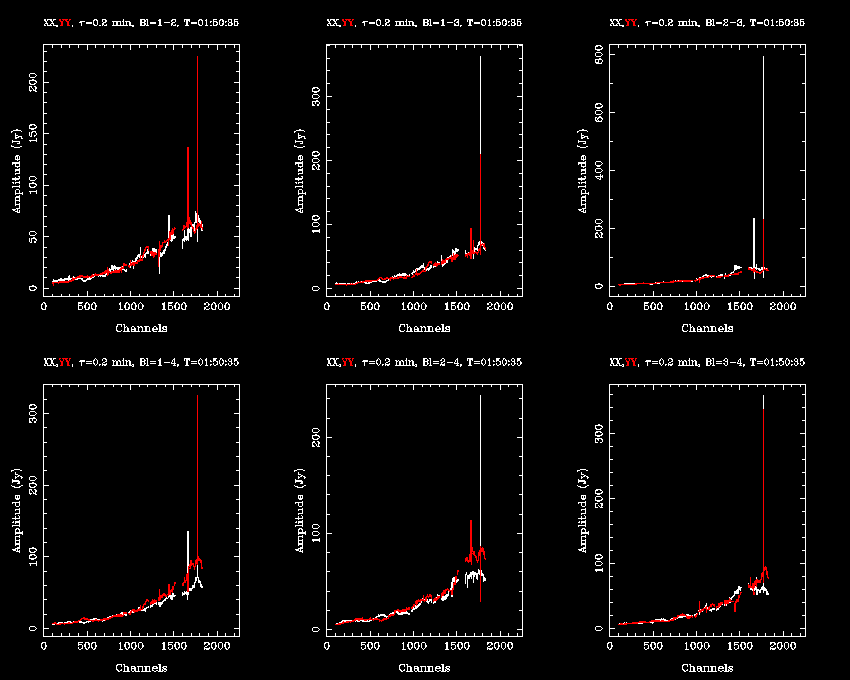

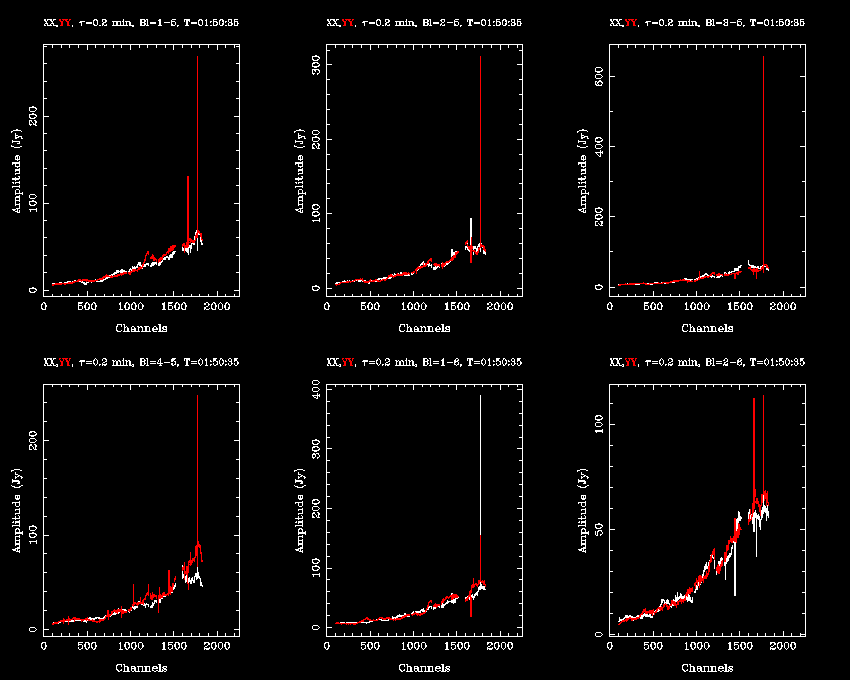

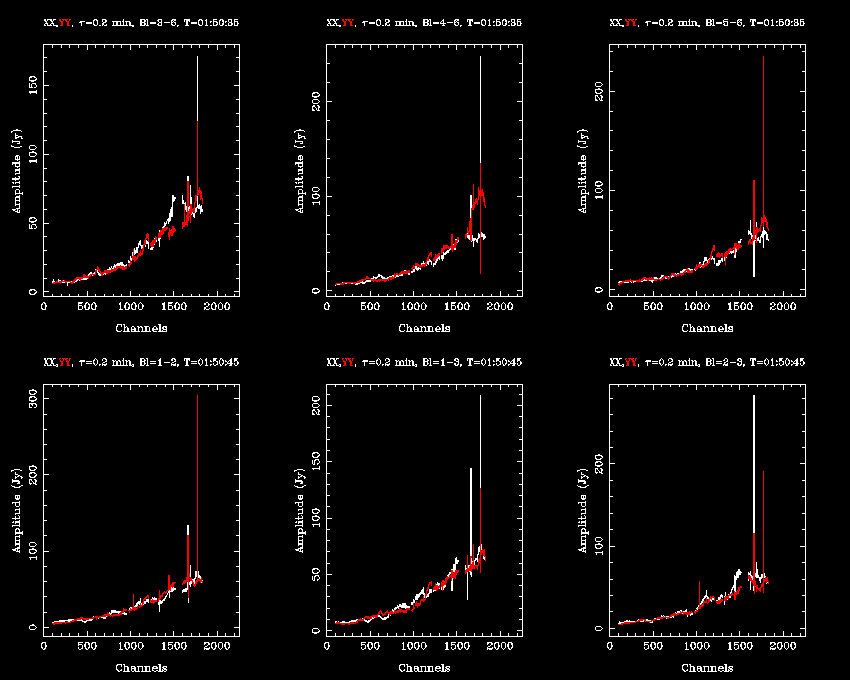

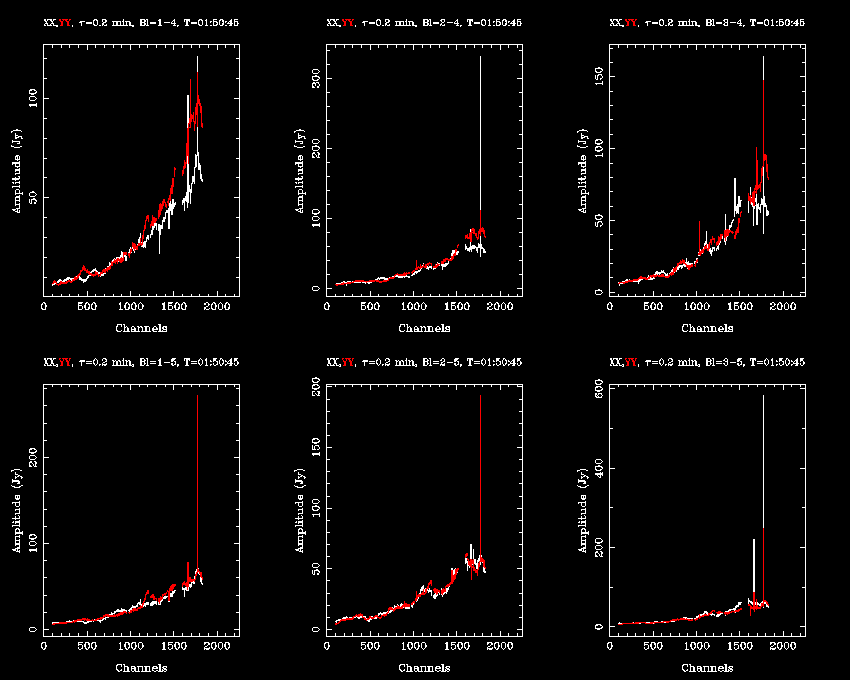

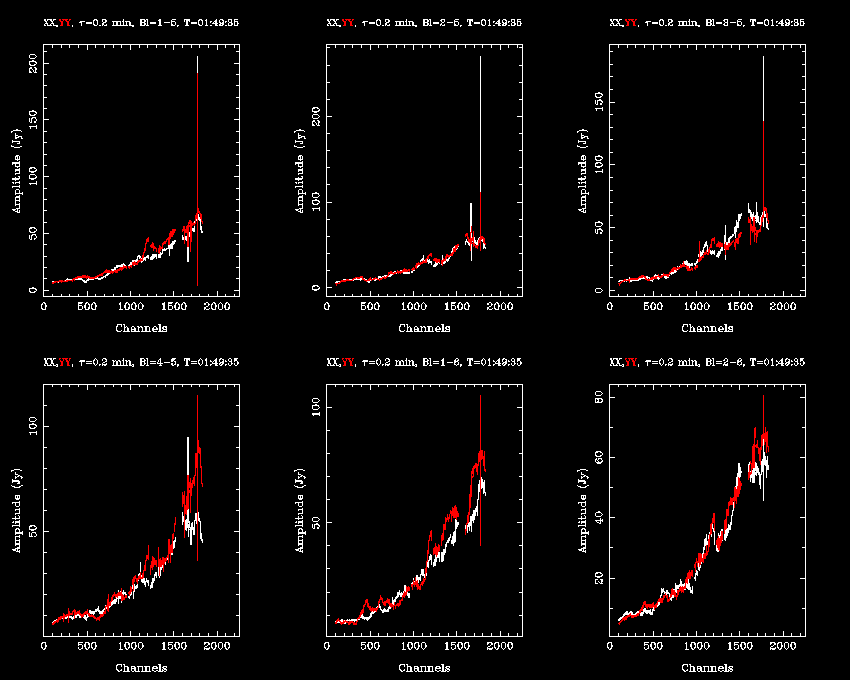

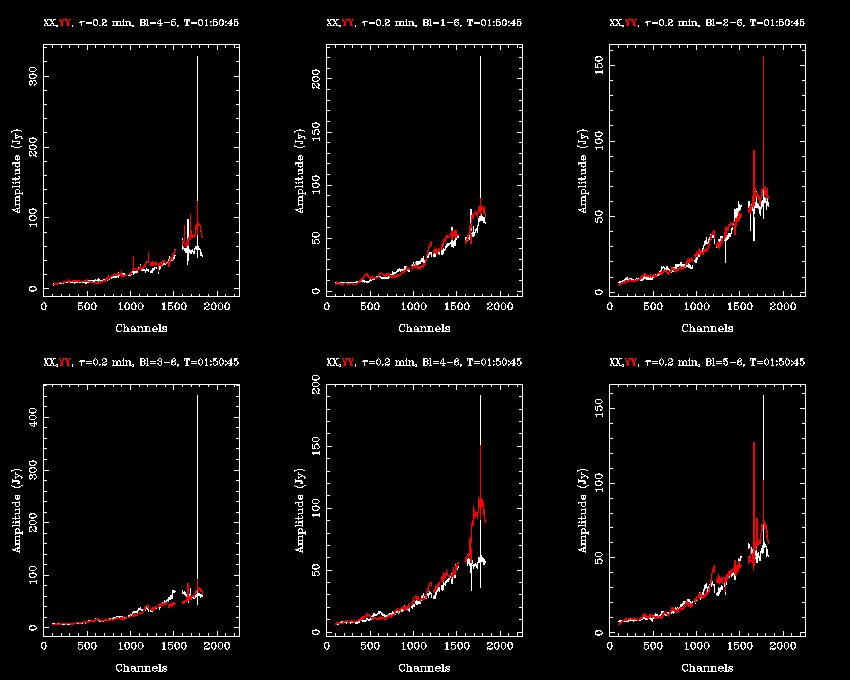

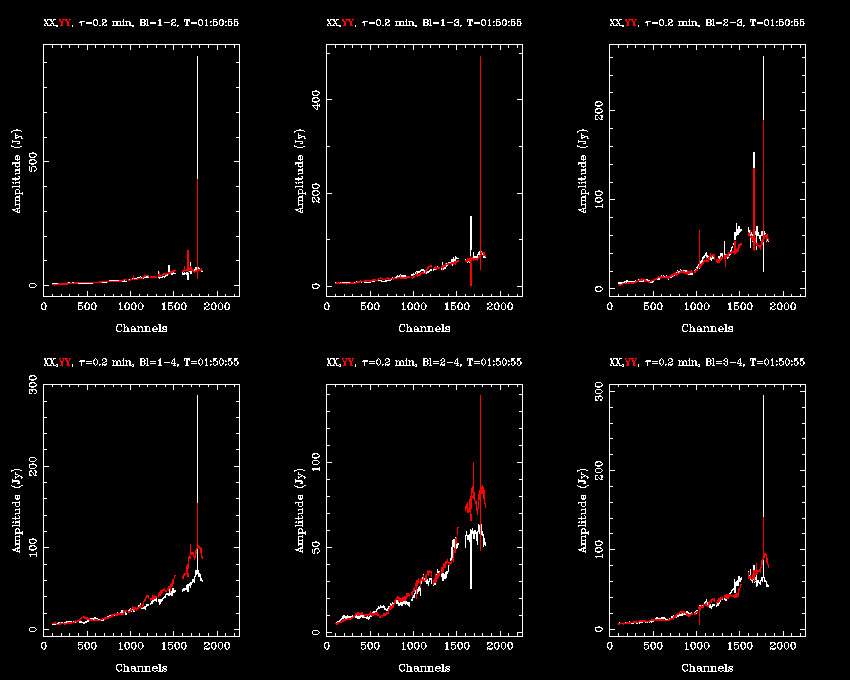

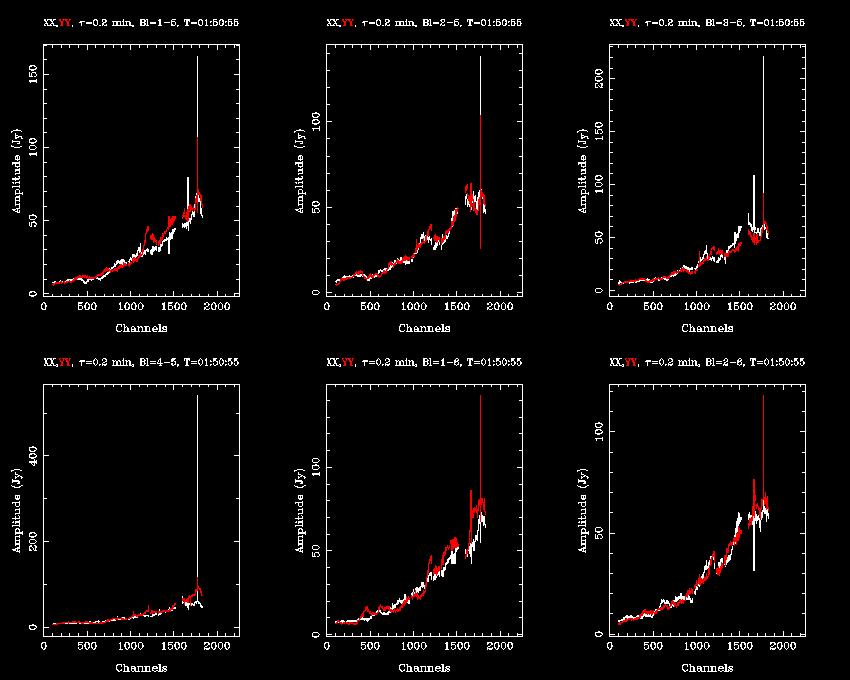

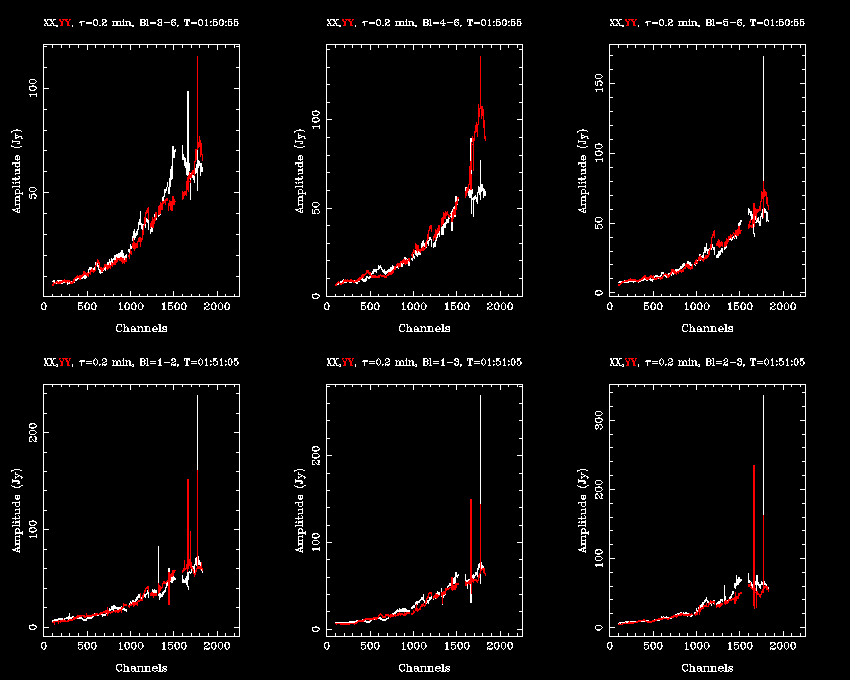

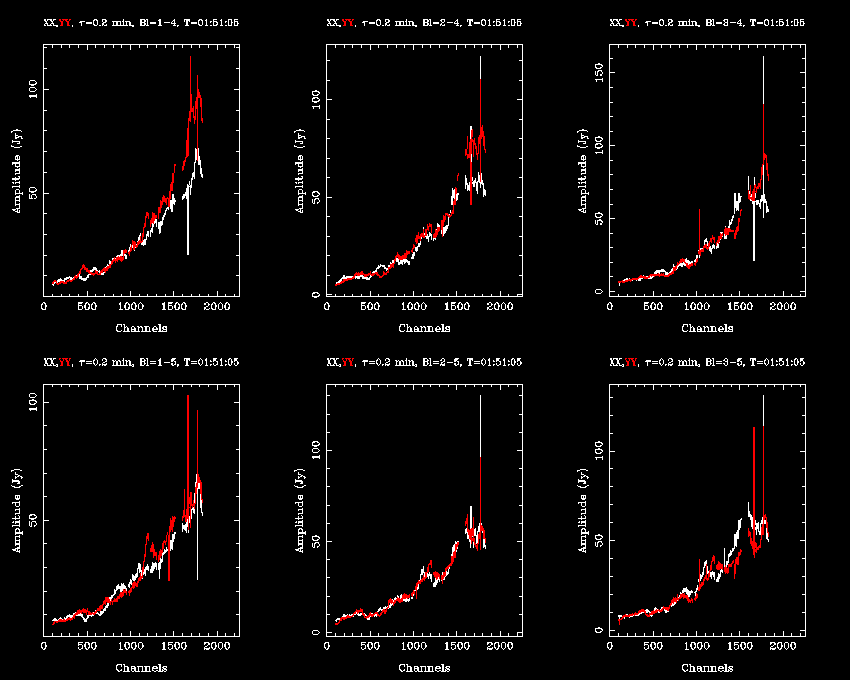

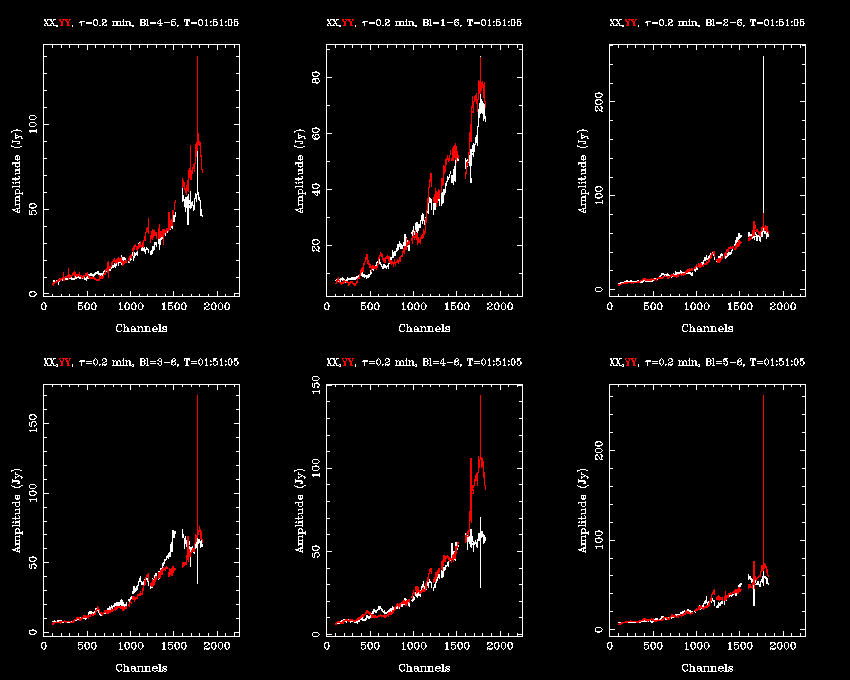

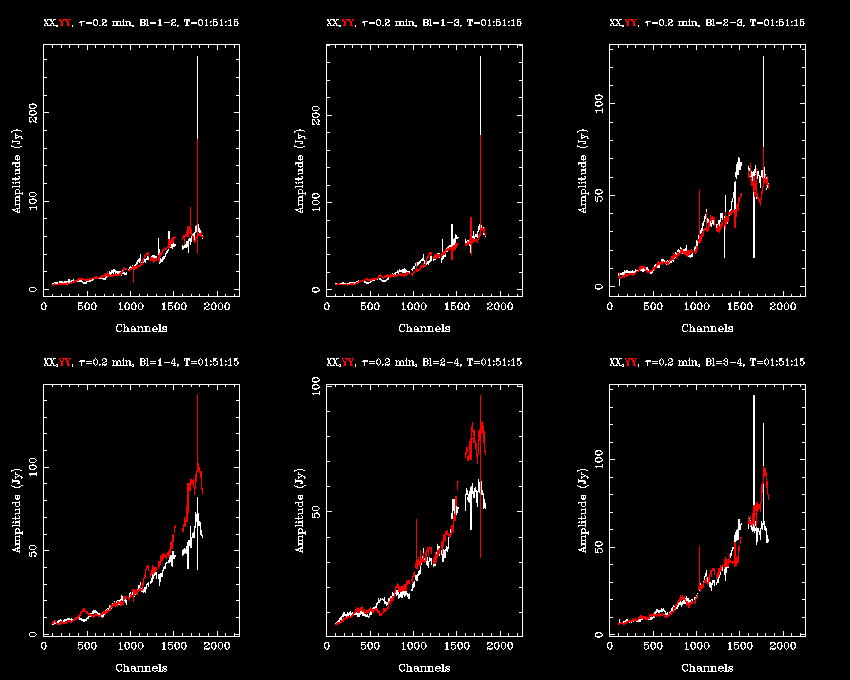

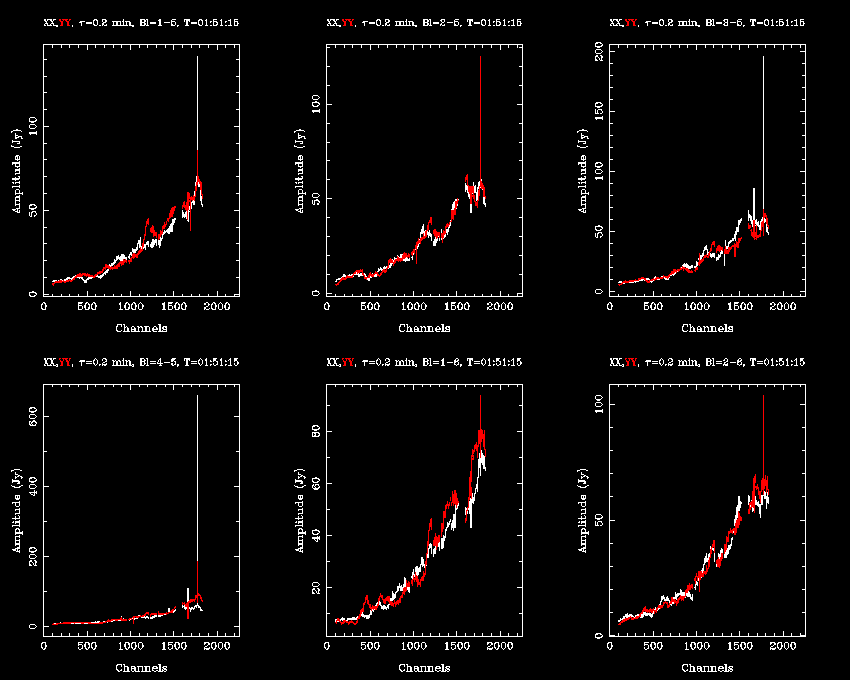

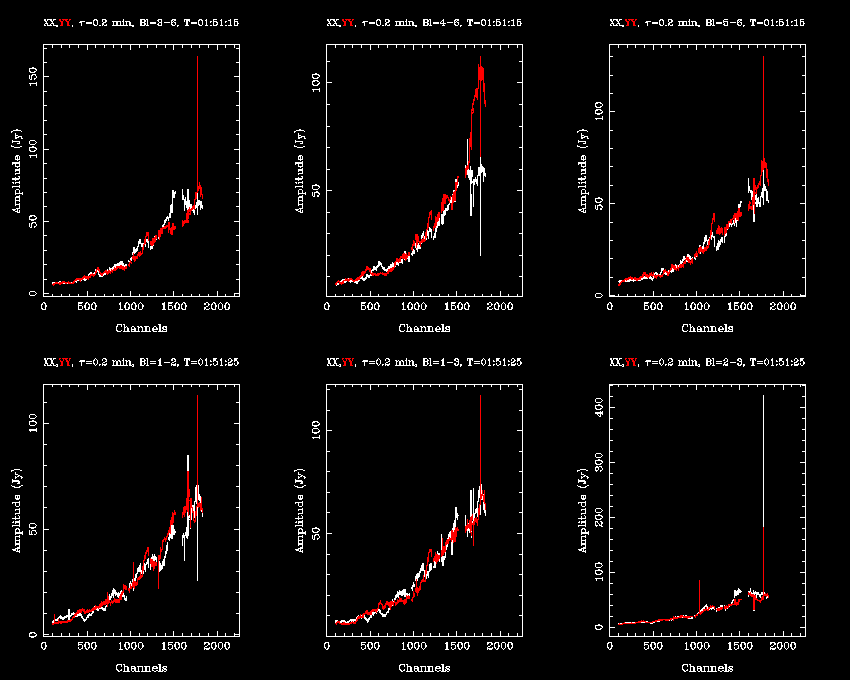

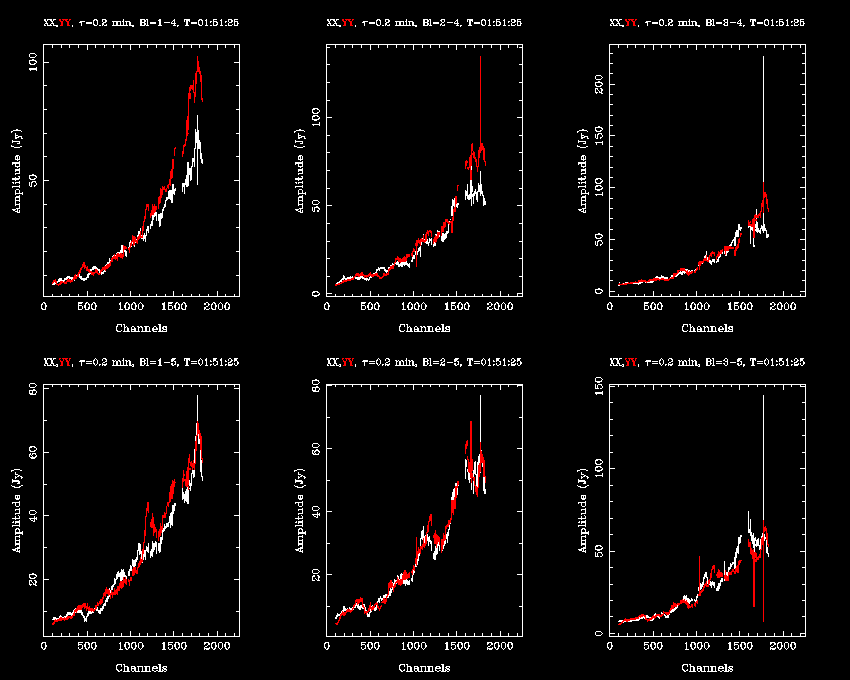

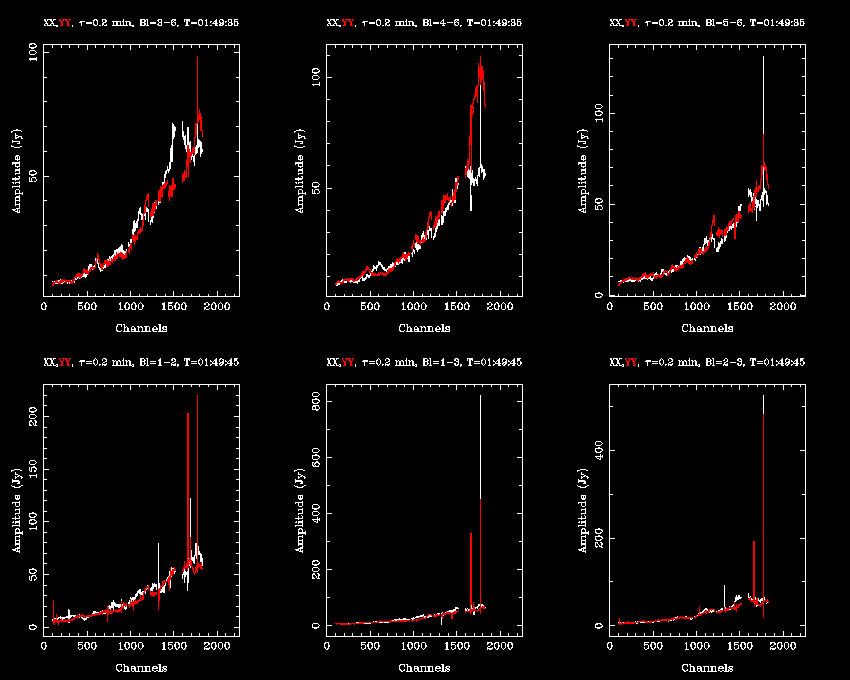

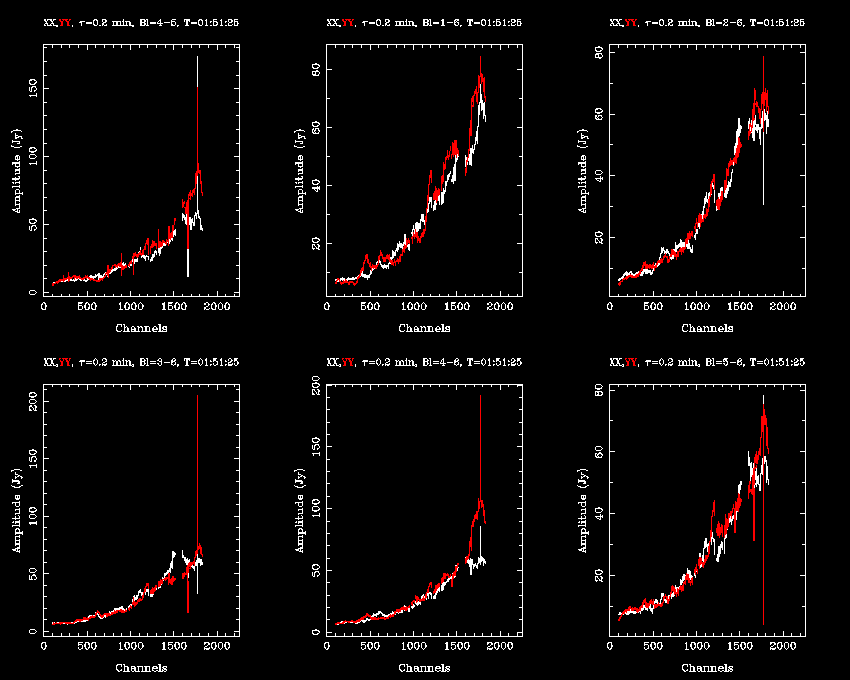

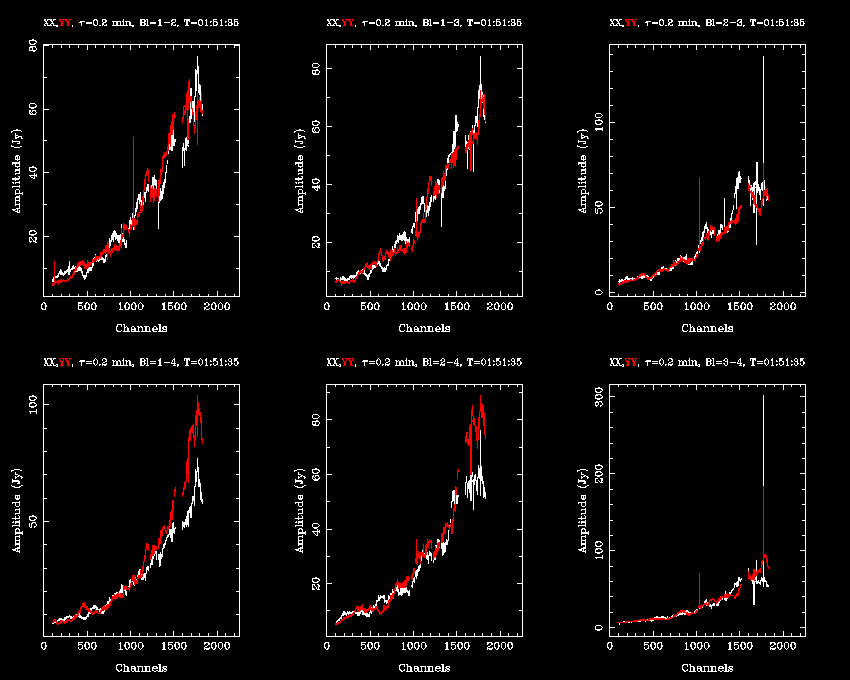

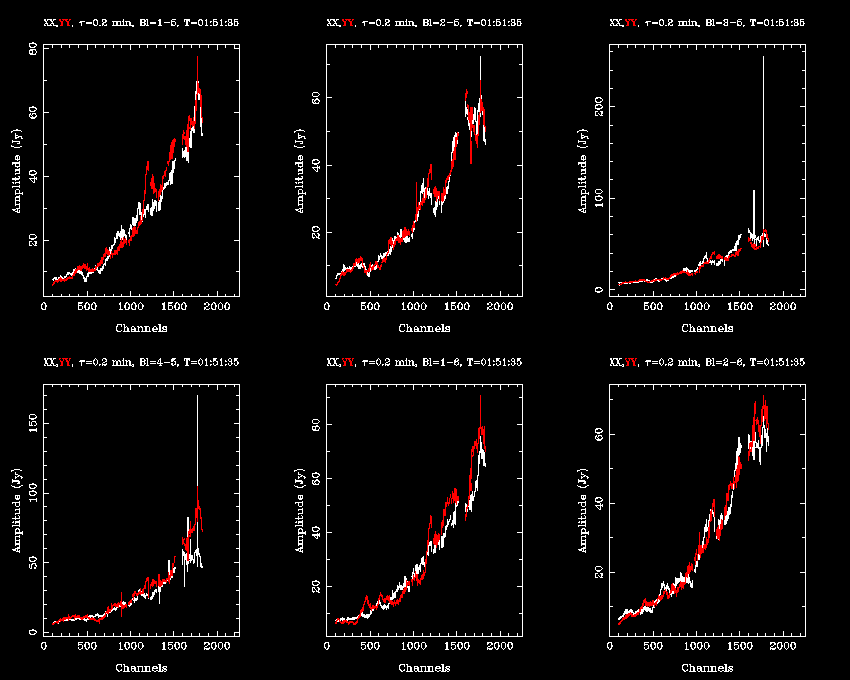

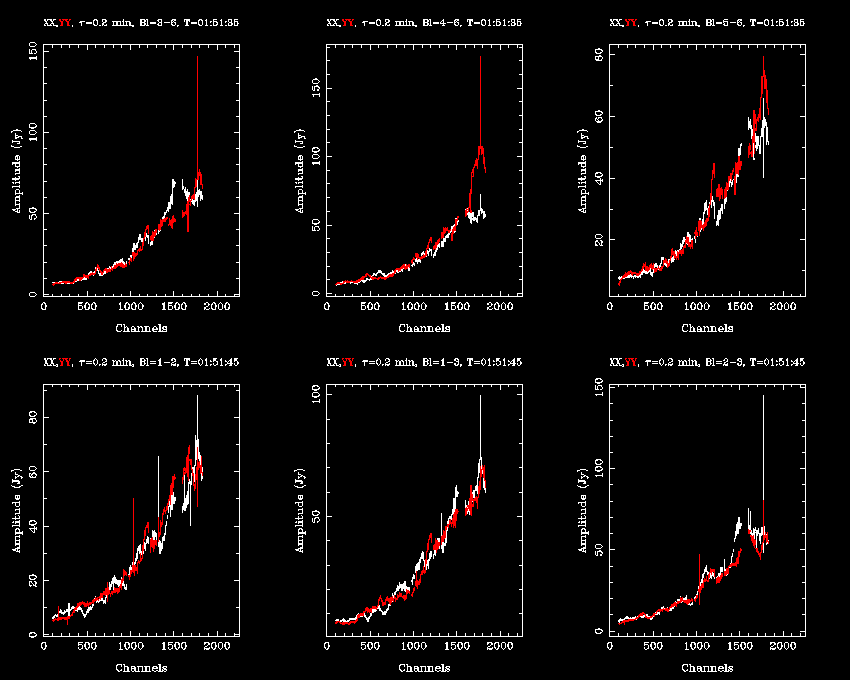

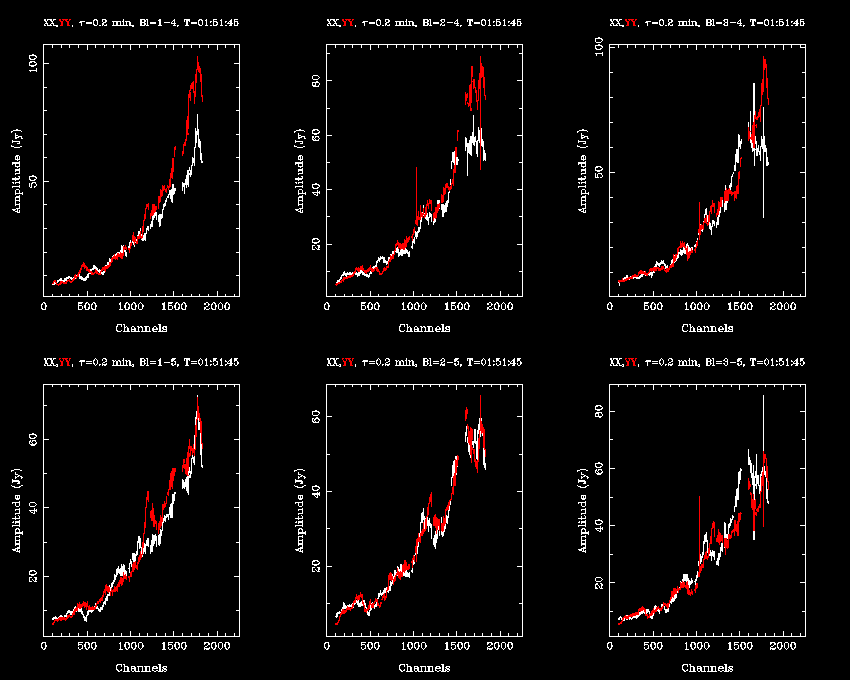

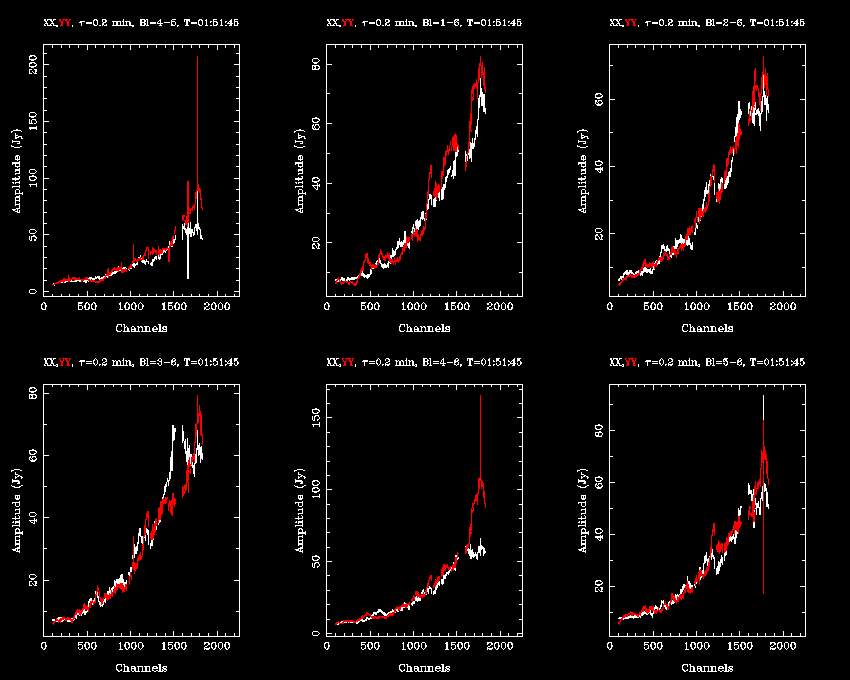

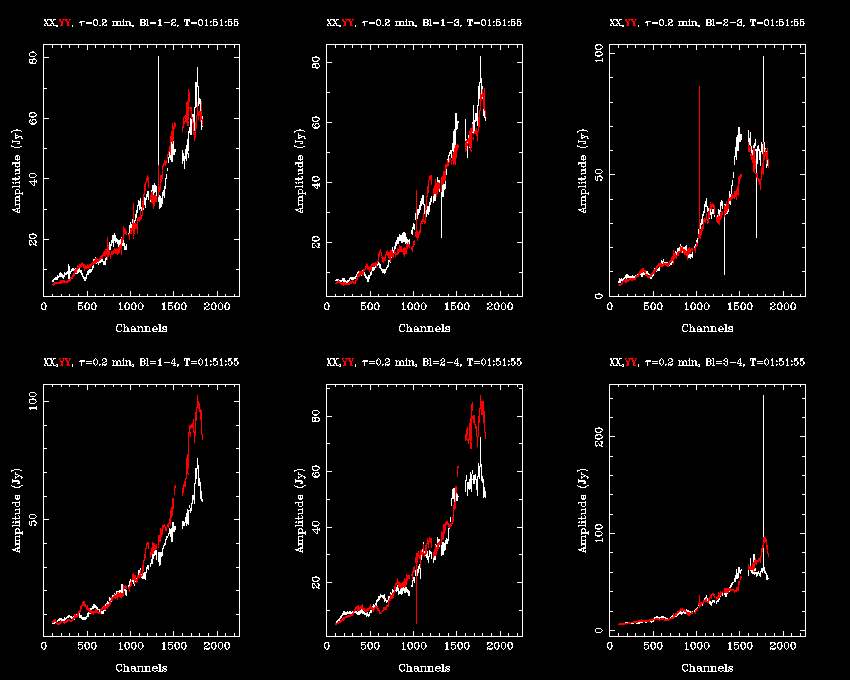

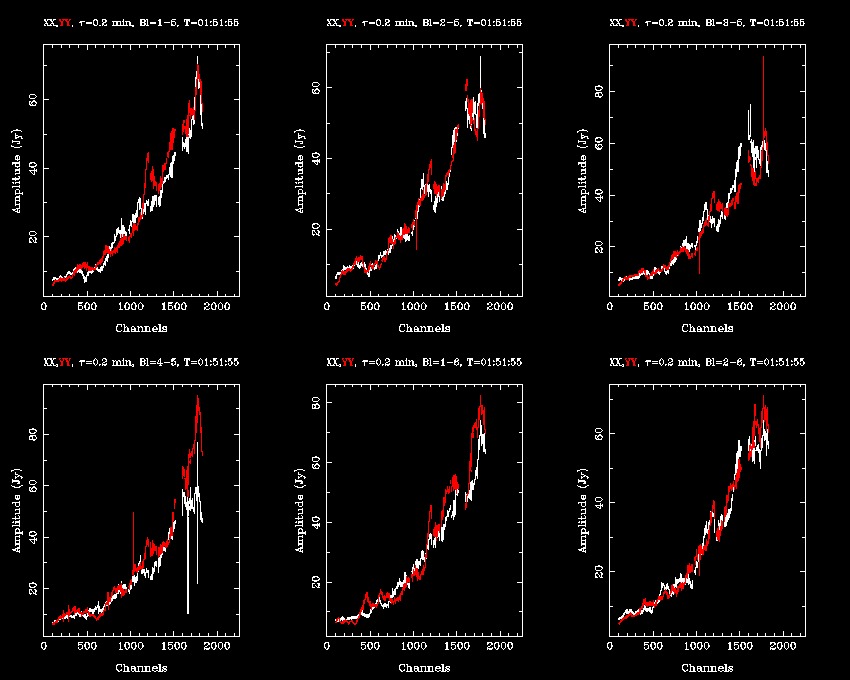

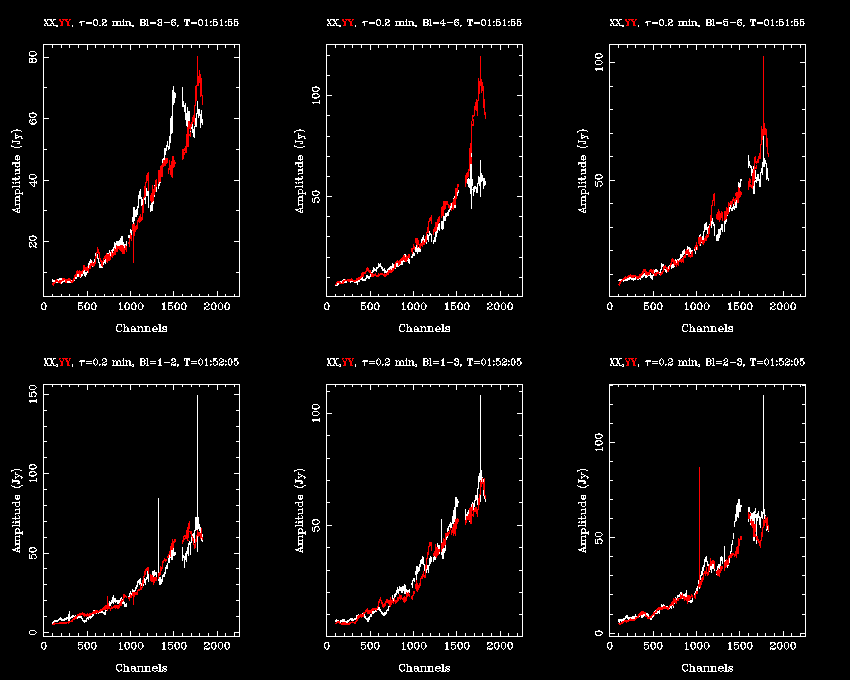

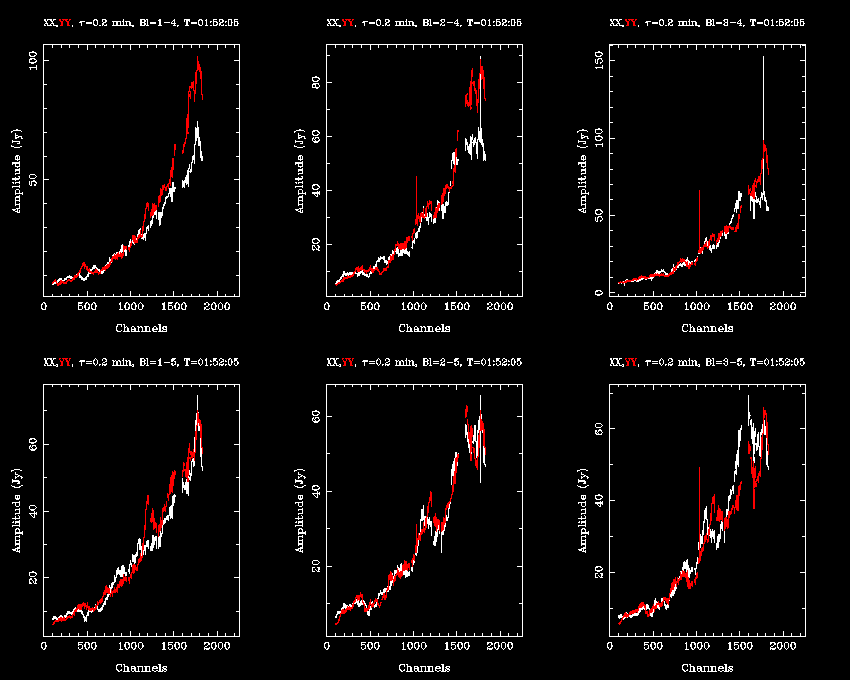

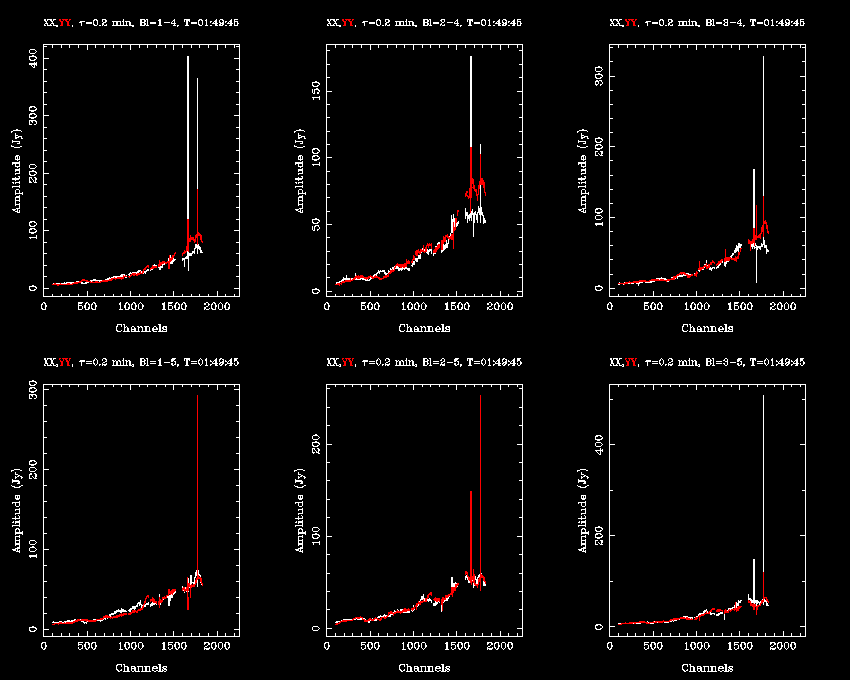

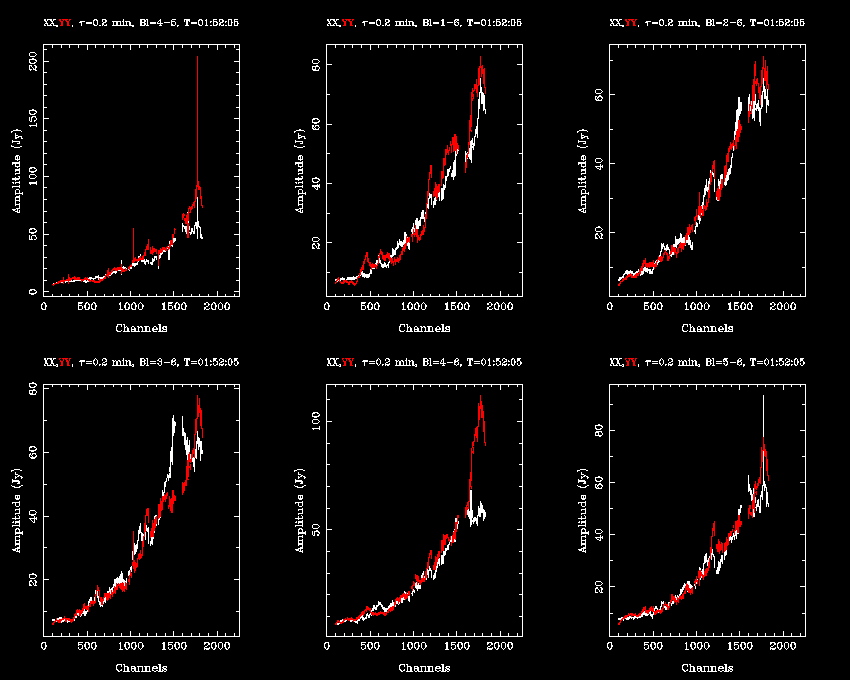

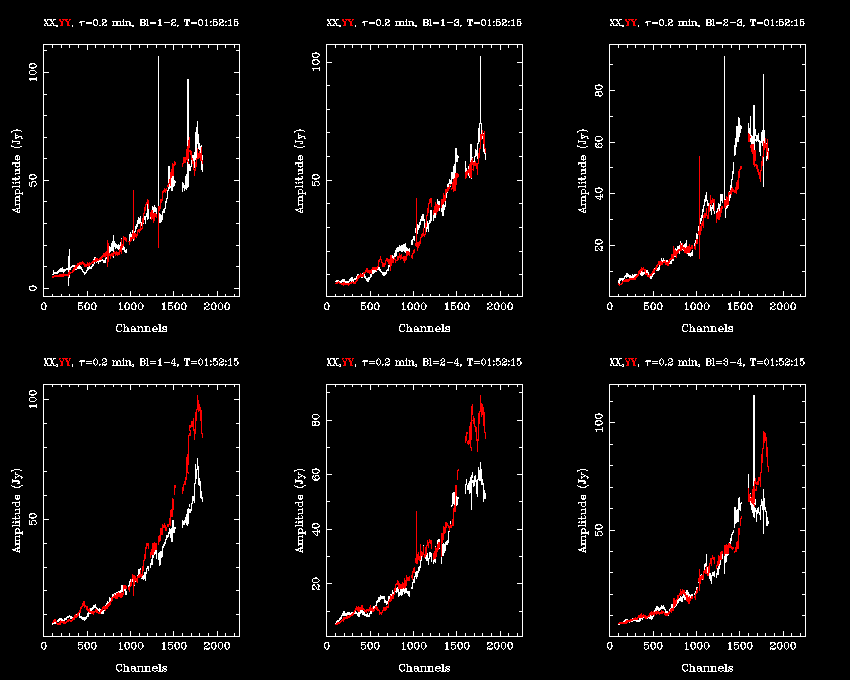

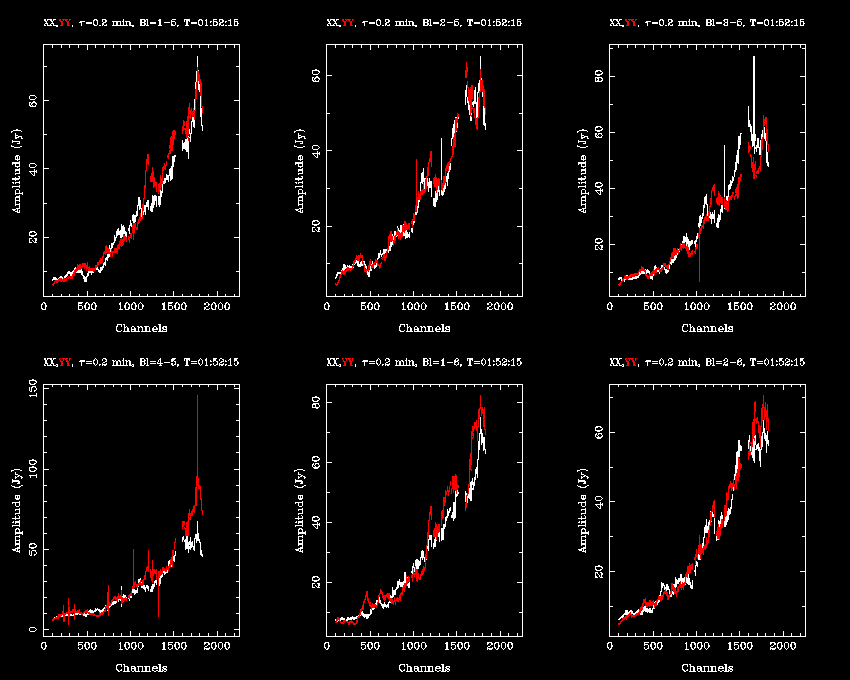

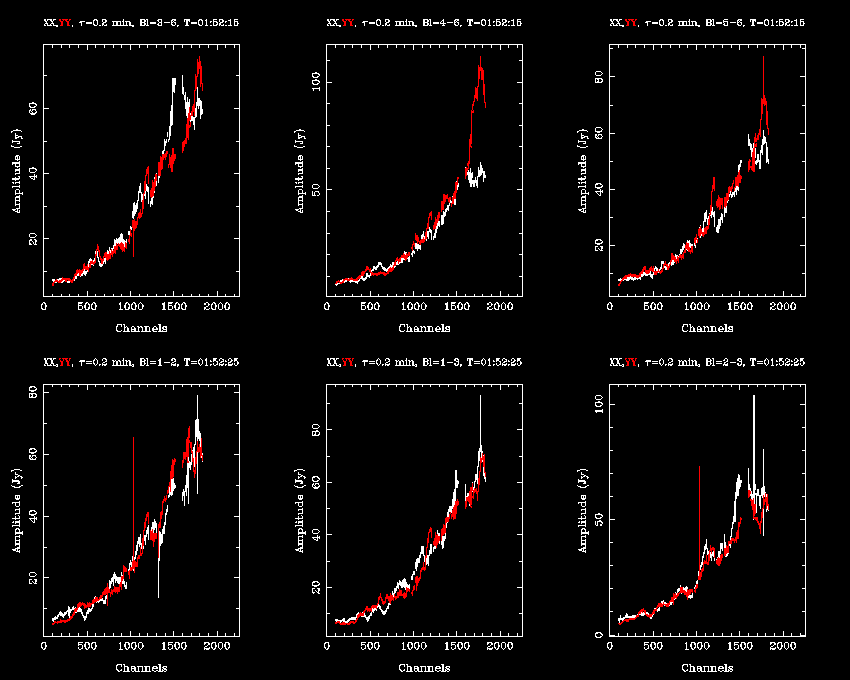

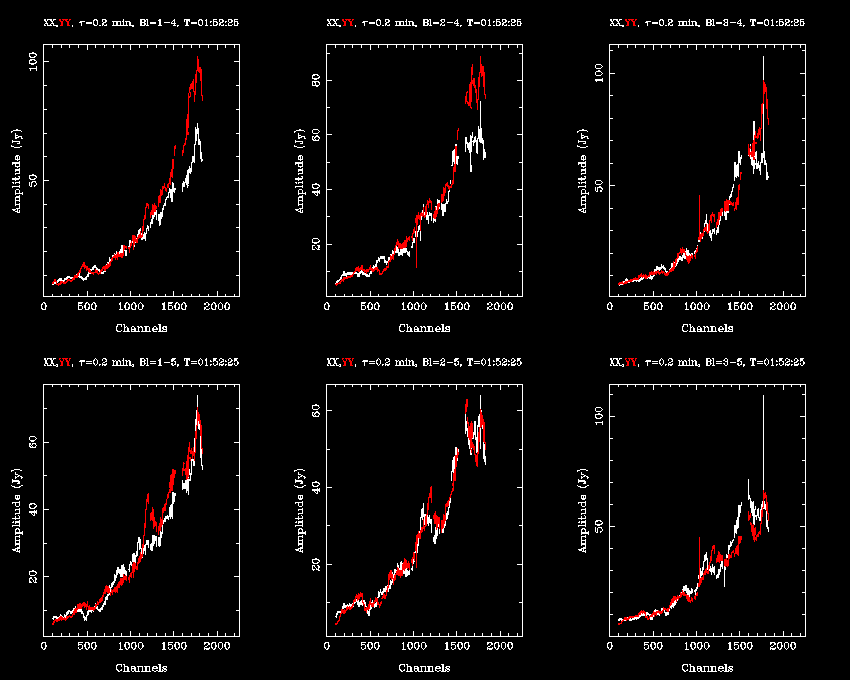

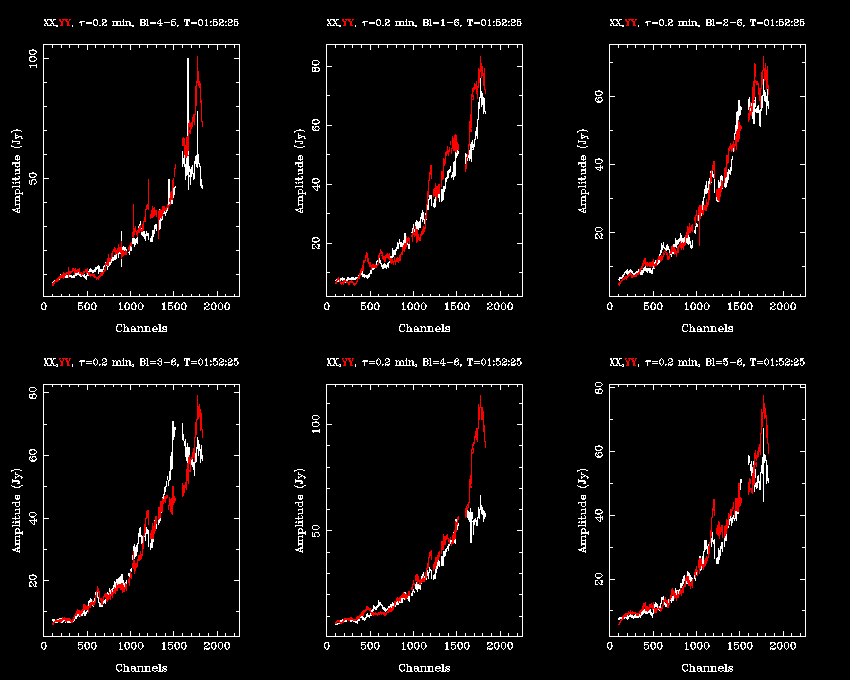

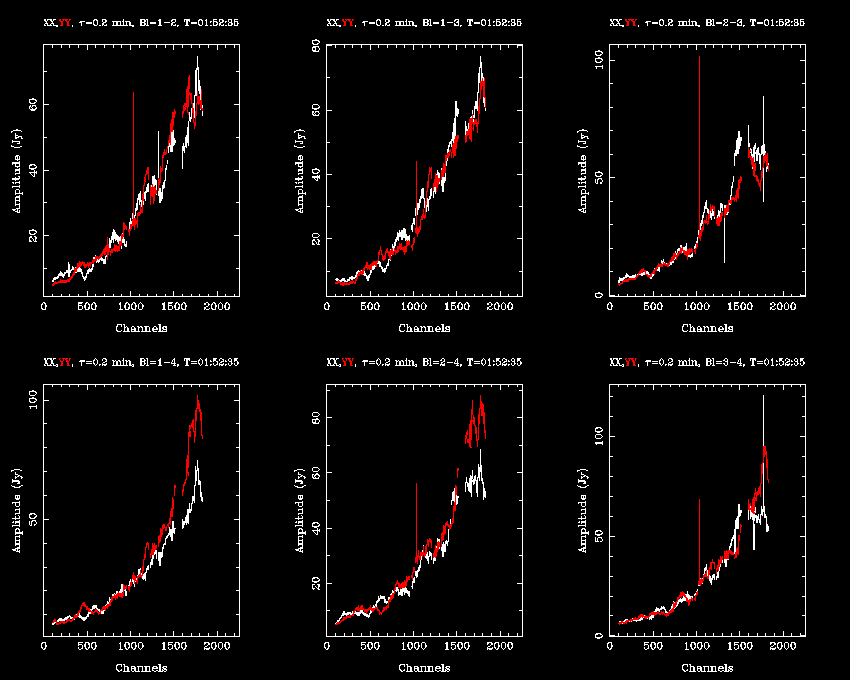

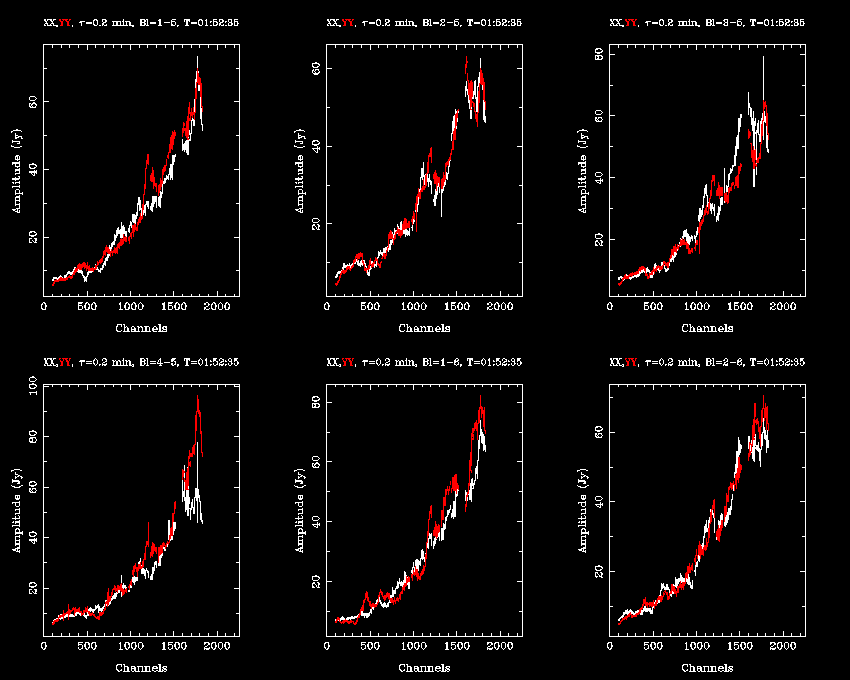

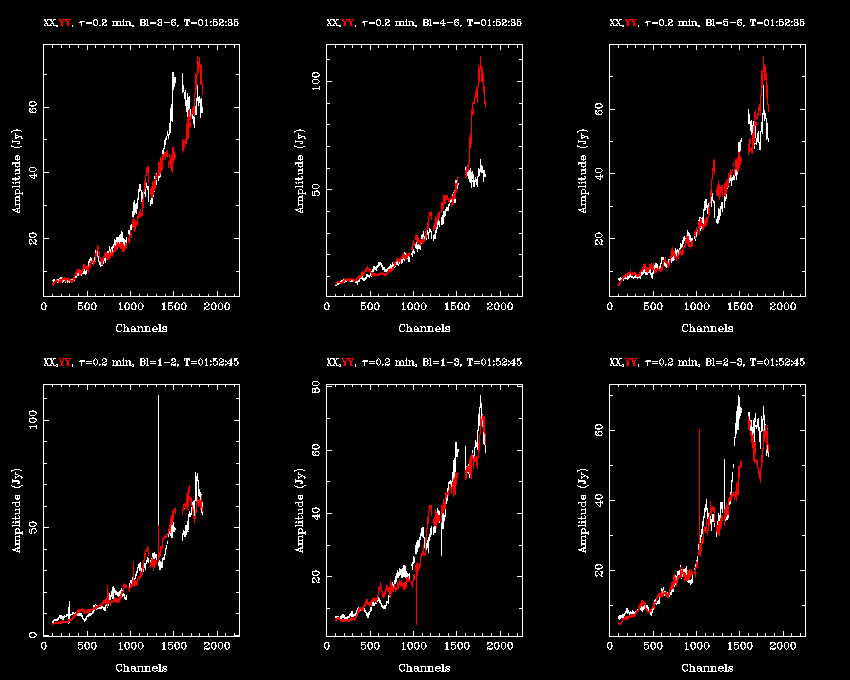

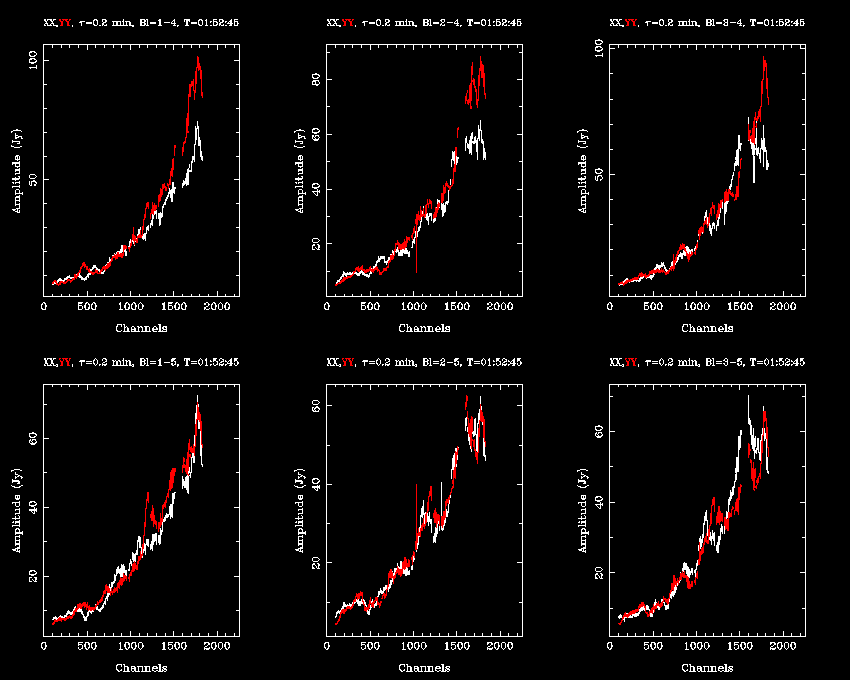

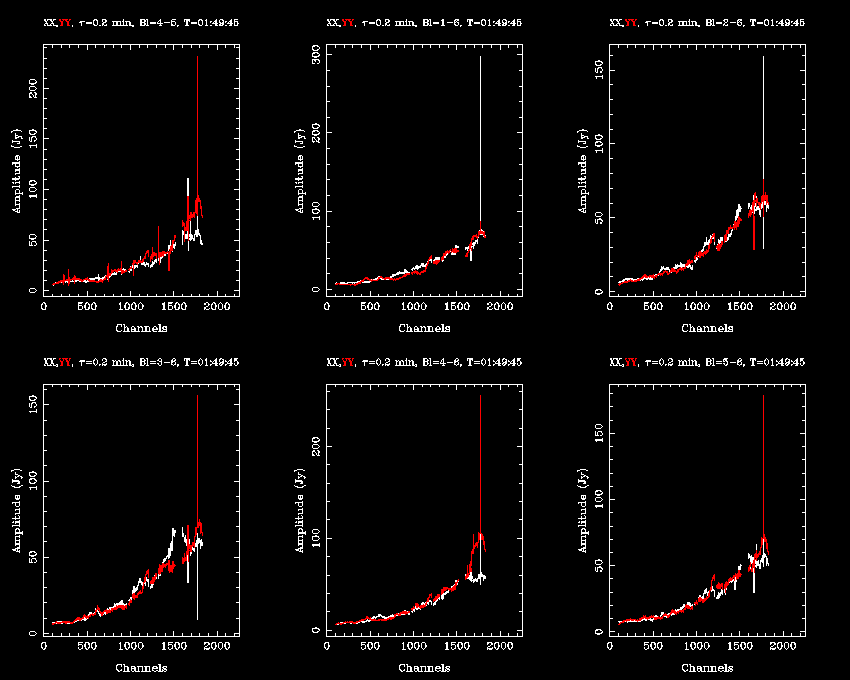

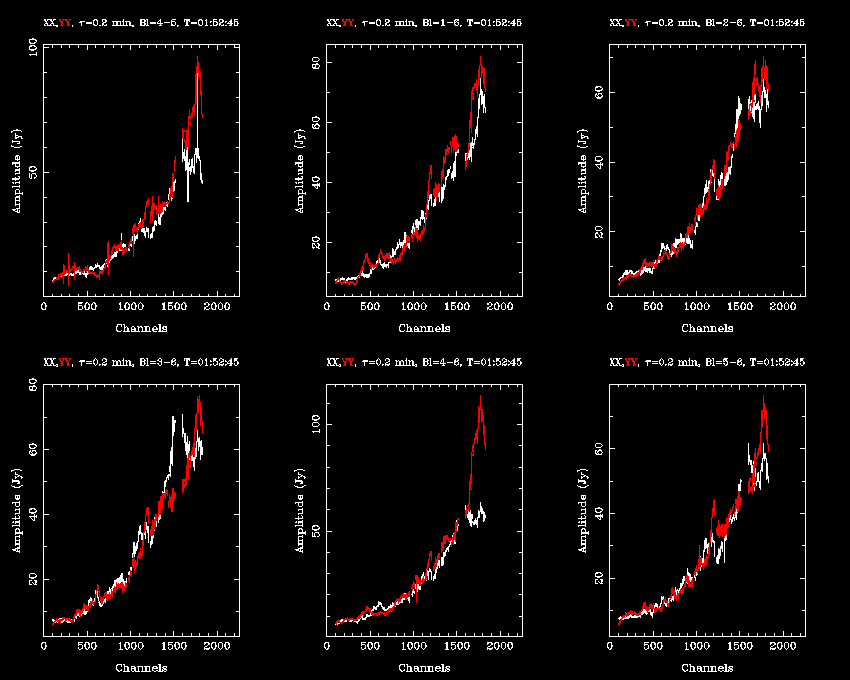

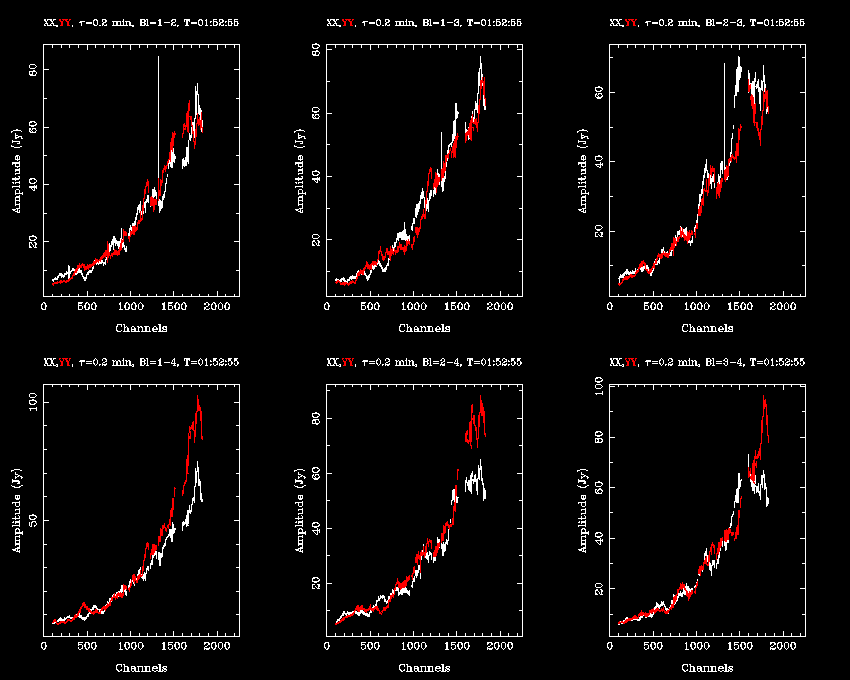

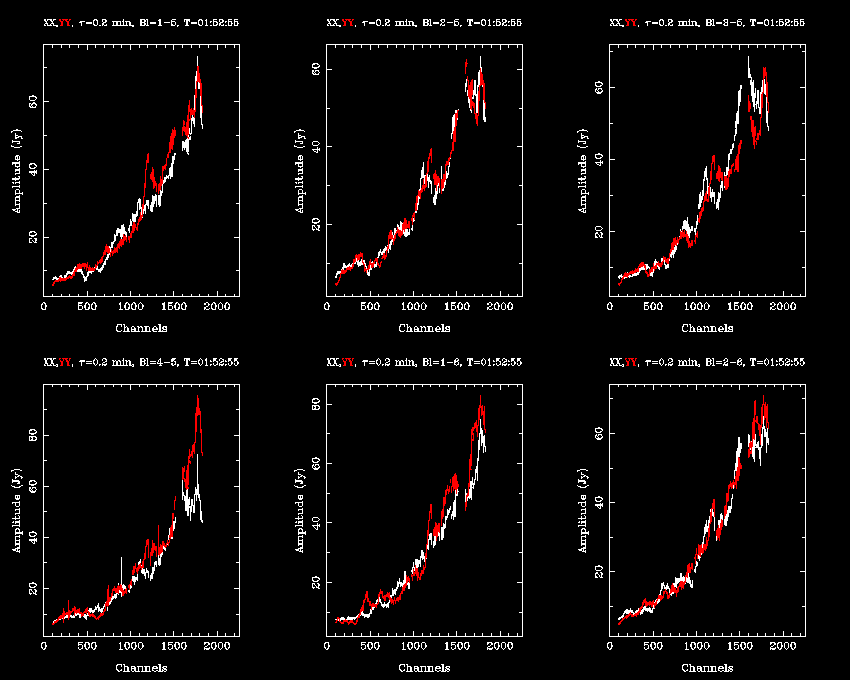

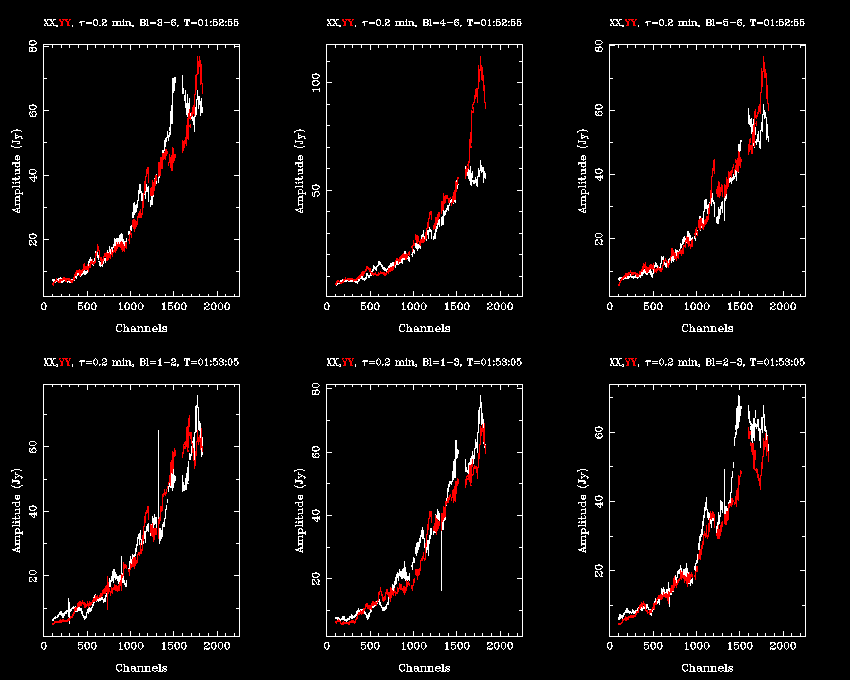

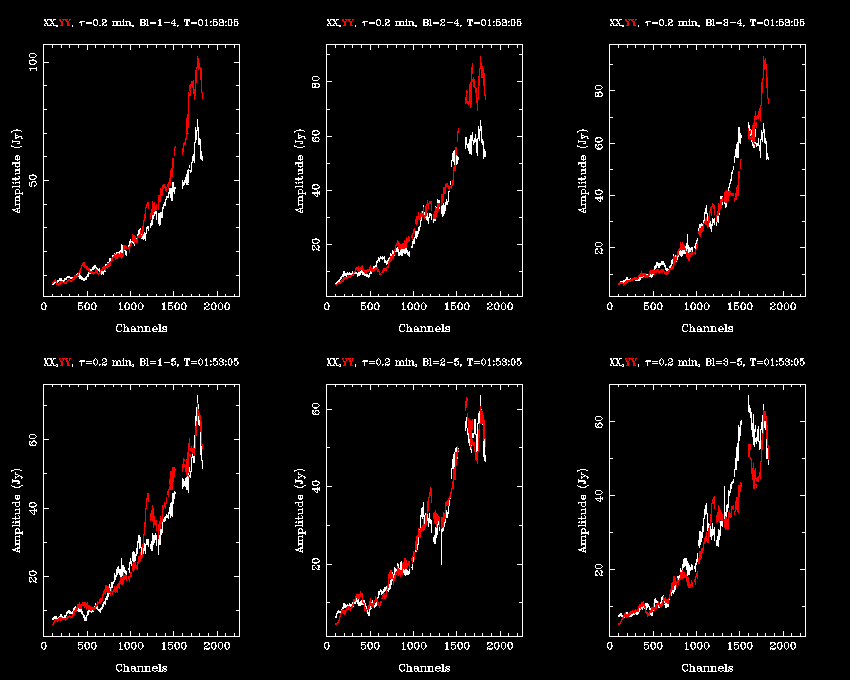

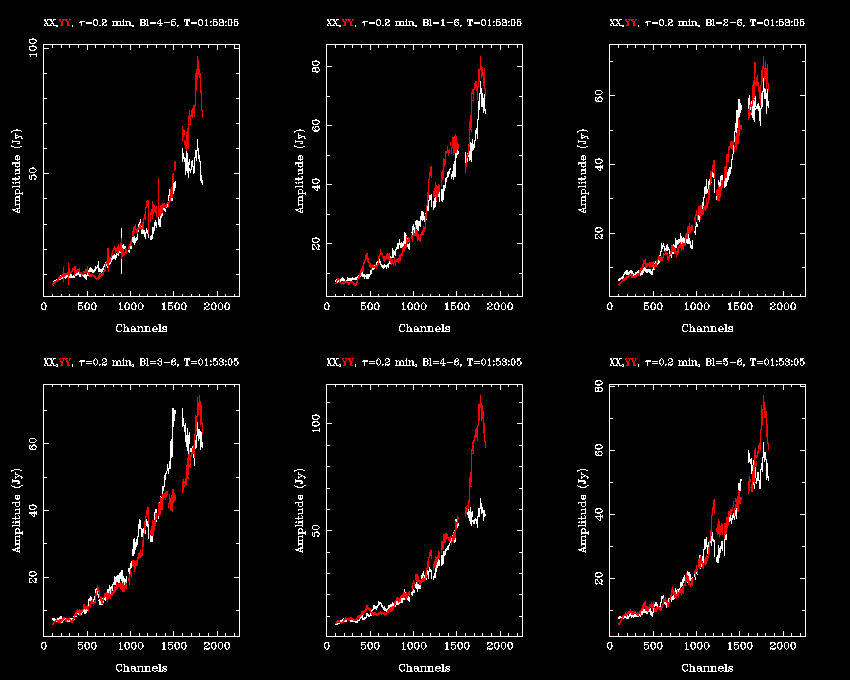

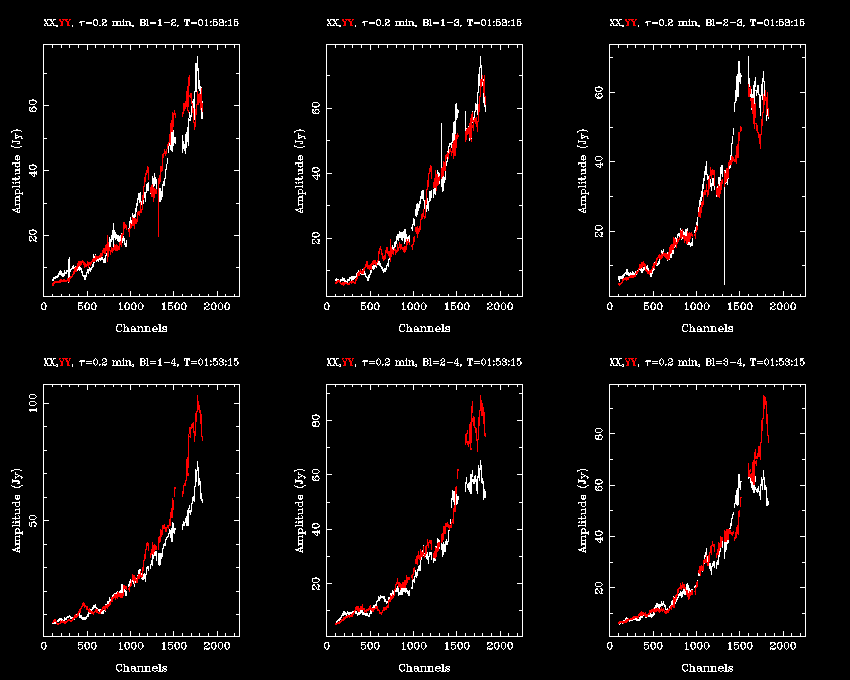

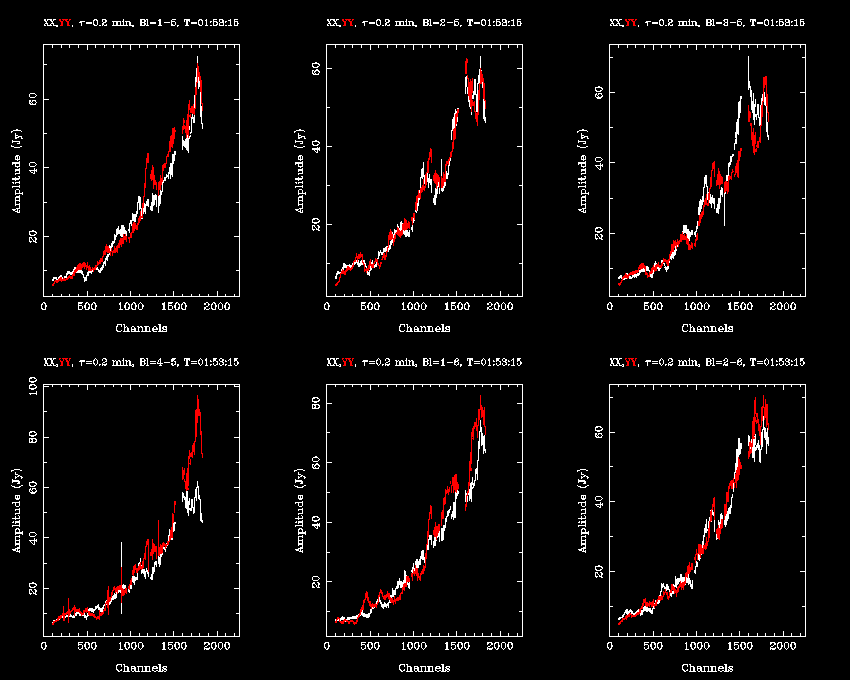

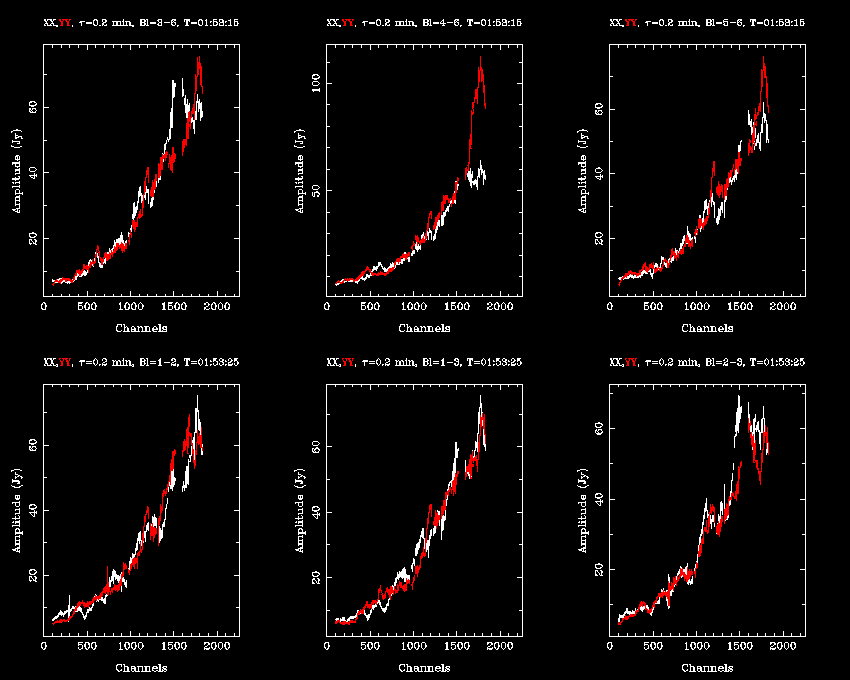

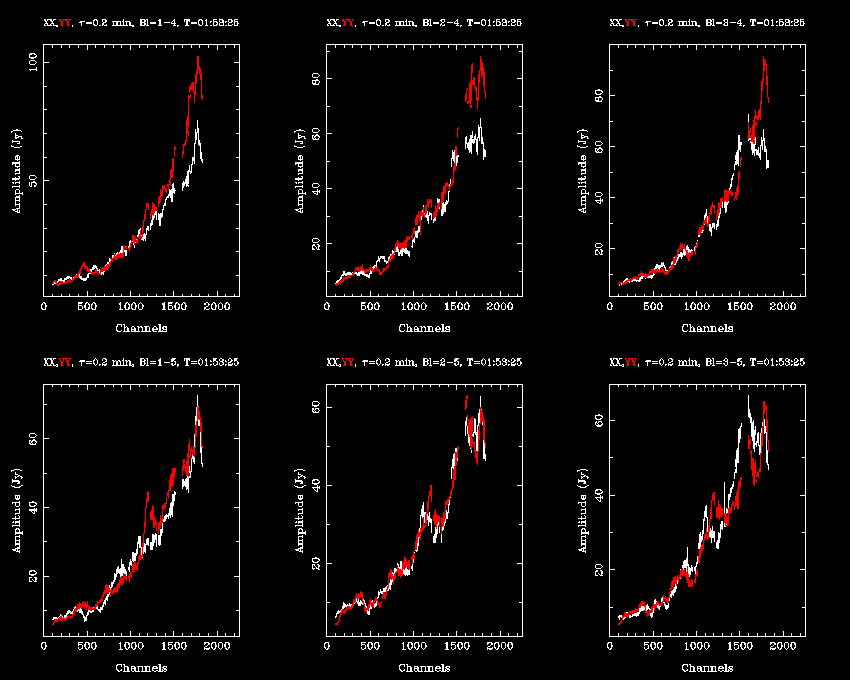

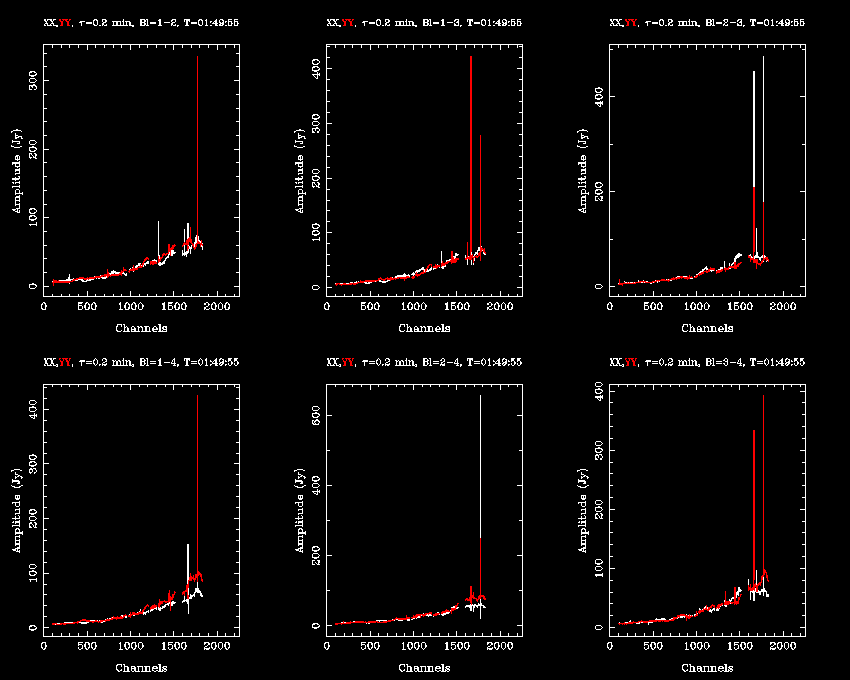

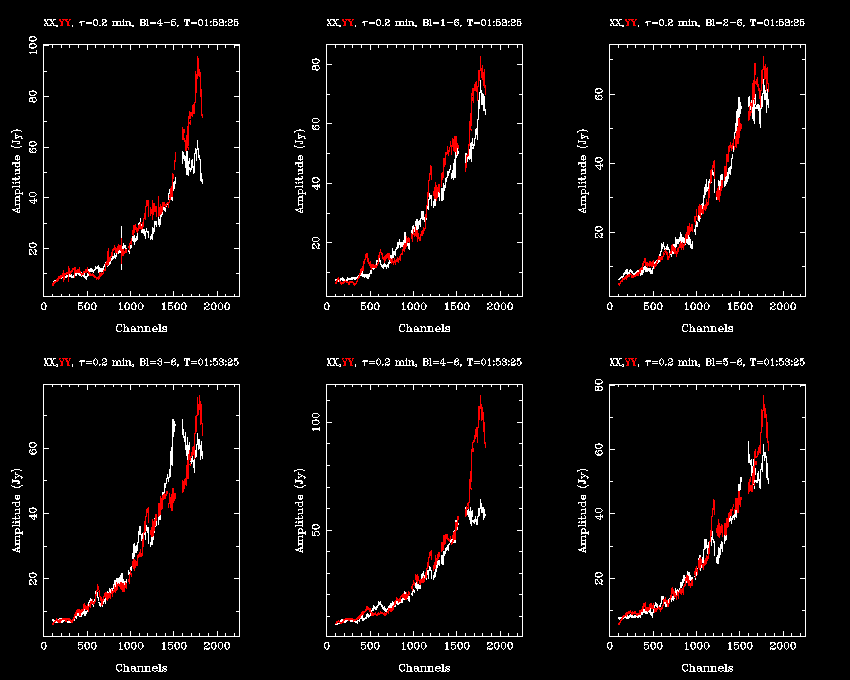

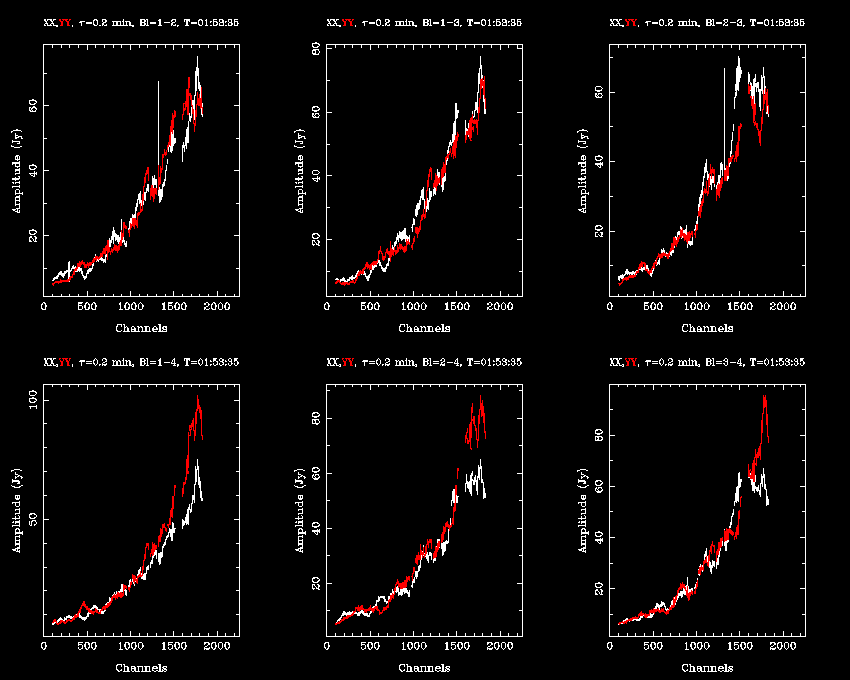

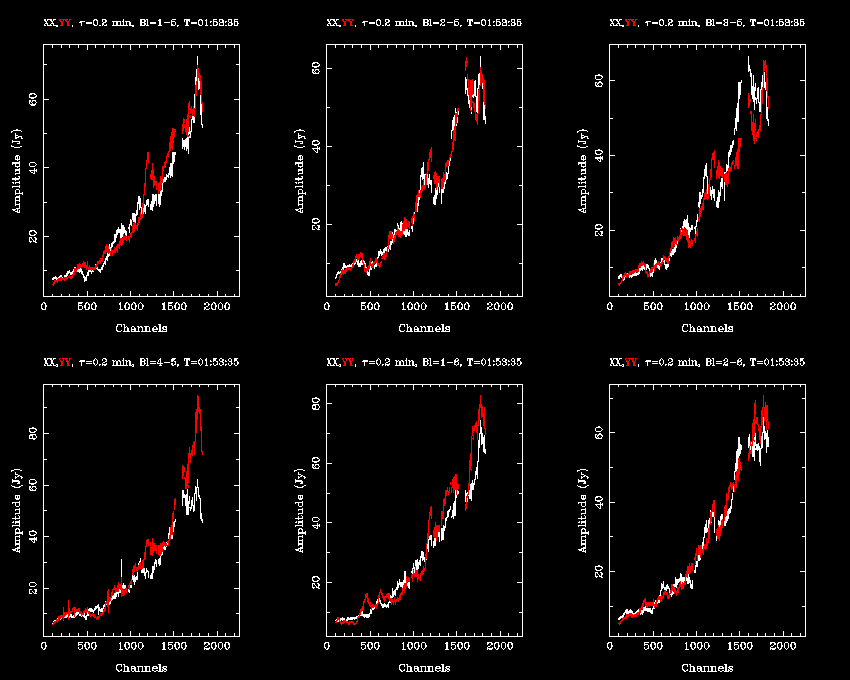

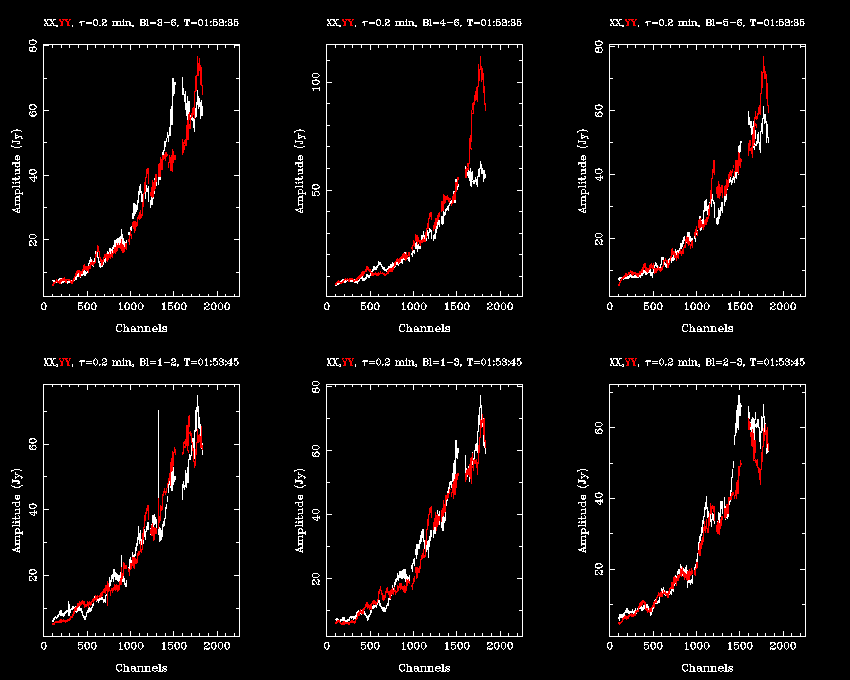

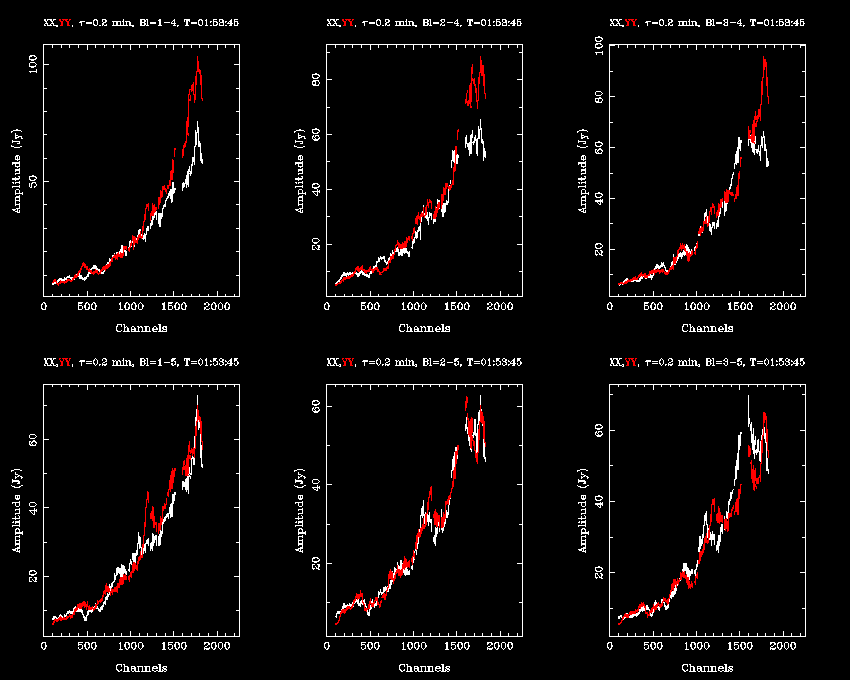

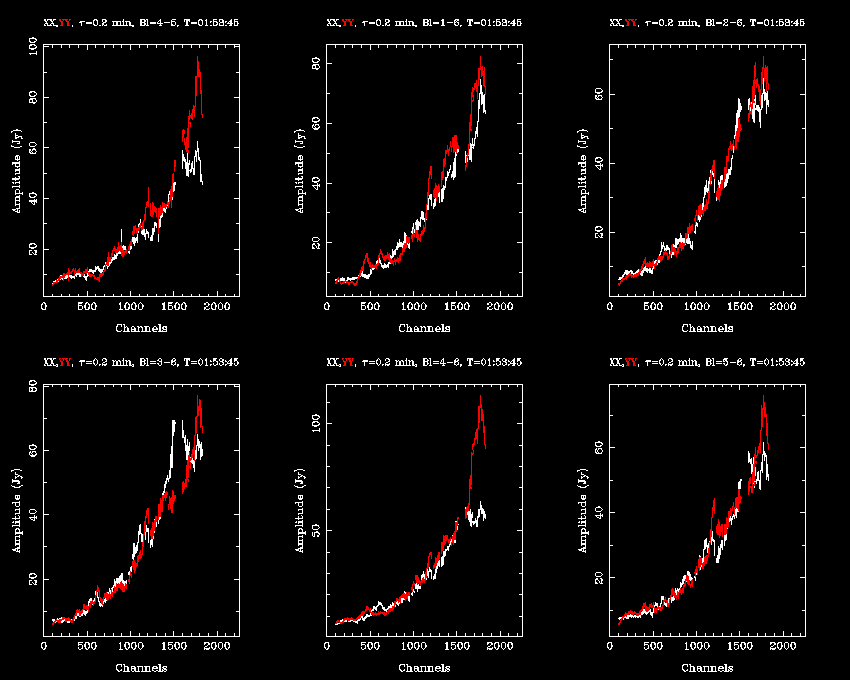

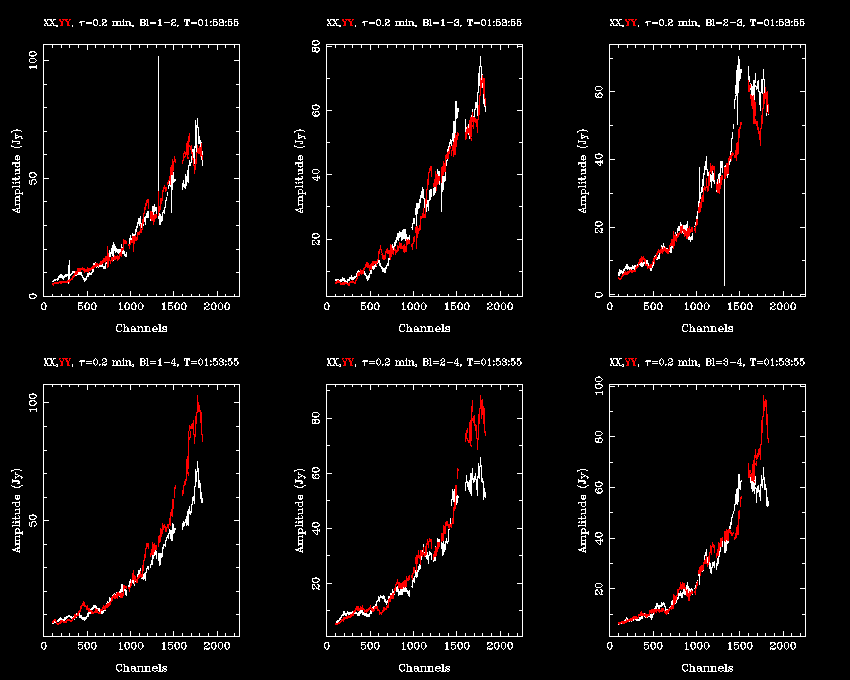

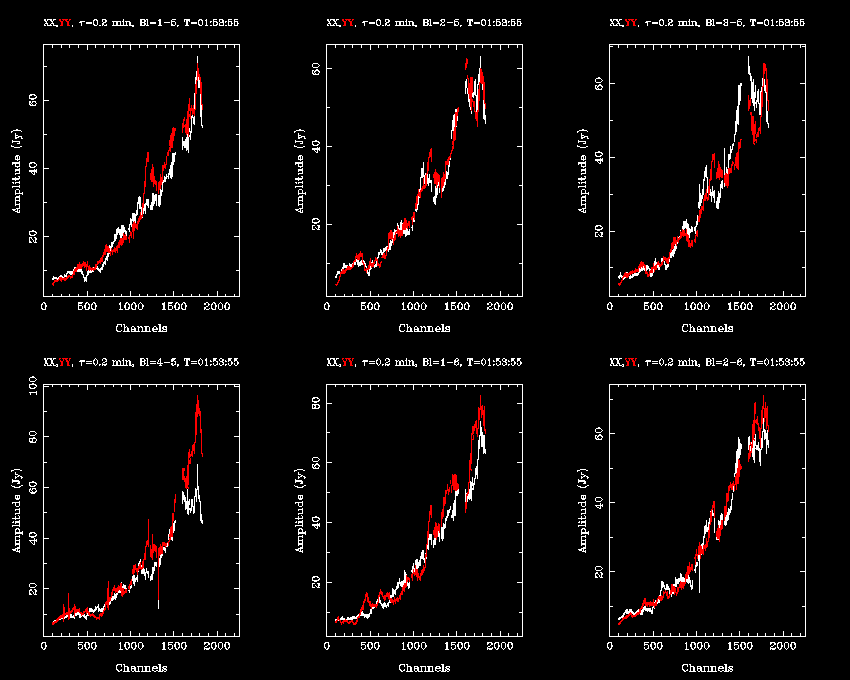

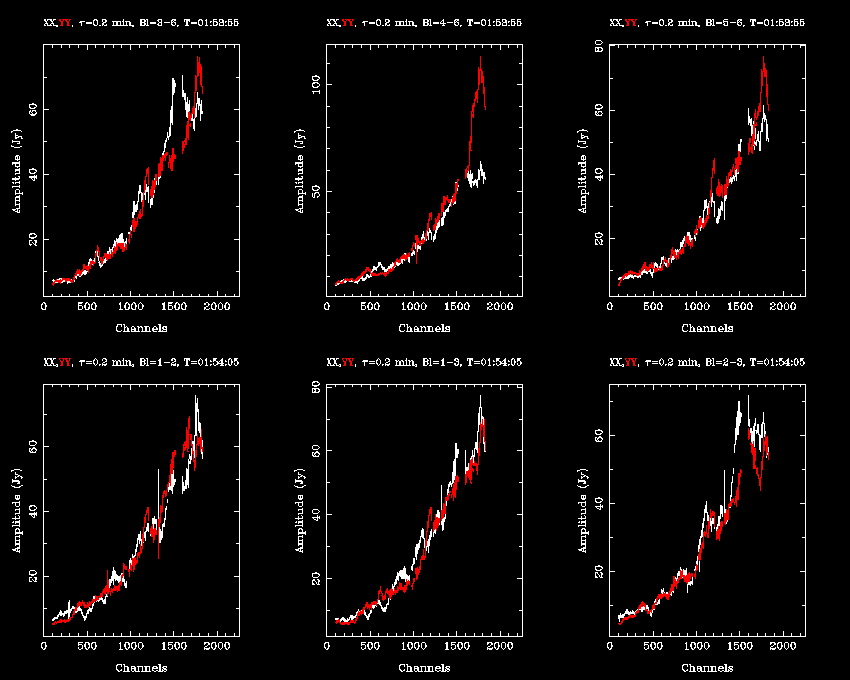

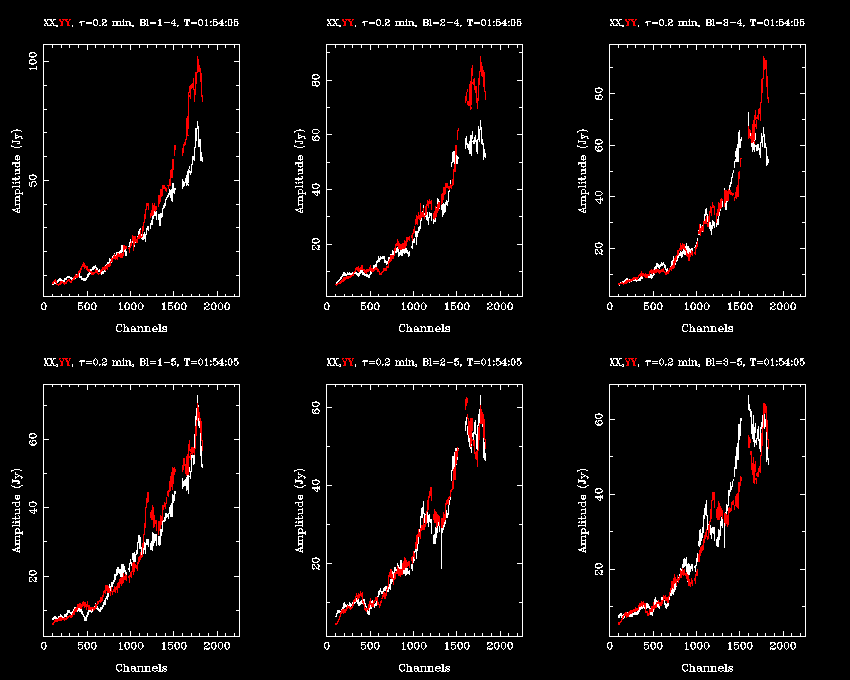

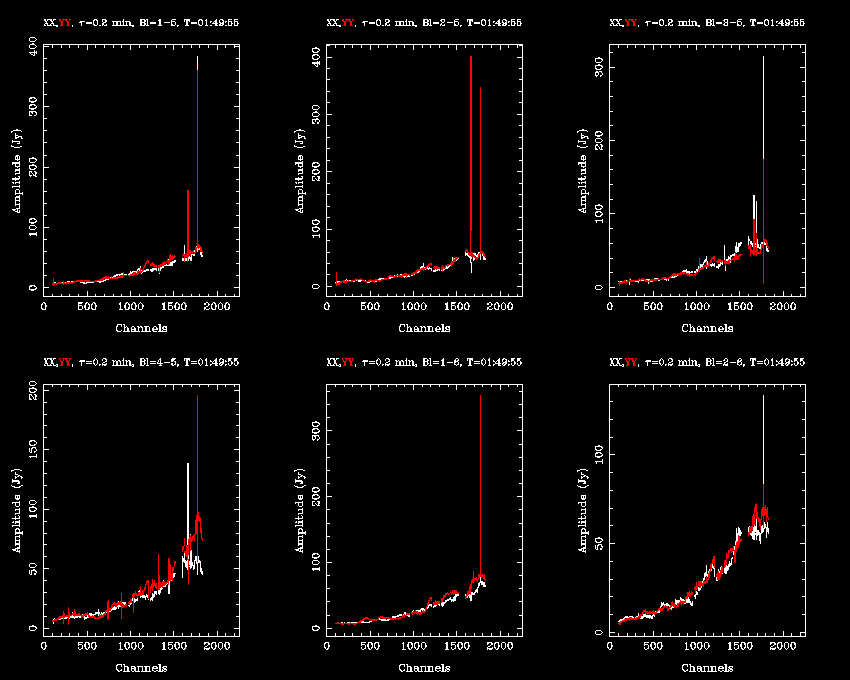

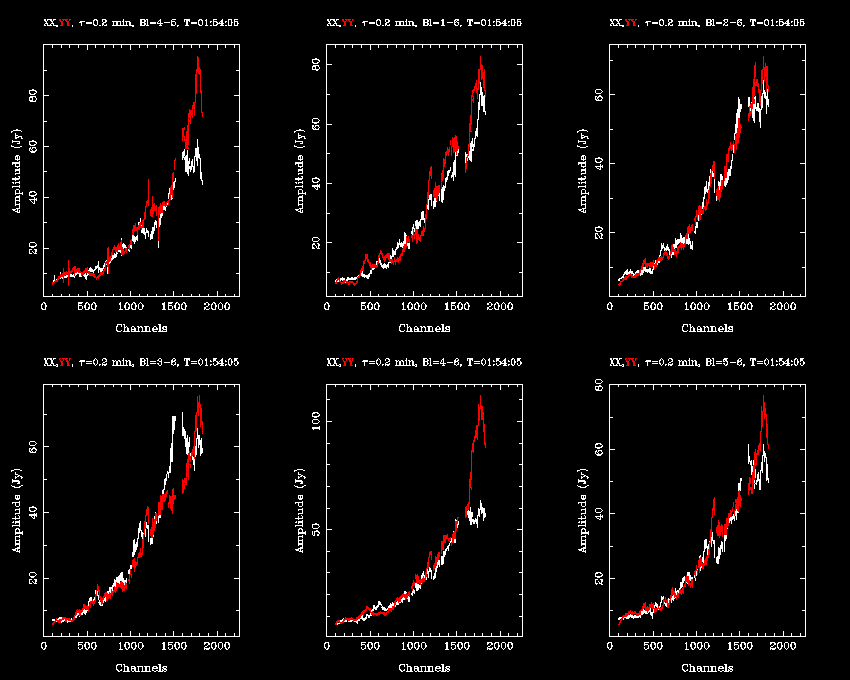

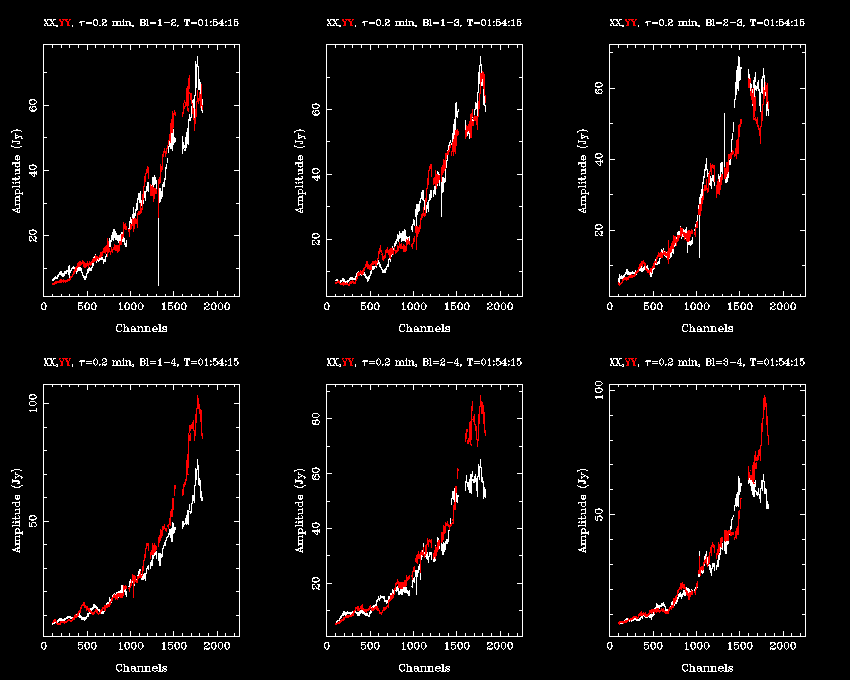

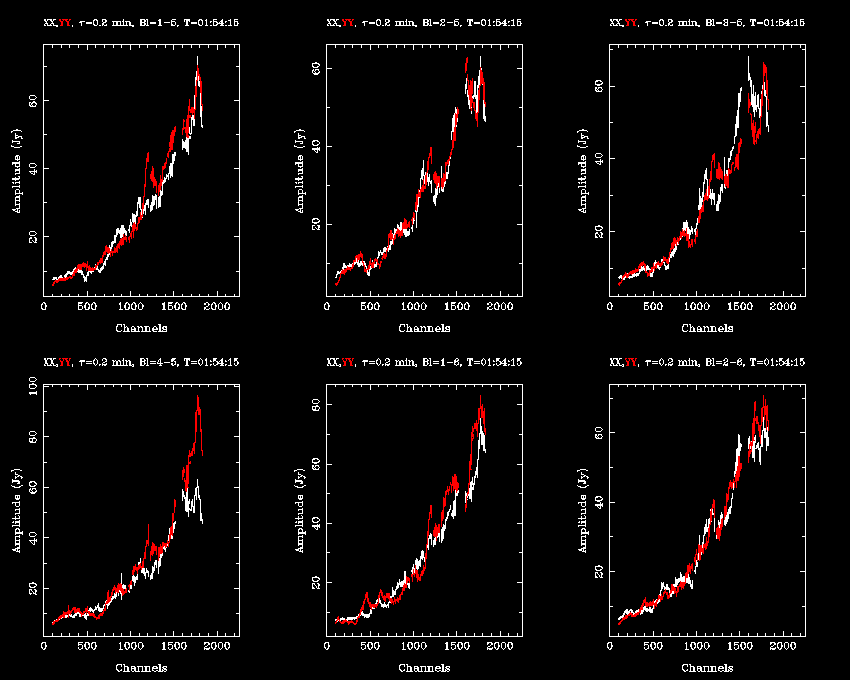

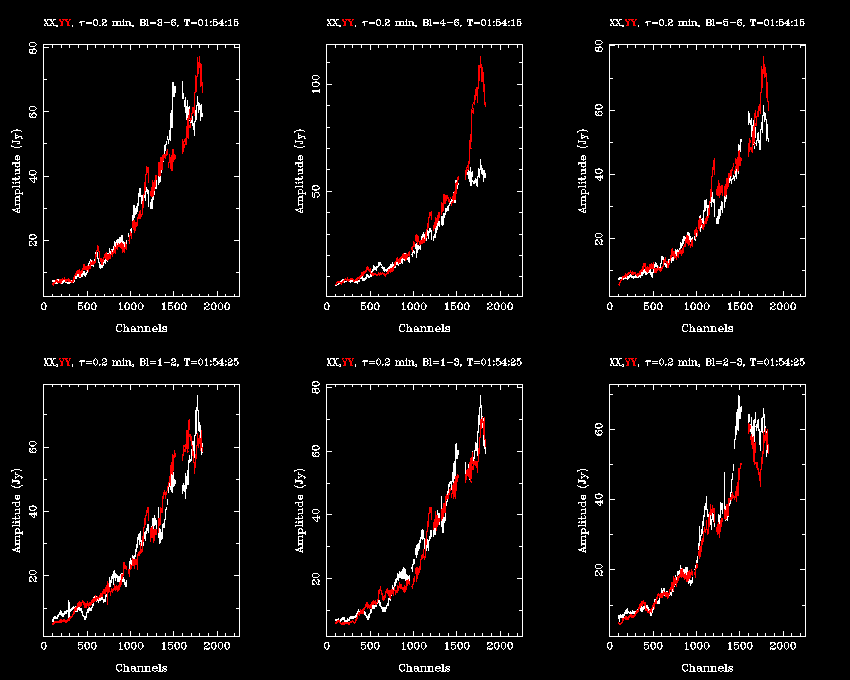

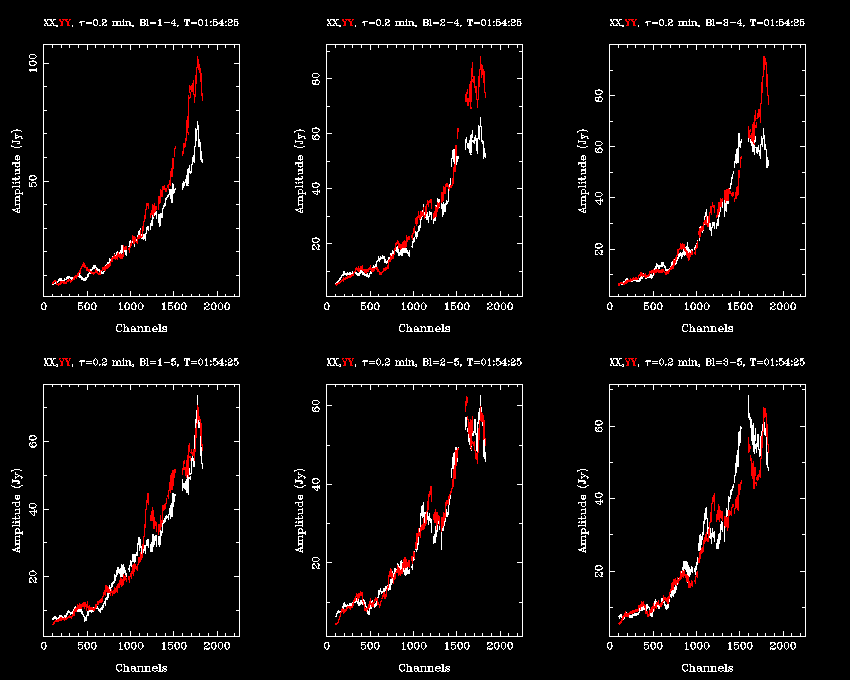

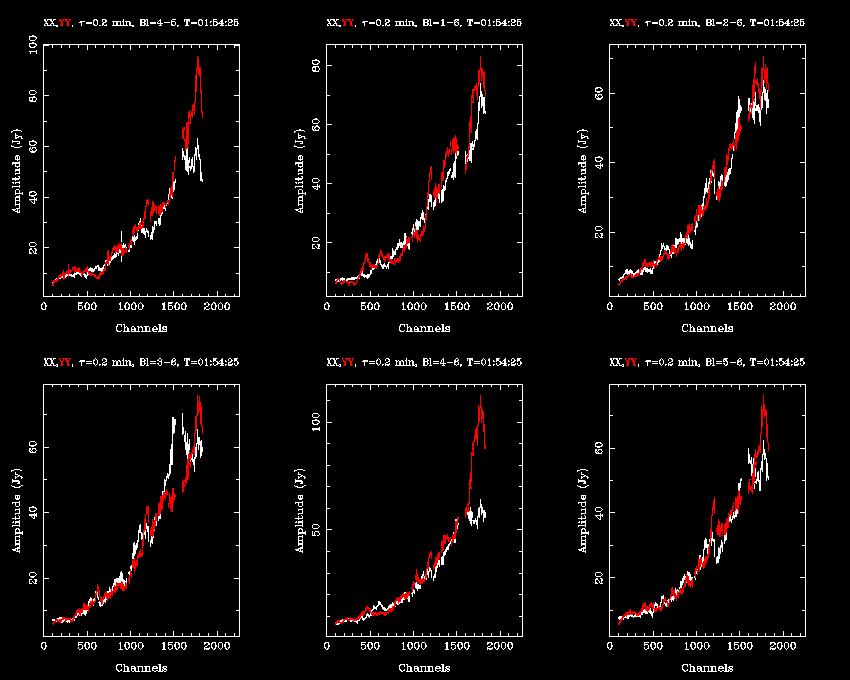

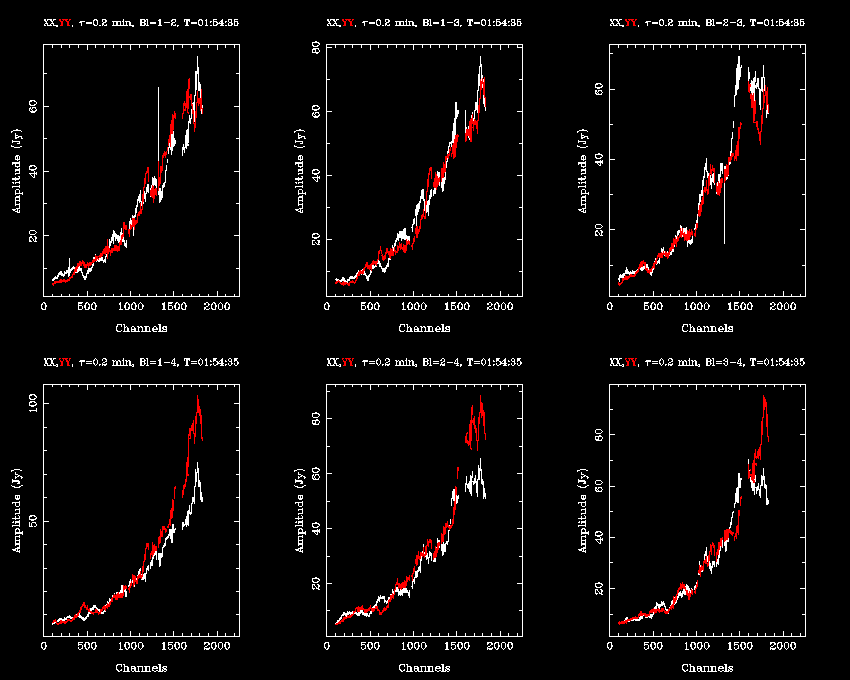

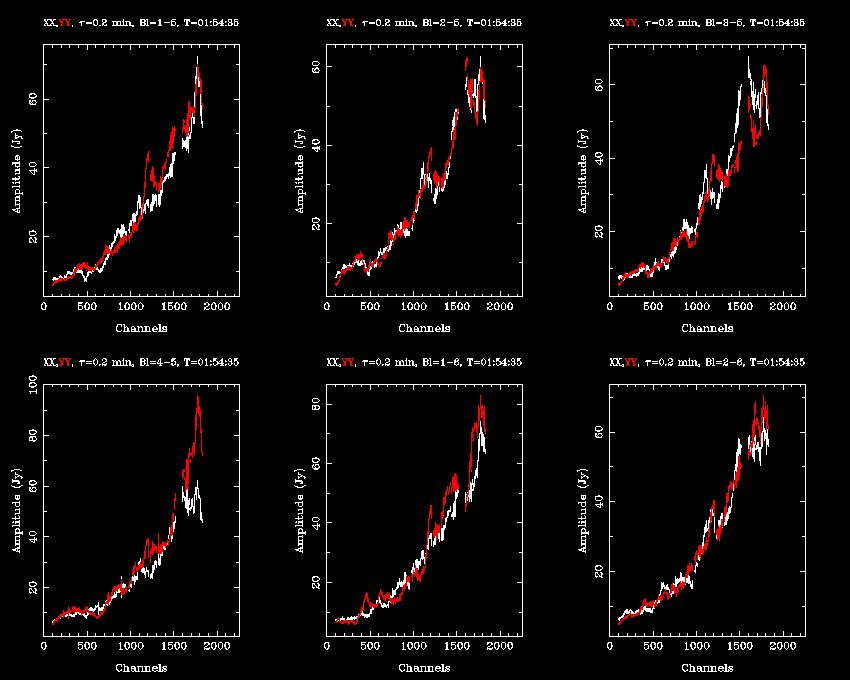

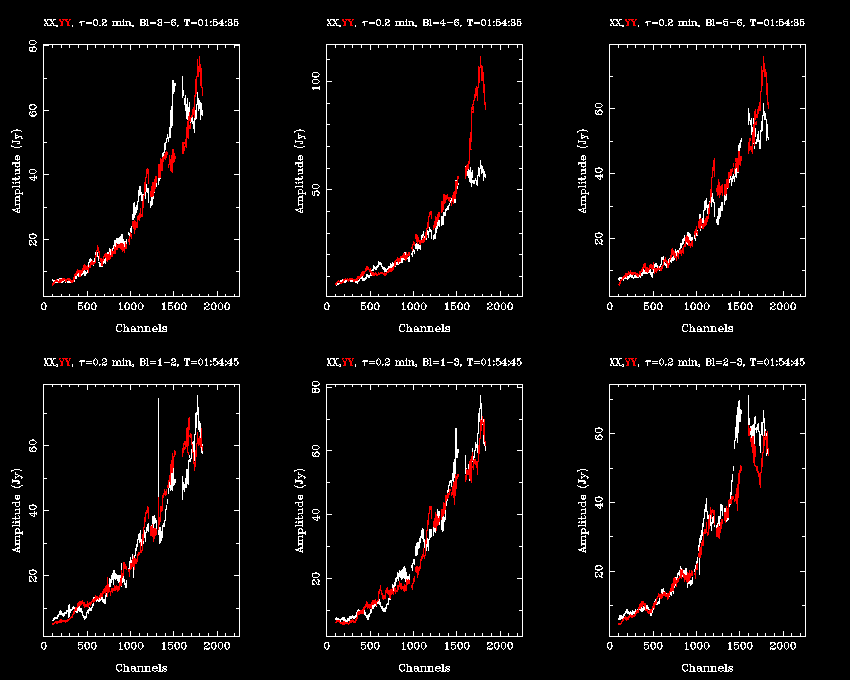

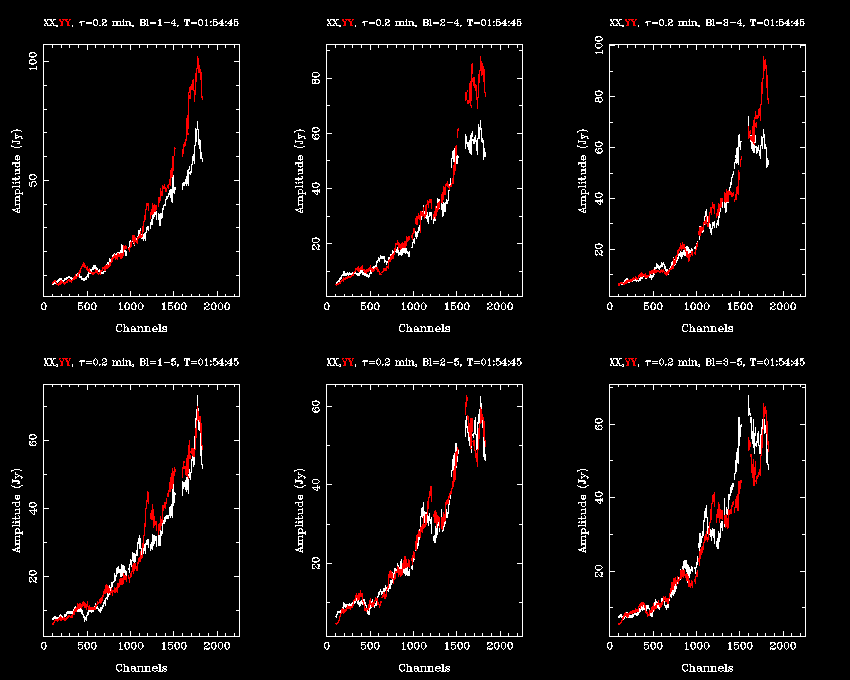

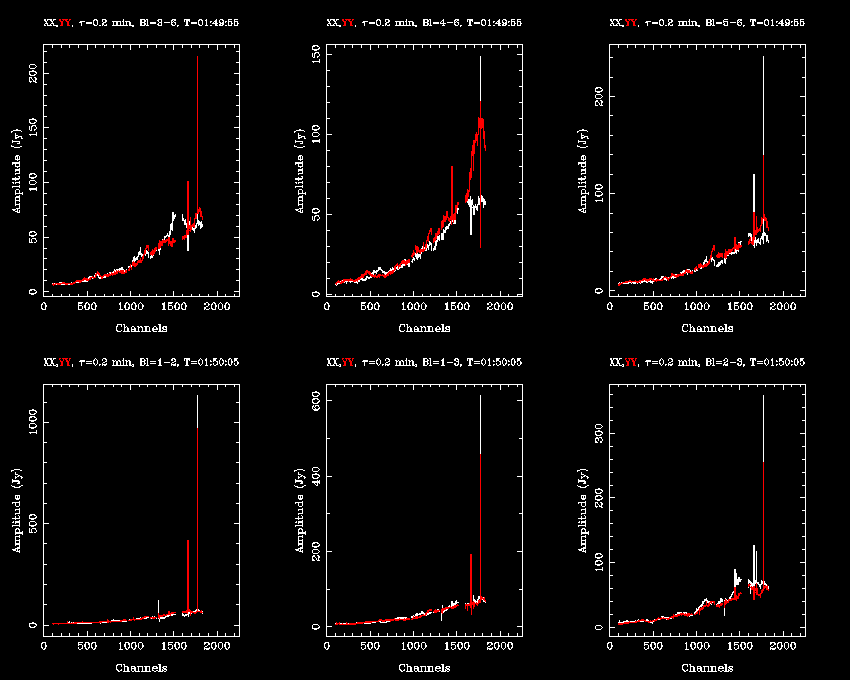

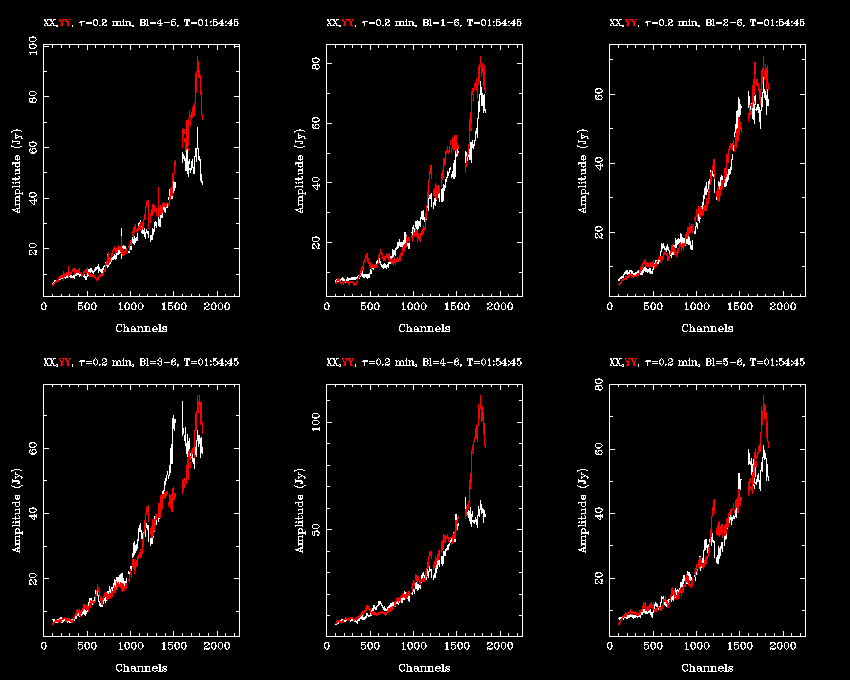

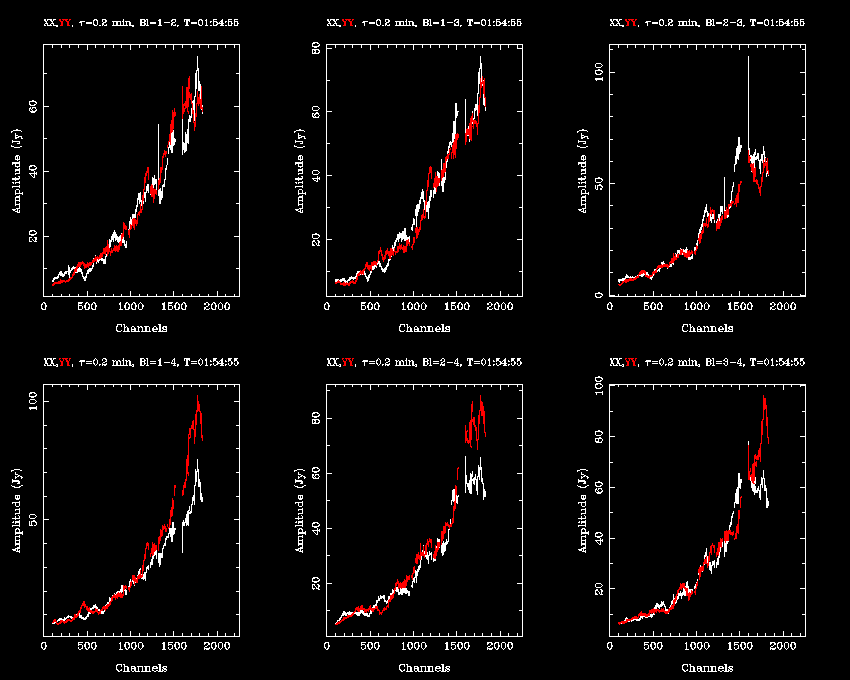

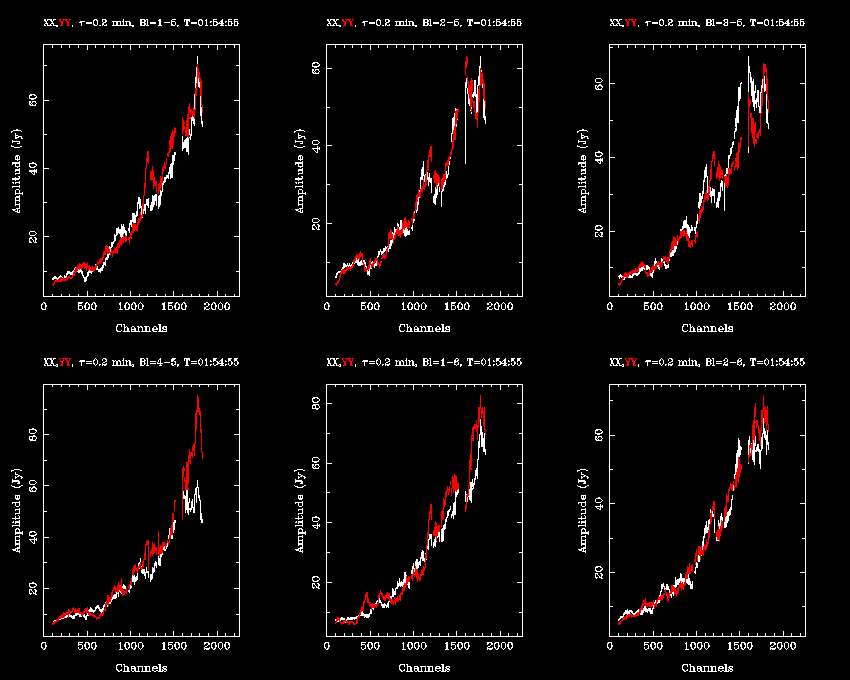

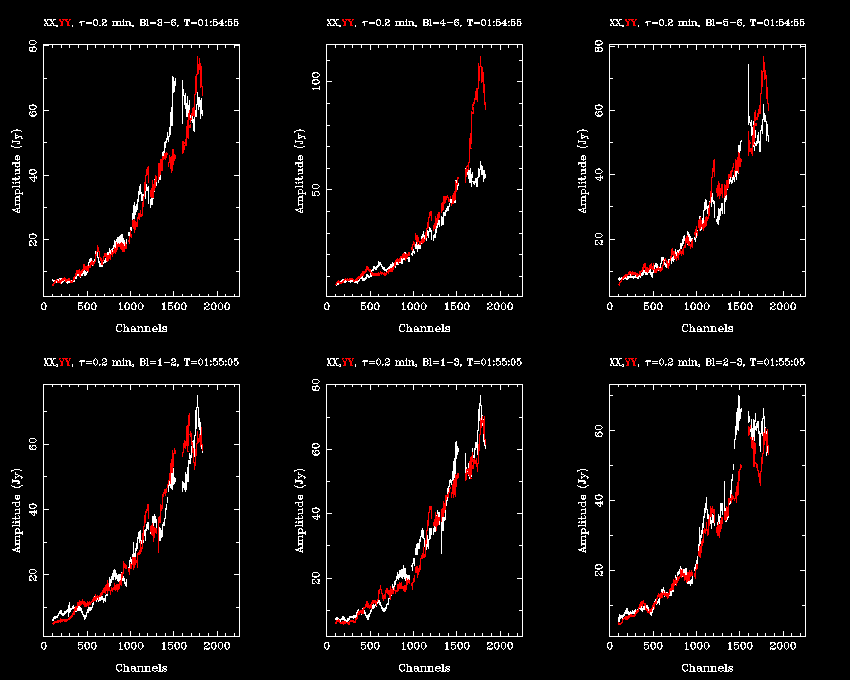

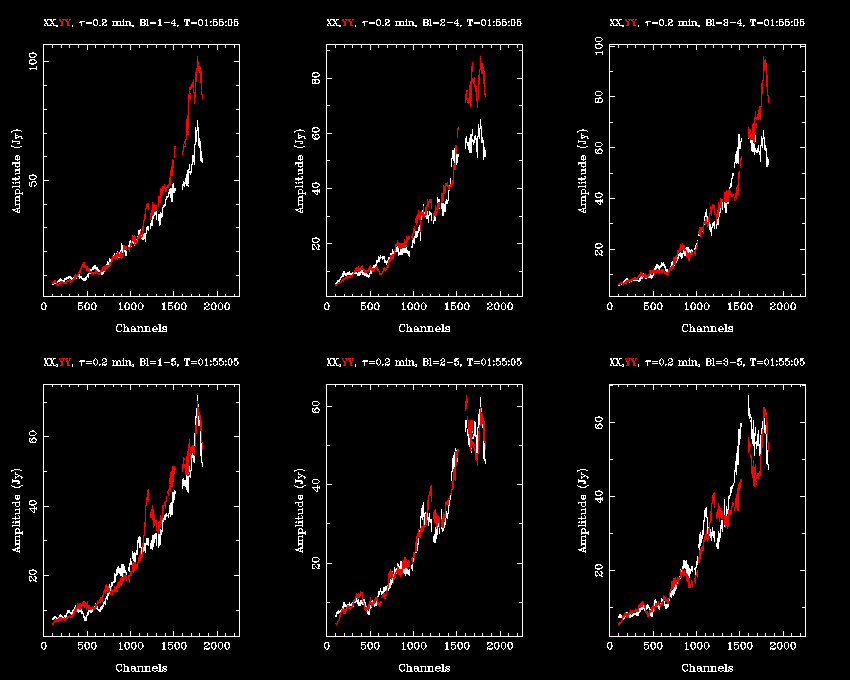

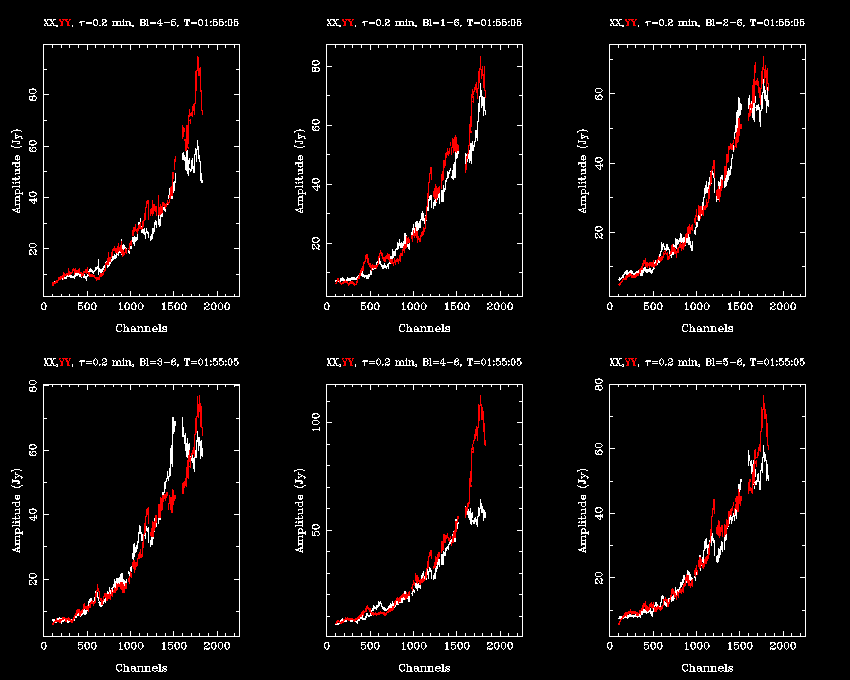

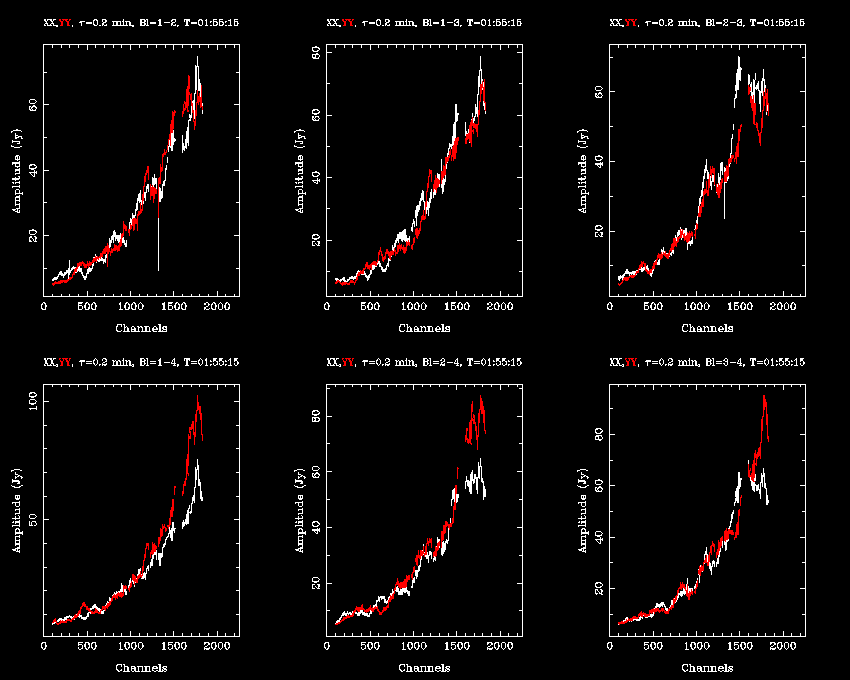

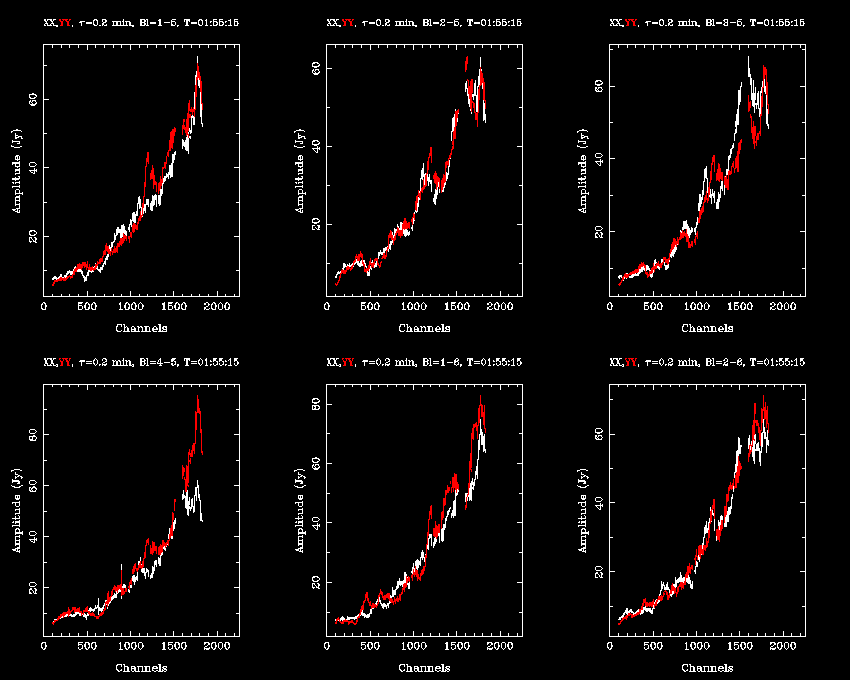

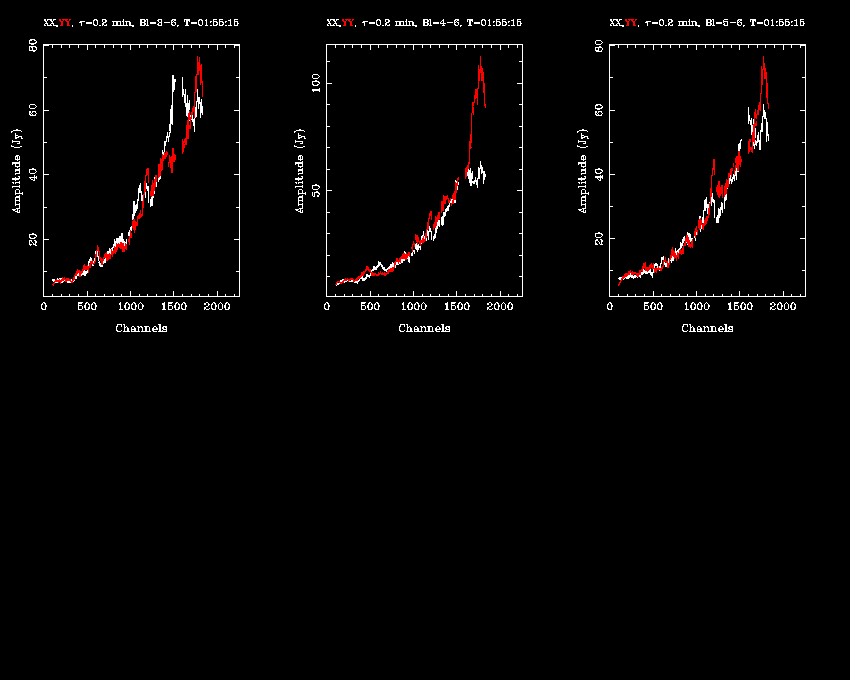

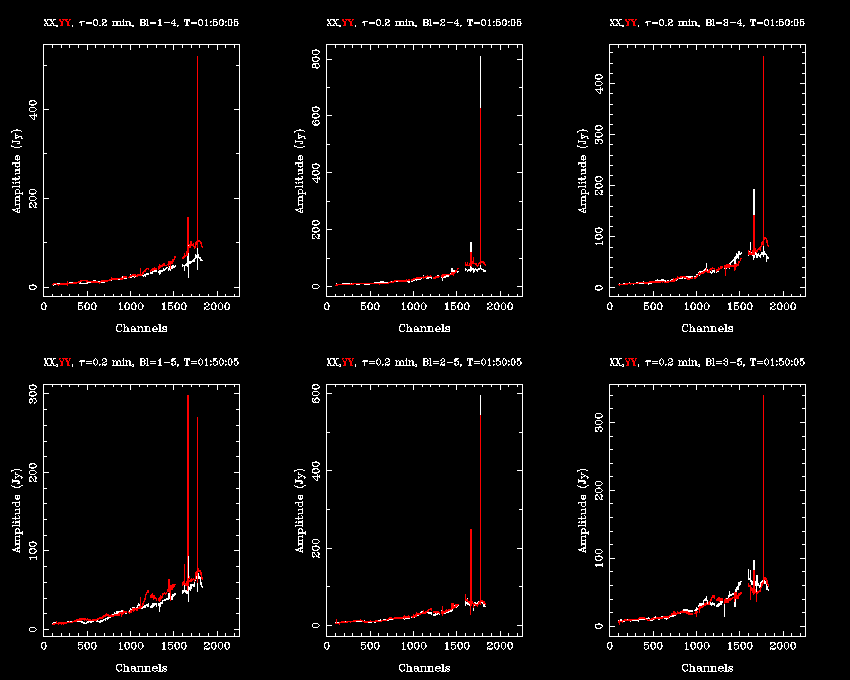

In [5]:


# get an idea of what the data looks like before calibration
print('#'*10+"Pre mfcal bandpass, flux calibration"+'#'*10)
# remove files if ran previously 
!rm *png* 
# uvspec parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "chan,amp"
device="{0}bfpremfcal.png/png".format(vis)
# can do devices like /xs, /png, /null, or others listed on the link:
# (http://www.atnf.csiro.au/computing/software/miriad/userguide/node25.html)
# note: you have to close xs before the cell stops hanging
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}bfpremfcal*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))


MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $
Selecting parallel-hand polarisations
Reading the data ...
Number correlations accepted: 1601250
Number of frequency bands/settings: 1
Number of polarisations selected: 2
Number of solution intervals: 2
Number of passband solution intervals: 1
Initialising ...
Using post-Aug94 ATCA flux scale for 1934-638.
Using known frequency variation of 1934-638
Generating initial solution estimate ...
Doing solution refinement ...
Iter= 1, Solution Error:  0.673
Iter= 2, Solution Error:  0.002
Iter= 3, Solution Error:  0.000
Saving solution ...
##########Post mfcal bandpass, flux calibration##########


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'mfcal':  Correlations flagged or edge-rejected: 550200
  warnings.warn(msg)


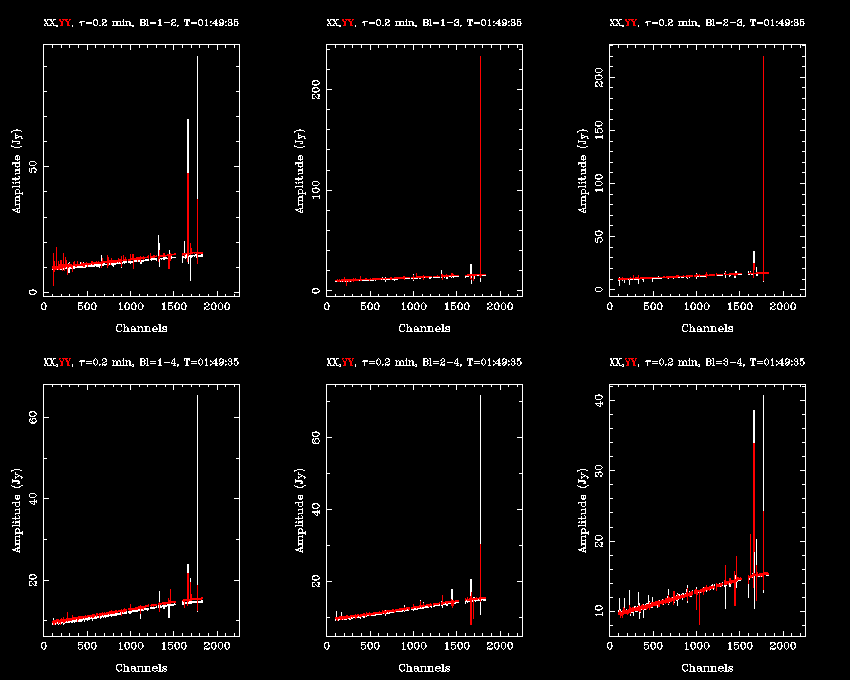

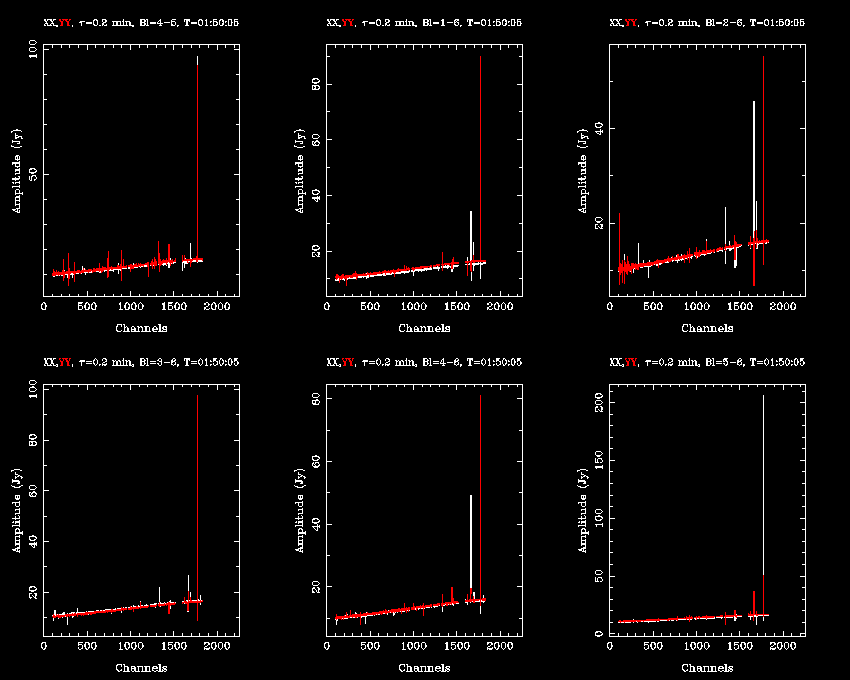

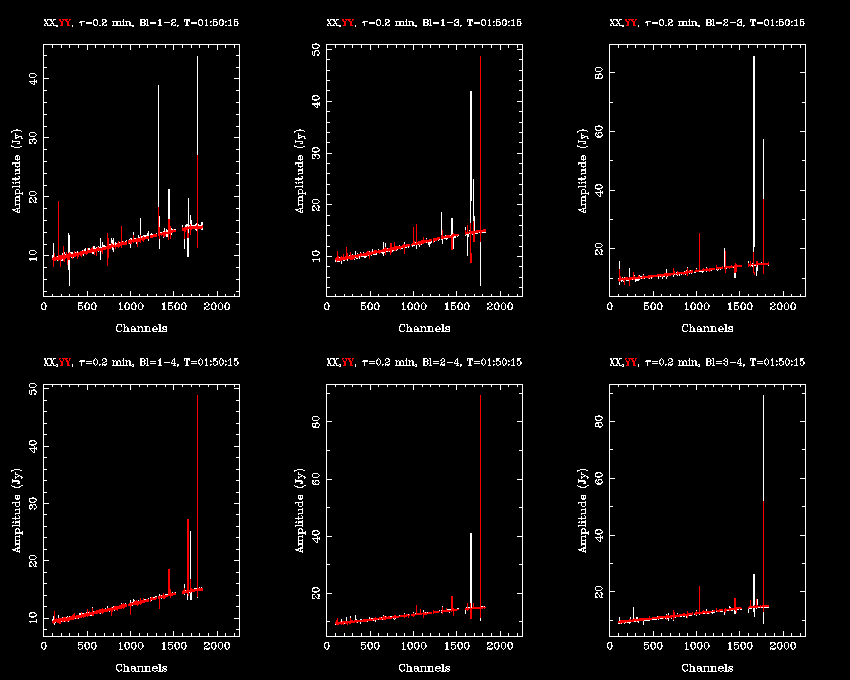

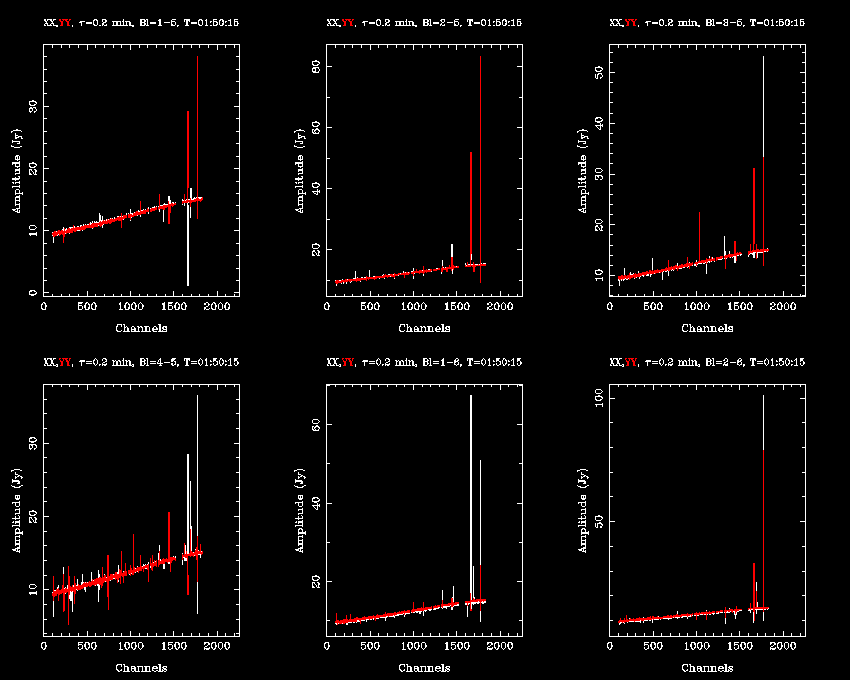

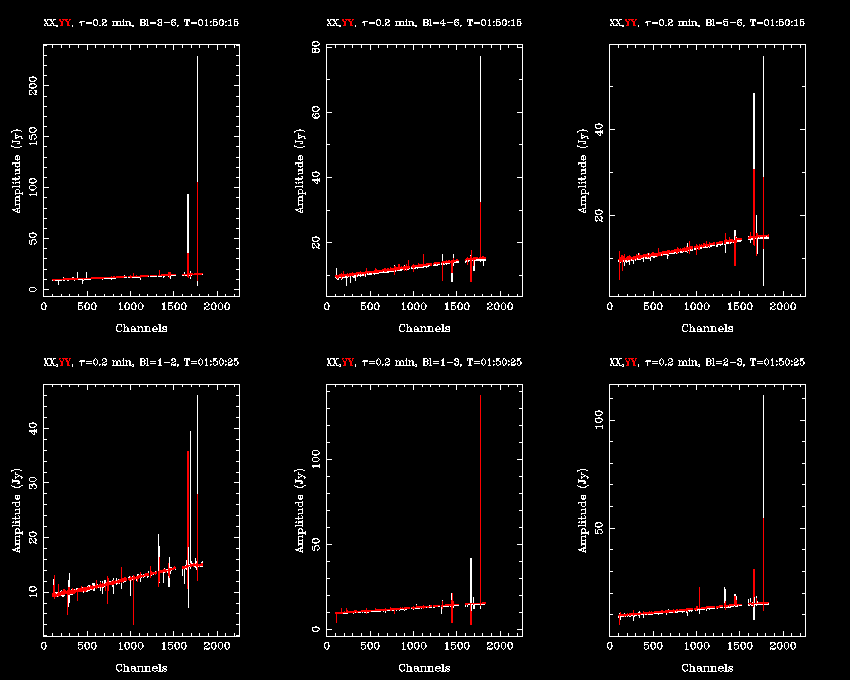

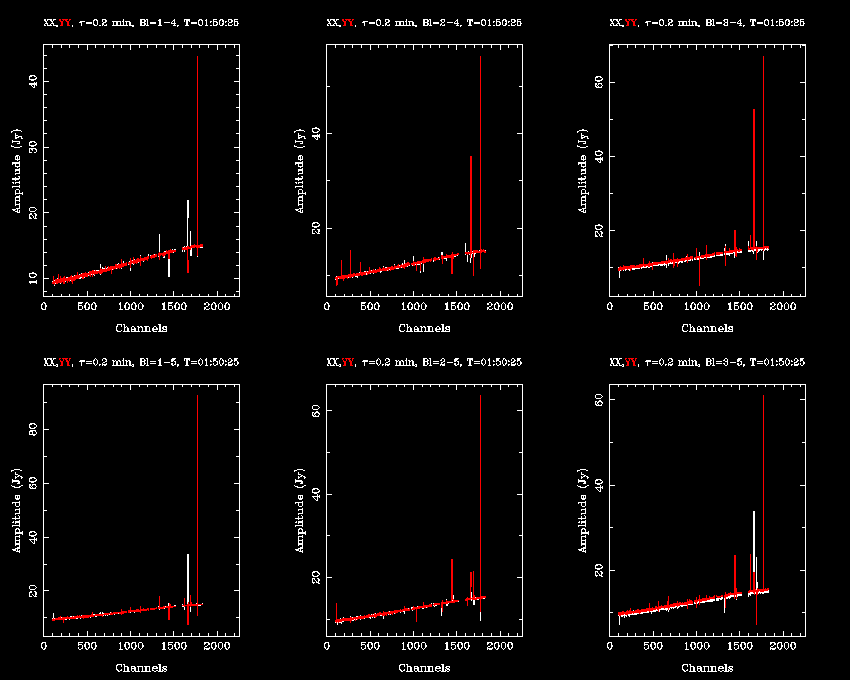

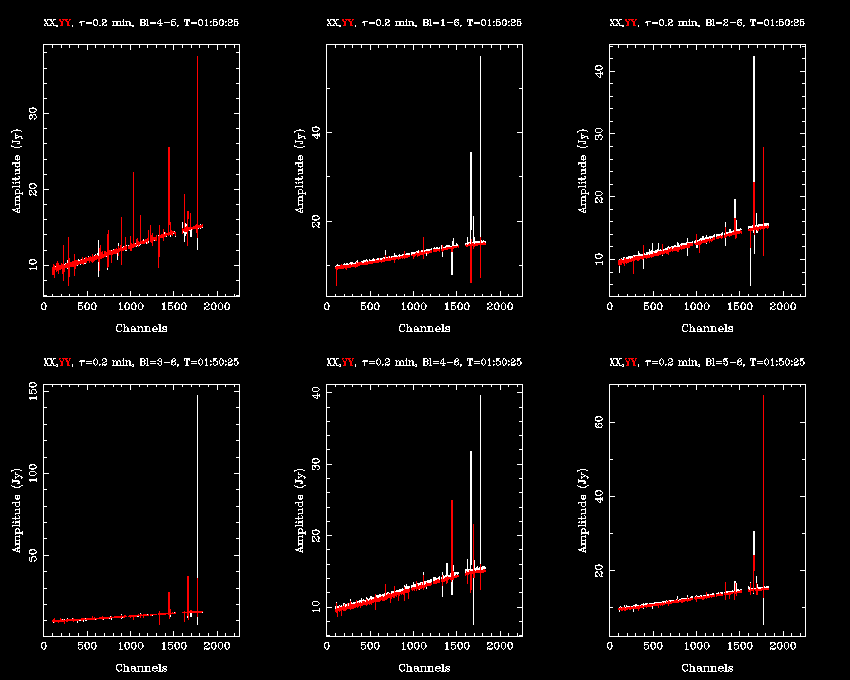

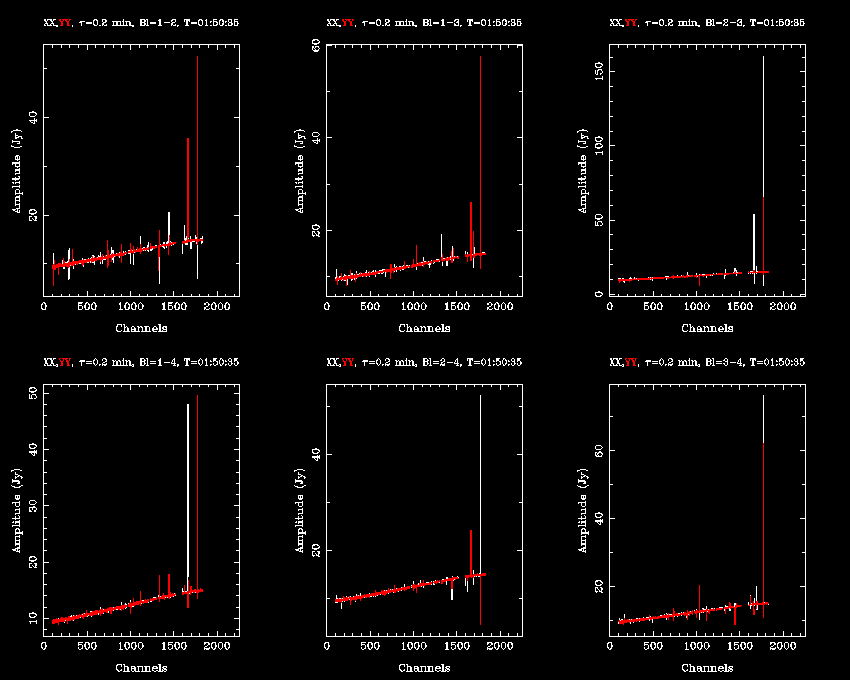

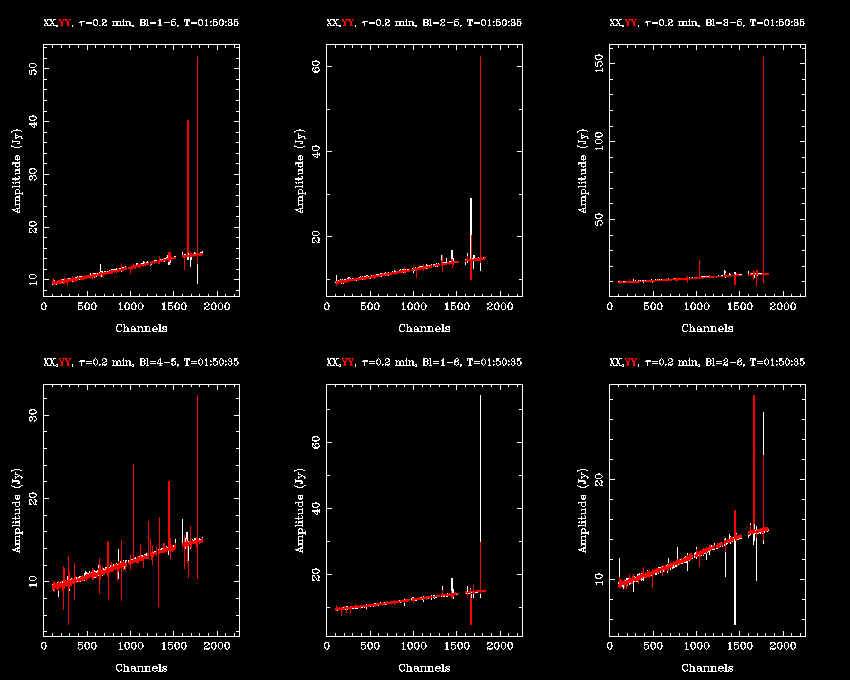

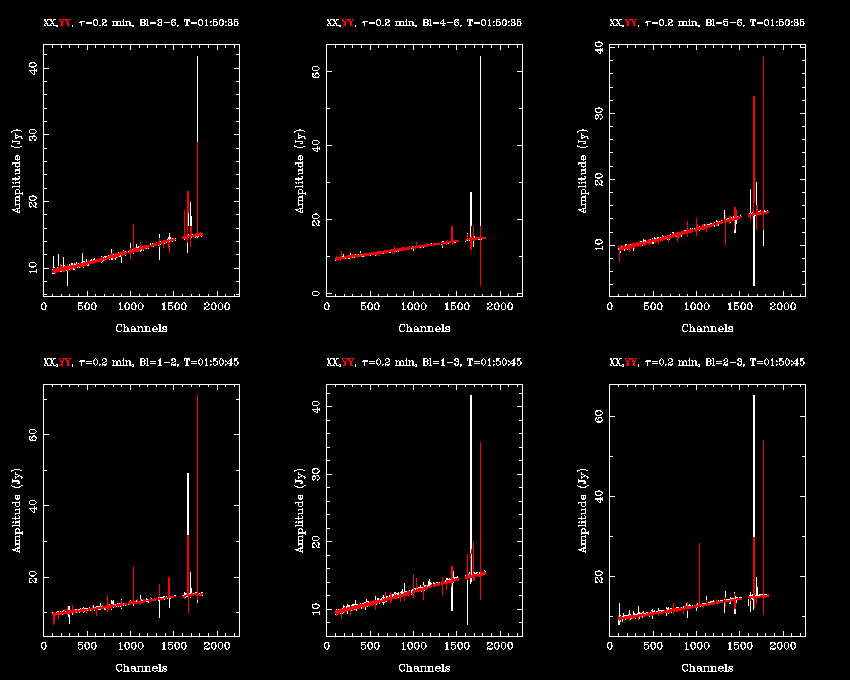

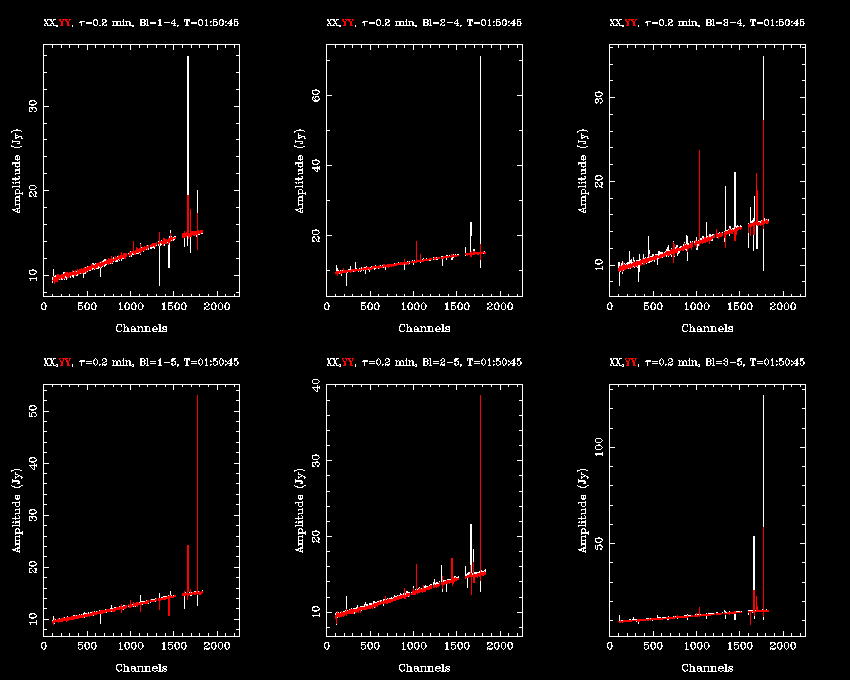

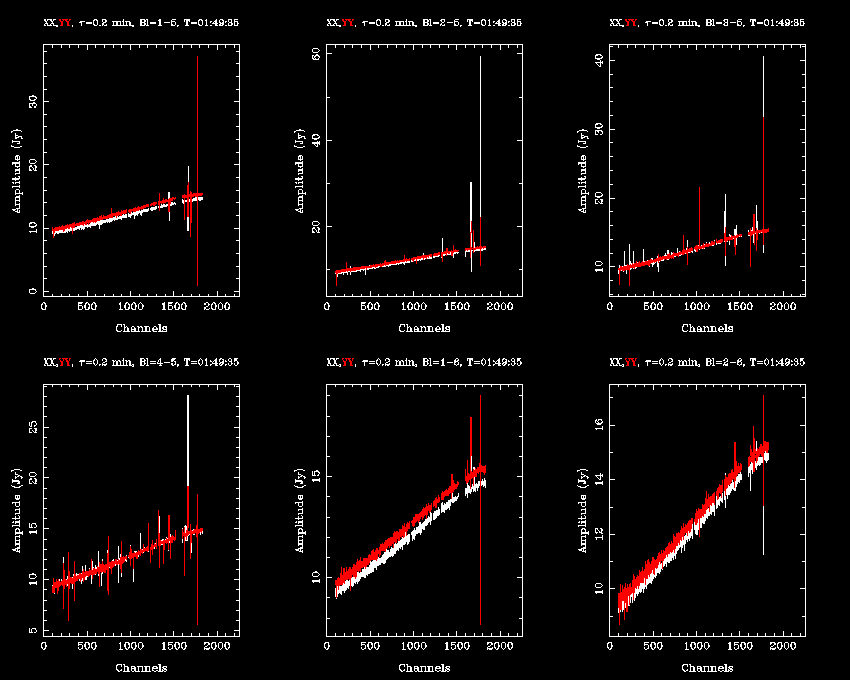

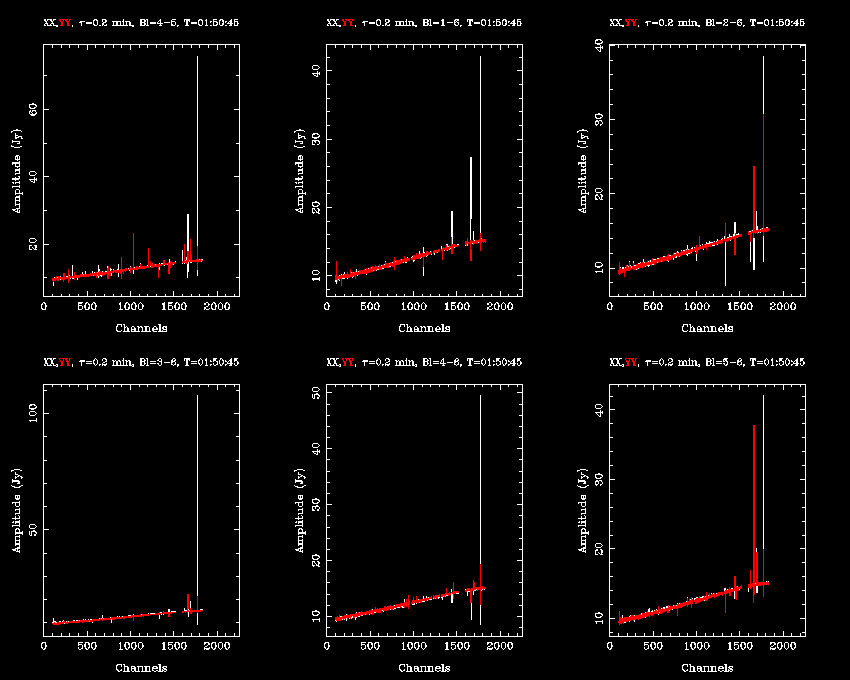

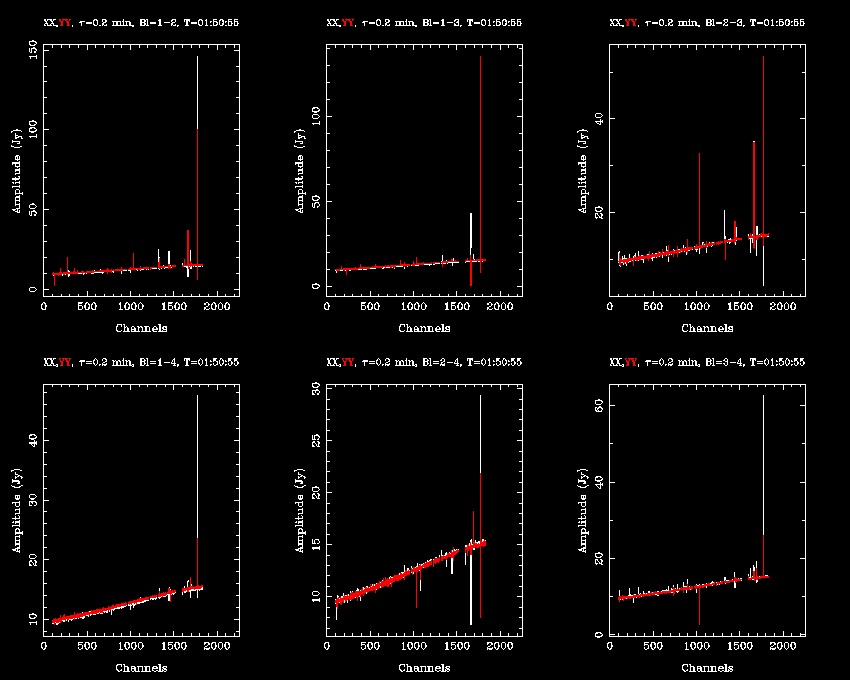

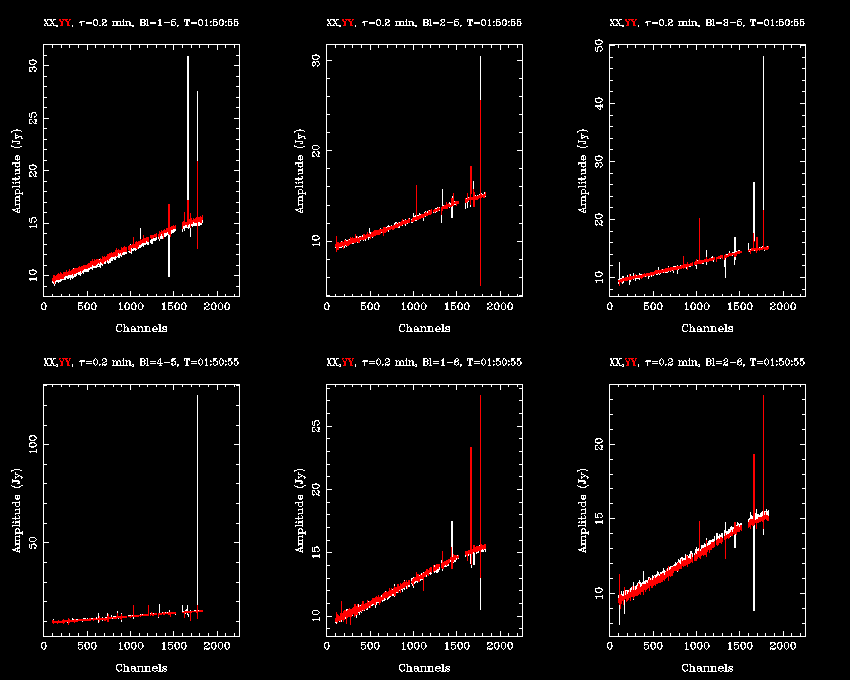

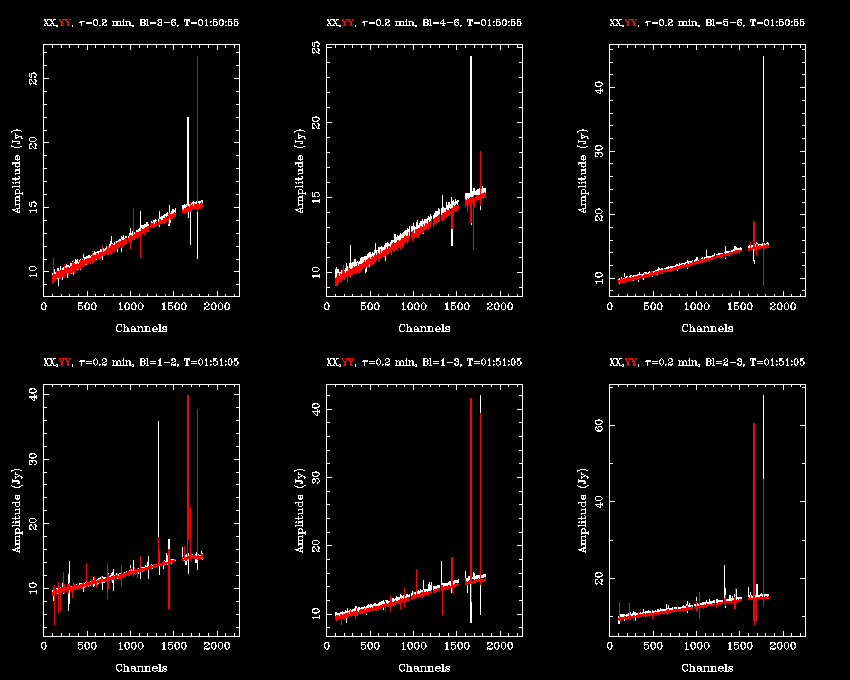

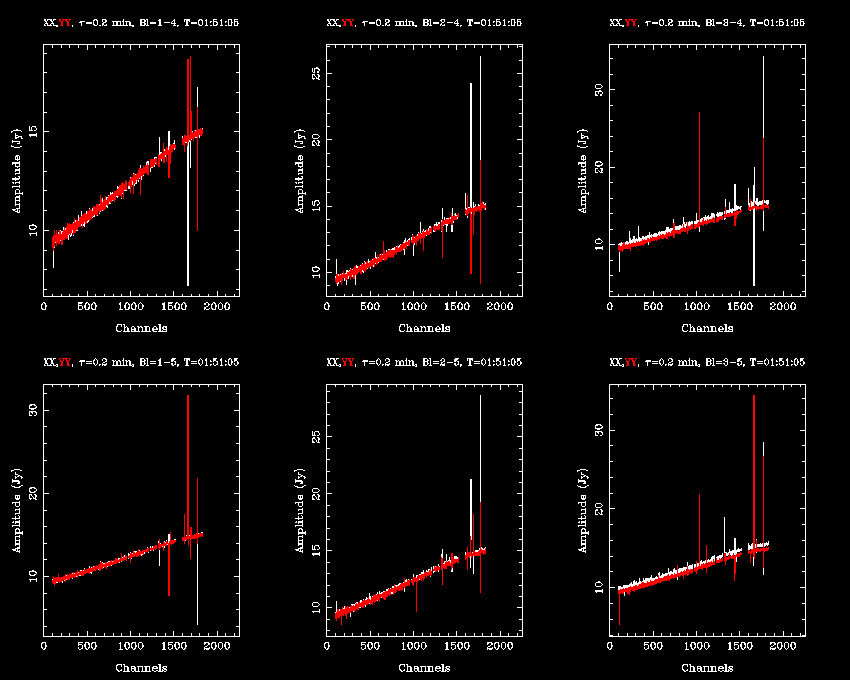

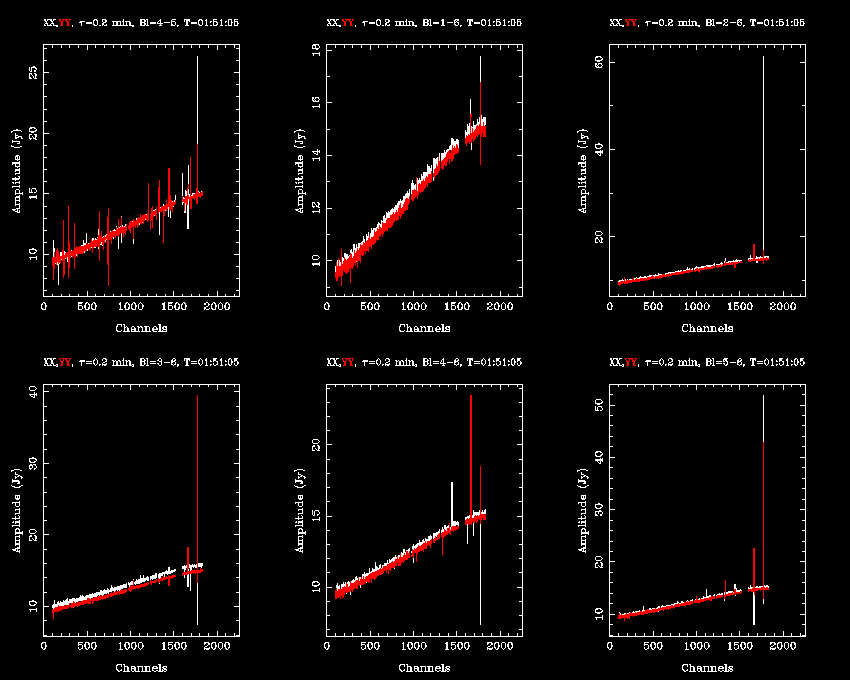

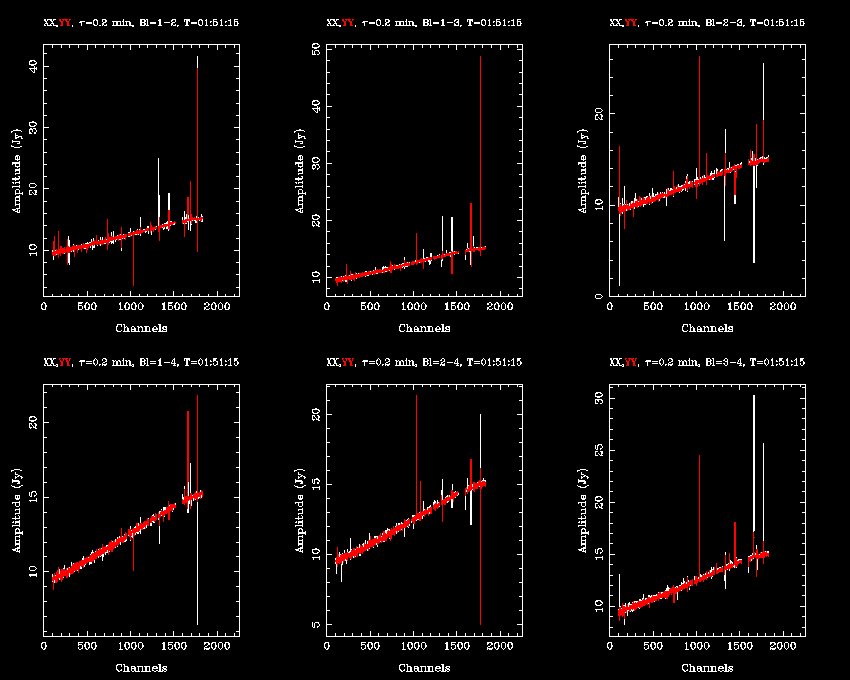

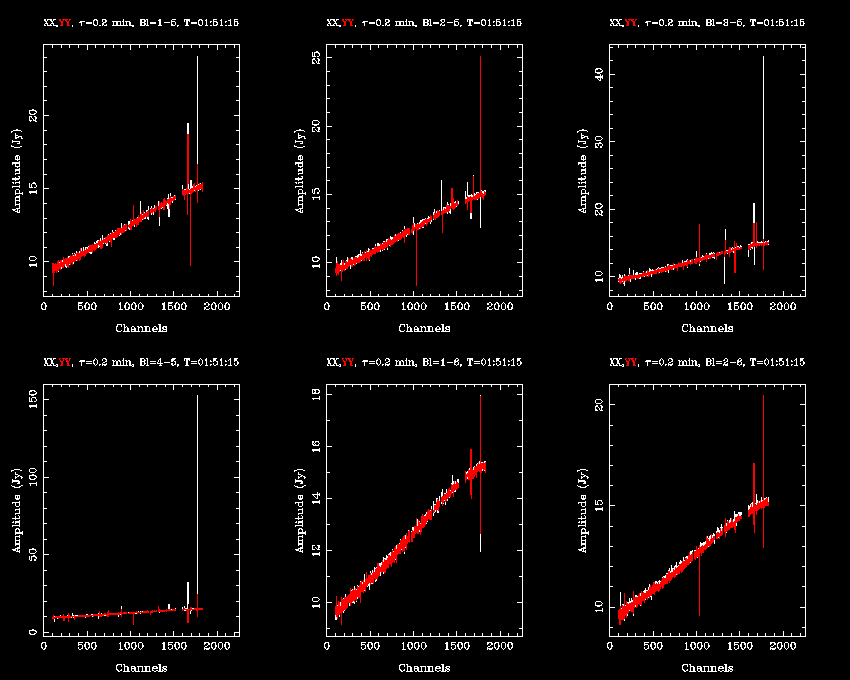

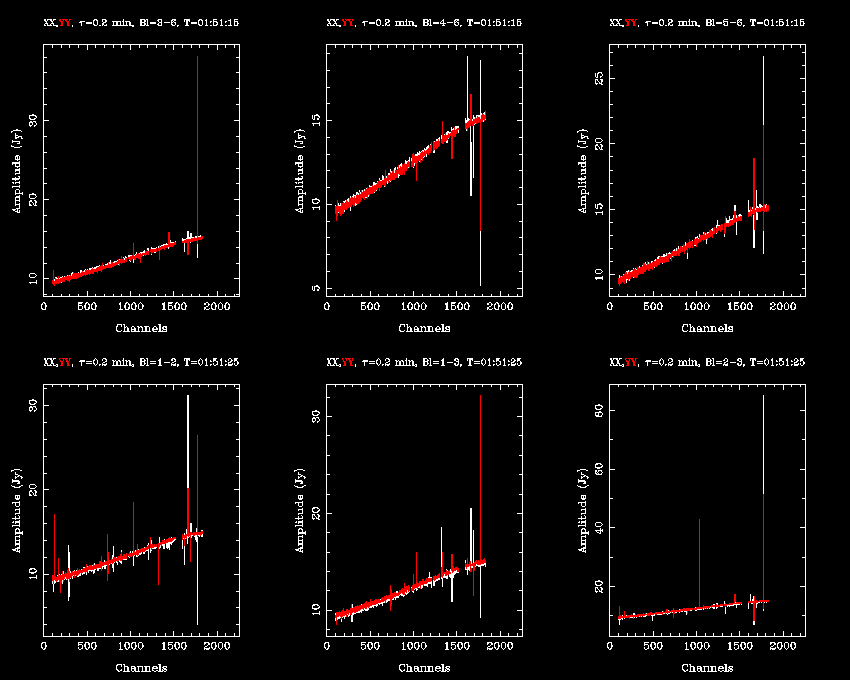

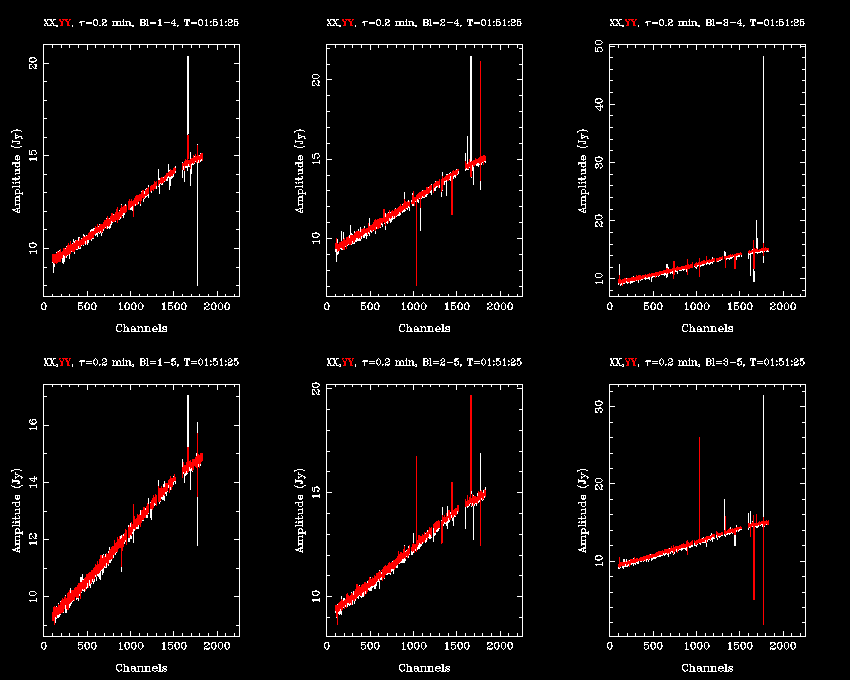

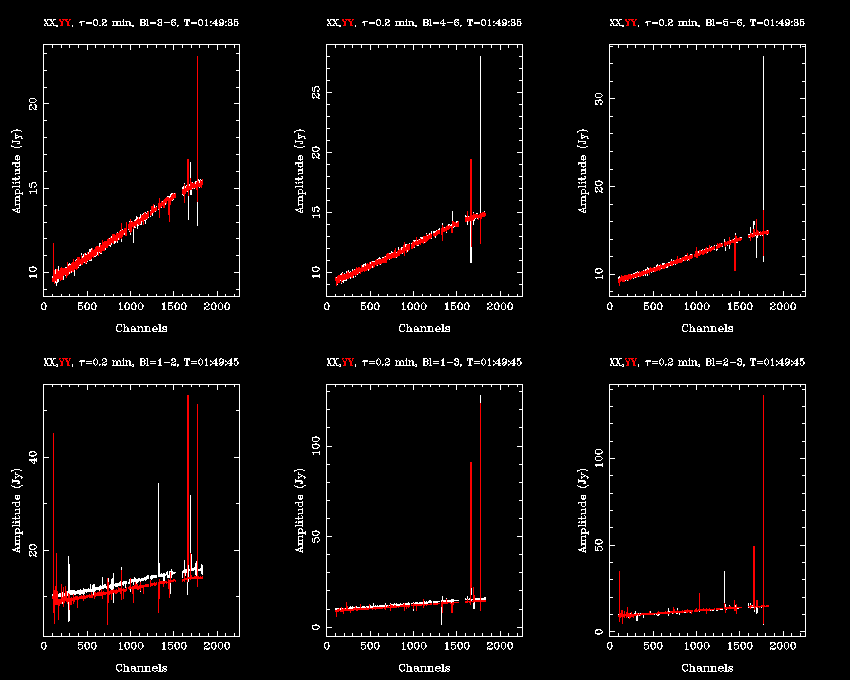

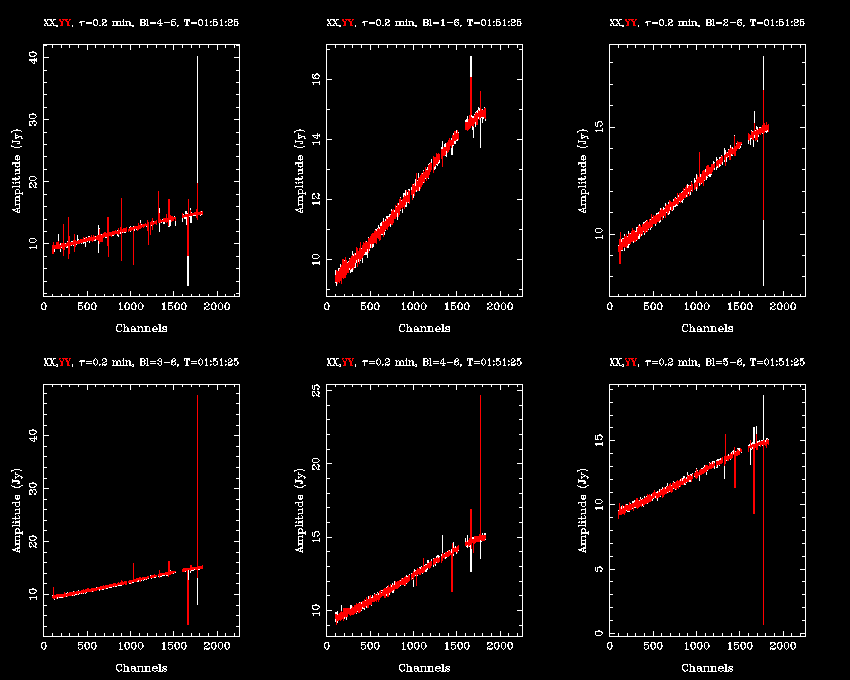

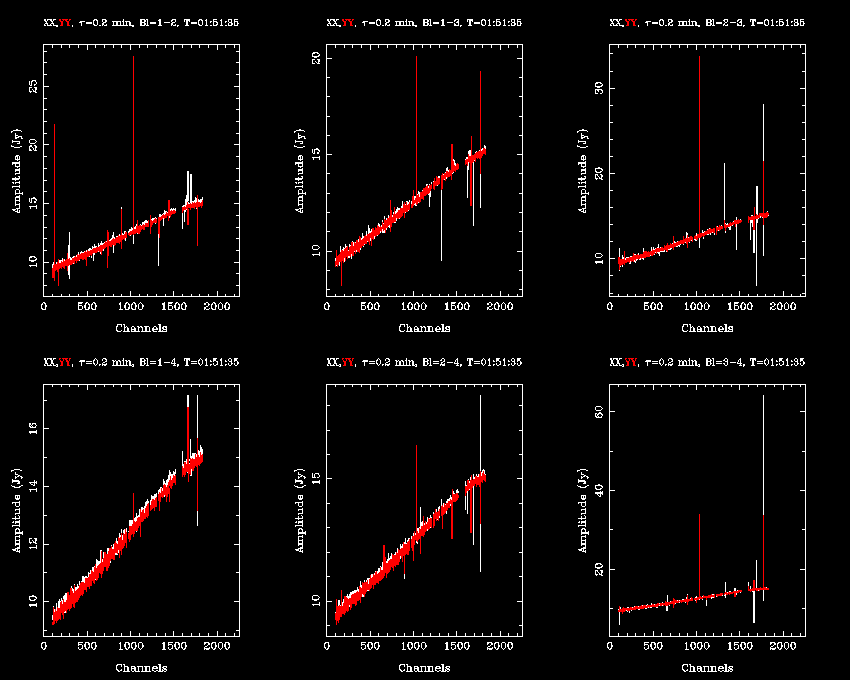

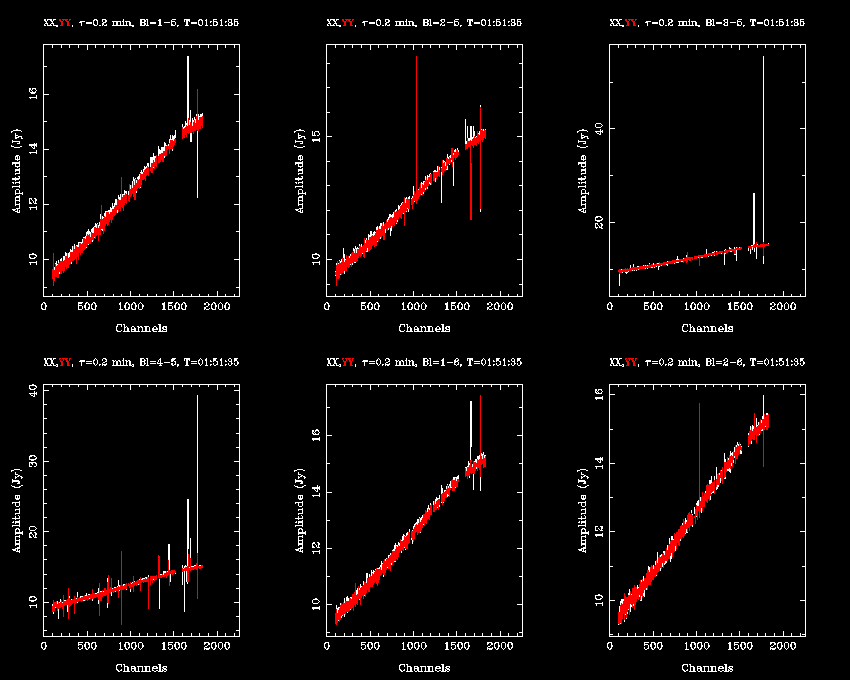

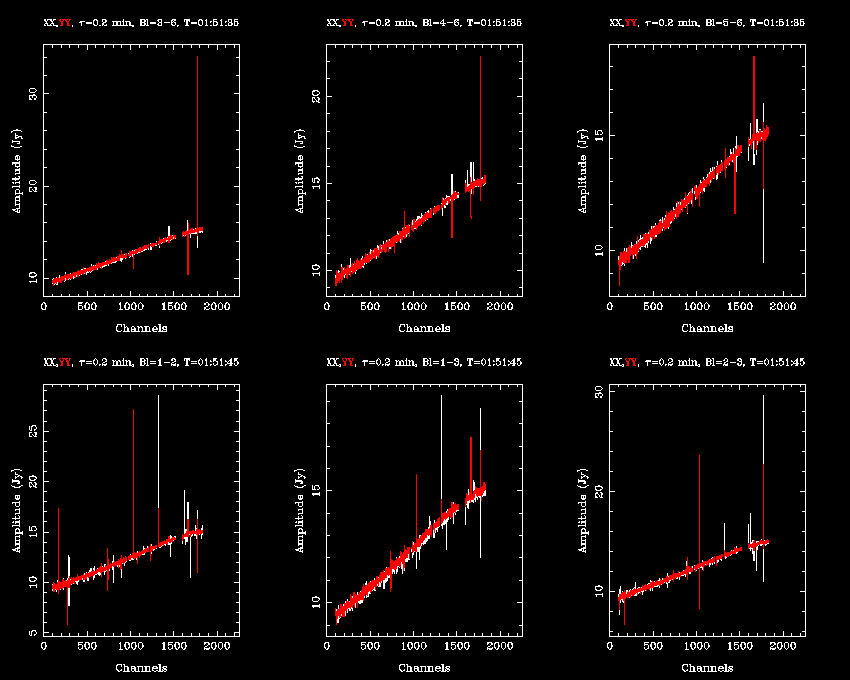

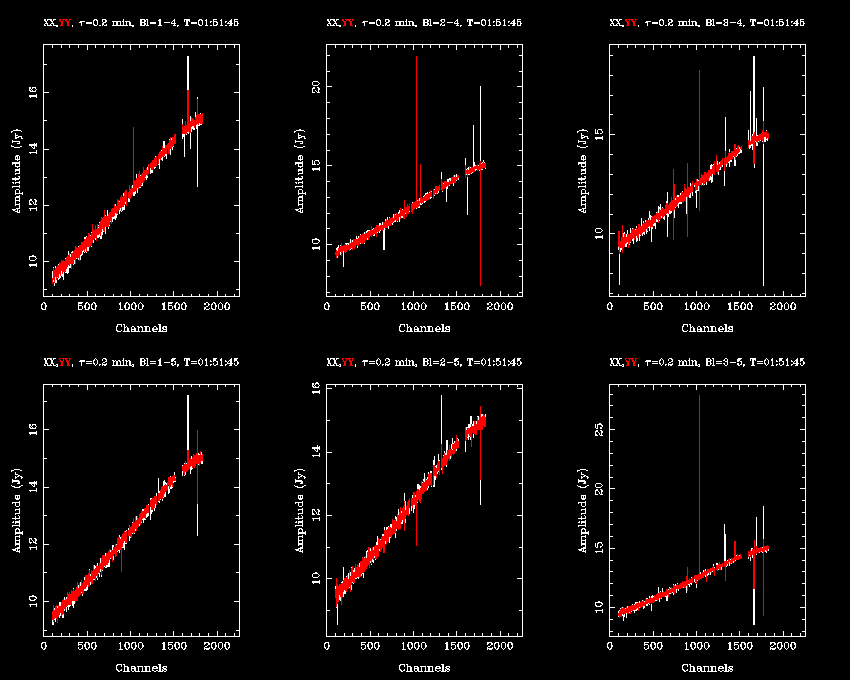

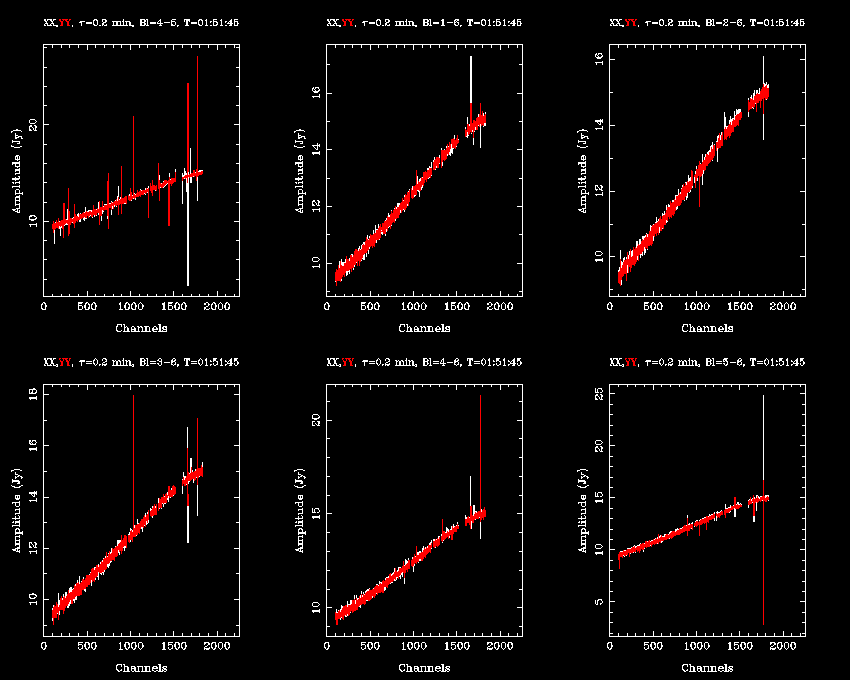

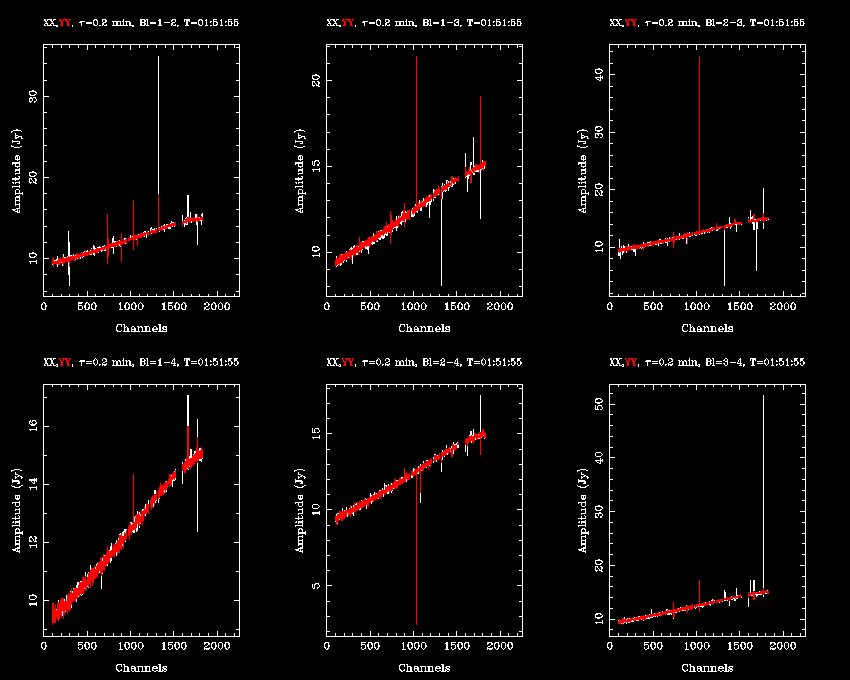

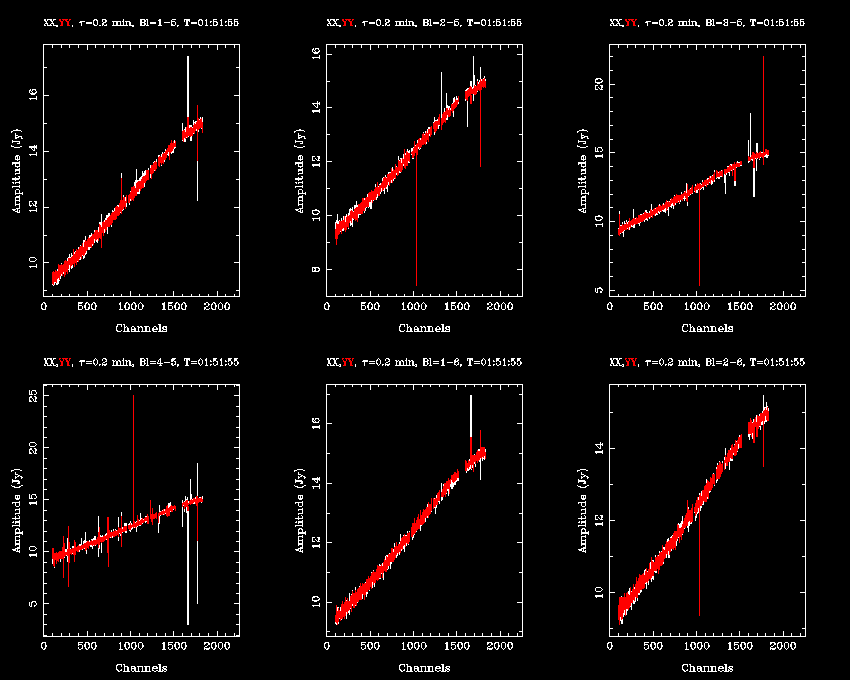

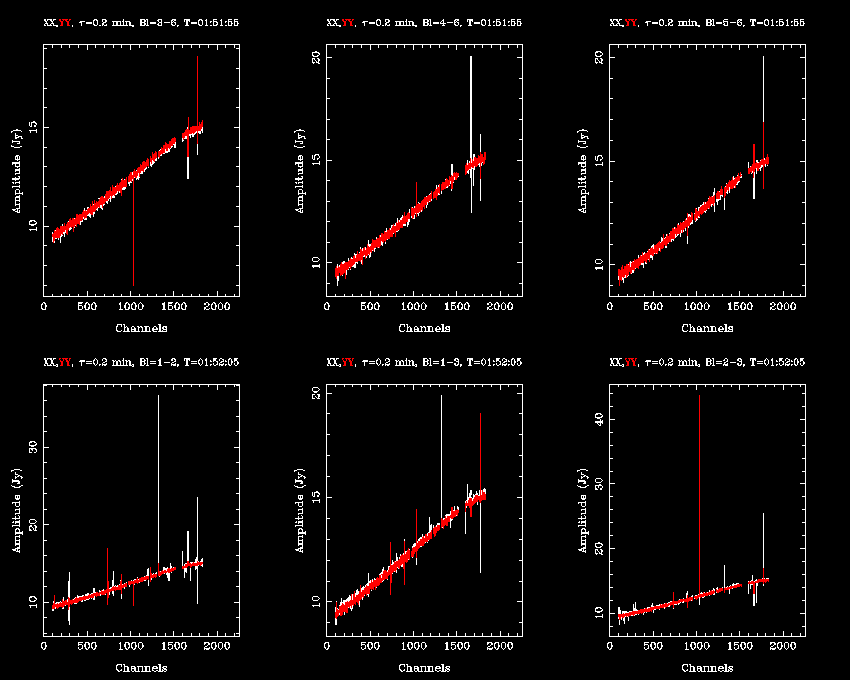

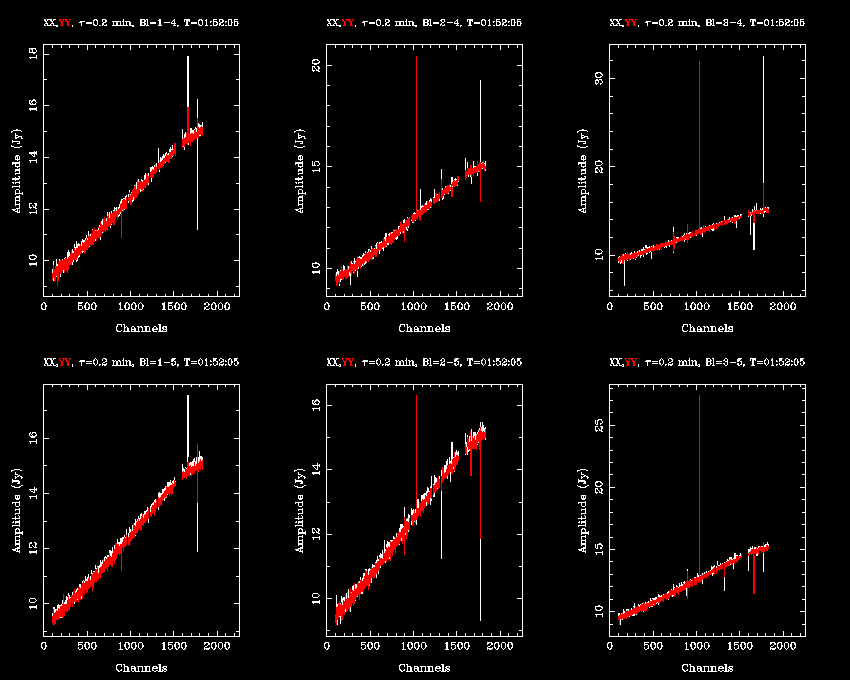

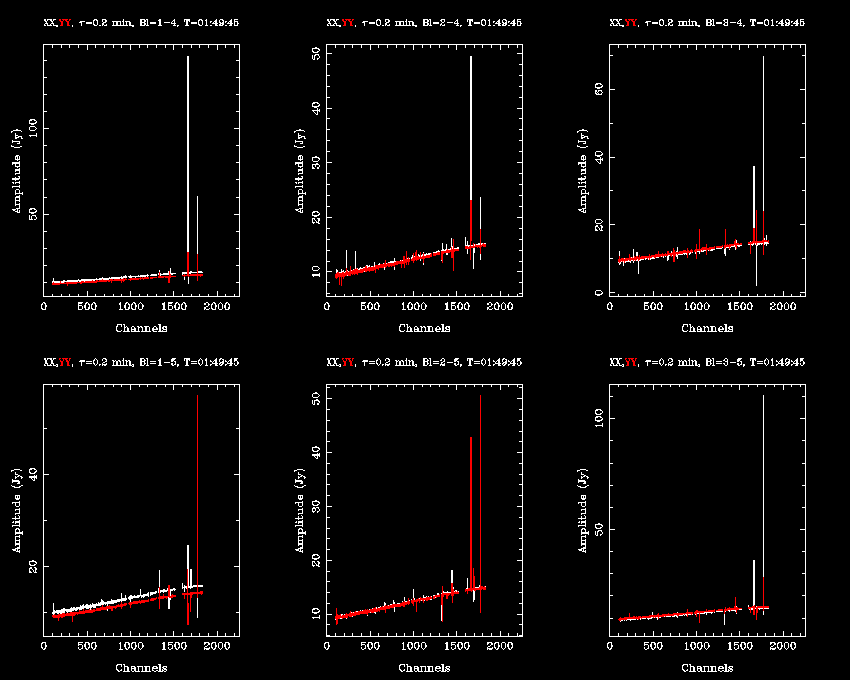

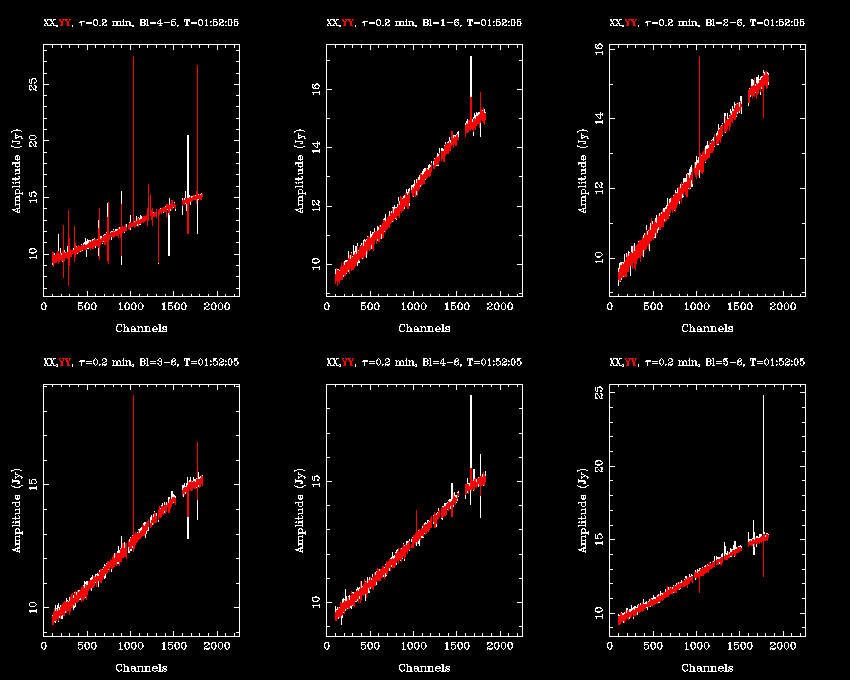

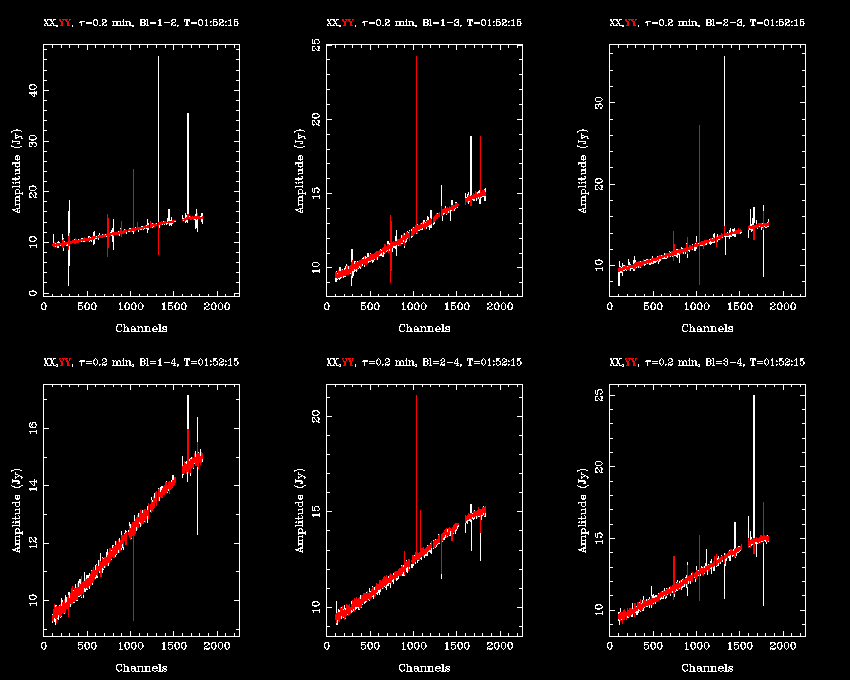

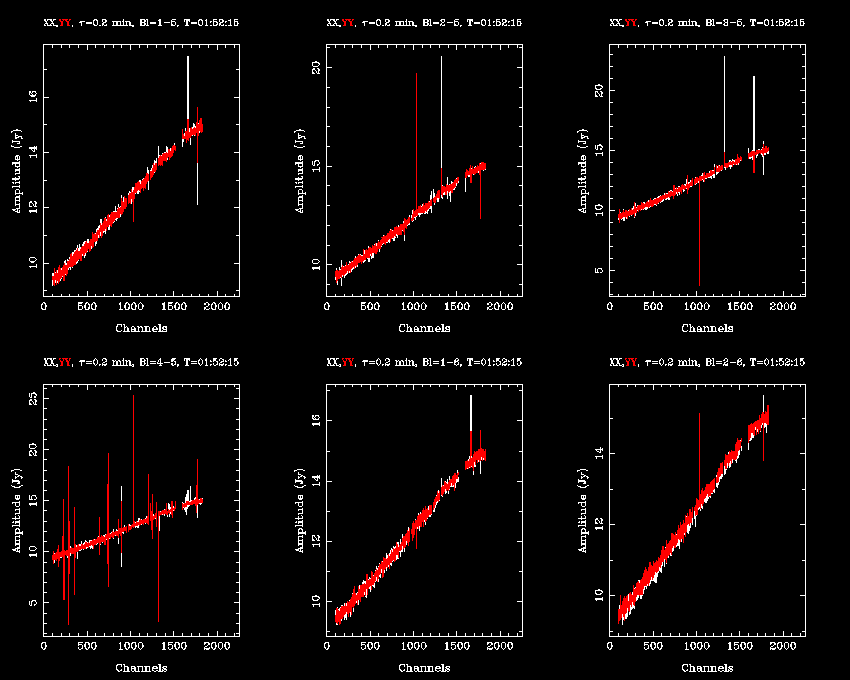

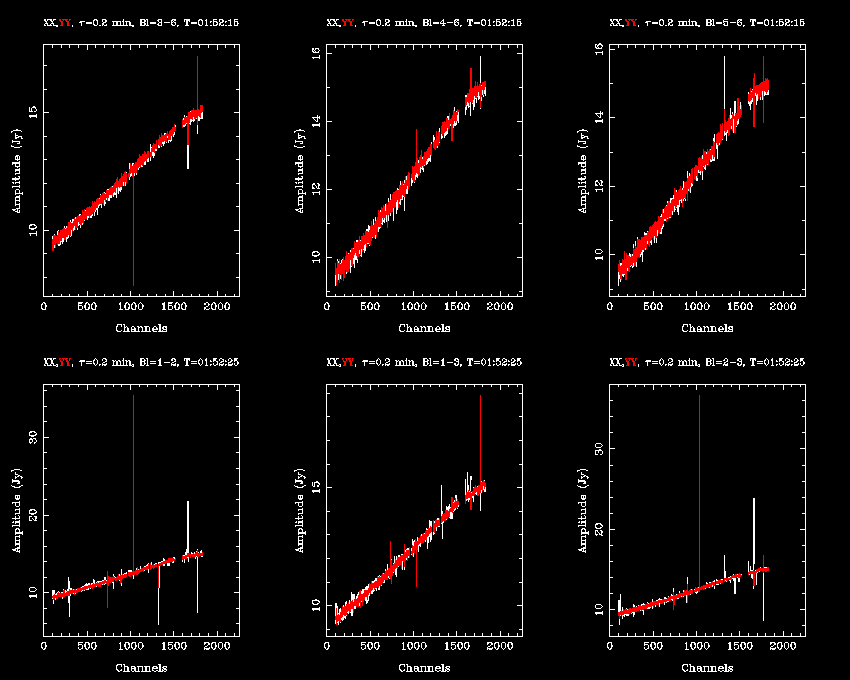

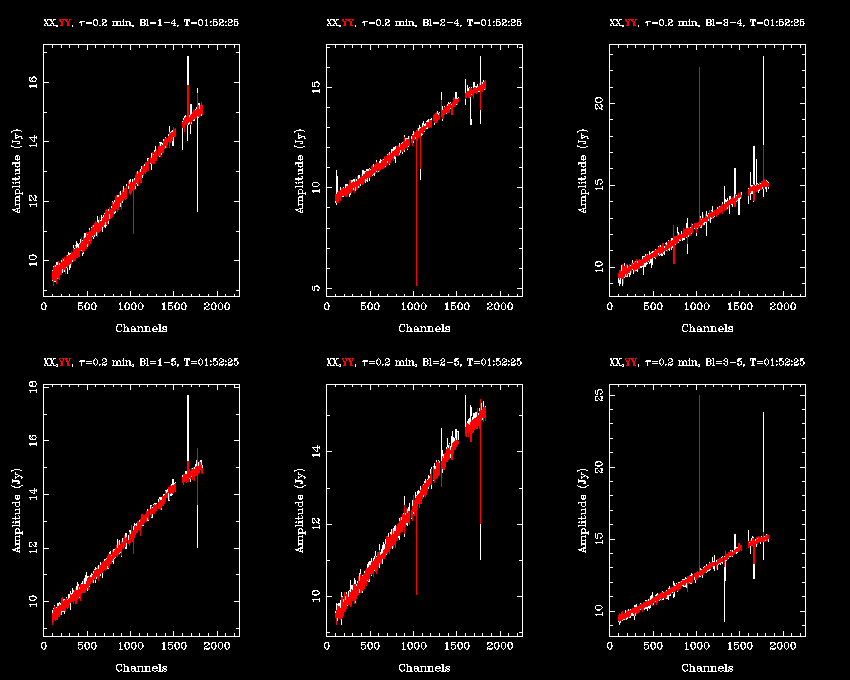

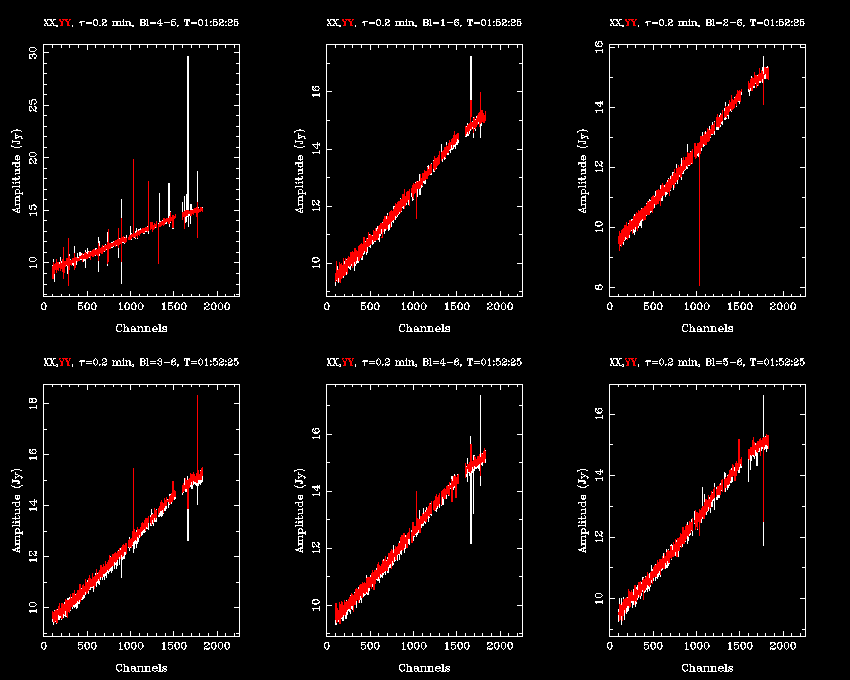

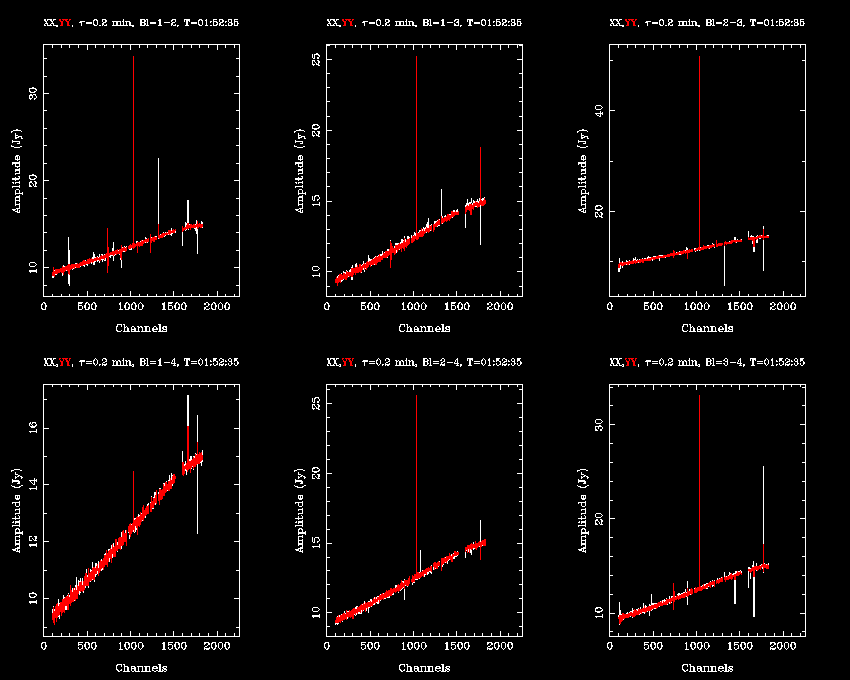

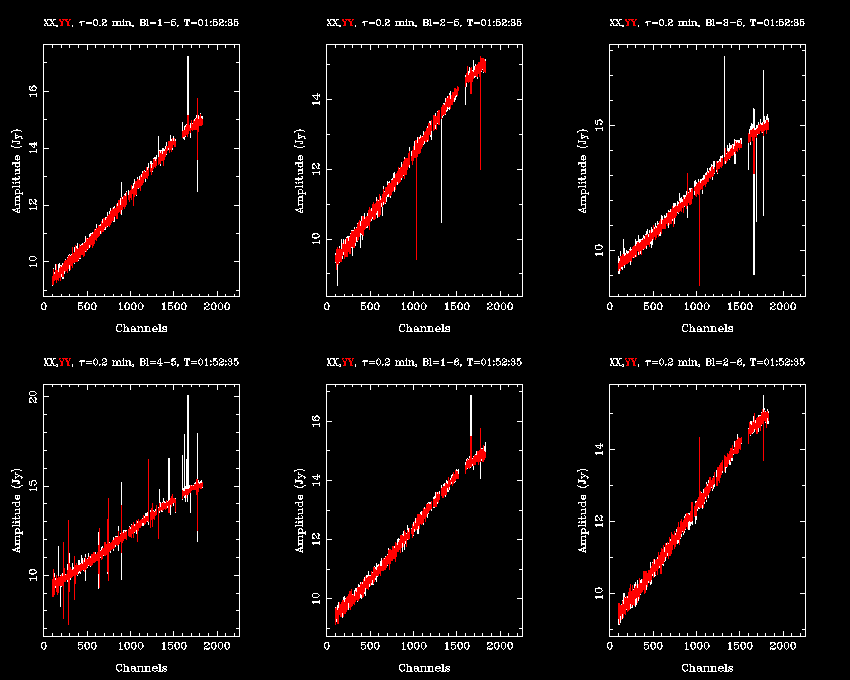

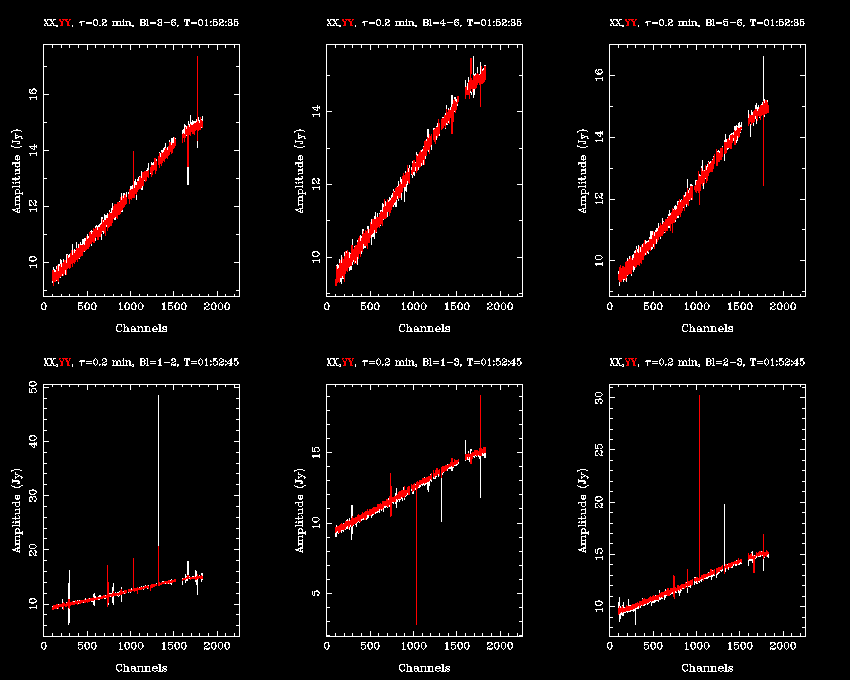

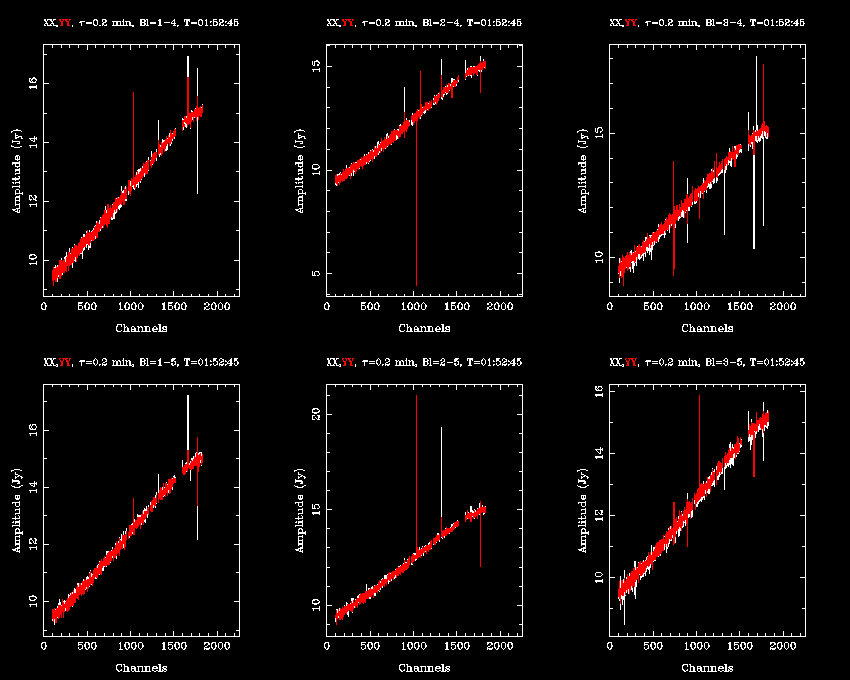

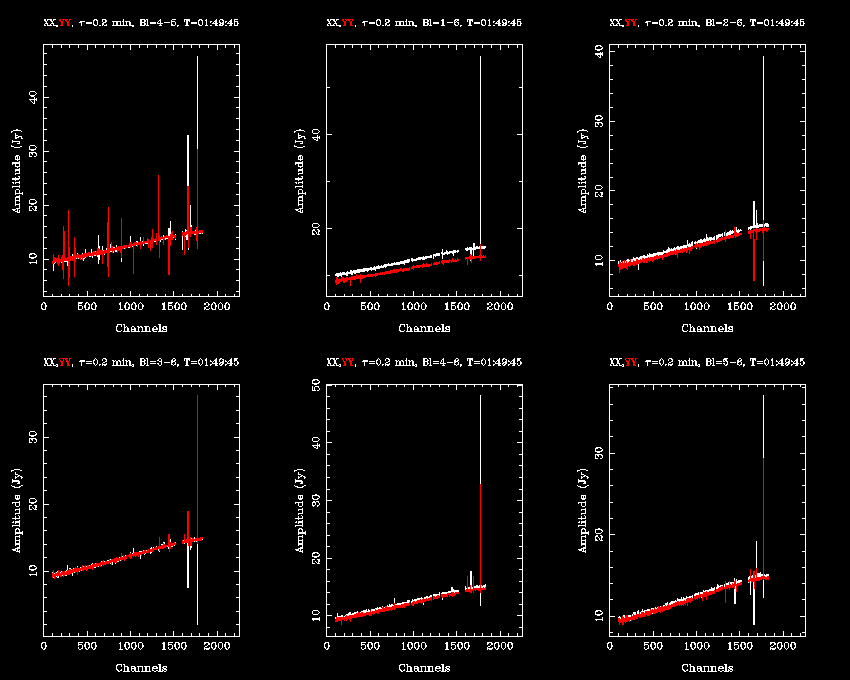

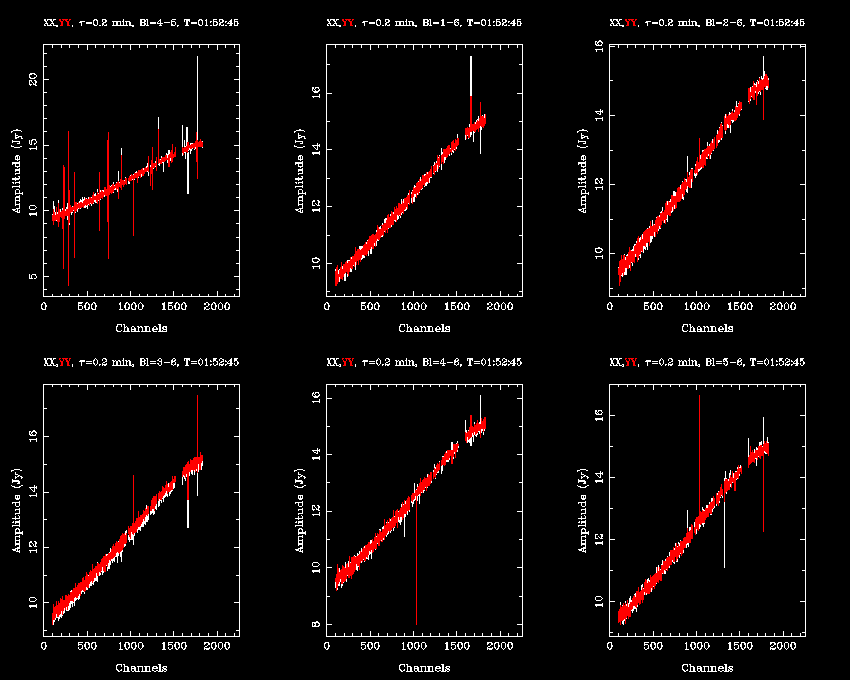

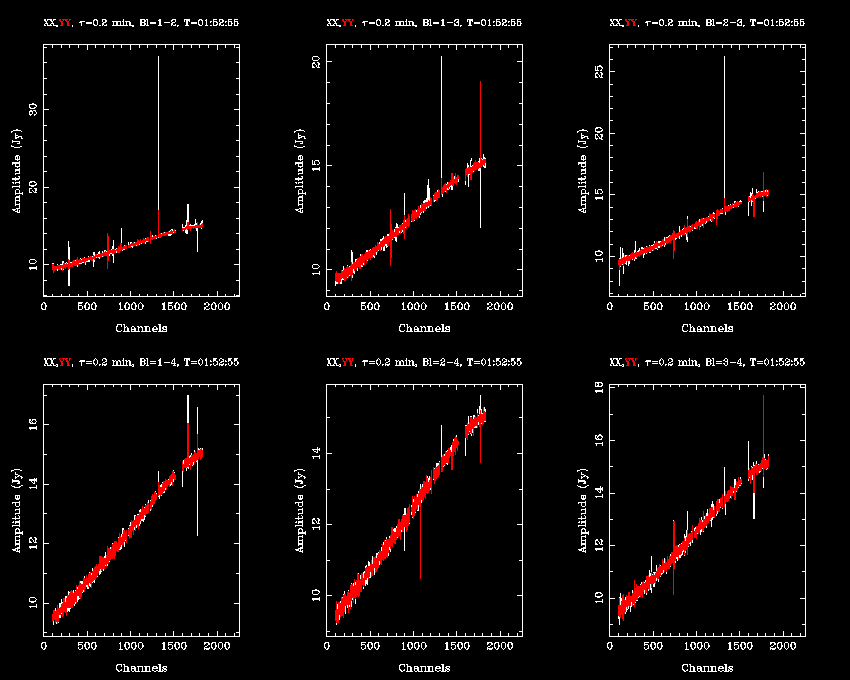

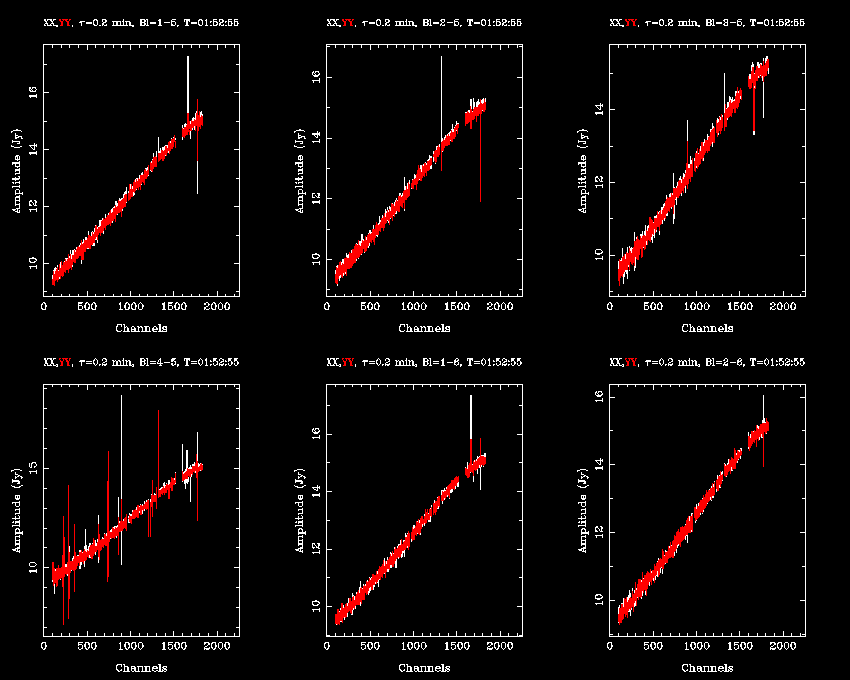

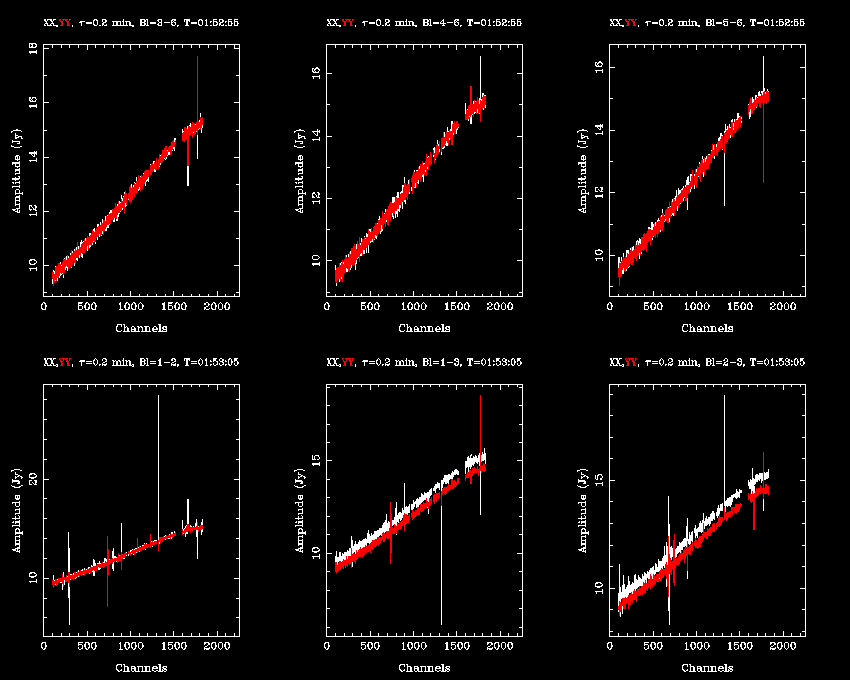

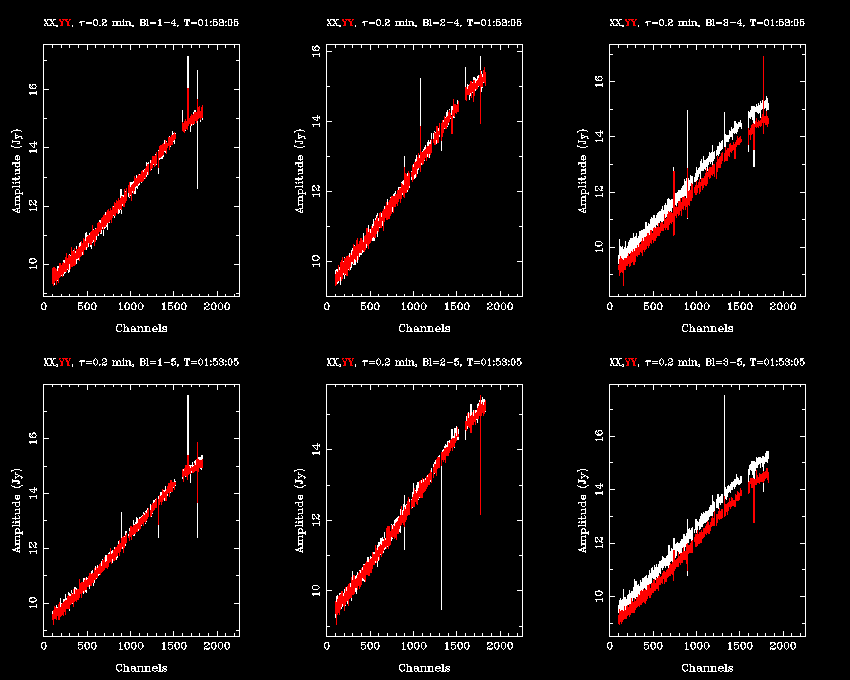

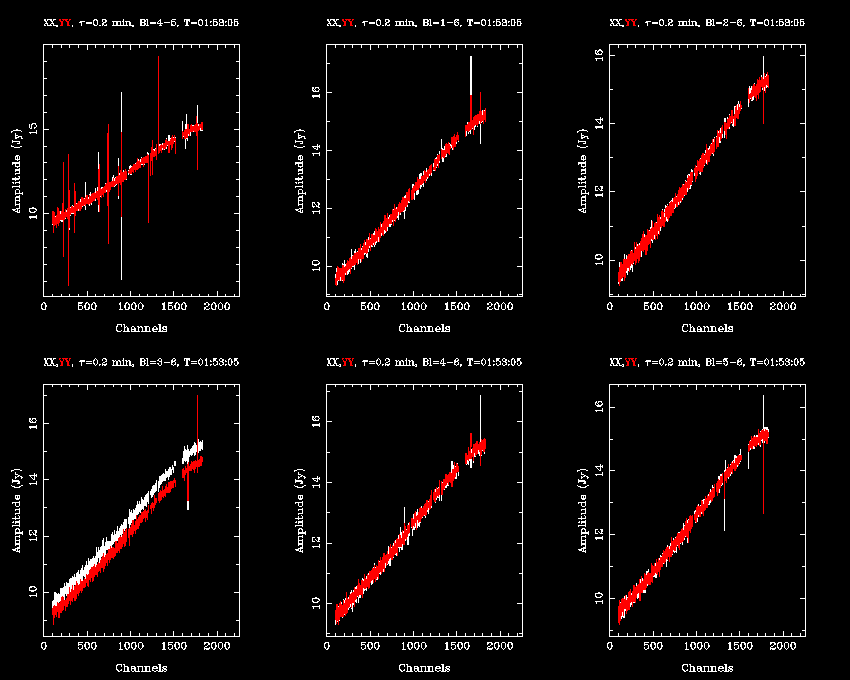

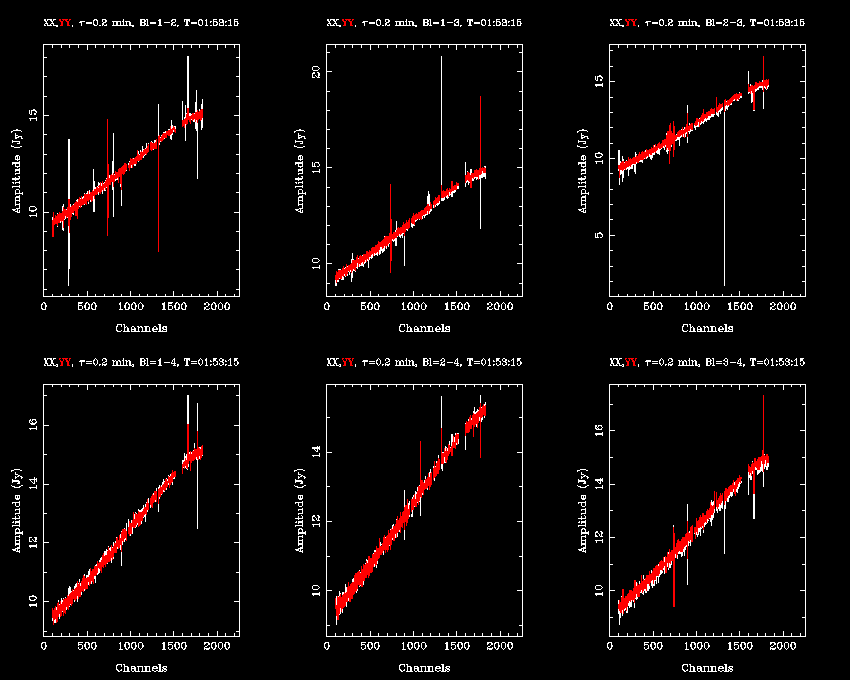

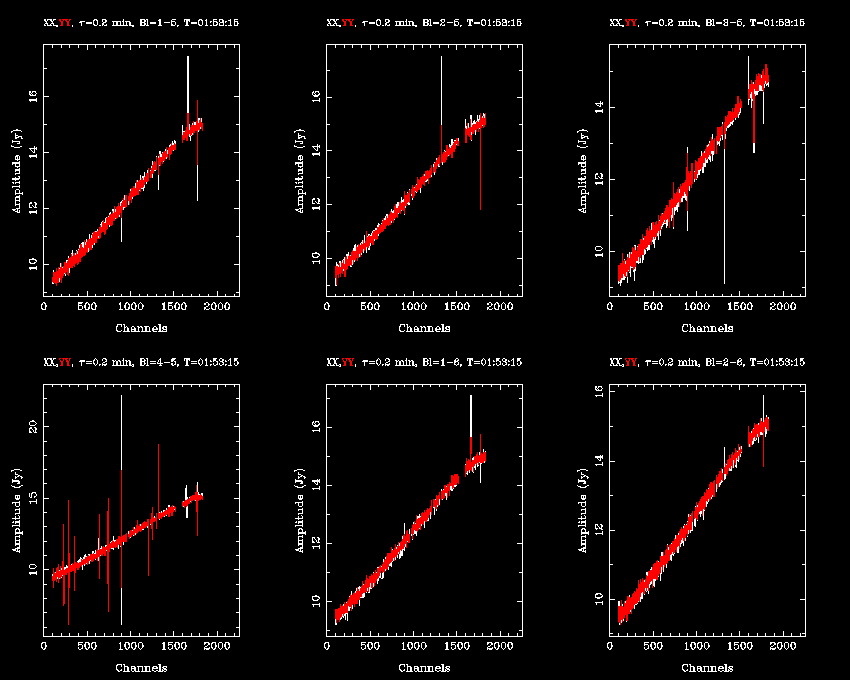

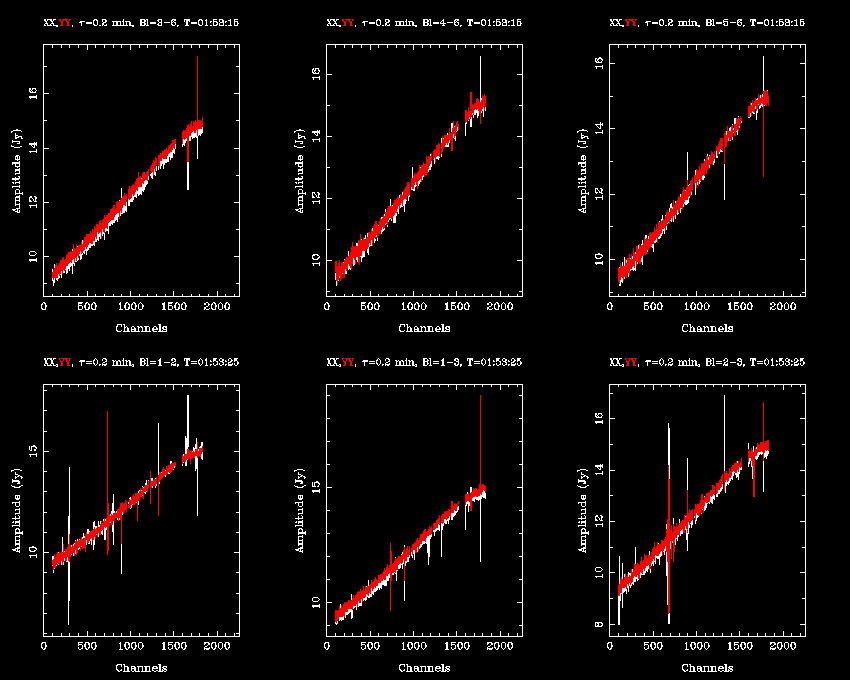

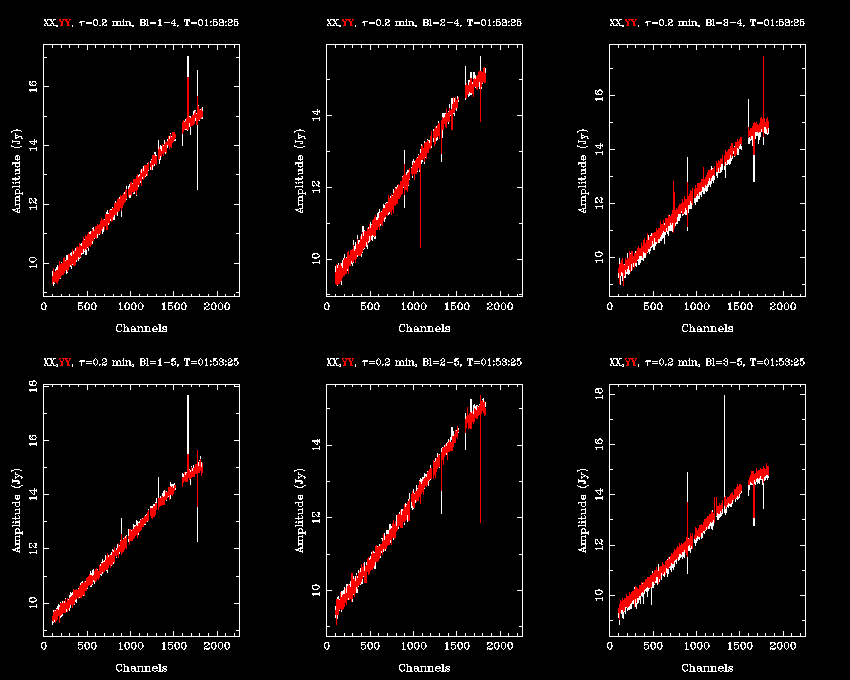

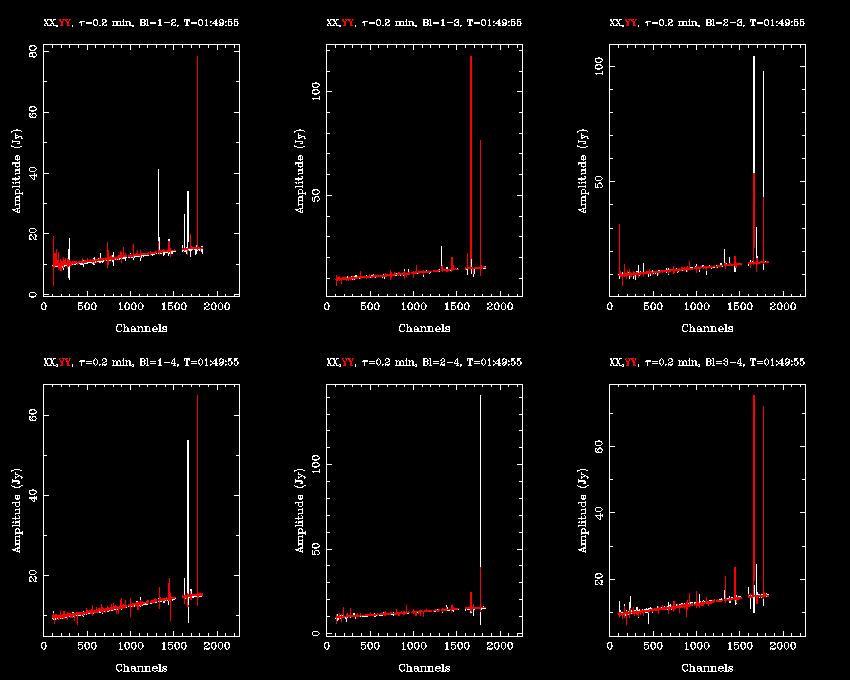

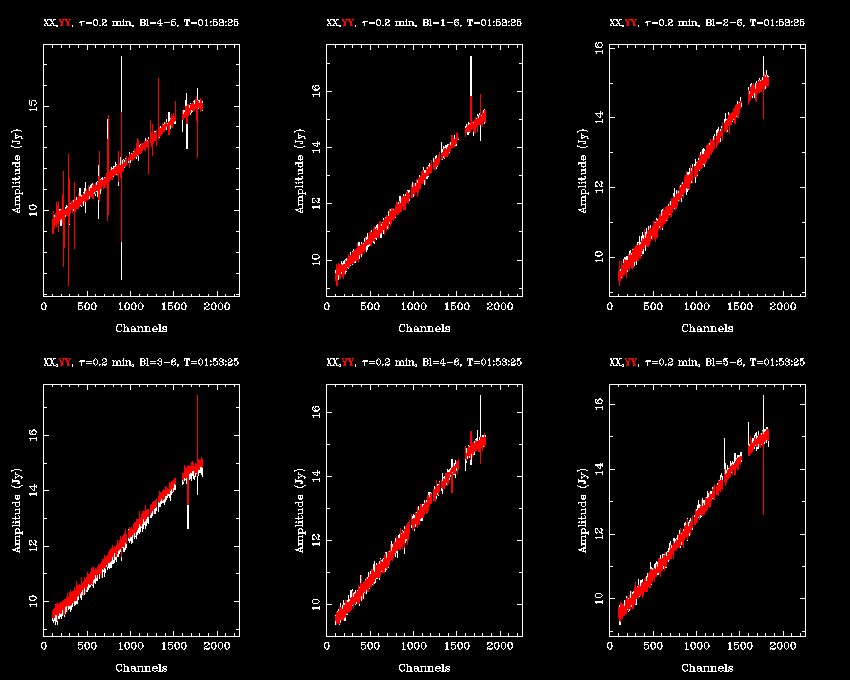

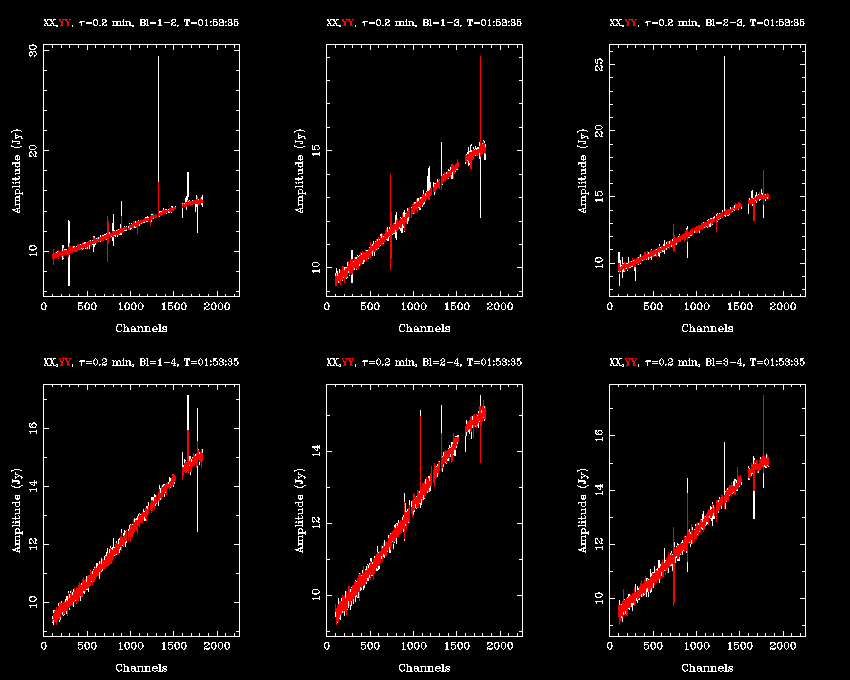

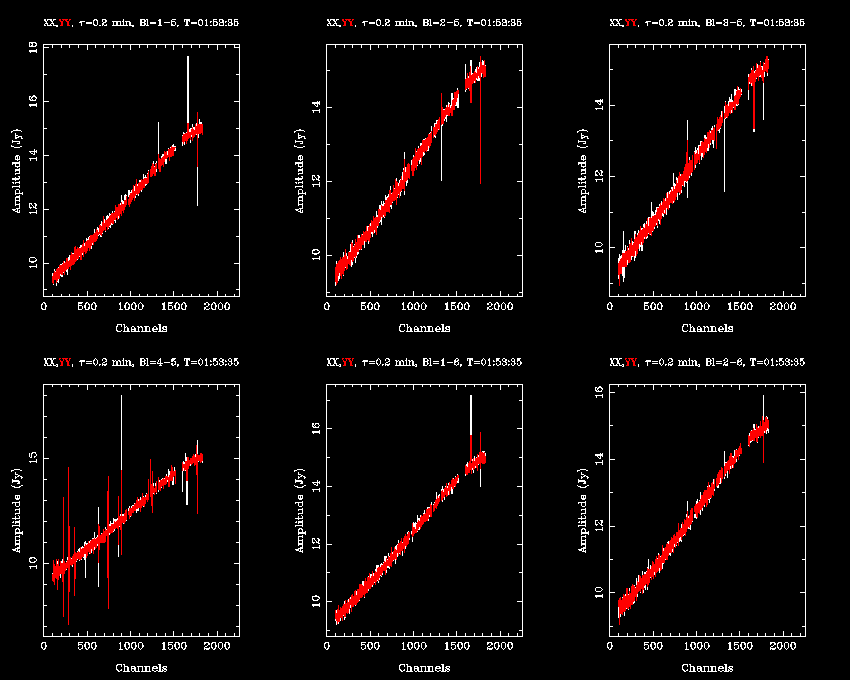

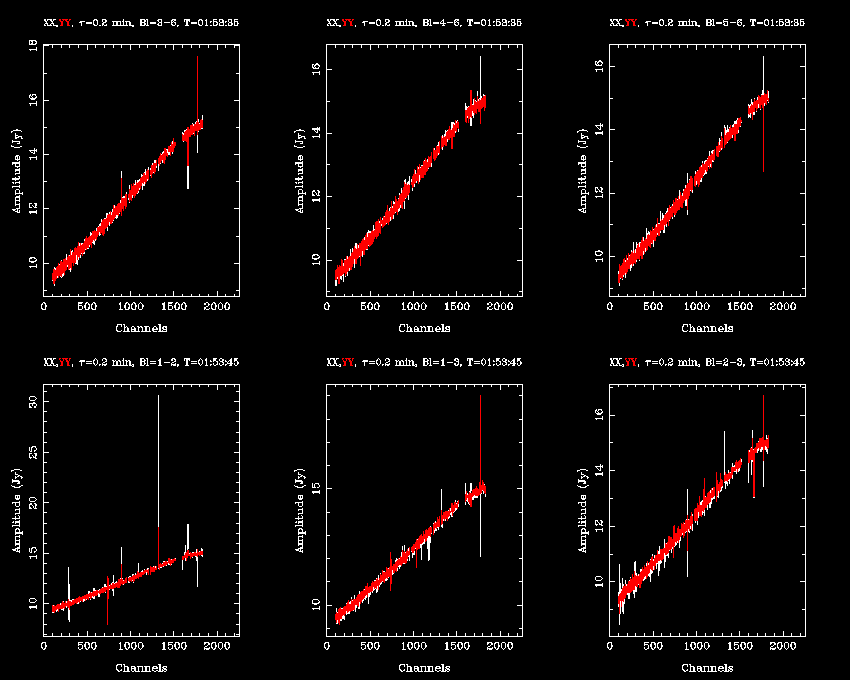

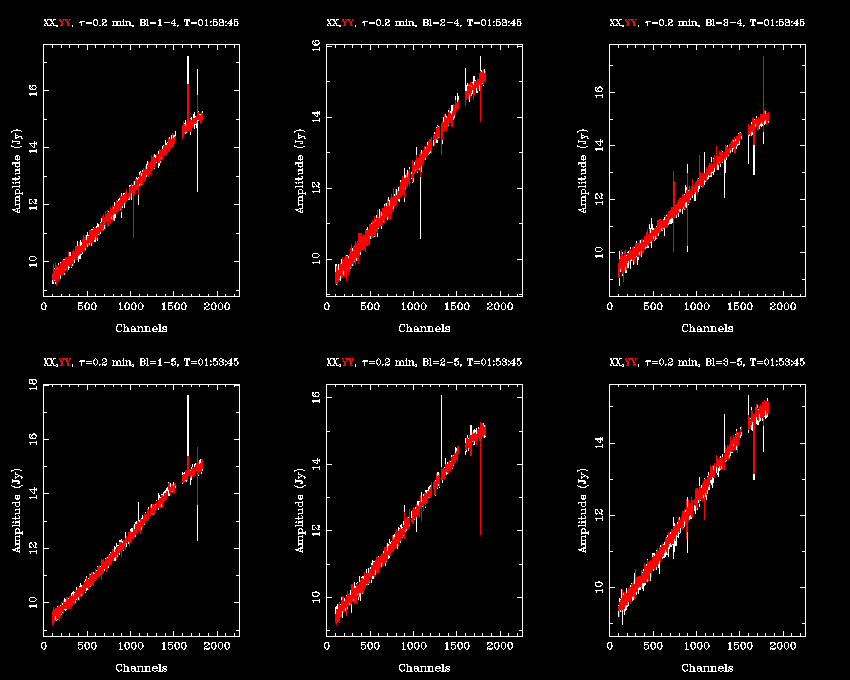

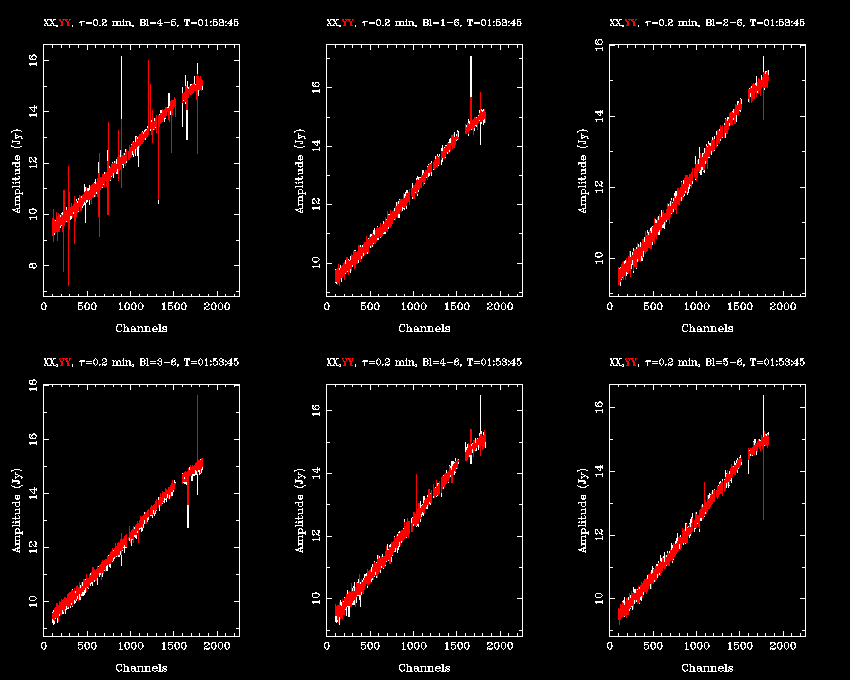

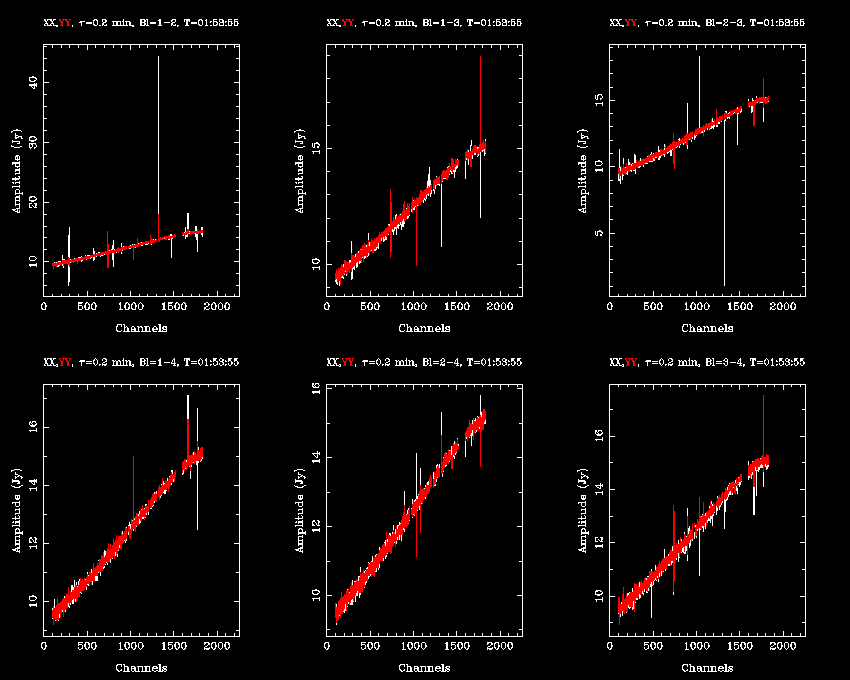

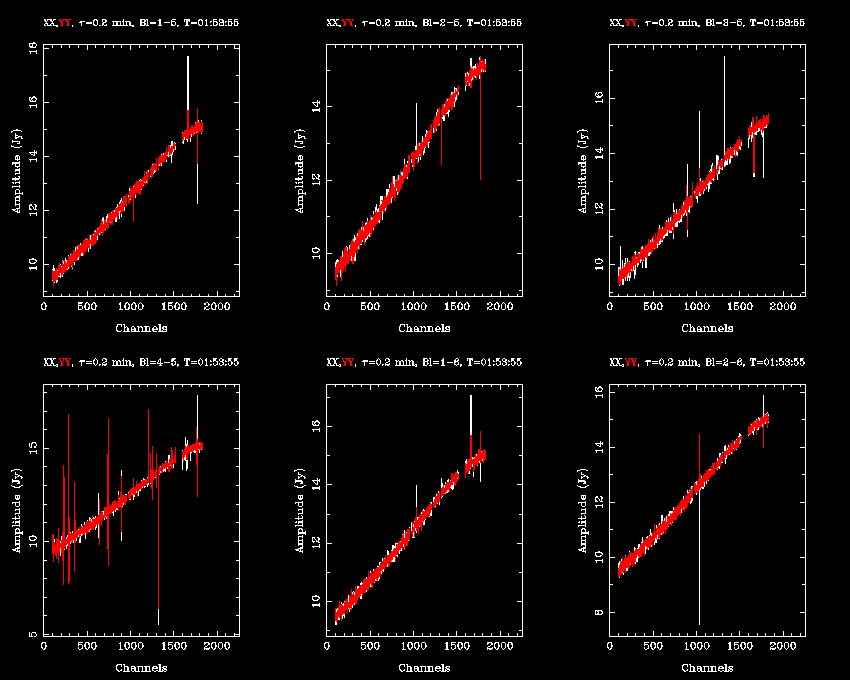

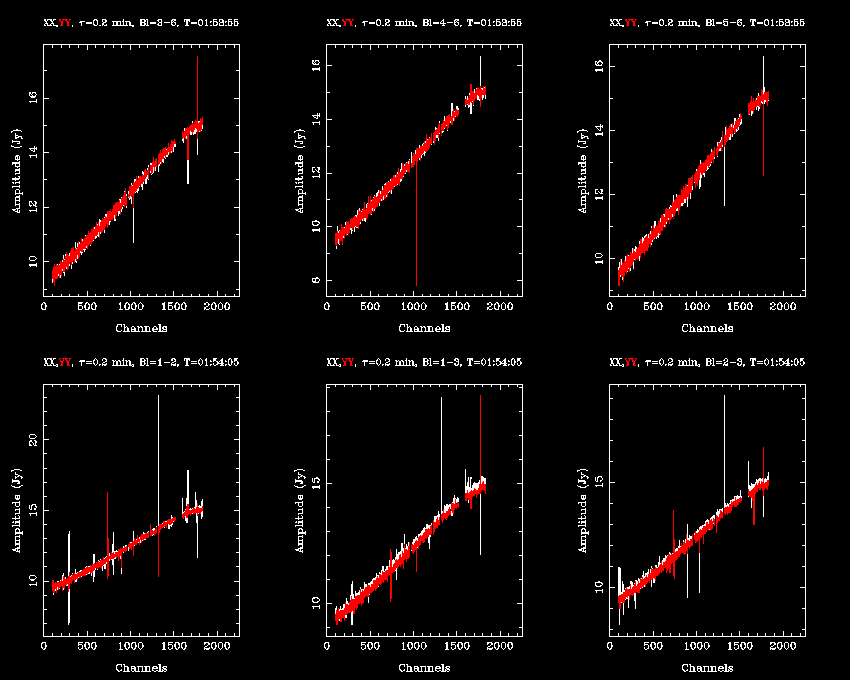

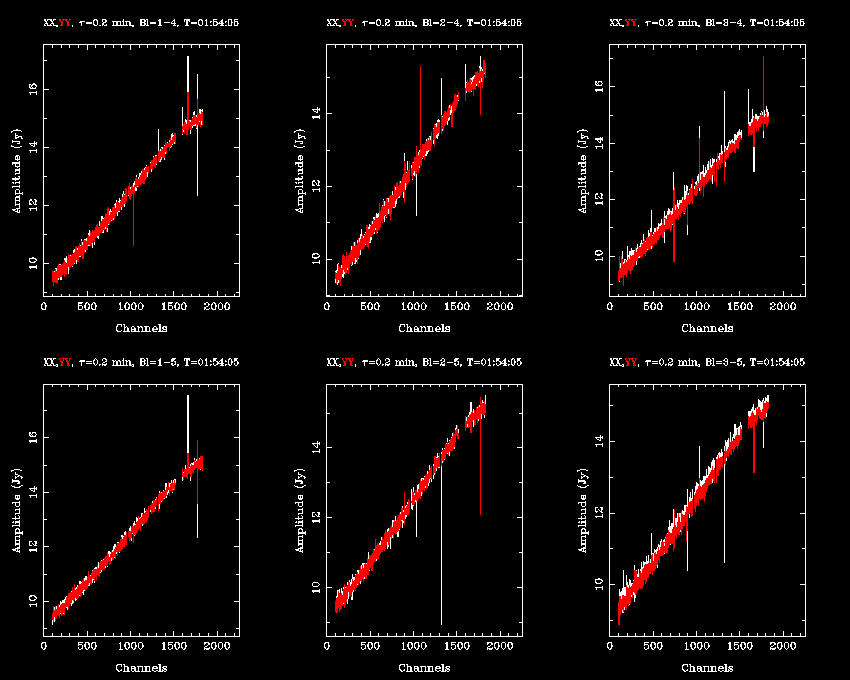

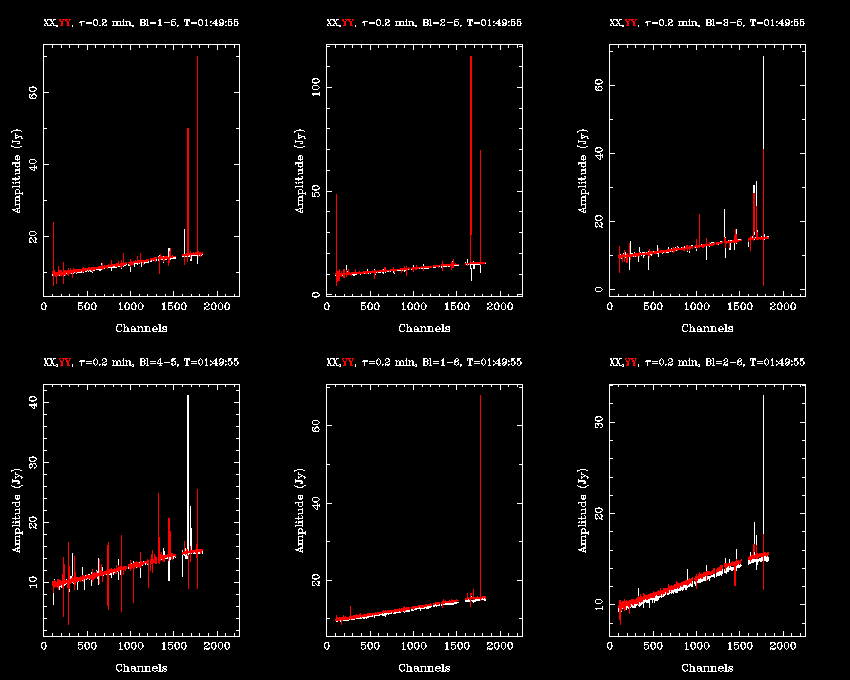

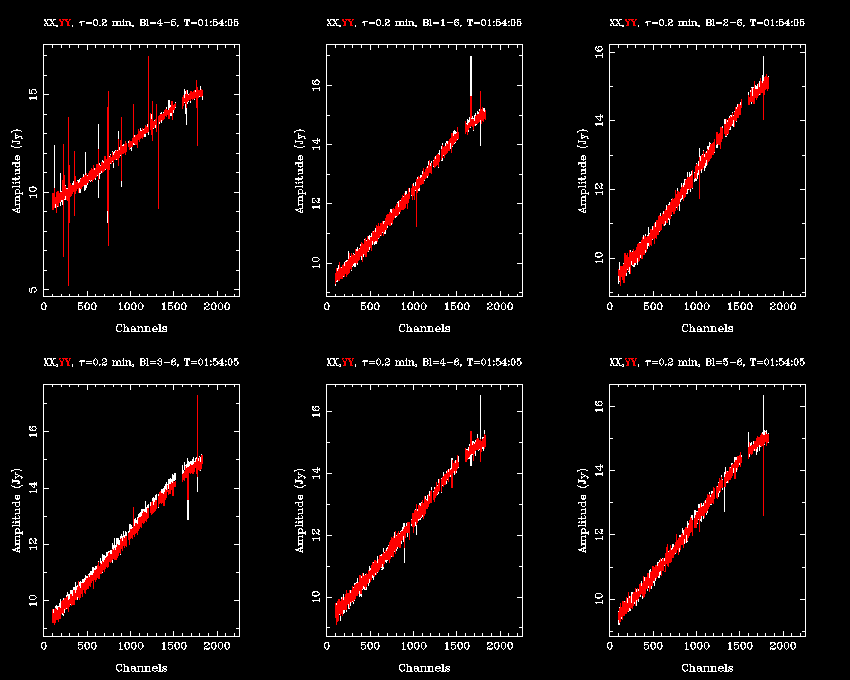

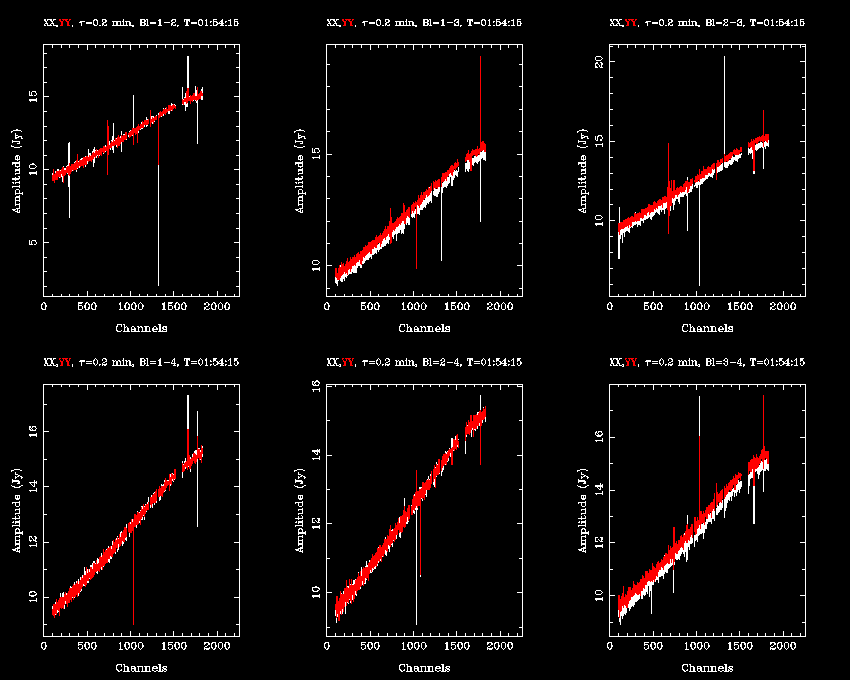

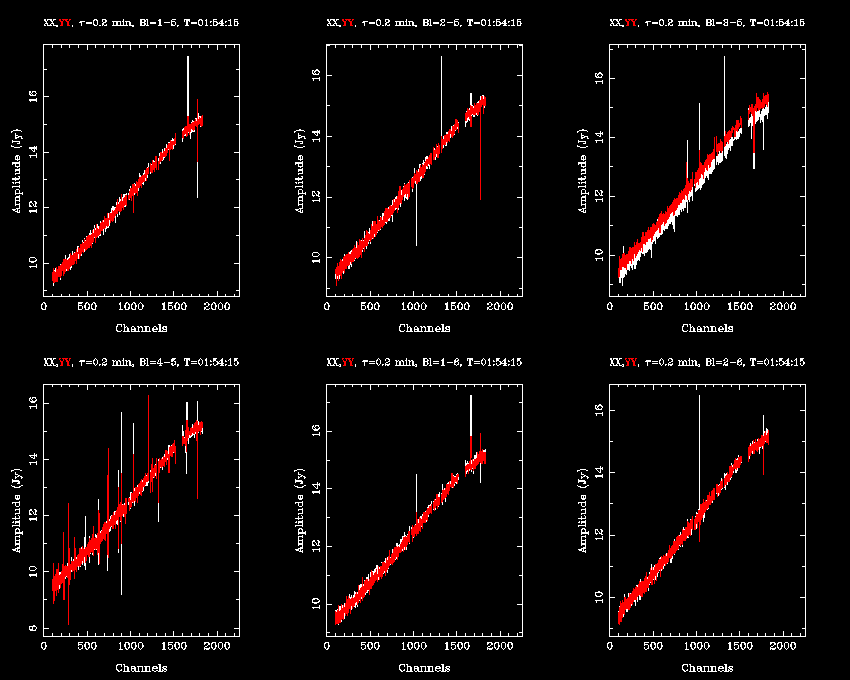

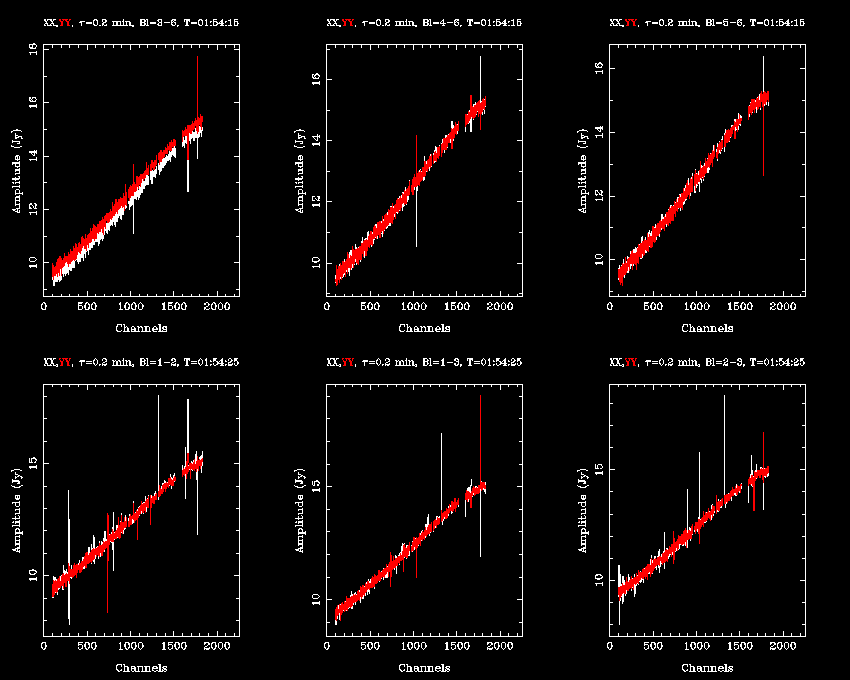

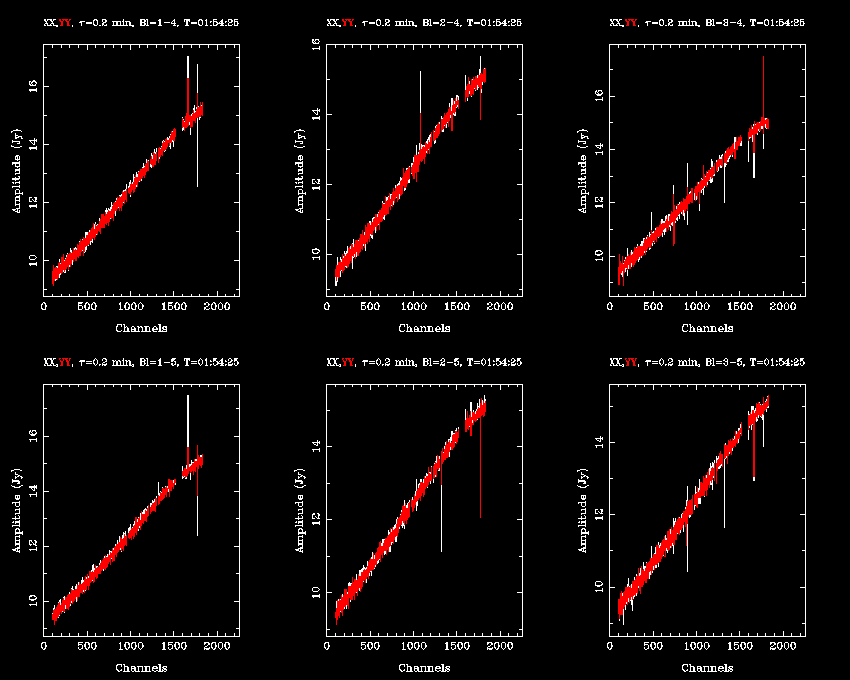

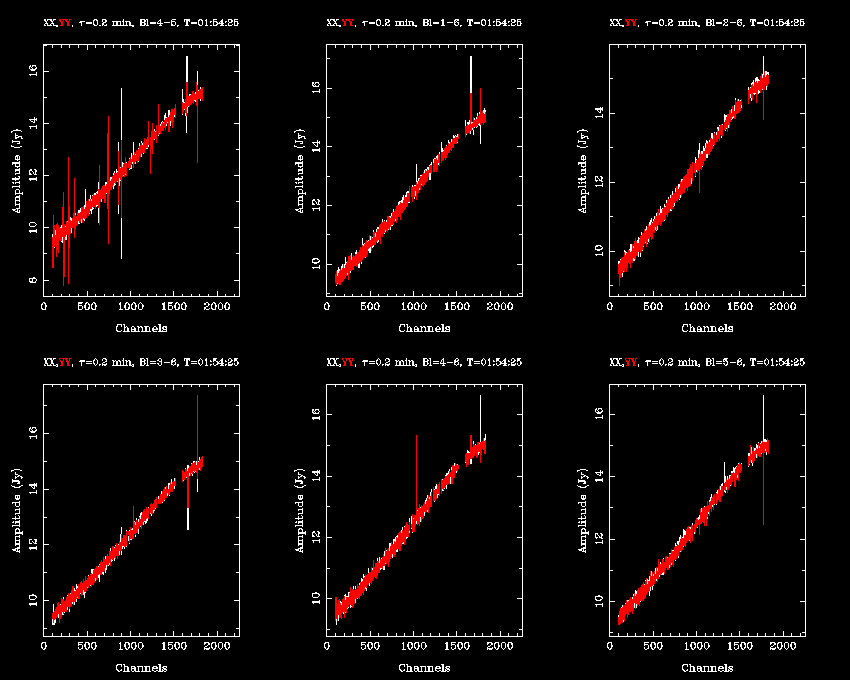

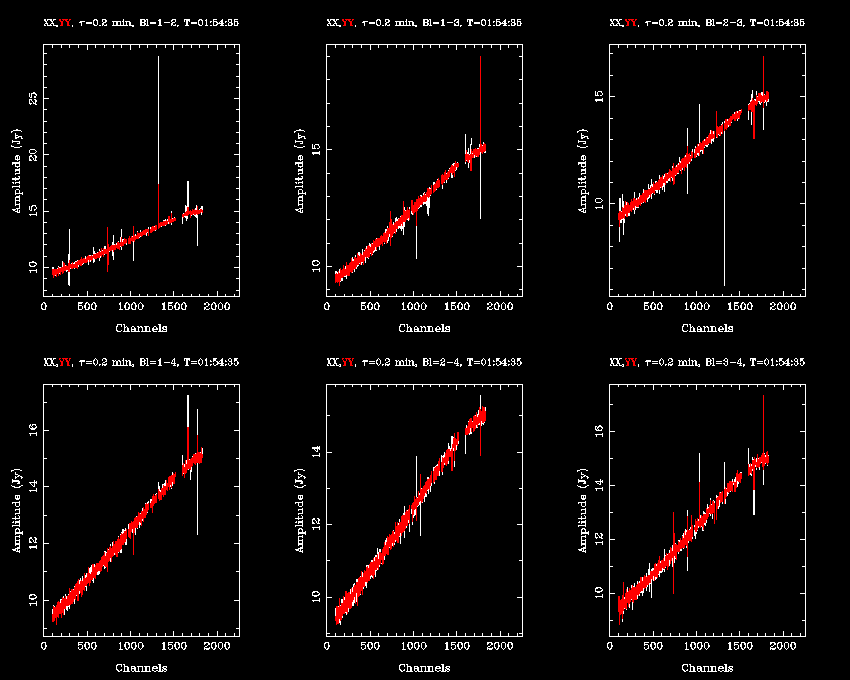

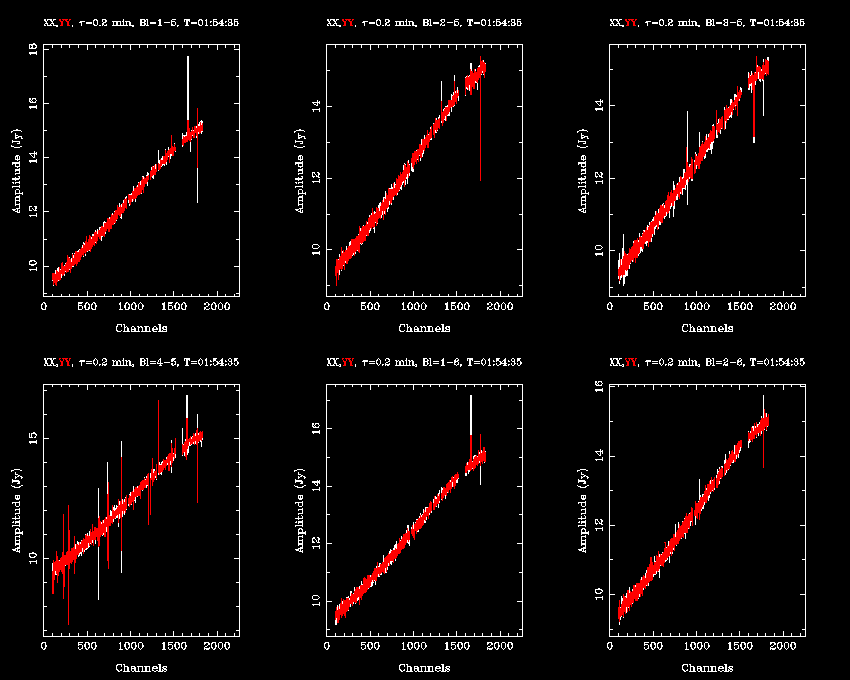

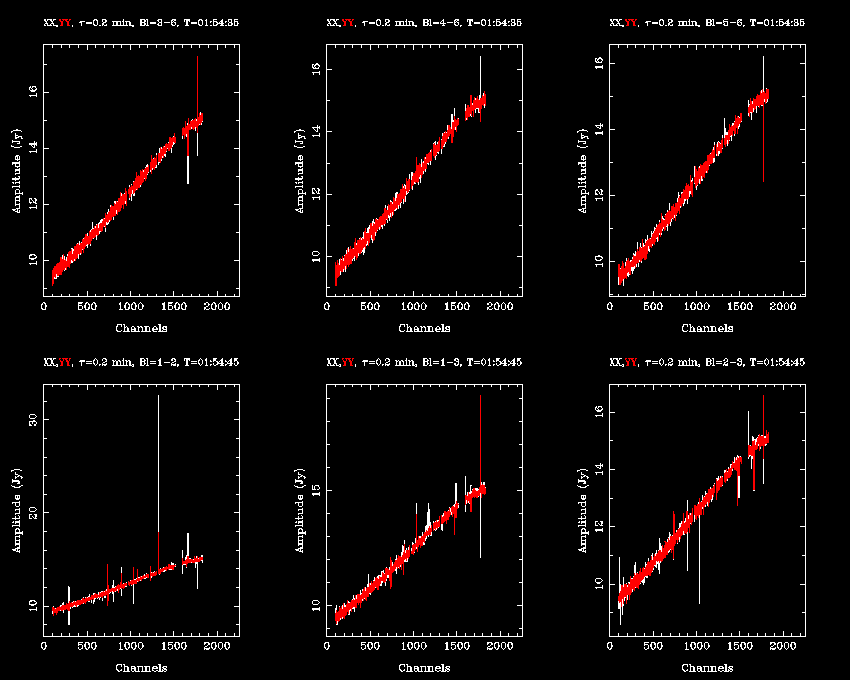

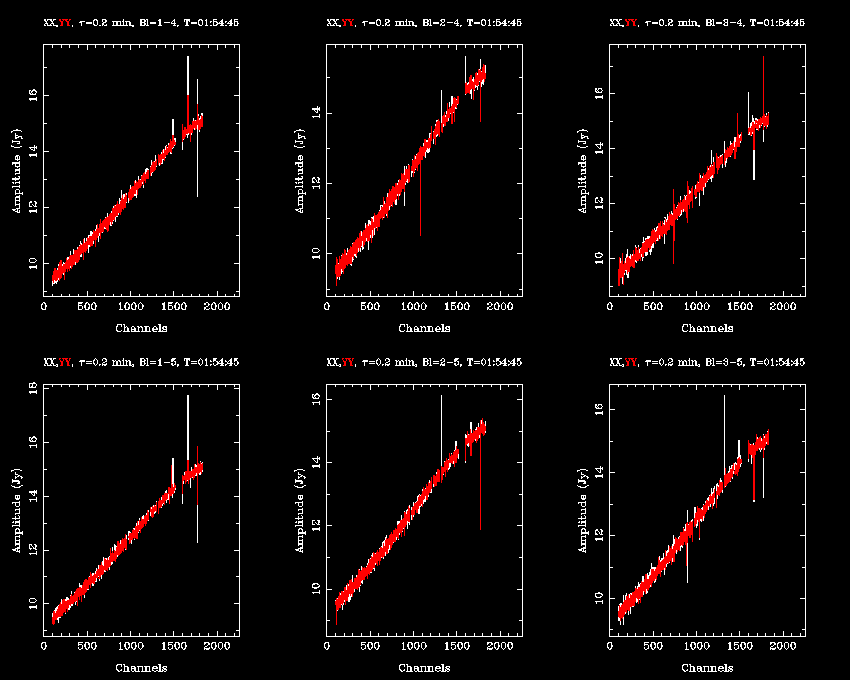

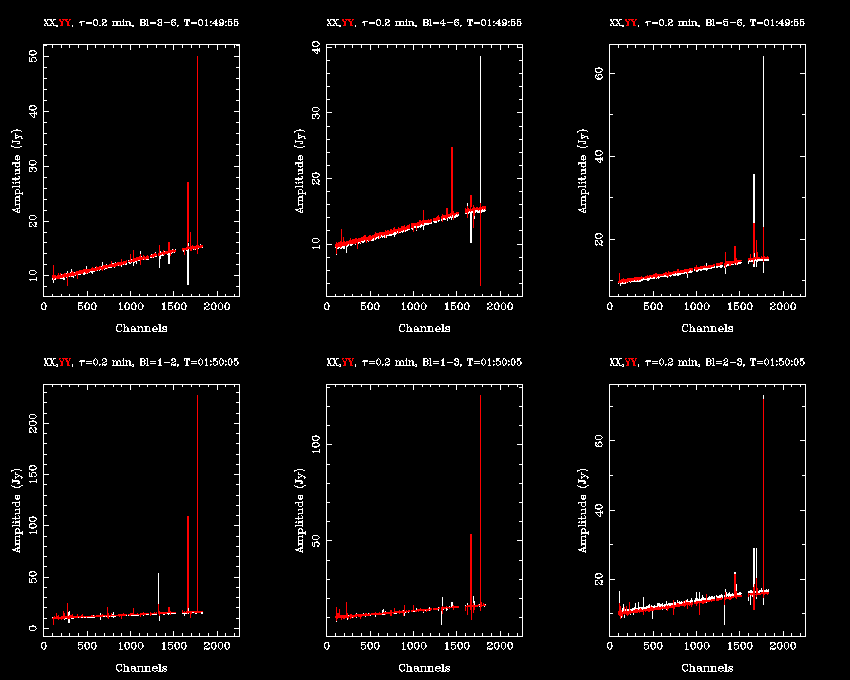

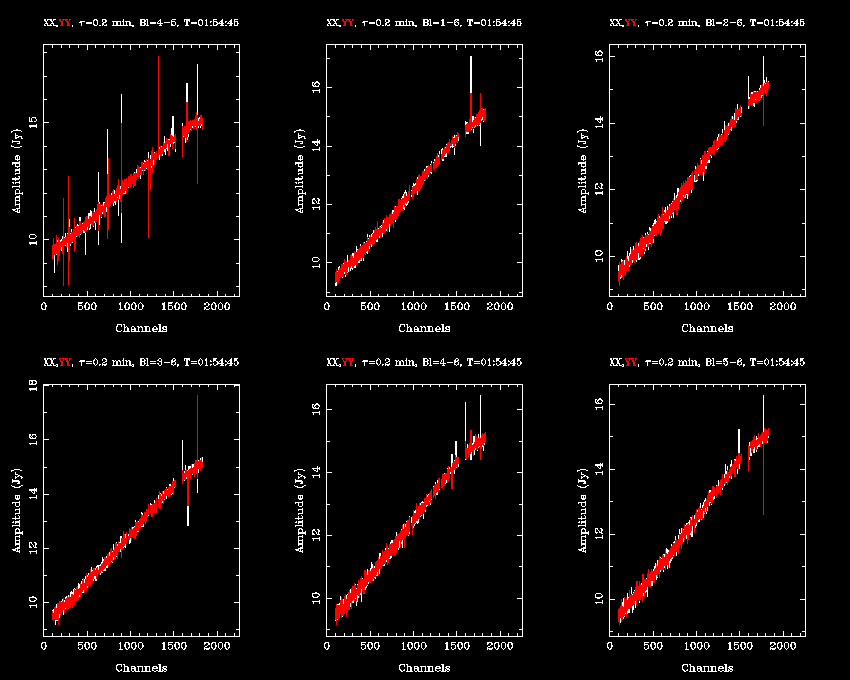

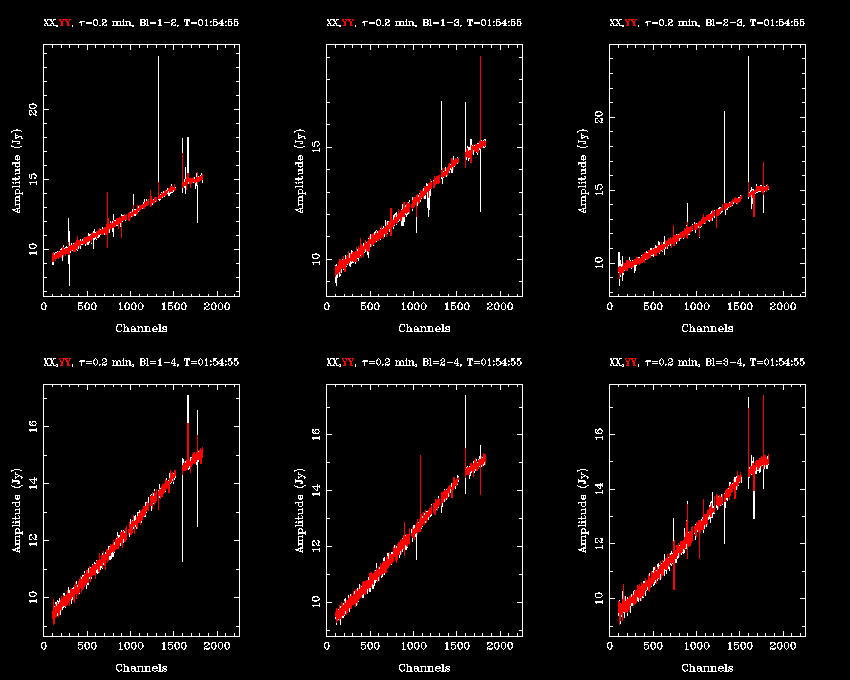

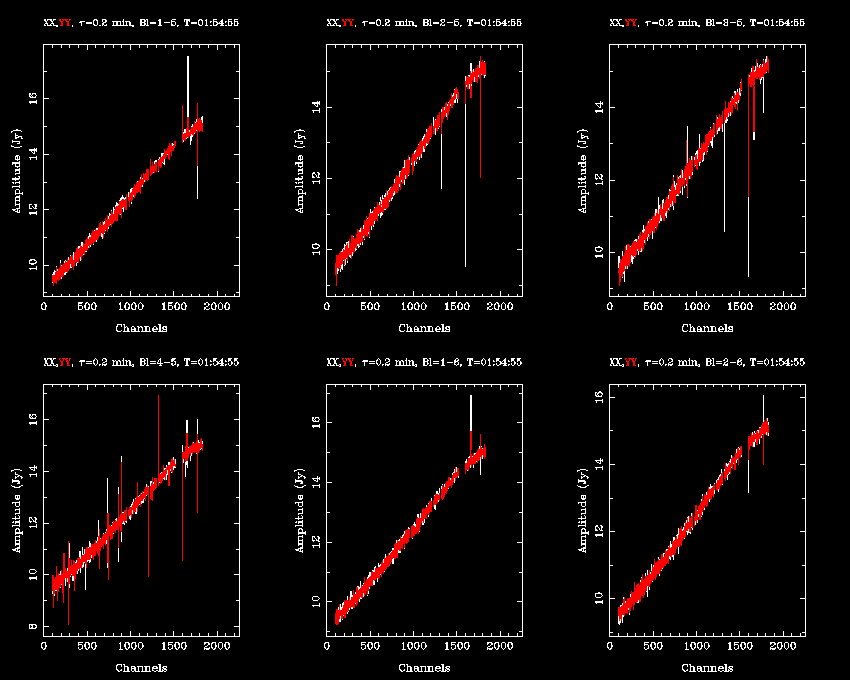

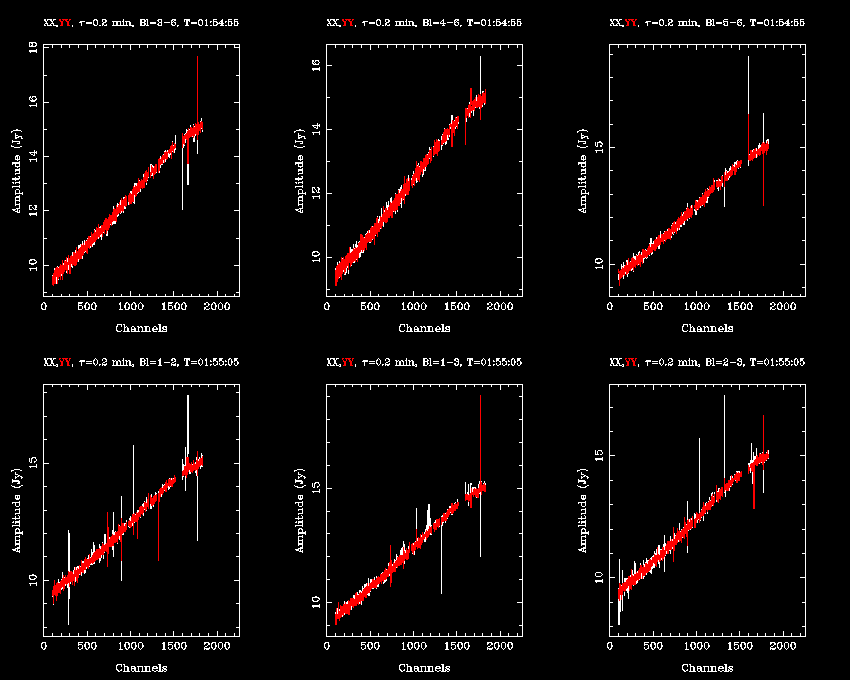

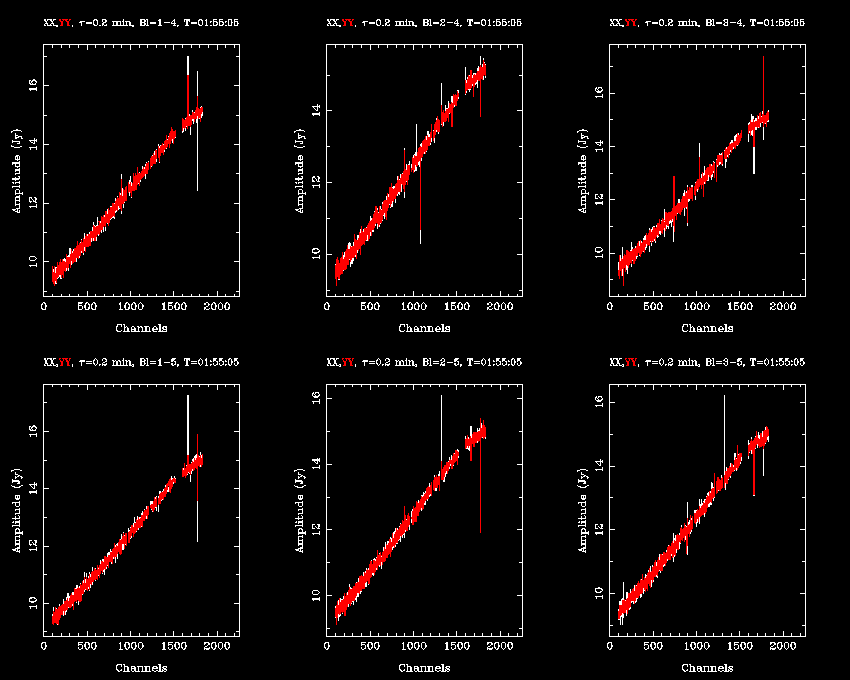

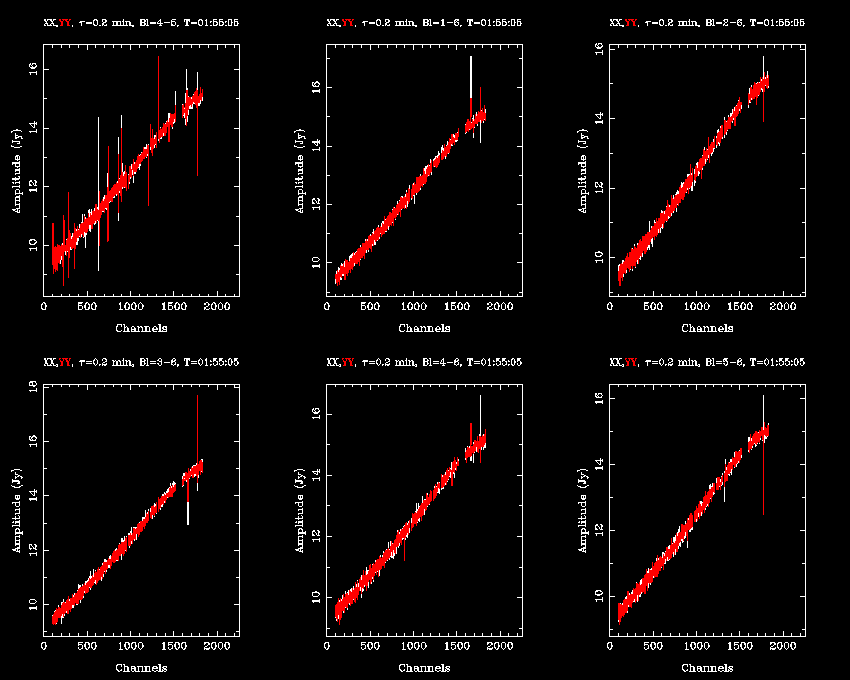

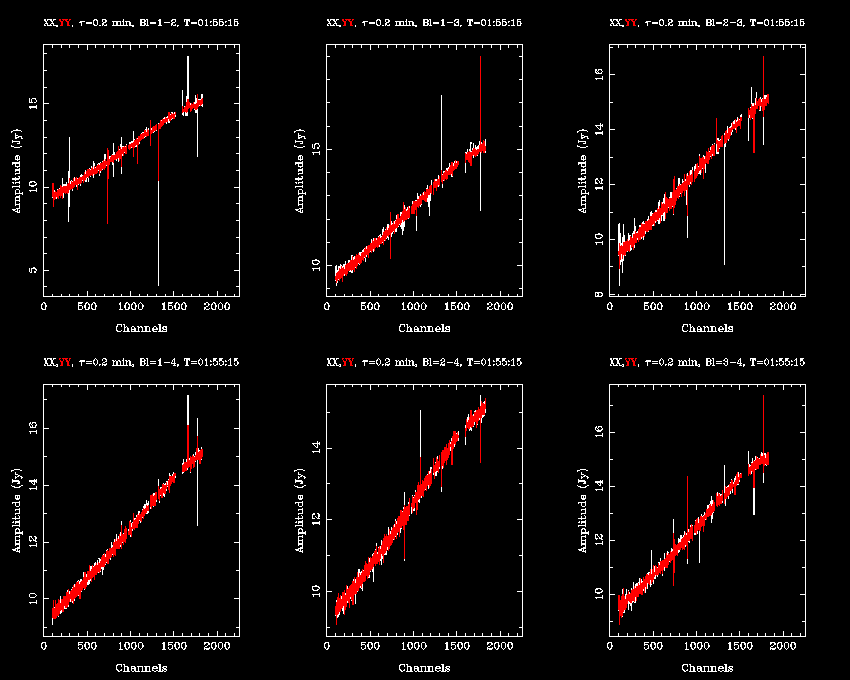

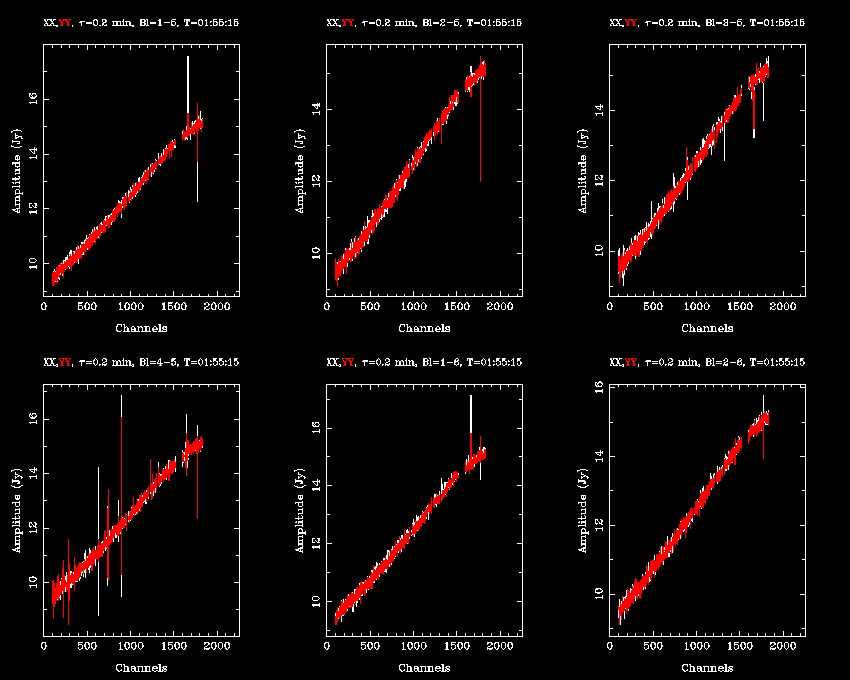

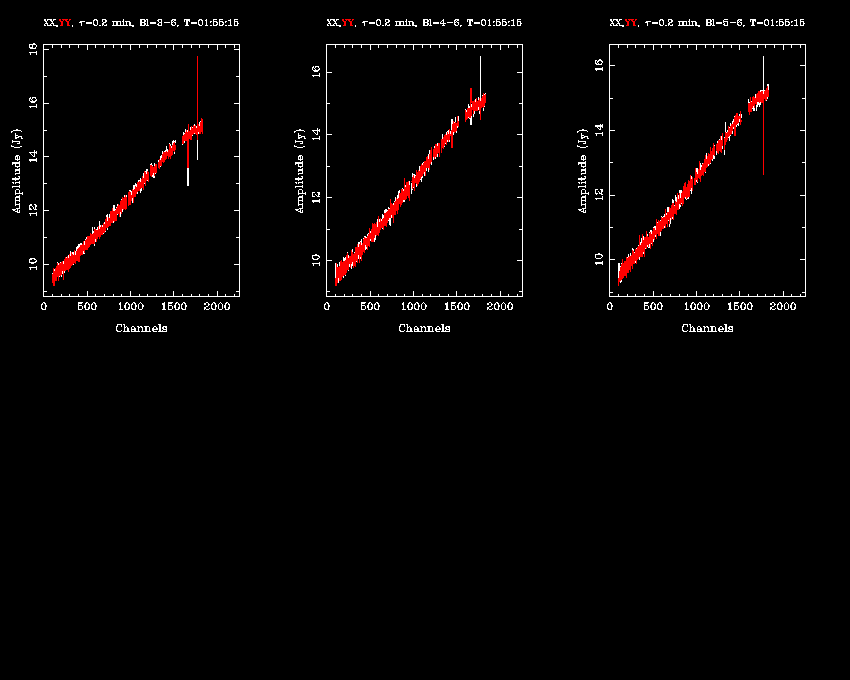

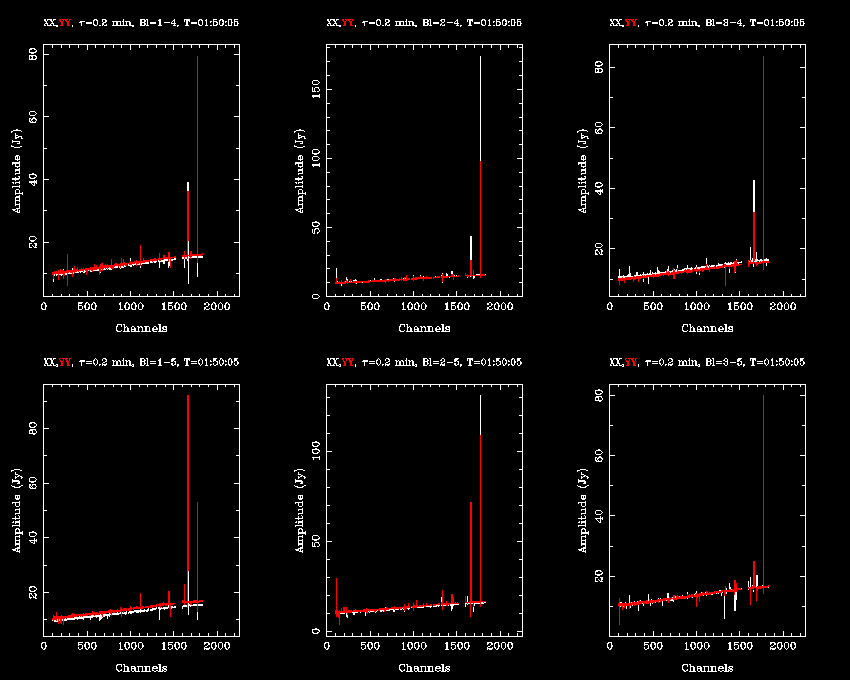

In [6]:
# determine the bandpass shape

# mfcal parameters
vis = bandflux_cal

mir_output = miriad.mfcal(vis=vis)
print(mir_output.decode("utf-8"))

# if you want to see what it looks like after mfcal
print('#'*10+"Post mfcal bandpass, flux calibration"+'#'*10)
# delete old ones
!rm *png*
# uvspec parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "chan,amp"
device="{0}bfpostmfcal.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}bfpostmfcal*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))

## RFI flagging

In [7]:

# pgflag parameters
vis = bandflux_cal
stokes = 'xx'
command = "<b"
device="/xs" 
mir_output = miriad.pgflag(vis=vis,stokes=stokes,command=command,
                            device=device)
print(mir_output.decode("utf-8"))

pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Do SumThreshold operation on baseline   1   2
 26.7% of the data on this baseline is now flagged
 30.4% of the data on this baseline is now flagged
 39.4% of the data on this baseline is now flagged
Blow away the dust...
 41.7% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   3
 27.3% of the data on this baseline is now flagged
 28.9% of the data on this baseline is now flagged
 38.4% of the data on this baseline is now flagged
Blow away the dust...
 41.7% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   2   3
 27.8% of the data on this baseline is now flagged
 28.9% of the data on this baseline is now flagged
 38.6% of the data on this baseline is now flagged
Blow away the dust...
 41.5% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   4


pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Do SumThreshold operation on baseline   1   2
 26.5% of the data on this baseline is now flagged
 27.9% of the data on this baseline is now flagged
 29.7% of the data on this baseline is now flagged
Blow away the dust...
 29.9% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   3
 25.9% of the data on this baseline is now flagged
 26.7% of the data on this baseline is now flagged
 27.8% of the data on this baseline is now flagged
Blow away the dust...
 27.9% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   2   3
 26.1% of the data on this baseline is now flagged
 26.9% of the data on this baseline is now flagged
 28.2% of the data on this baseline is now flagged
Blow away the dust...
 28.3% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   4


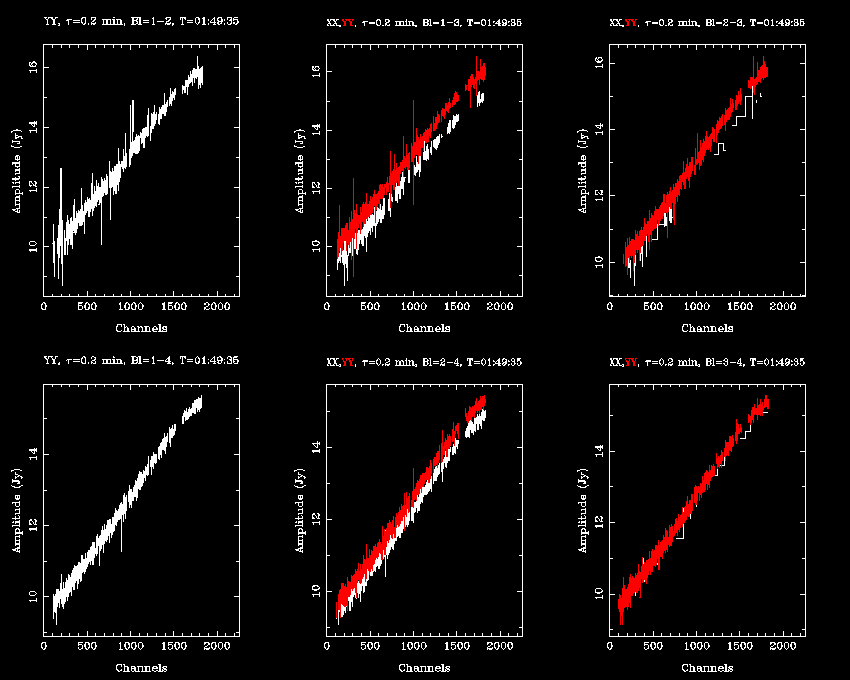

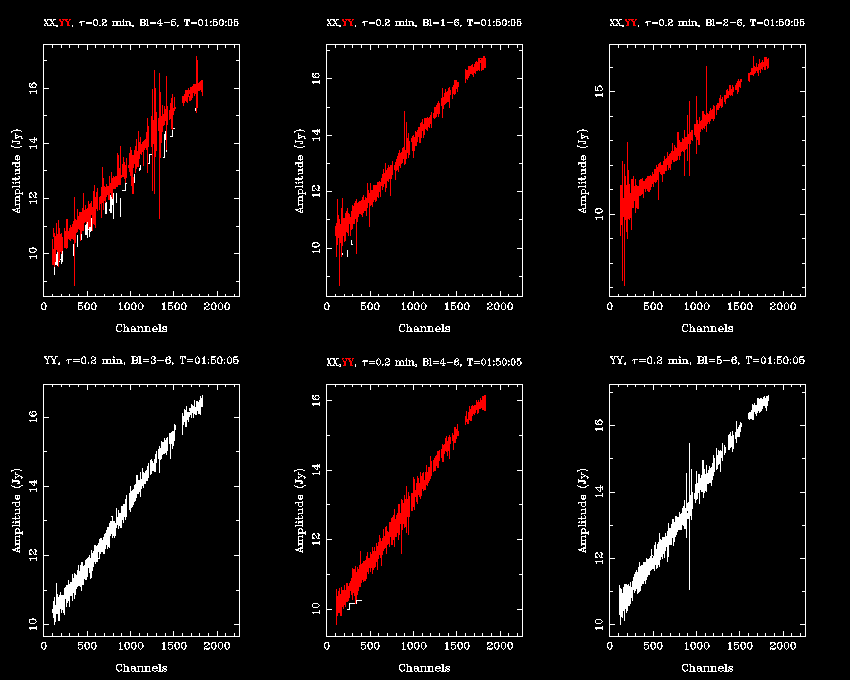

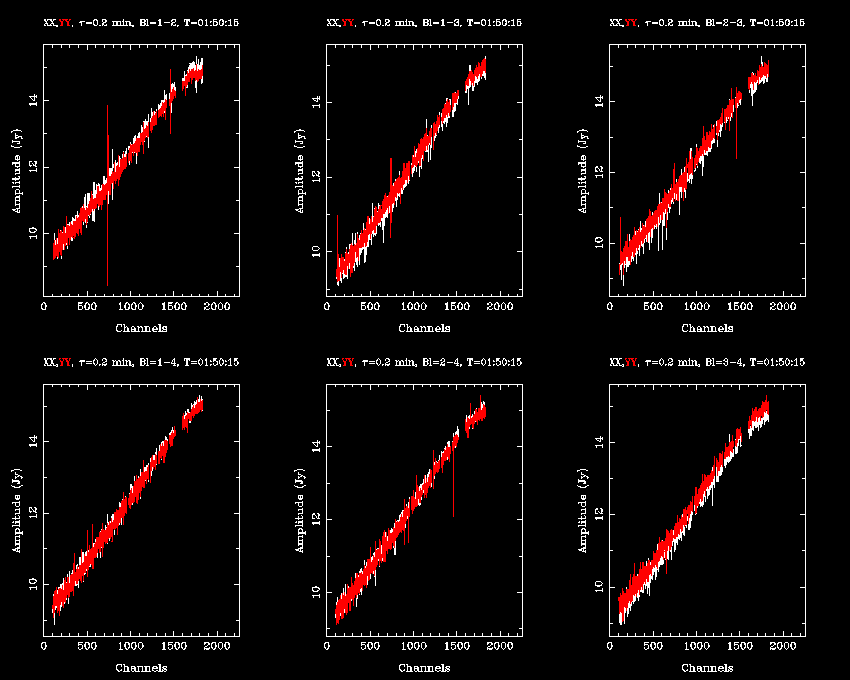

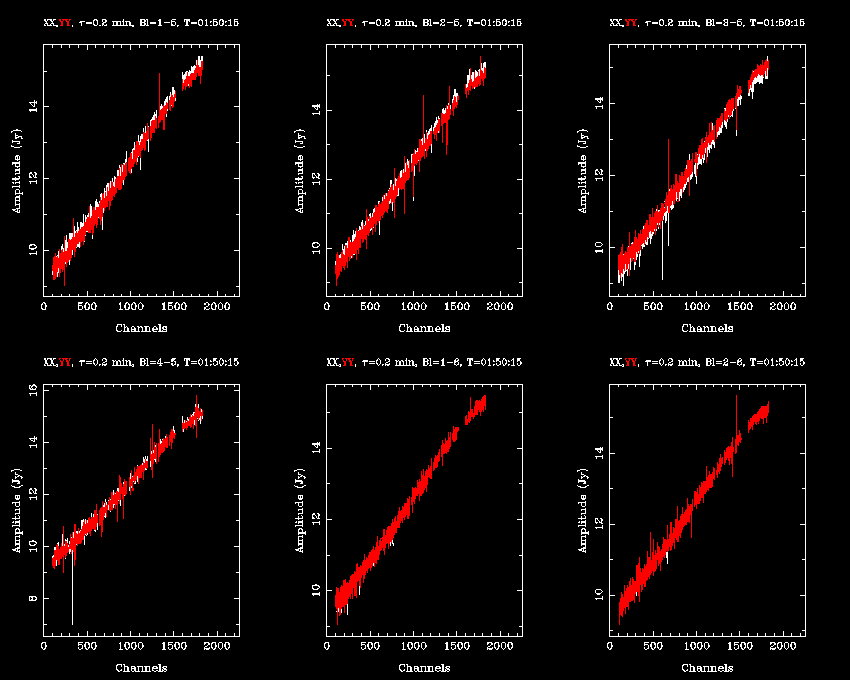

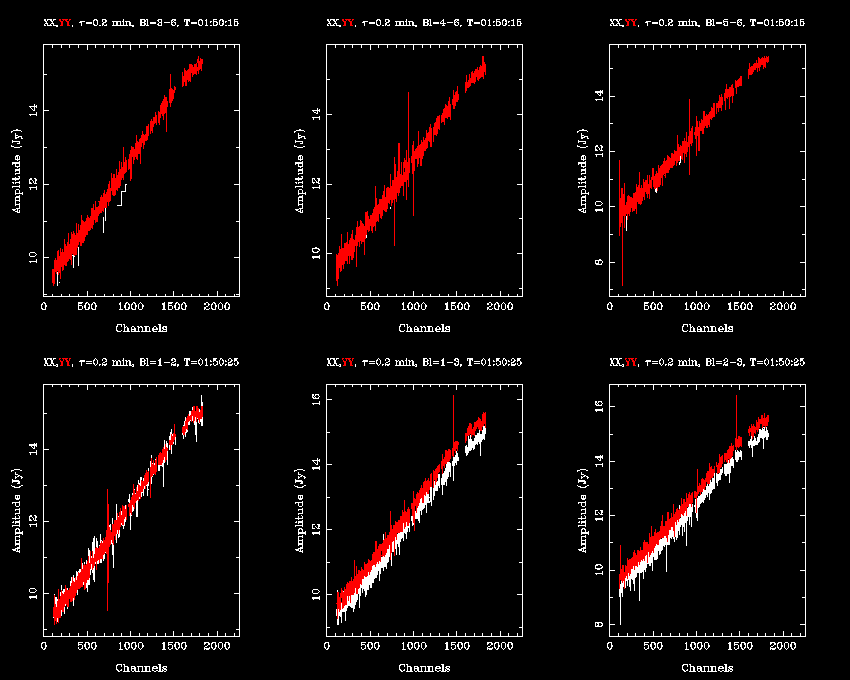

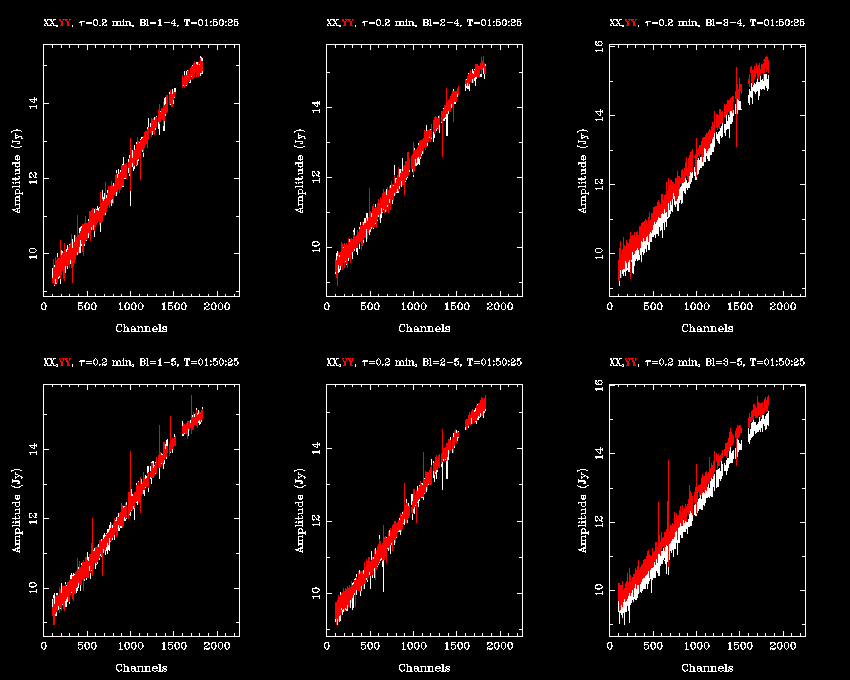

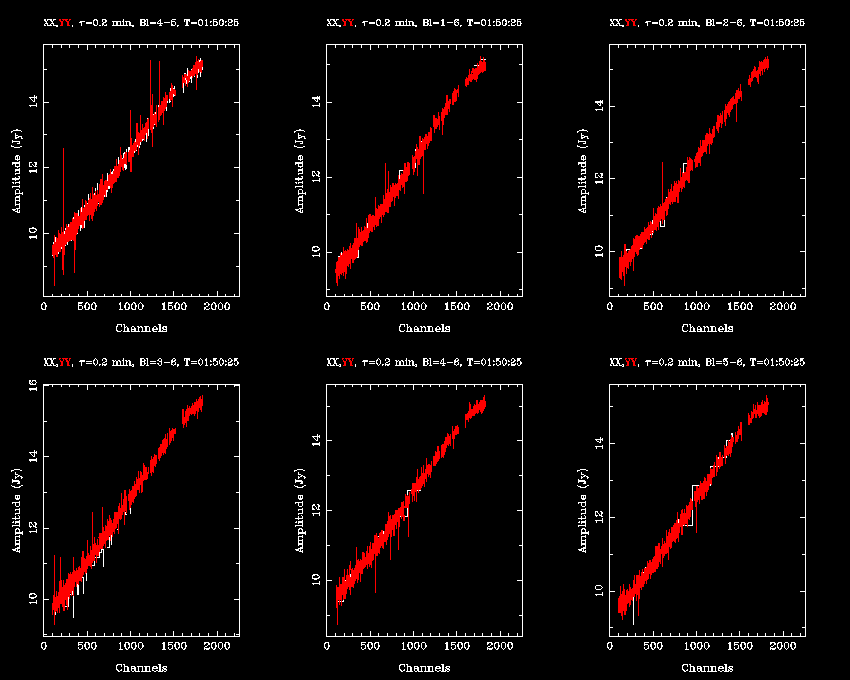

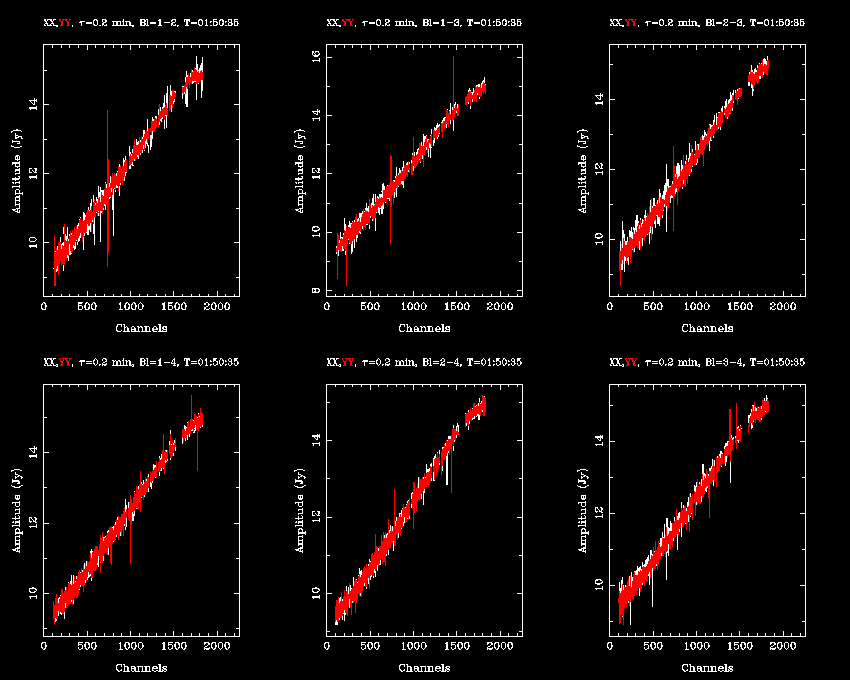

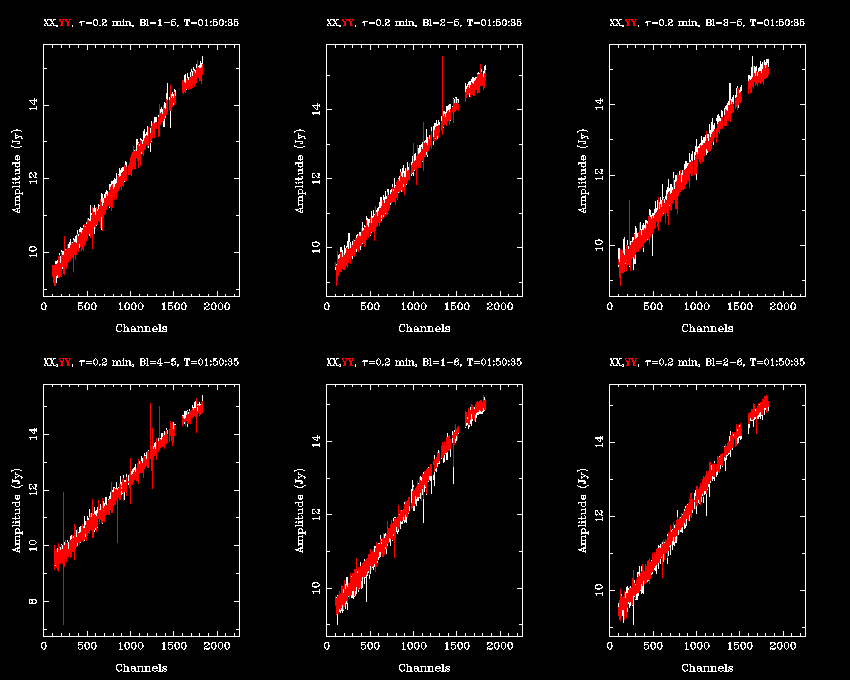

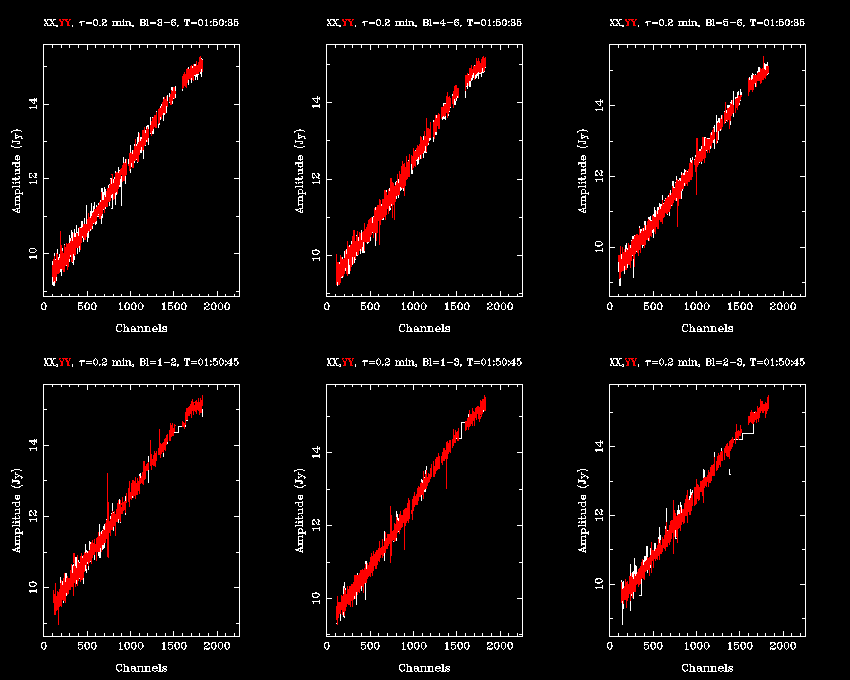

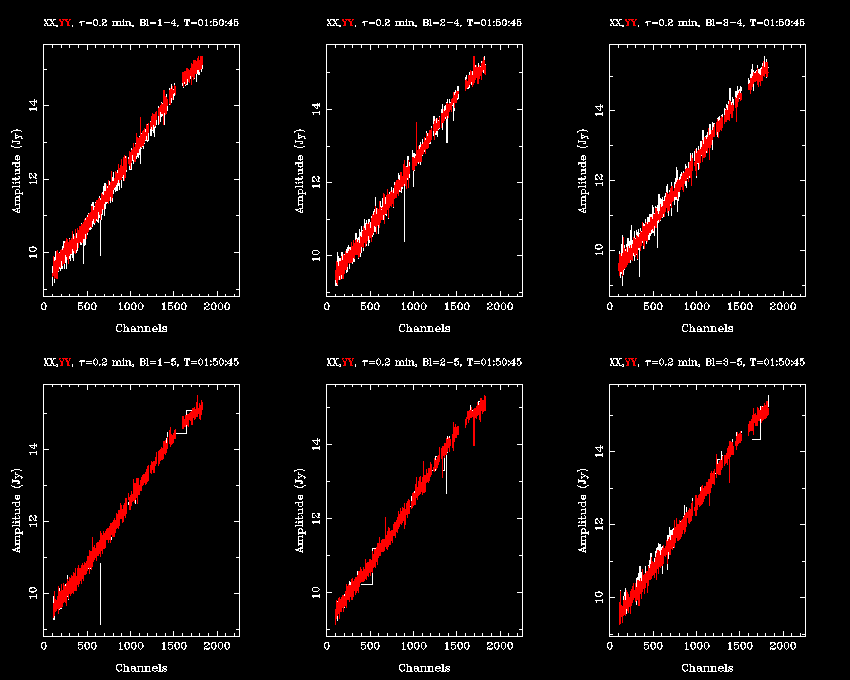

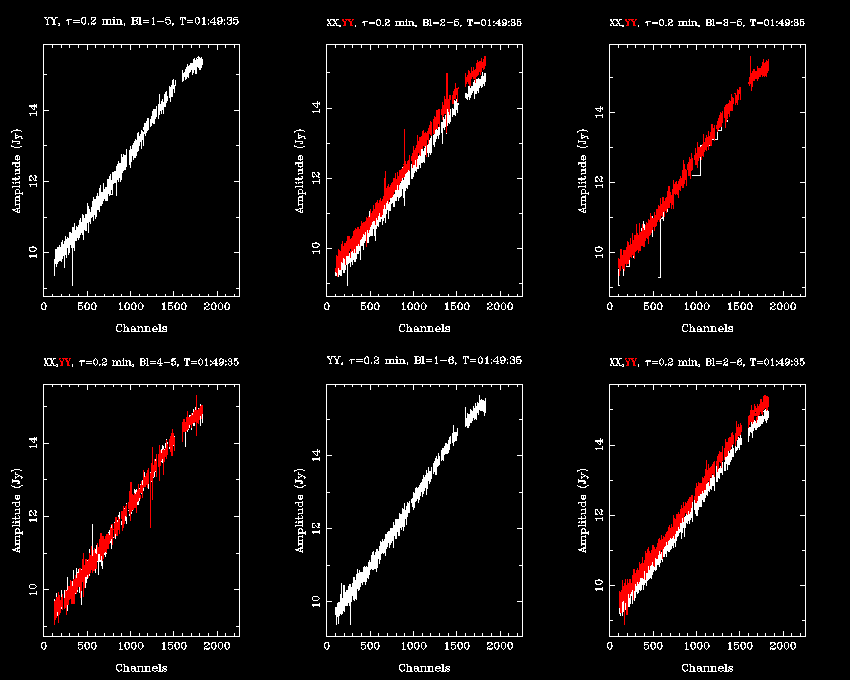

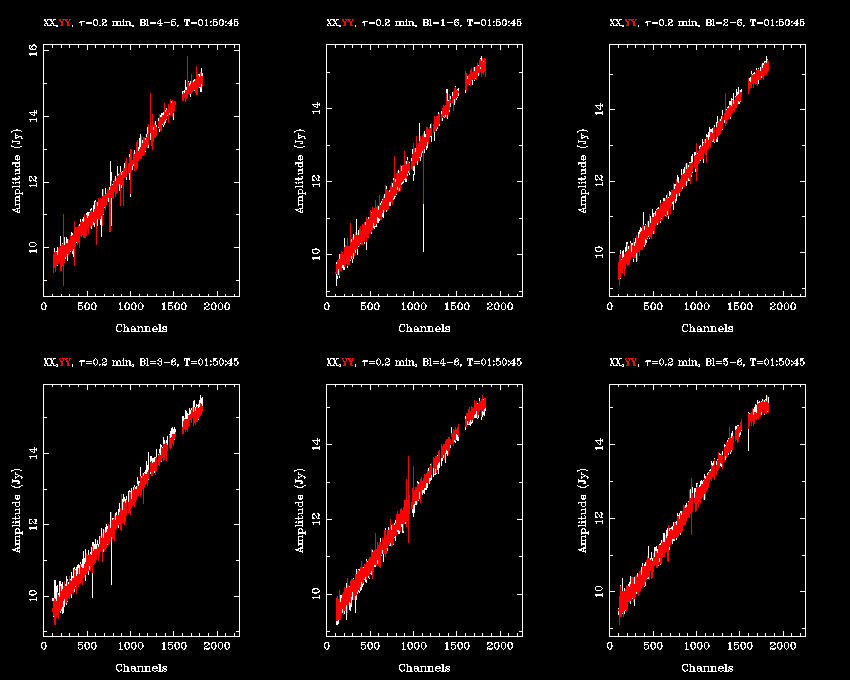

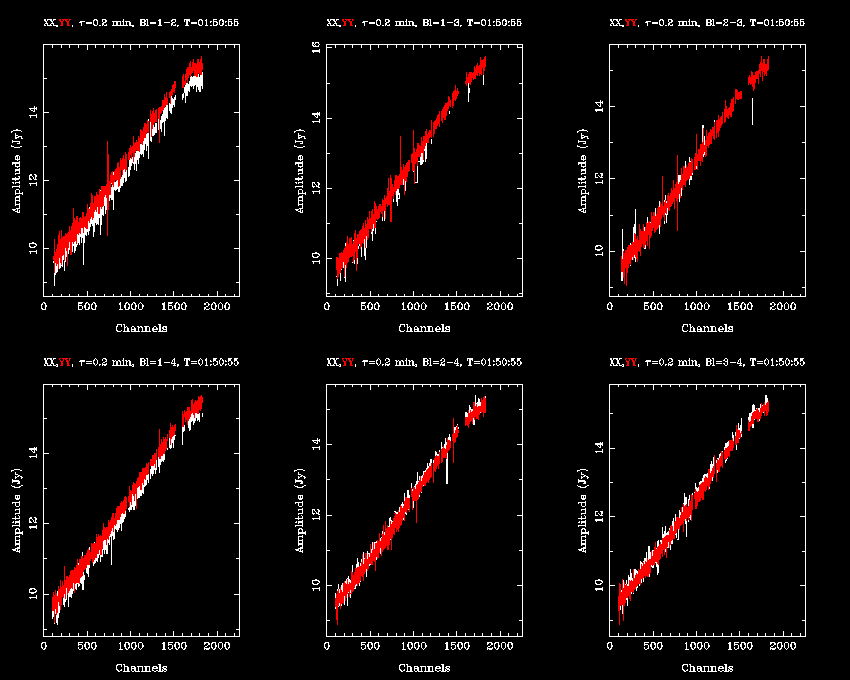

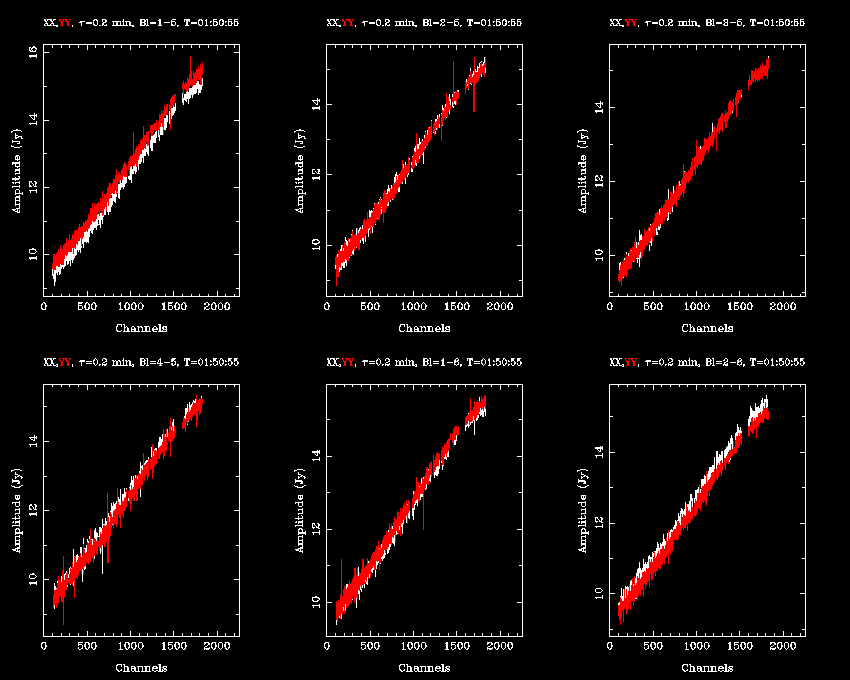

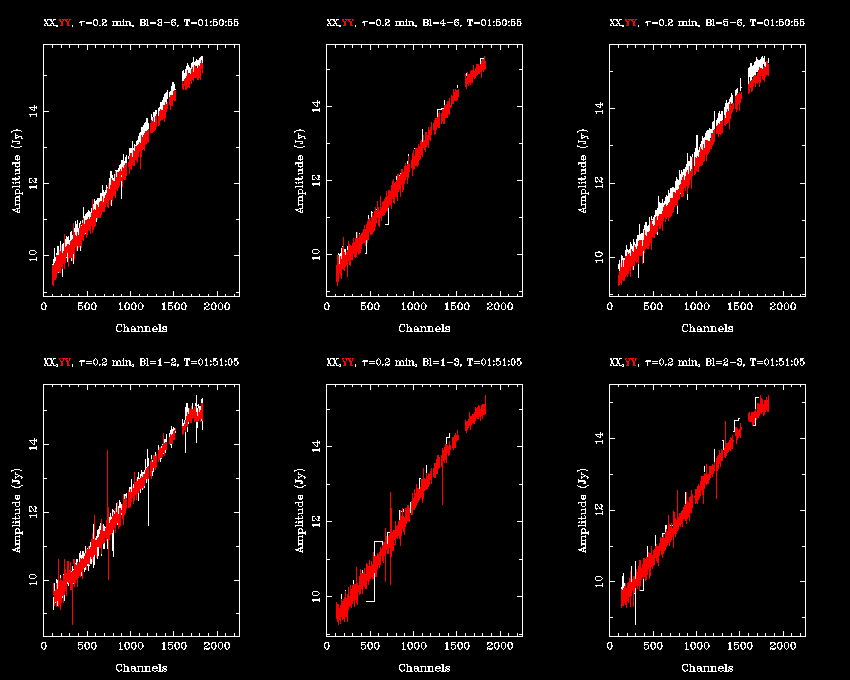

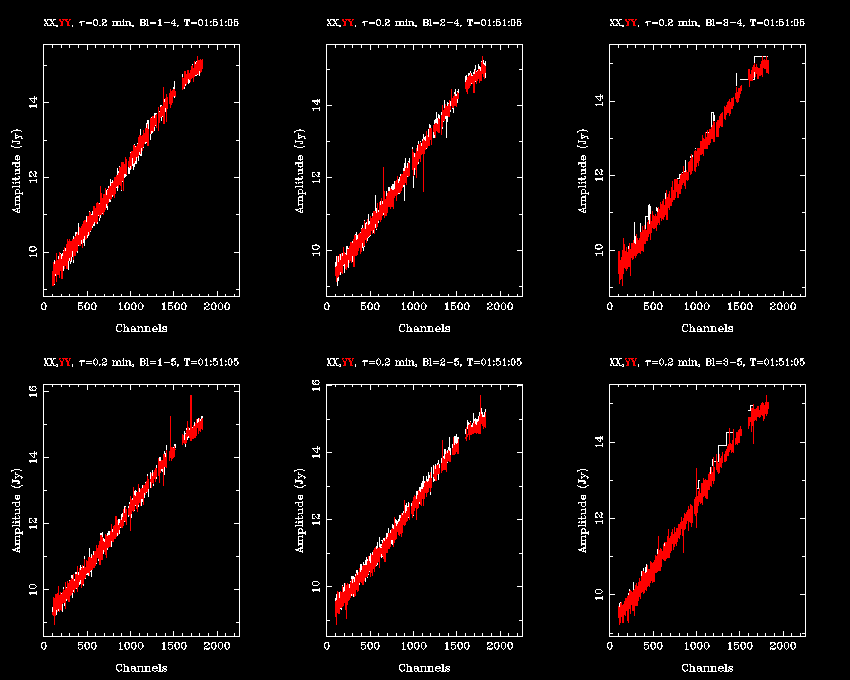

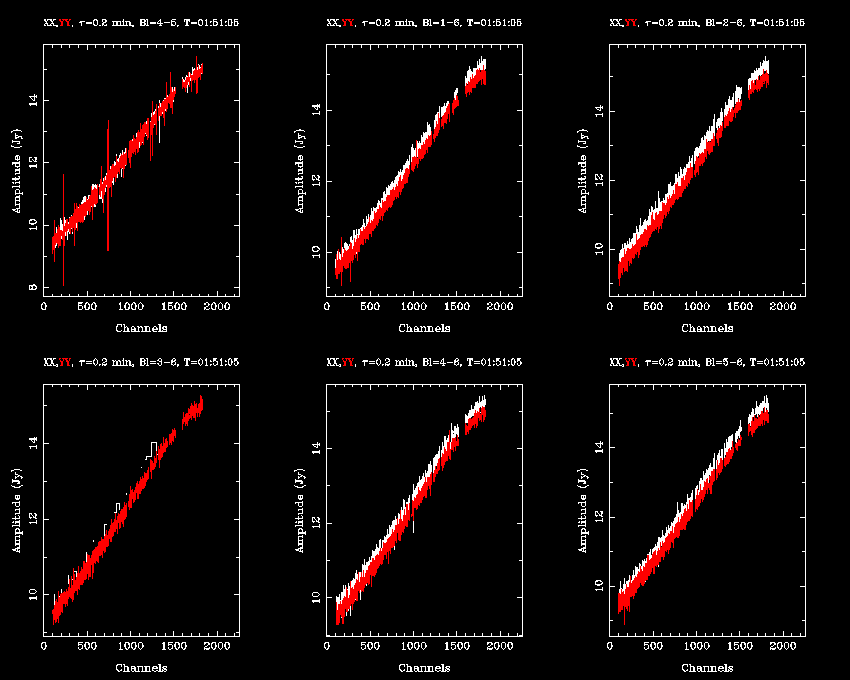

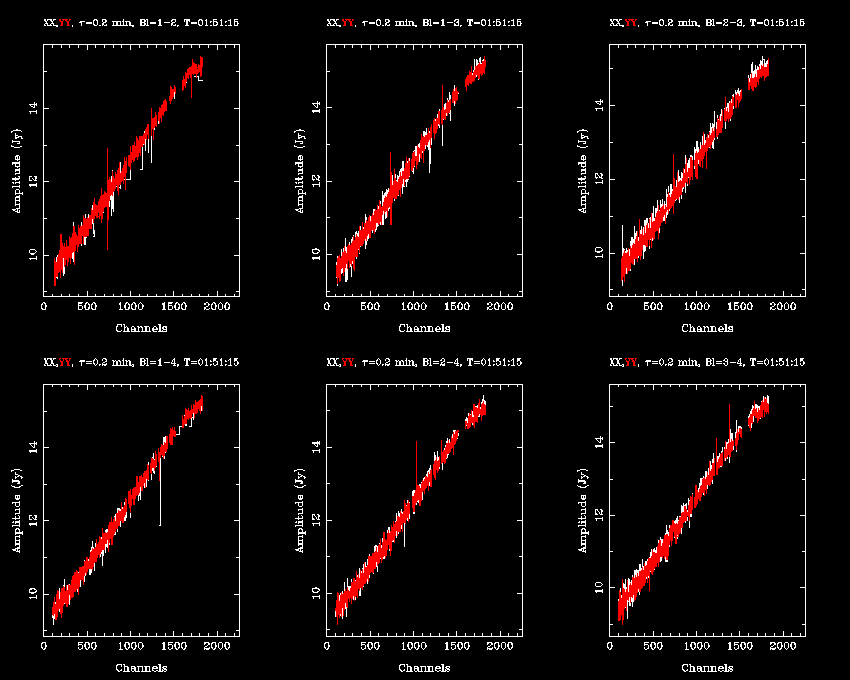

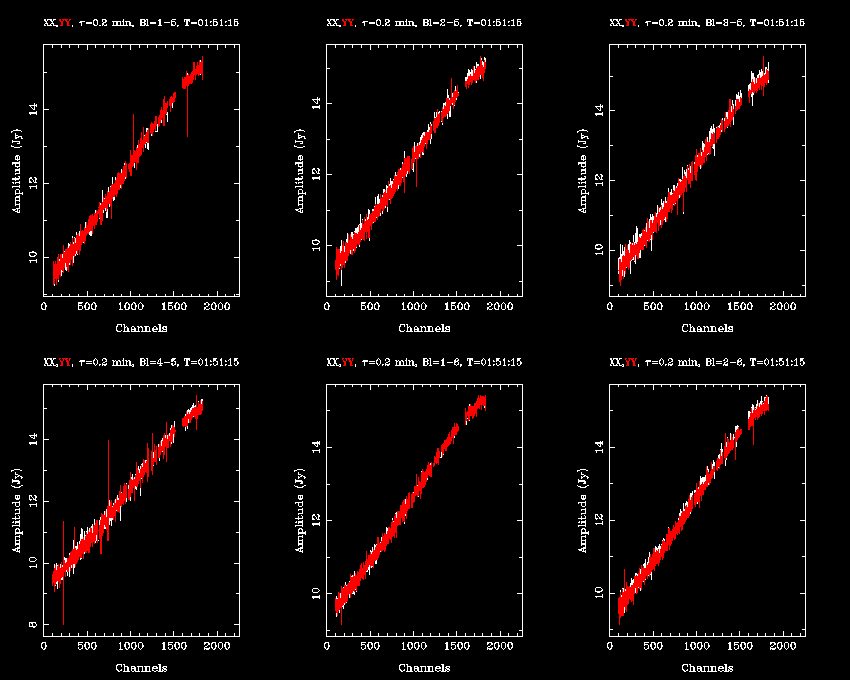

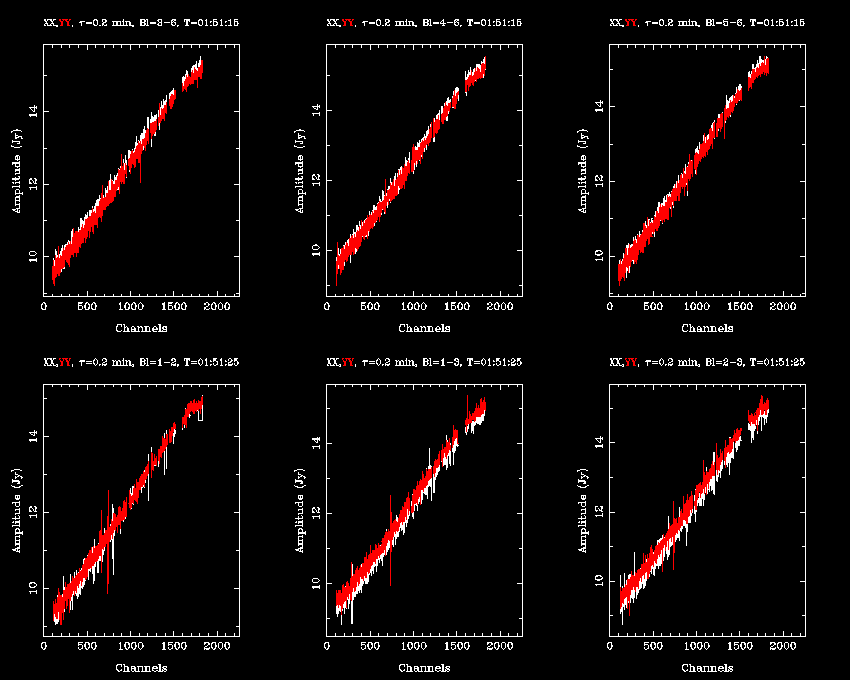

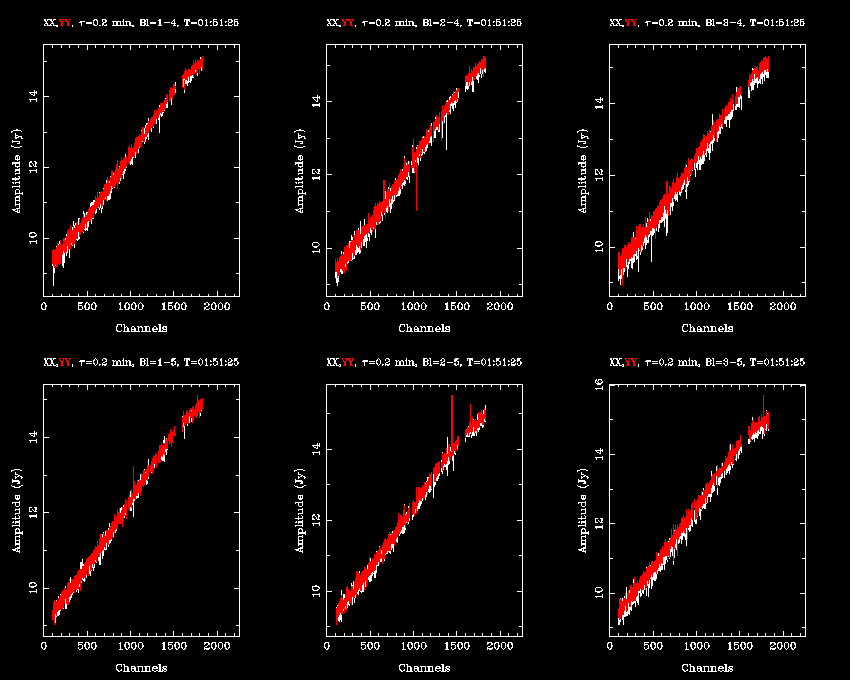

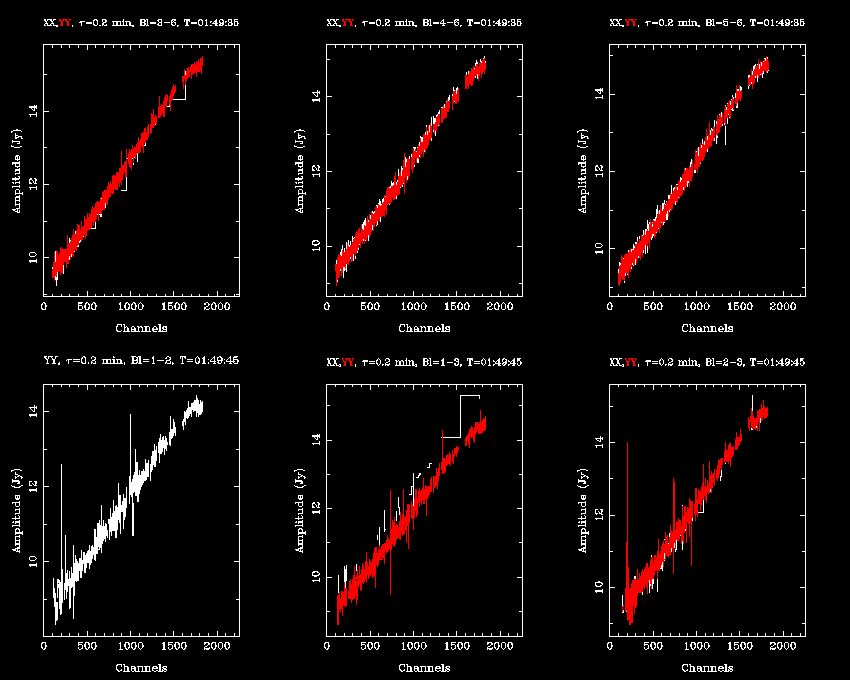

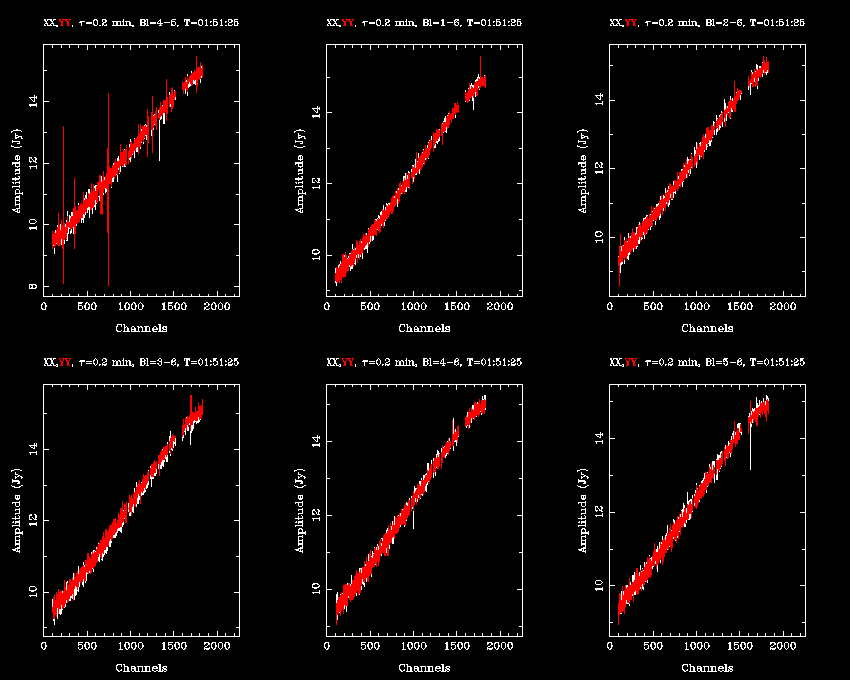

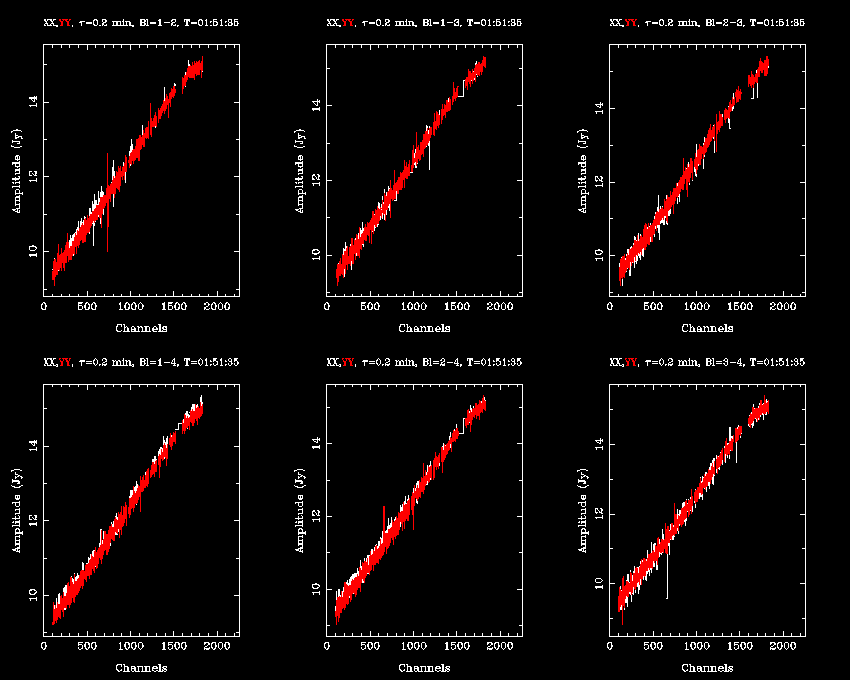

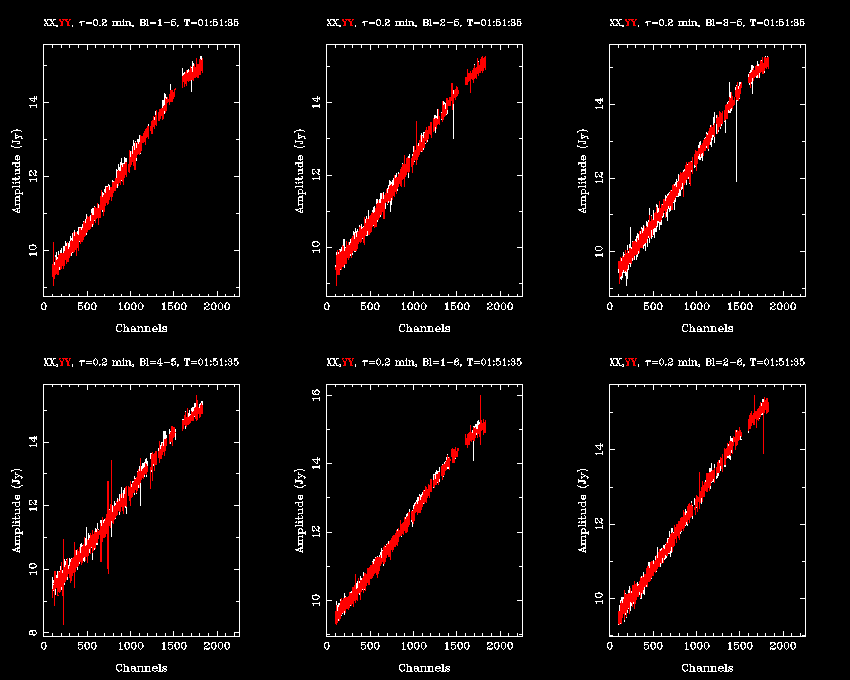

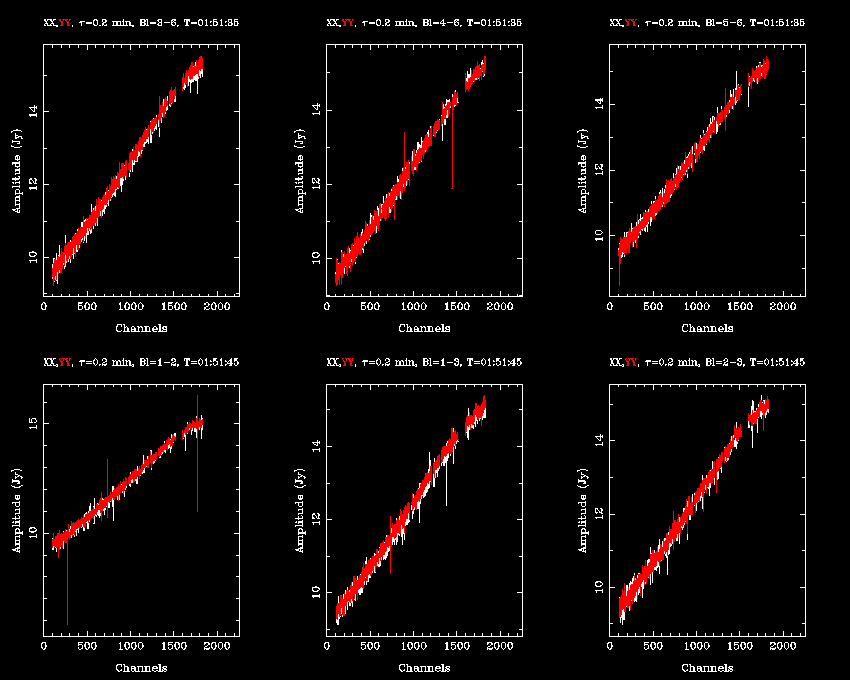

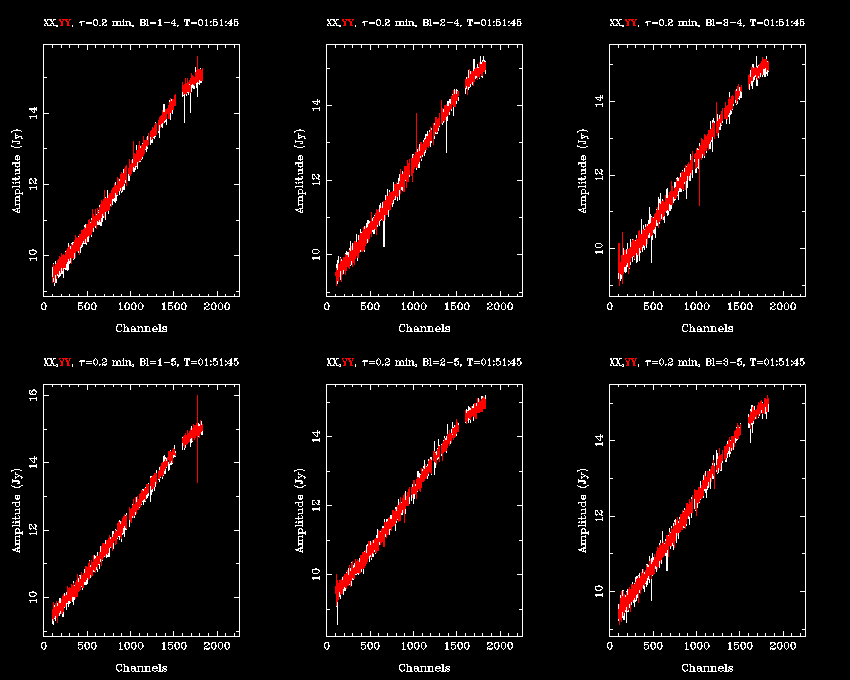

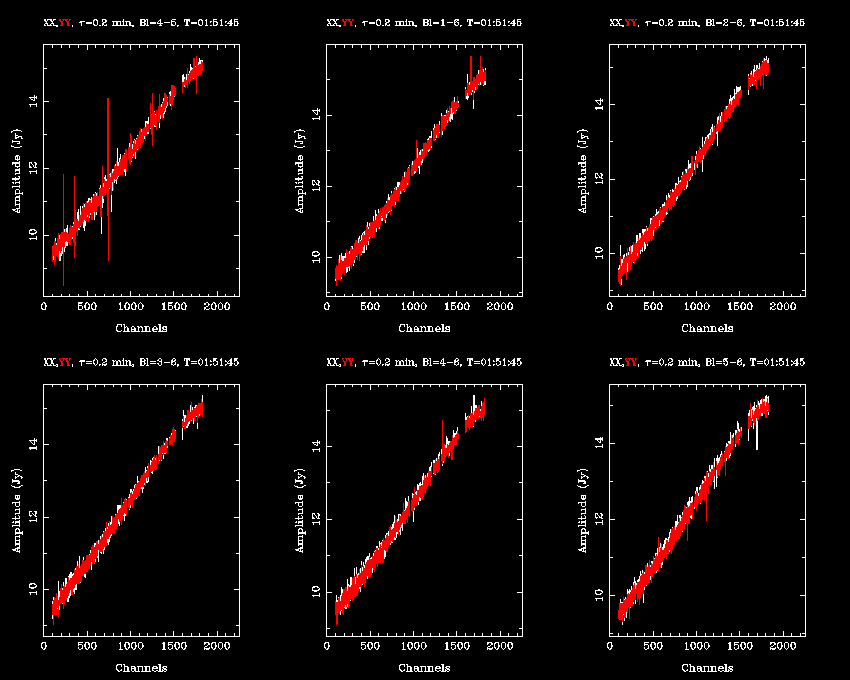

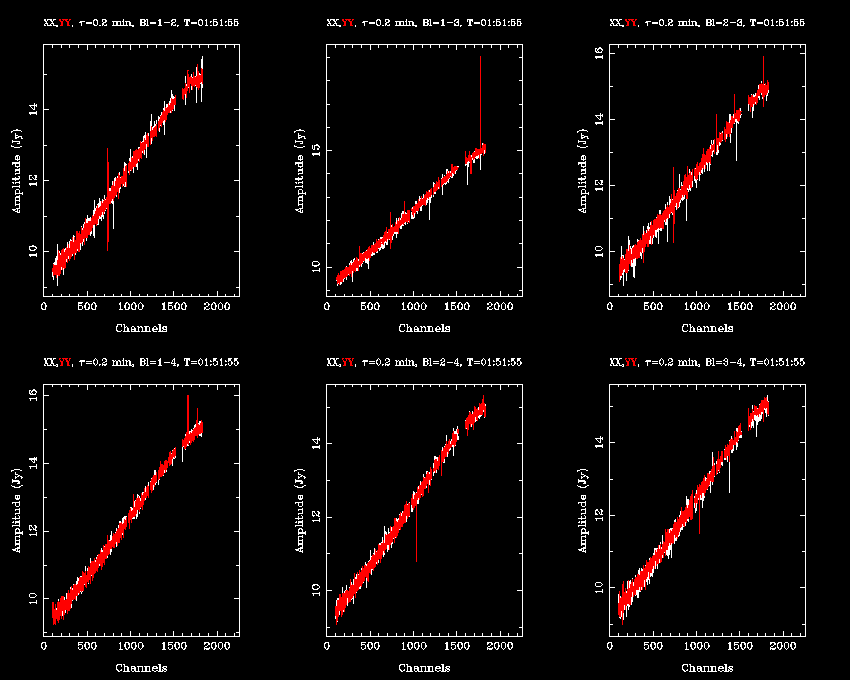

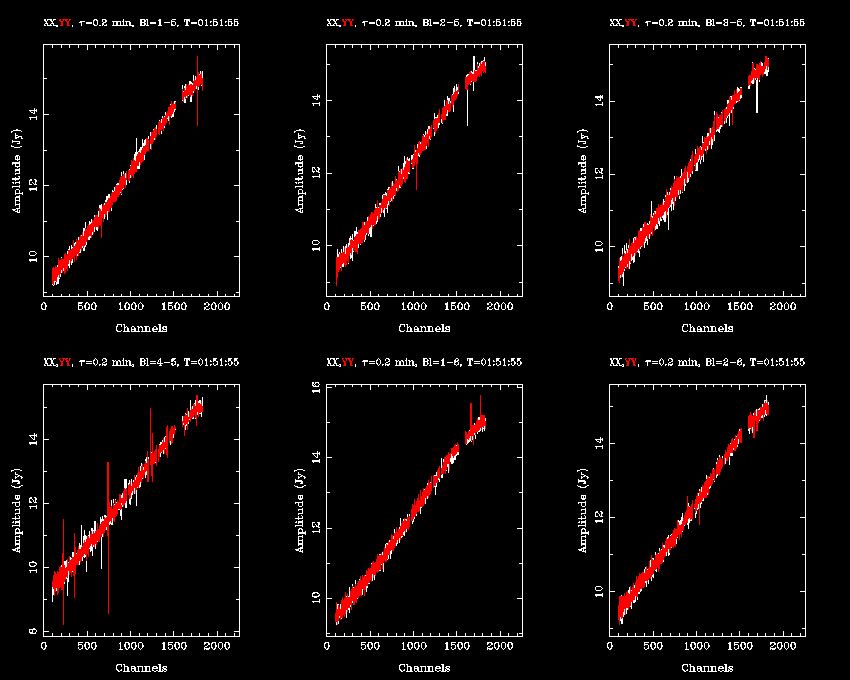

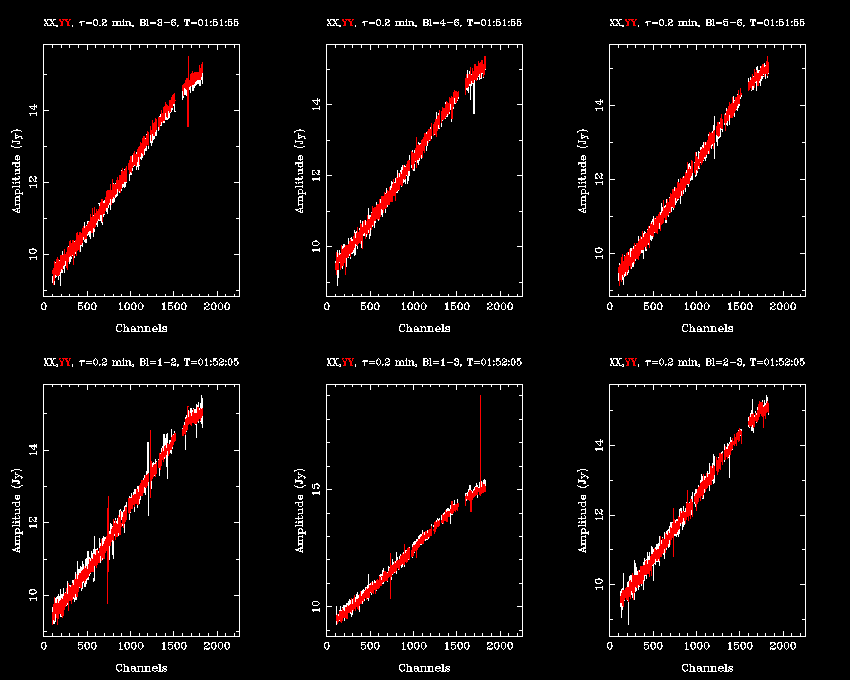

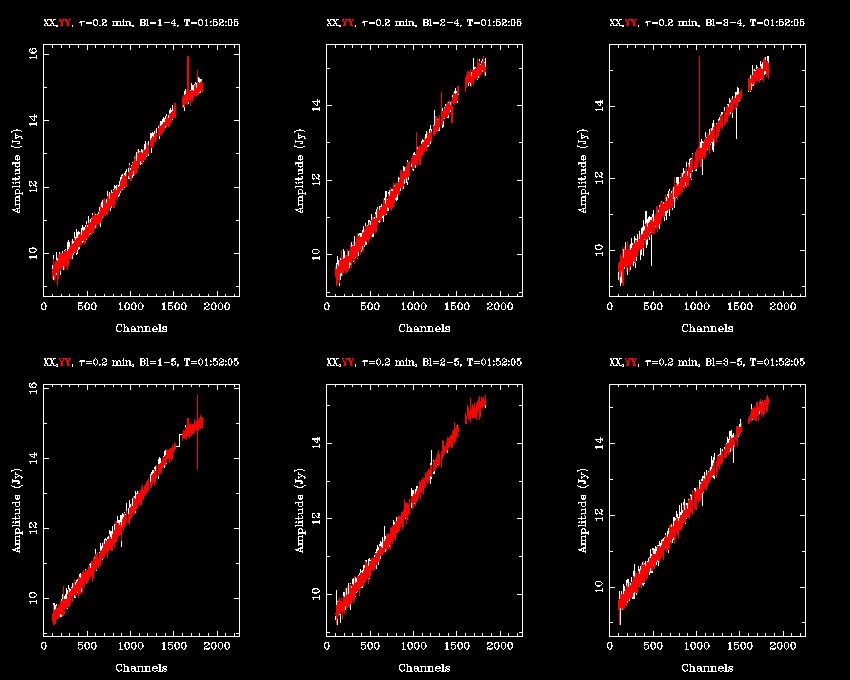

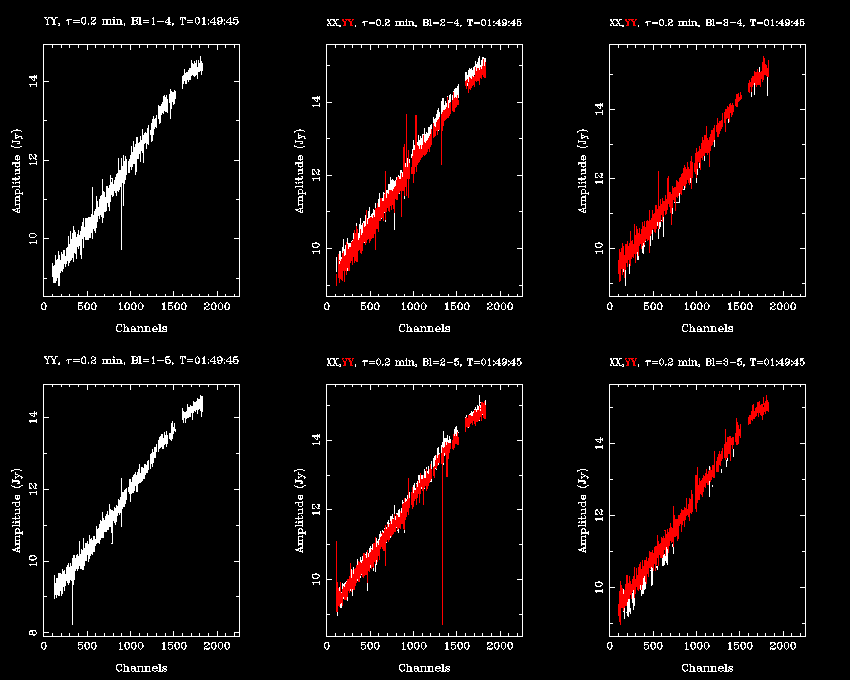

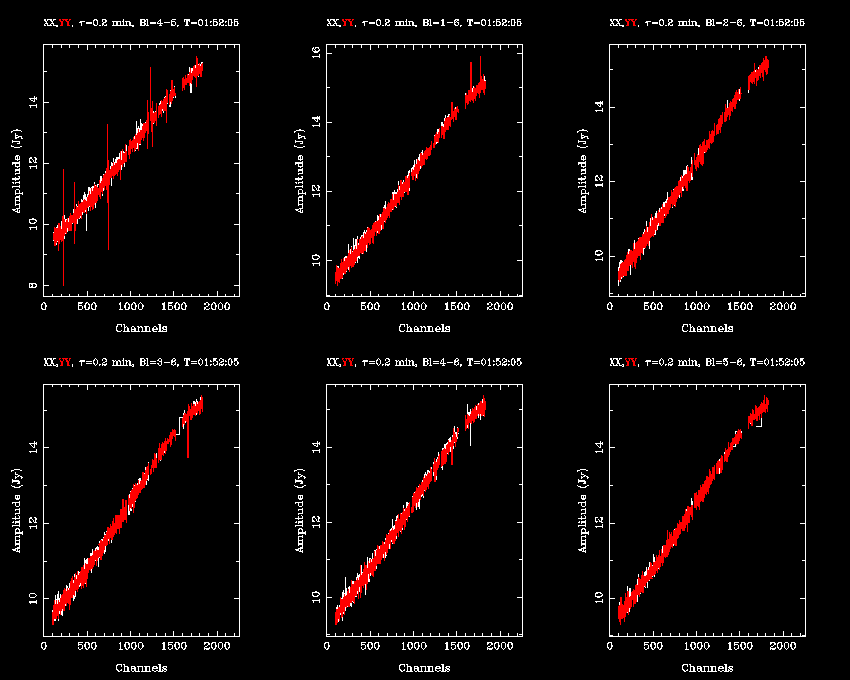

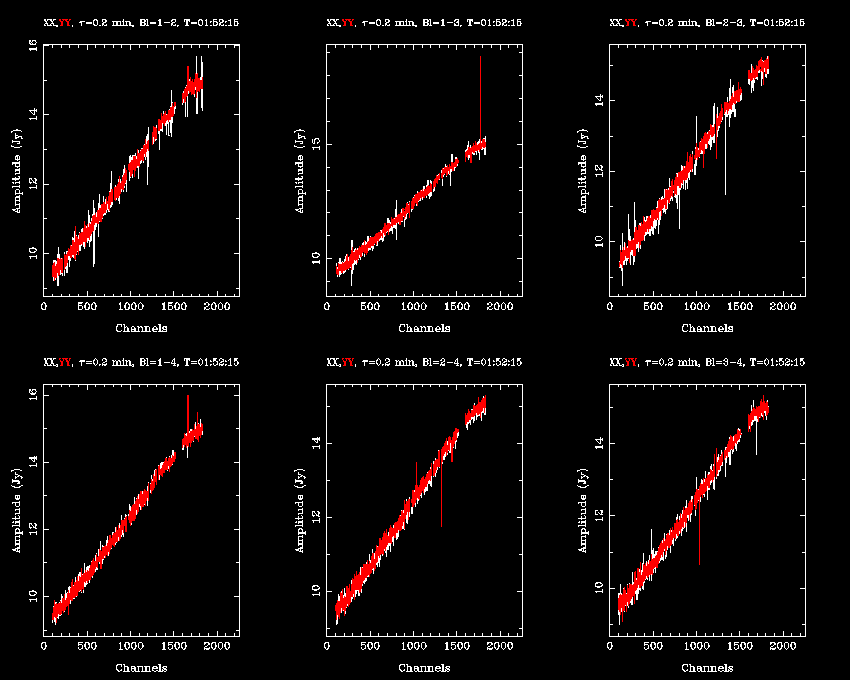

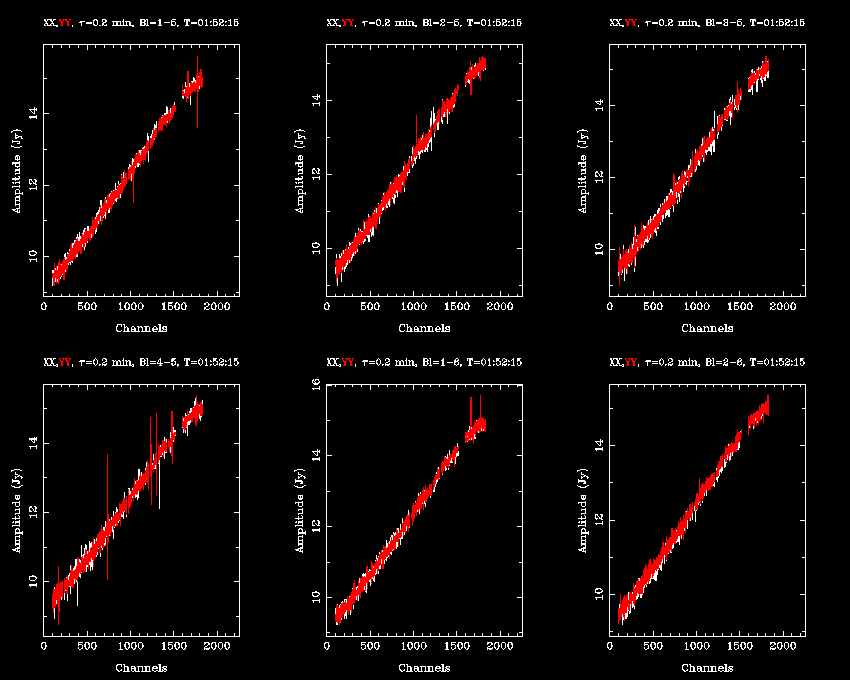

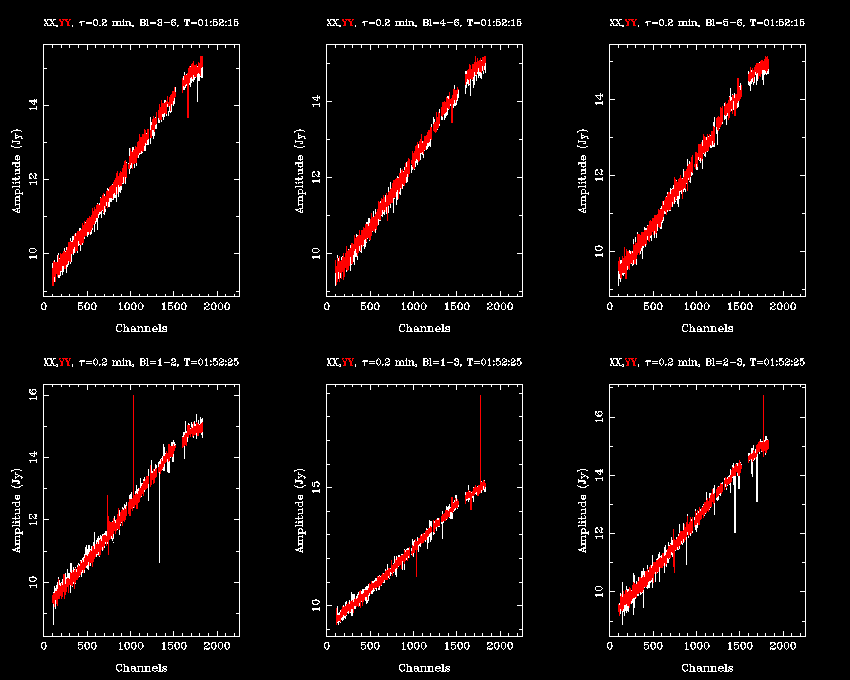

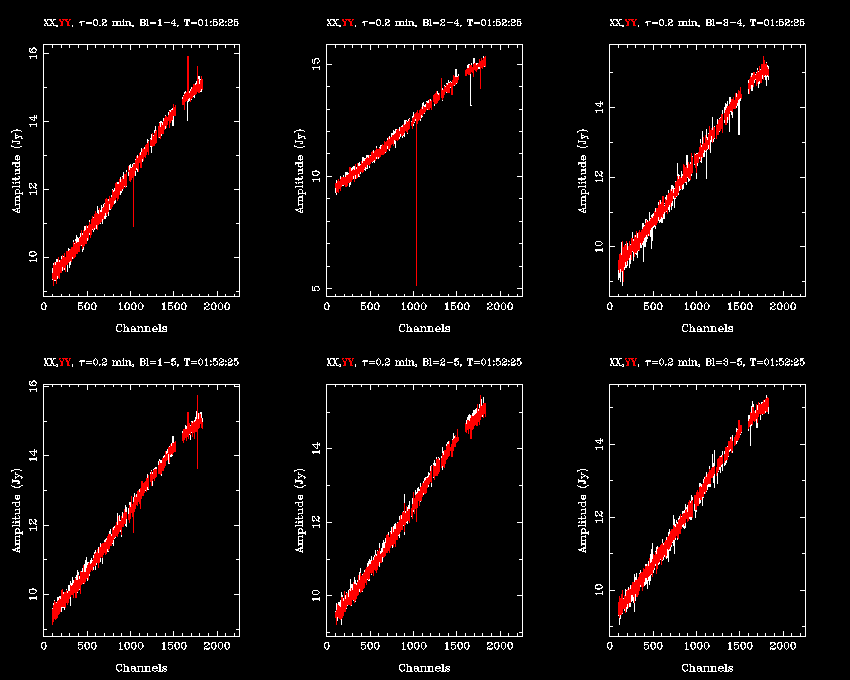

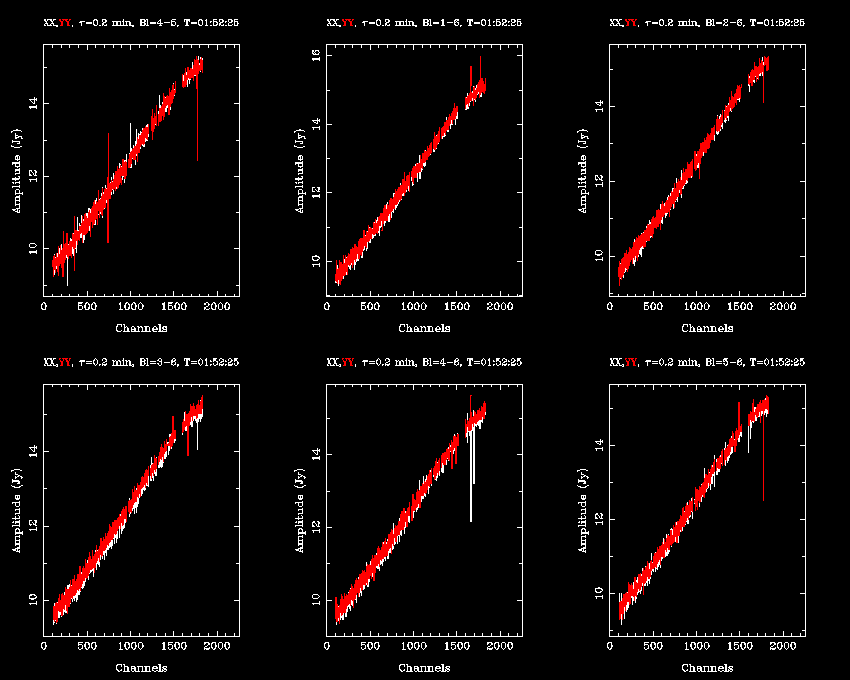

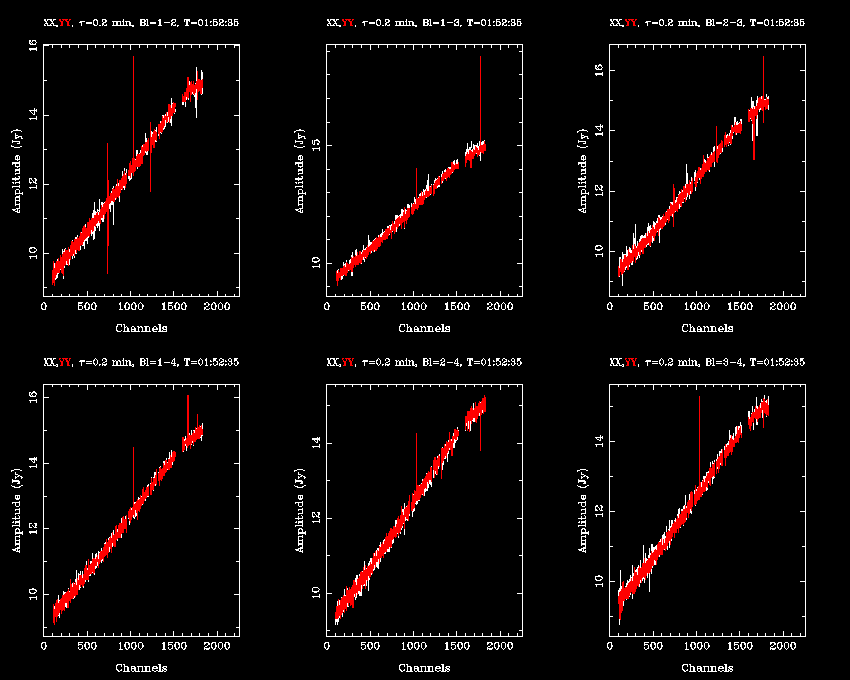

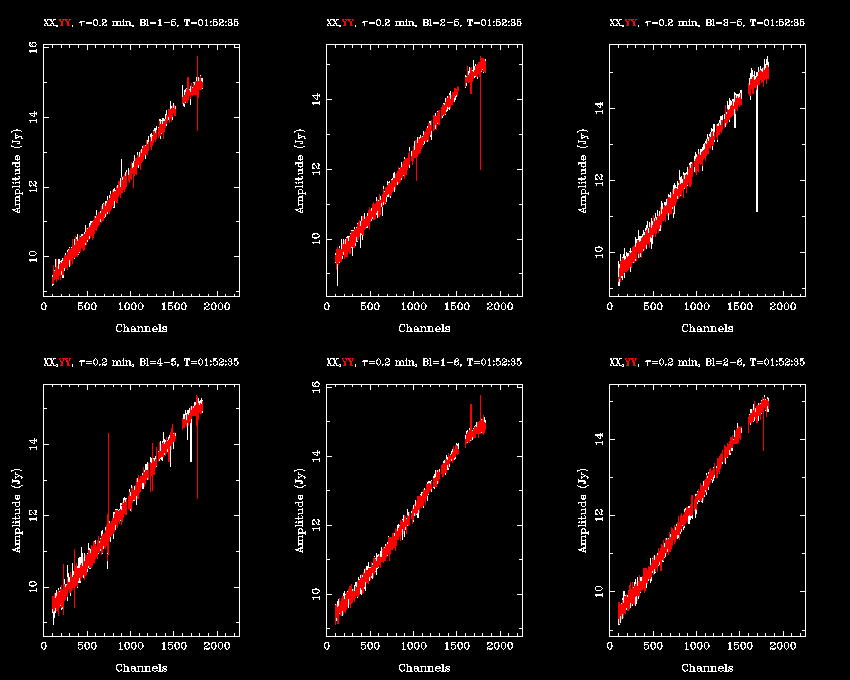

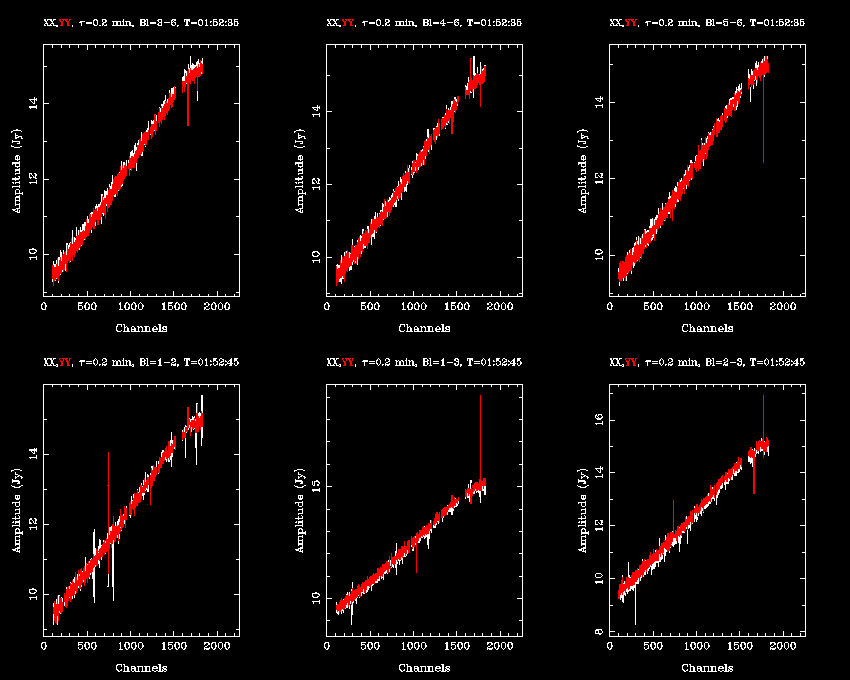

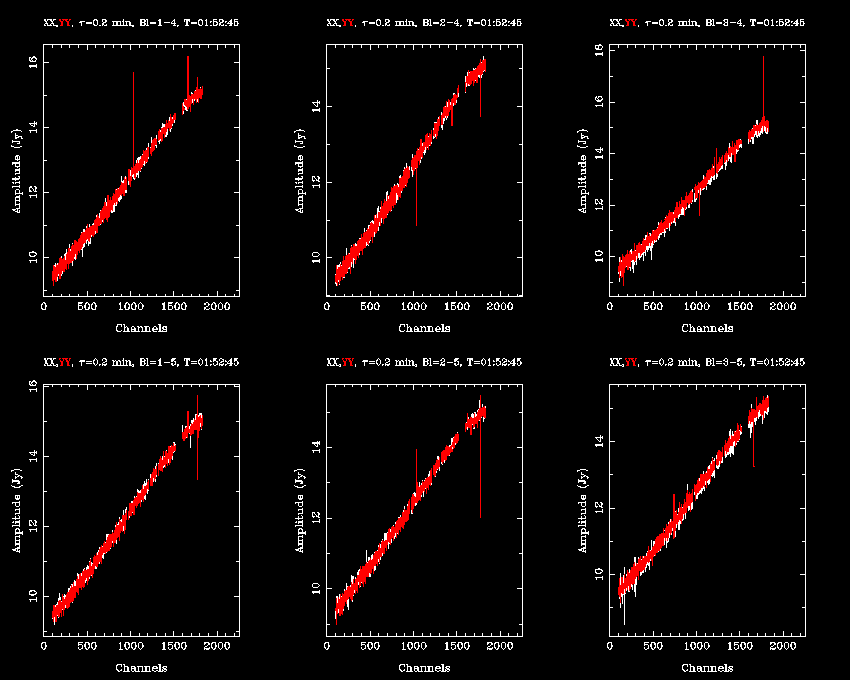

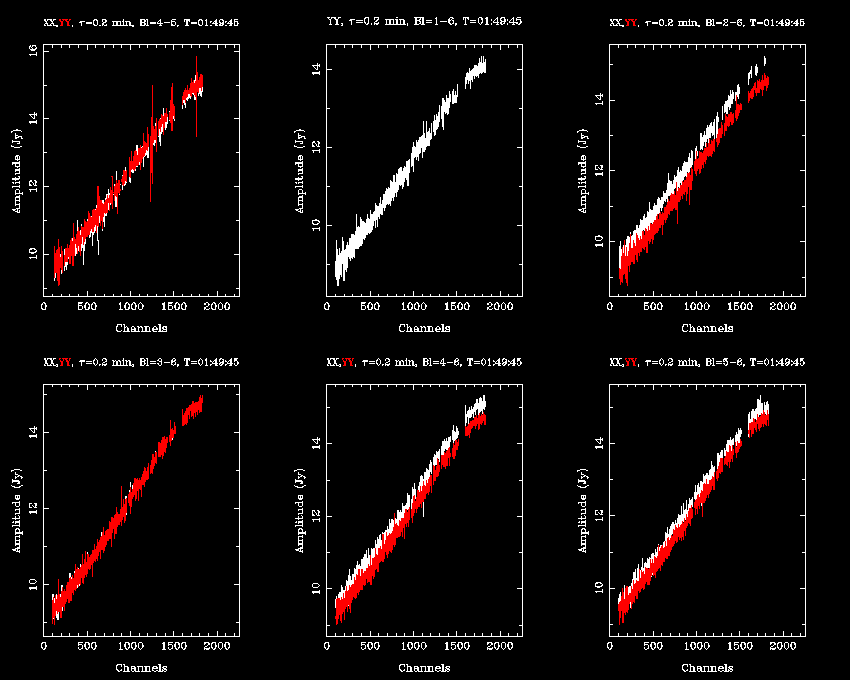

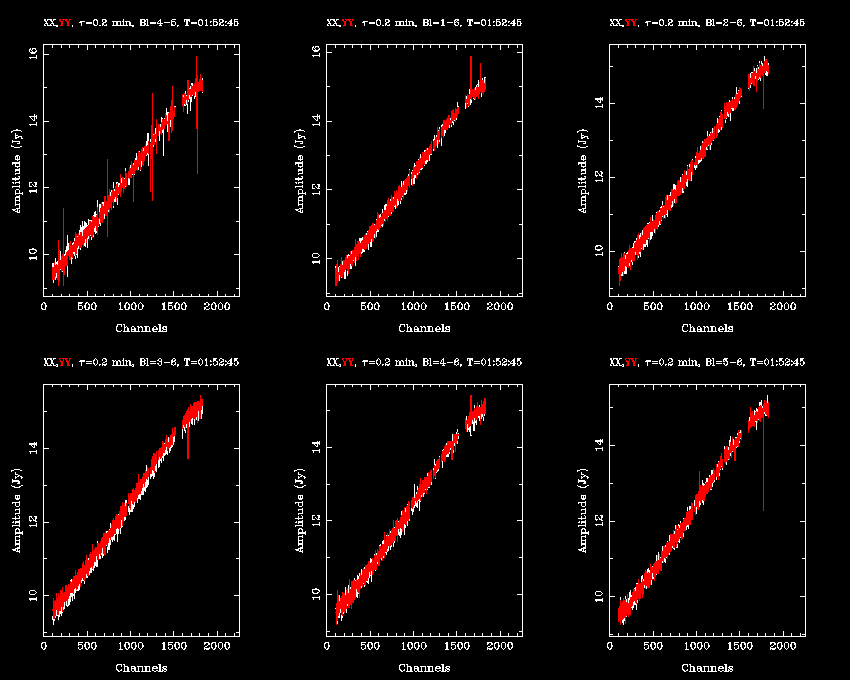

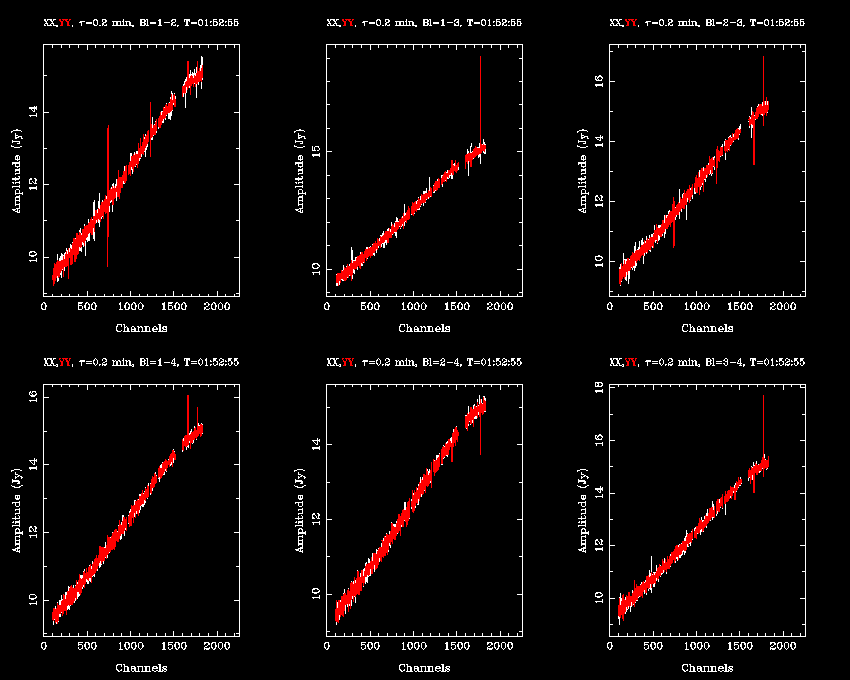

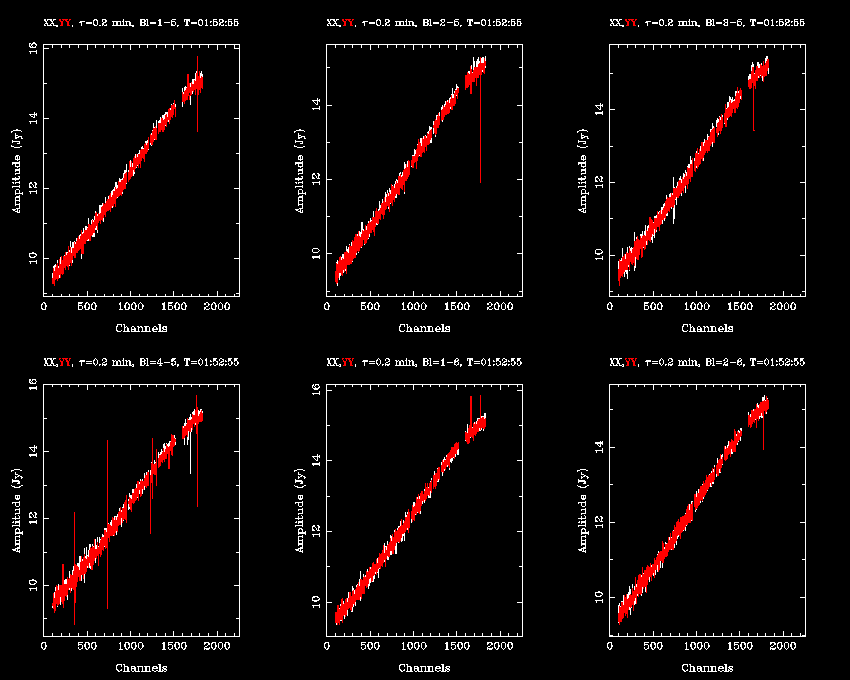

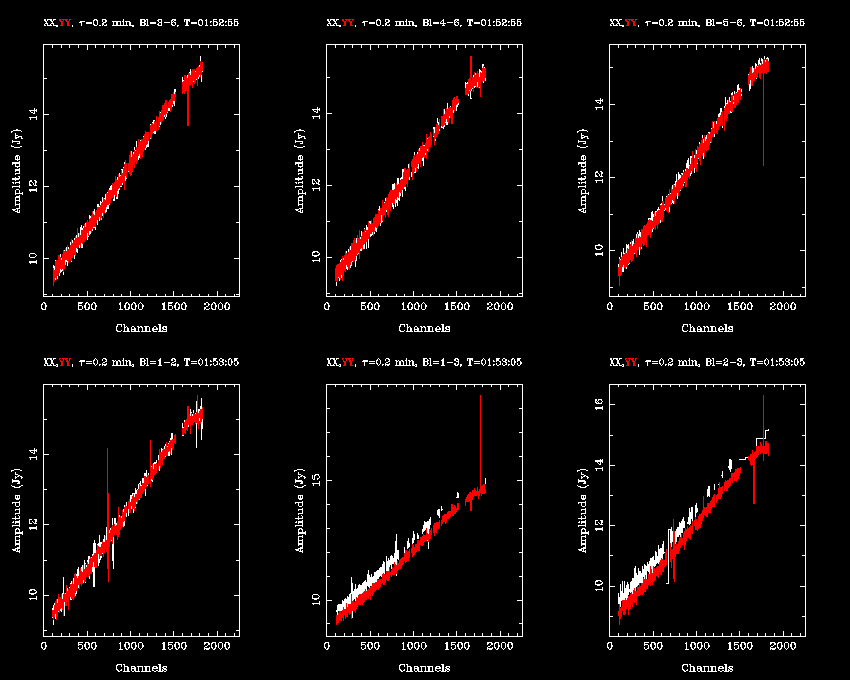

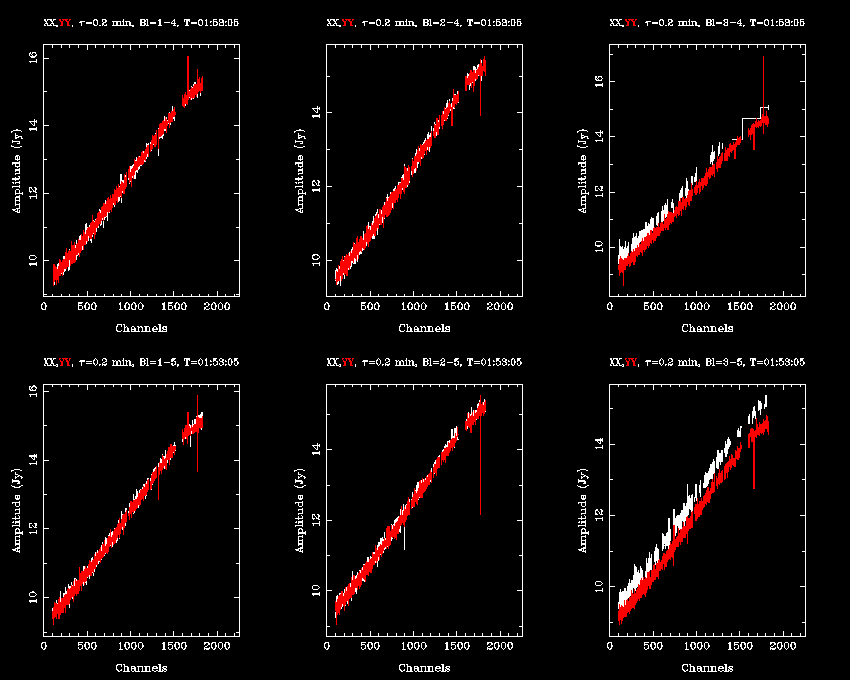

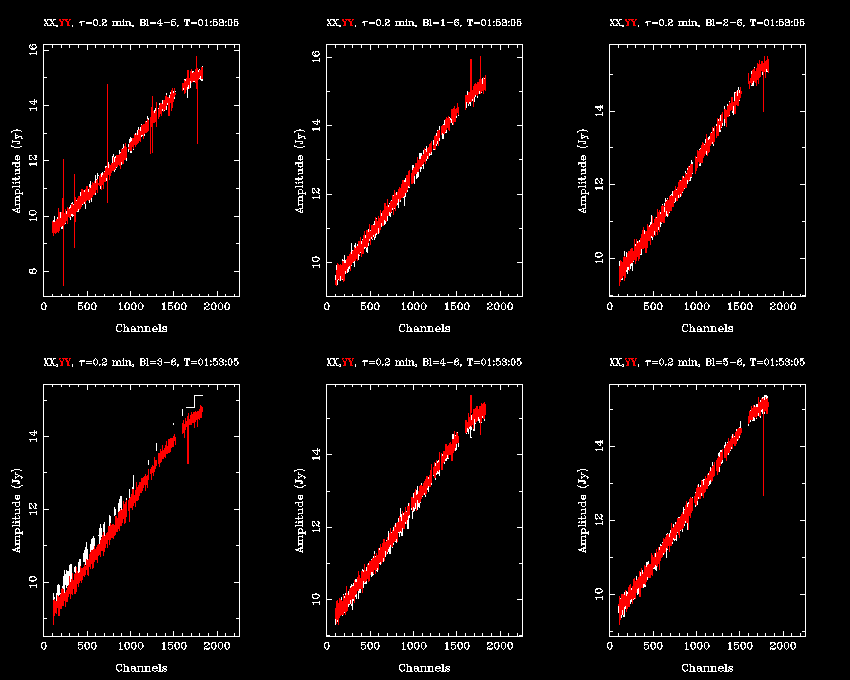

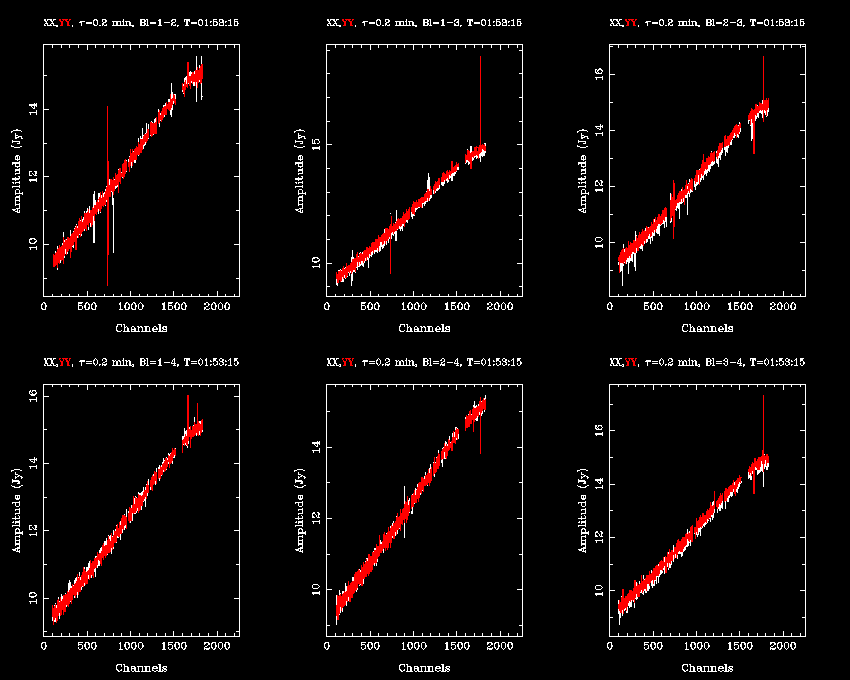

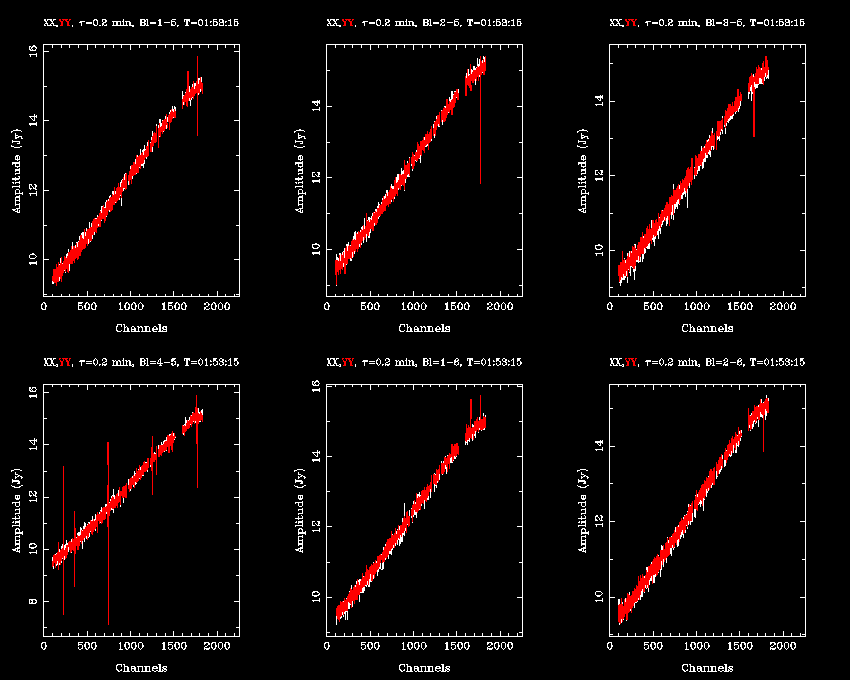

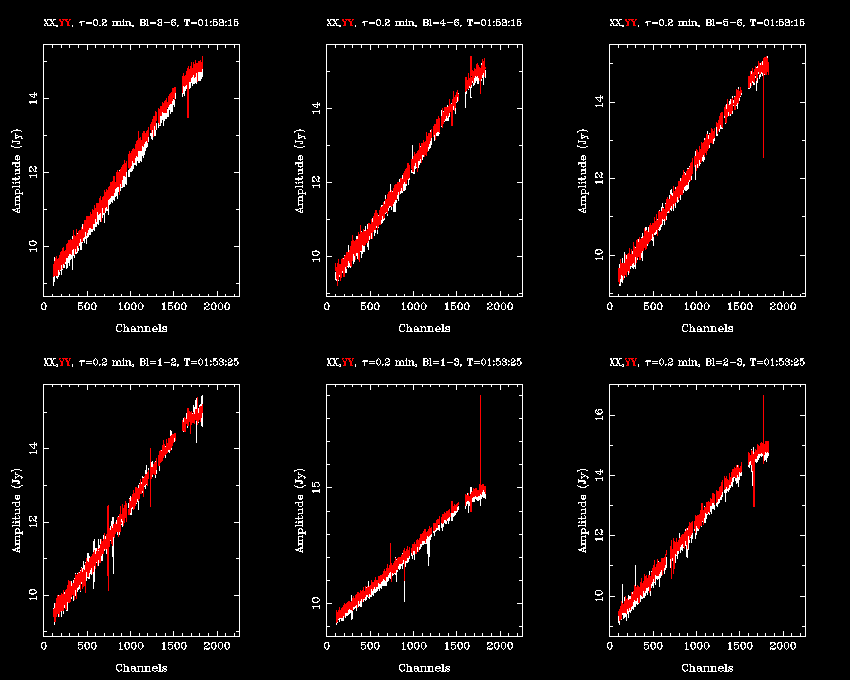

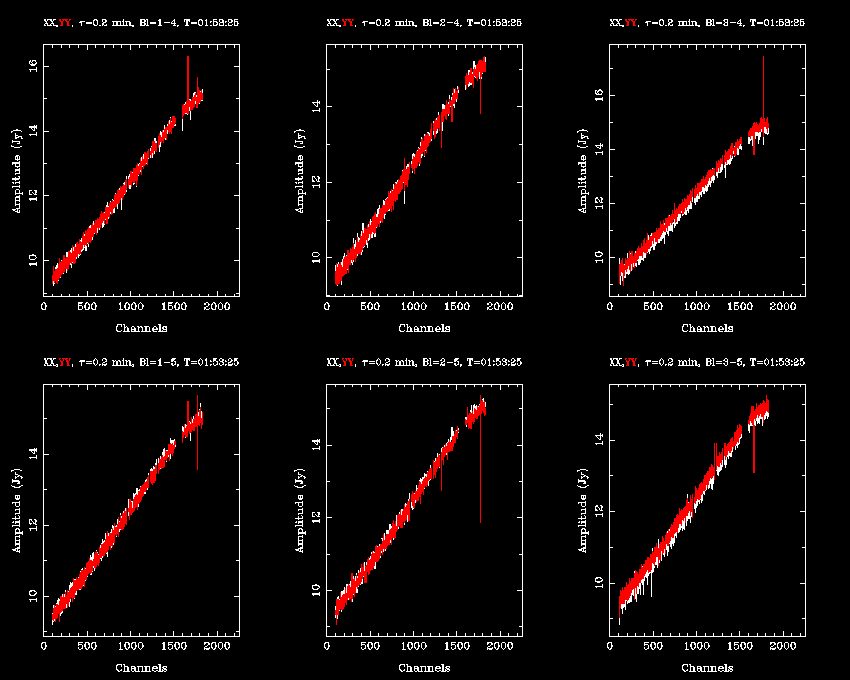

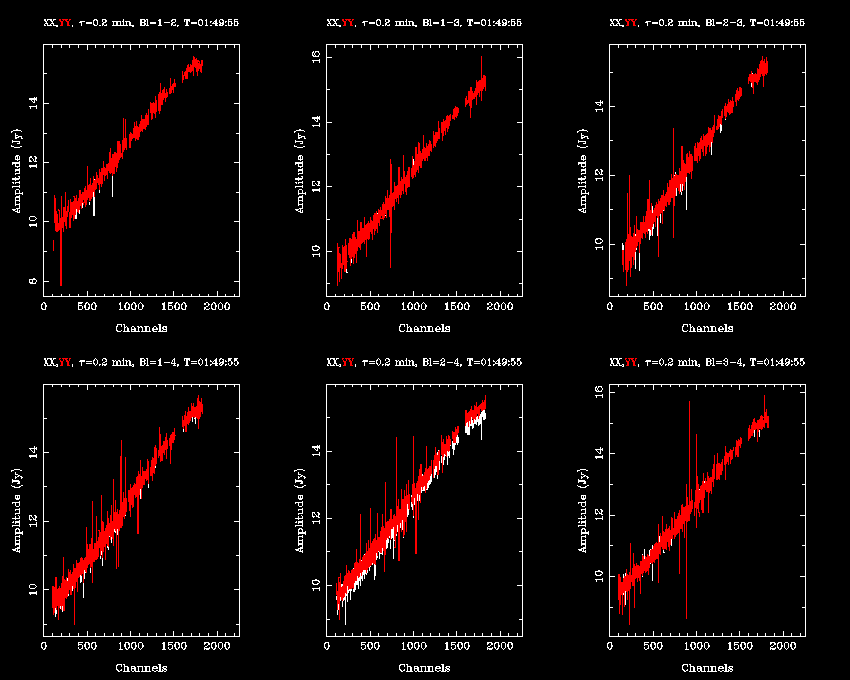

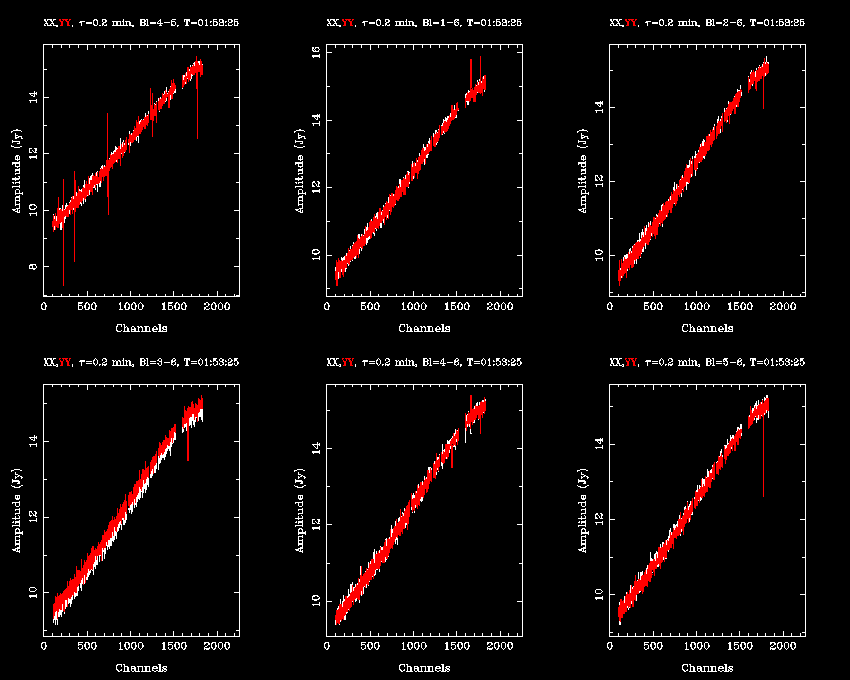

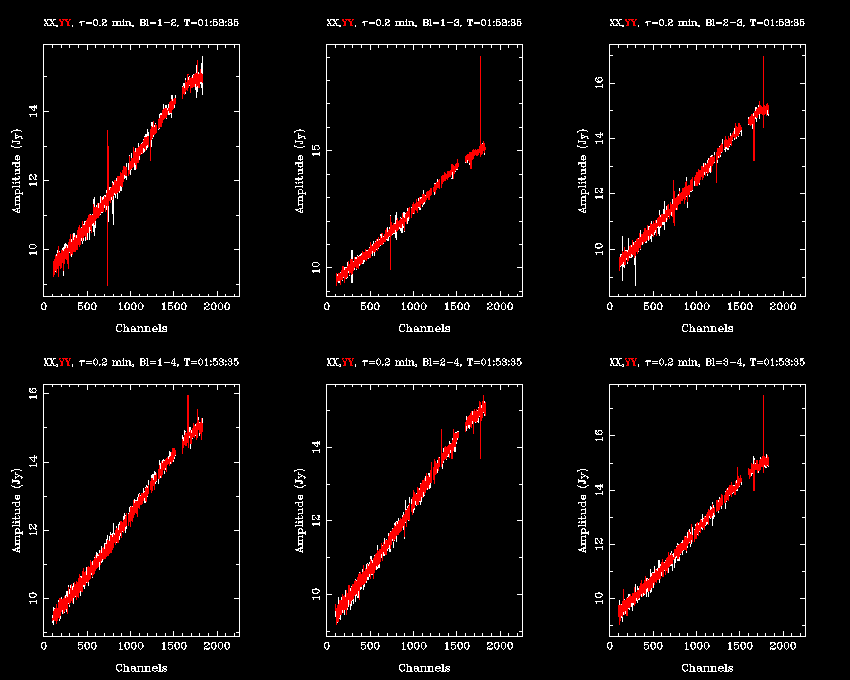

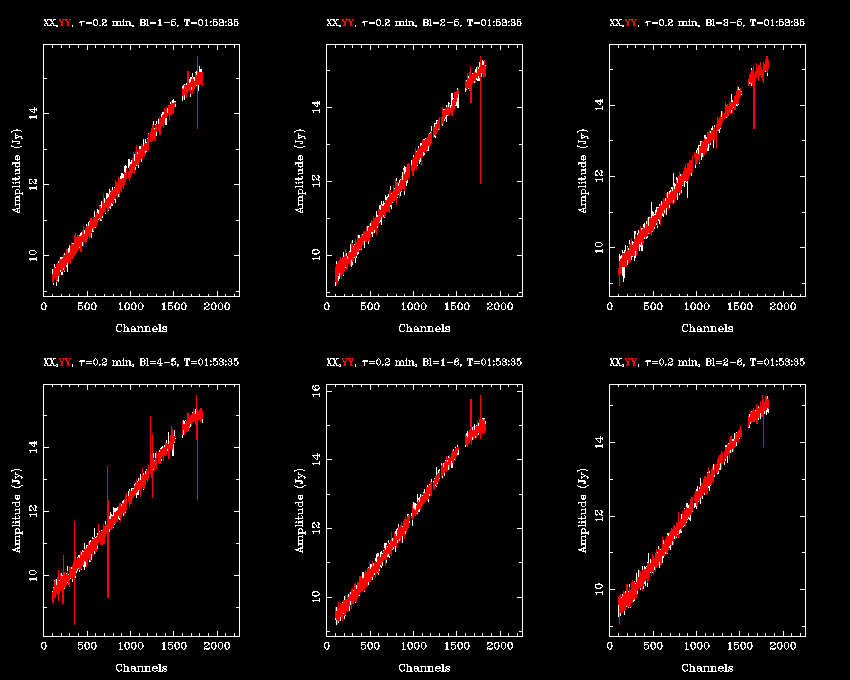

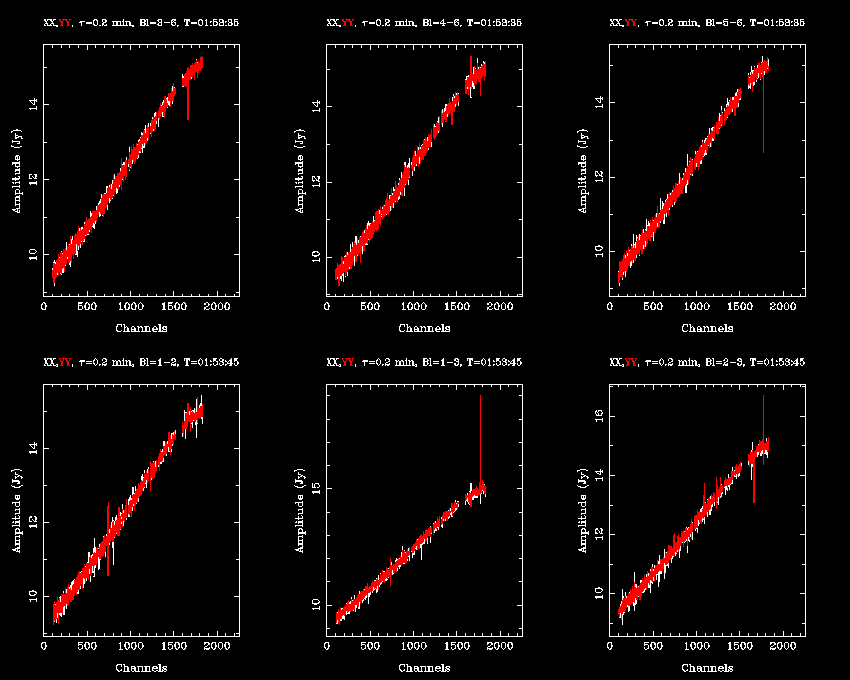

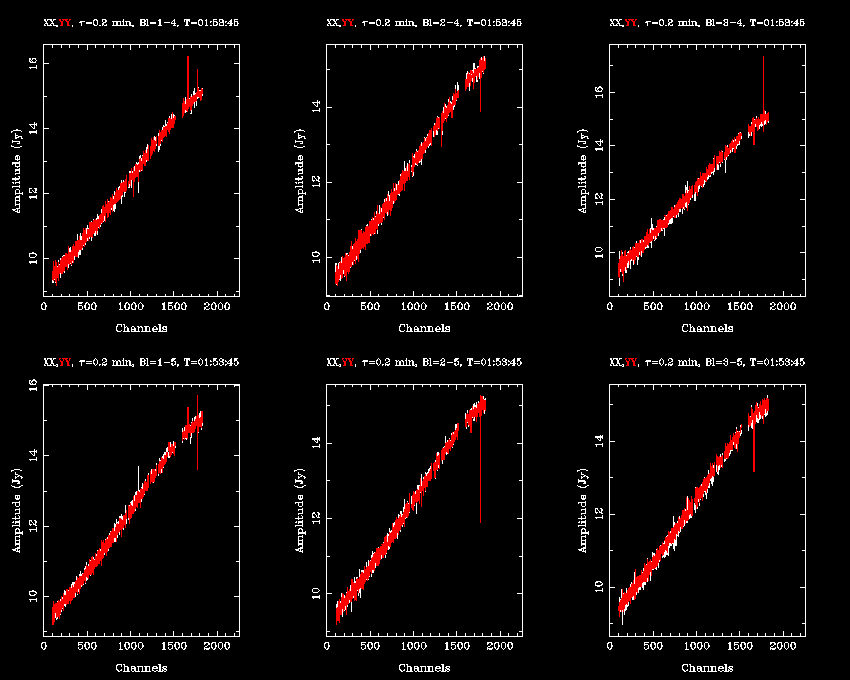

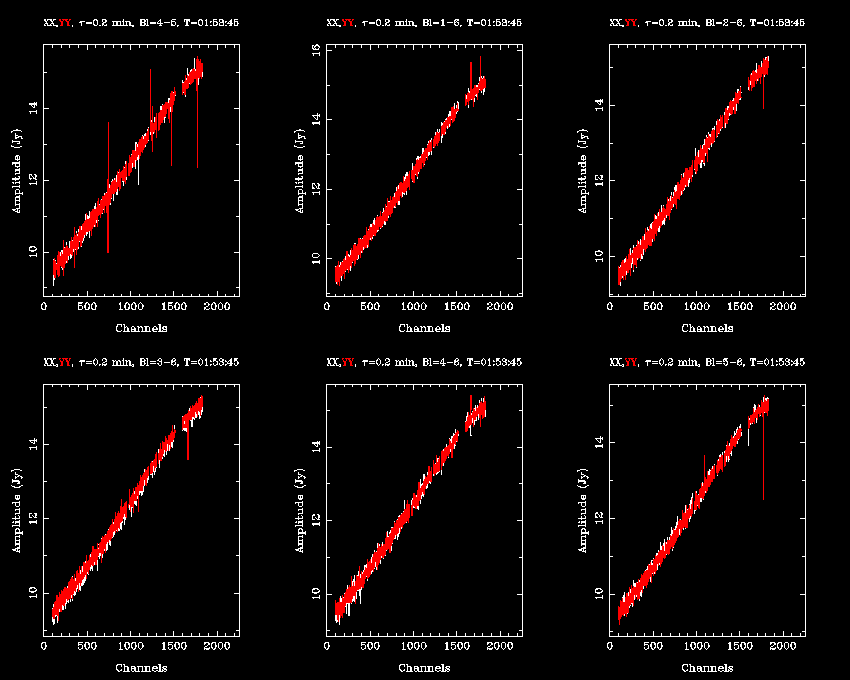

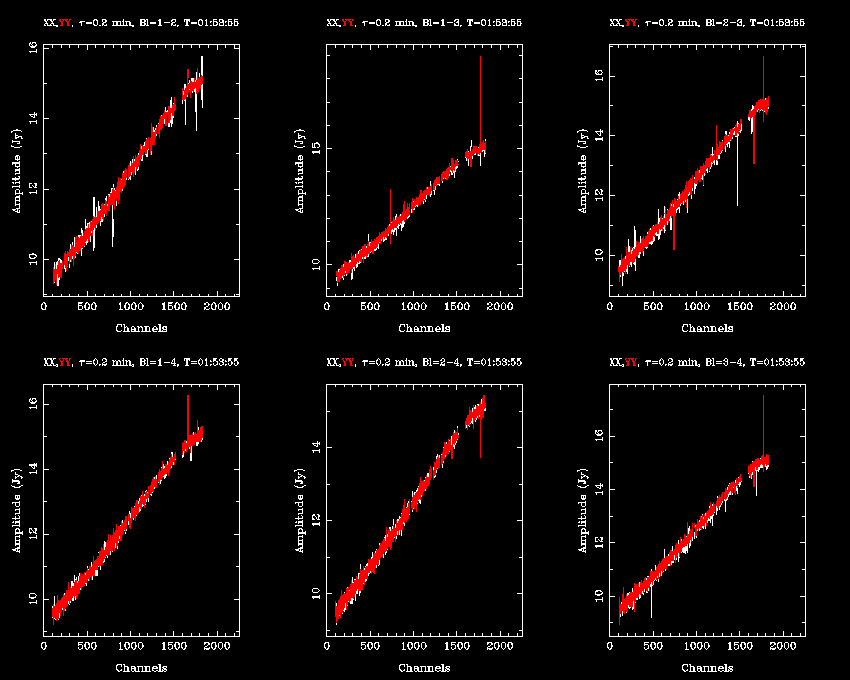

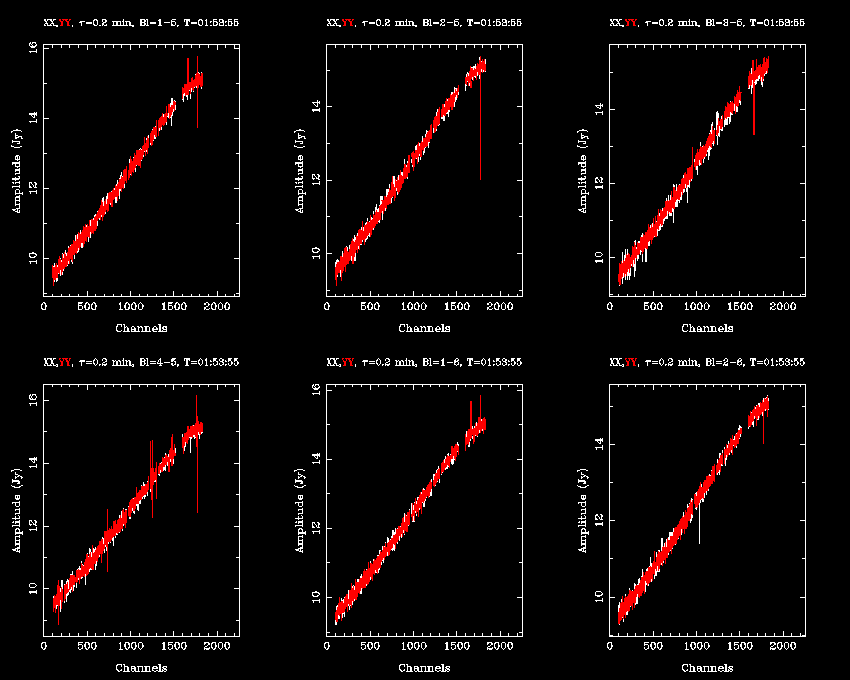

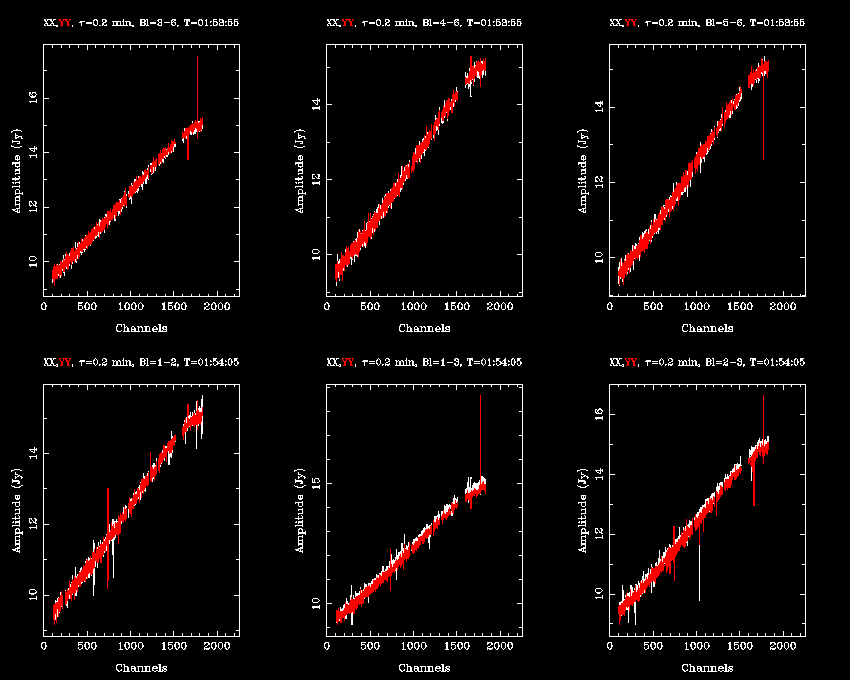

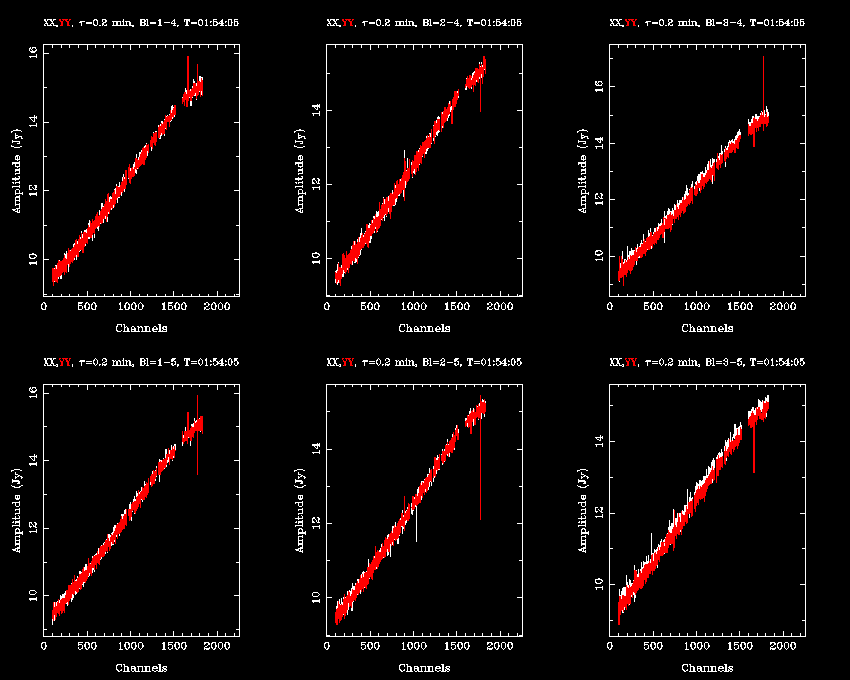

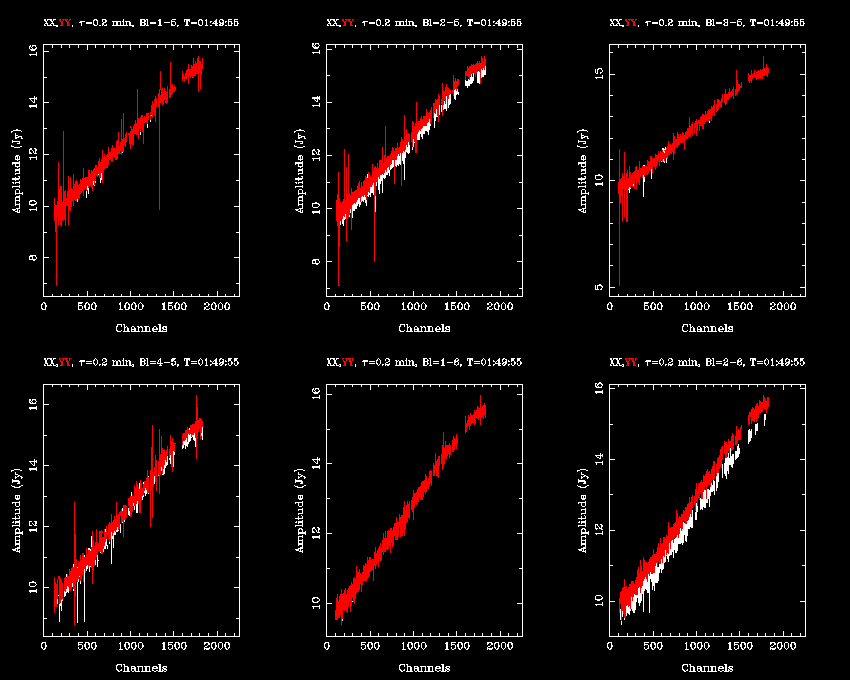

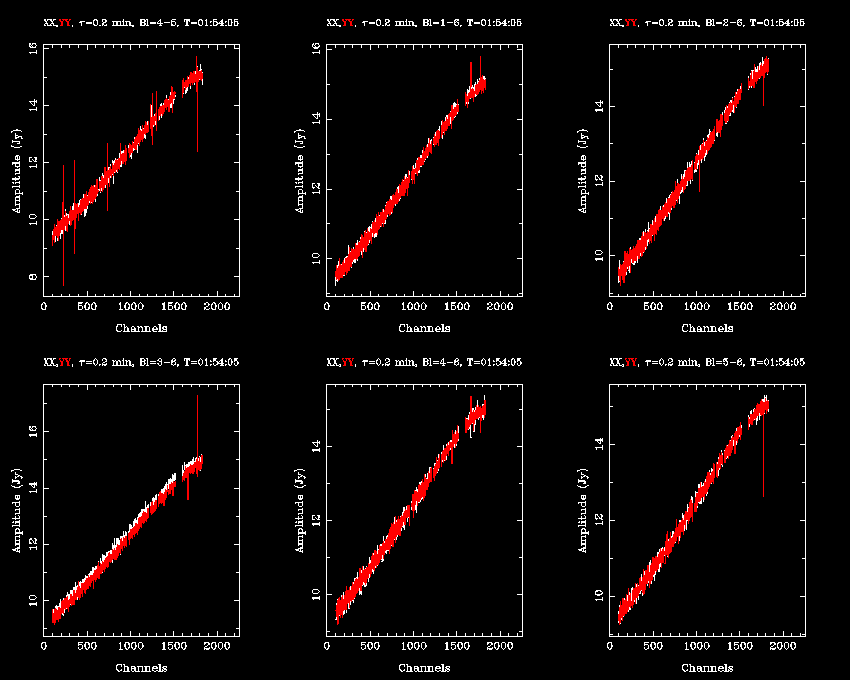

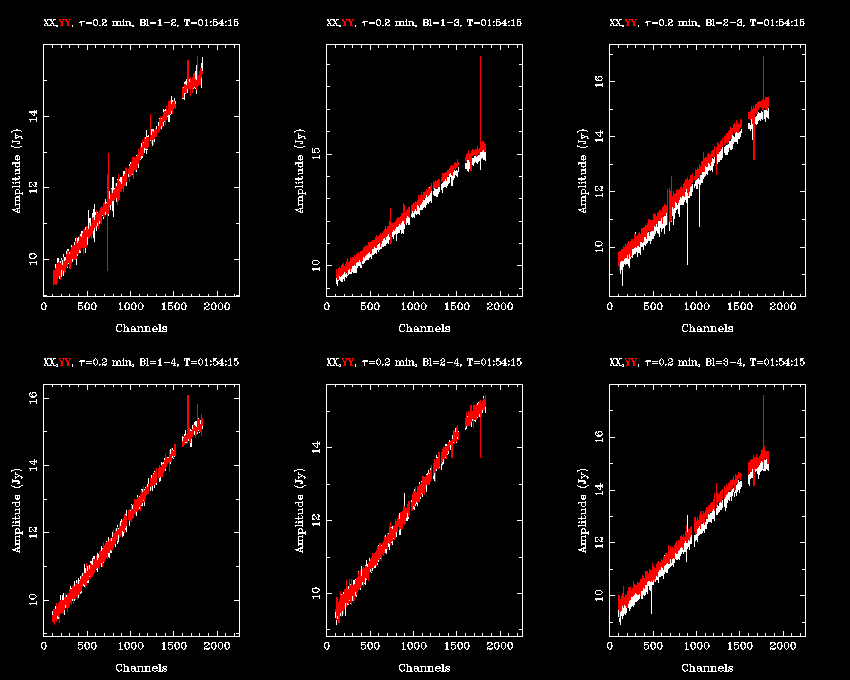

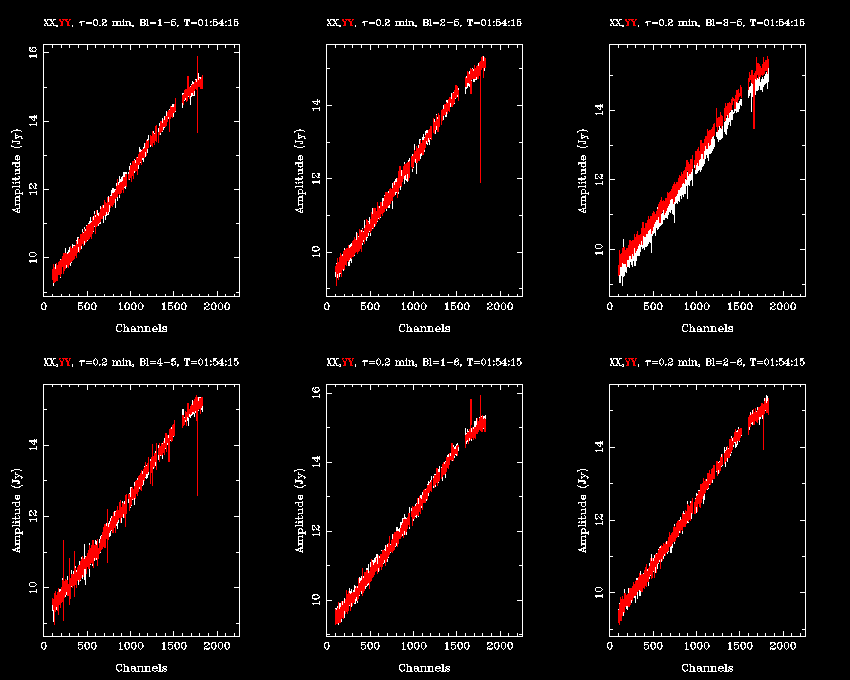

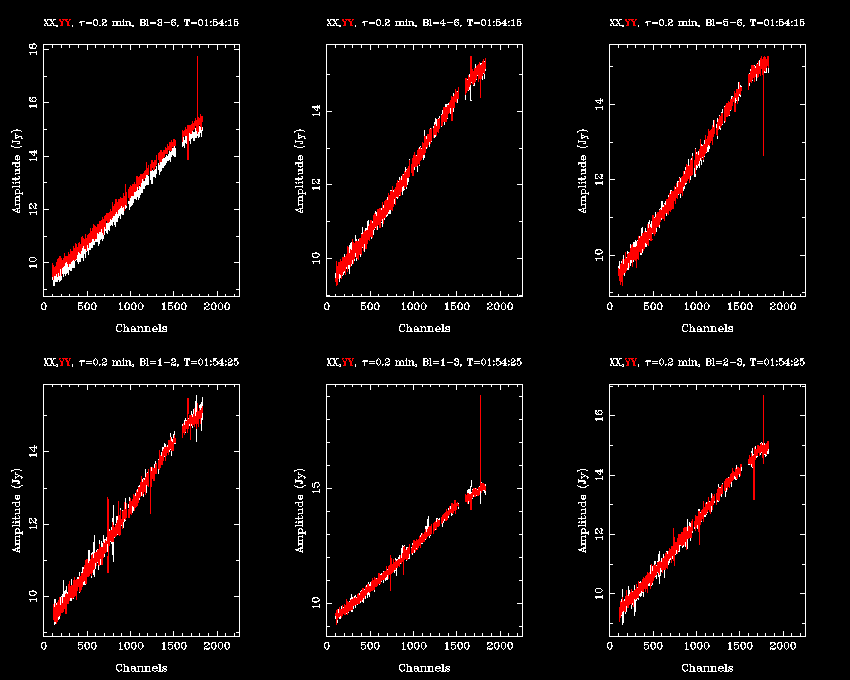

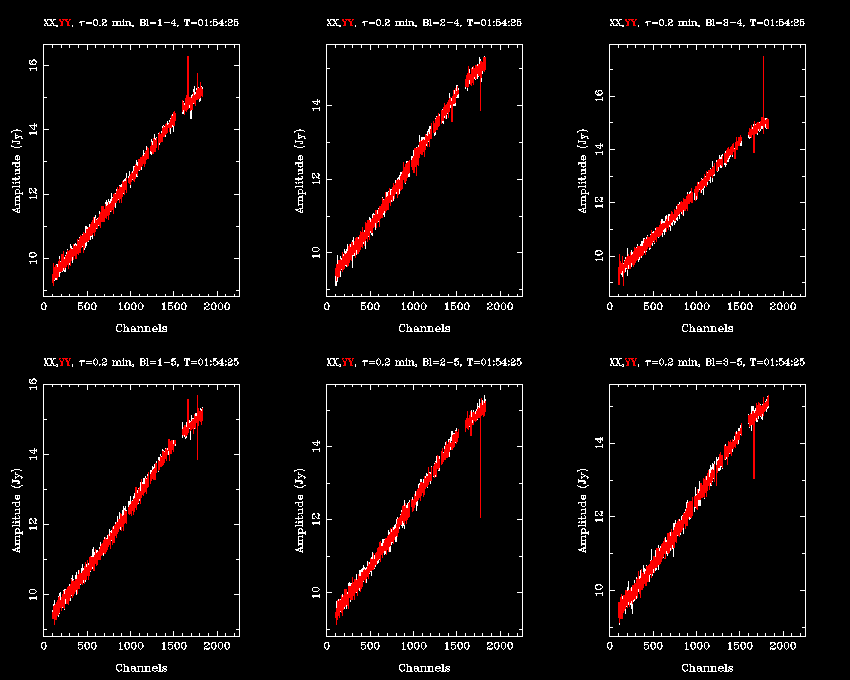

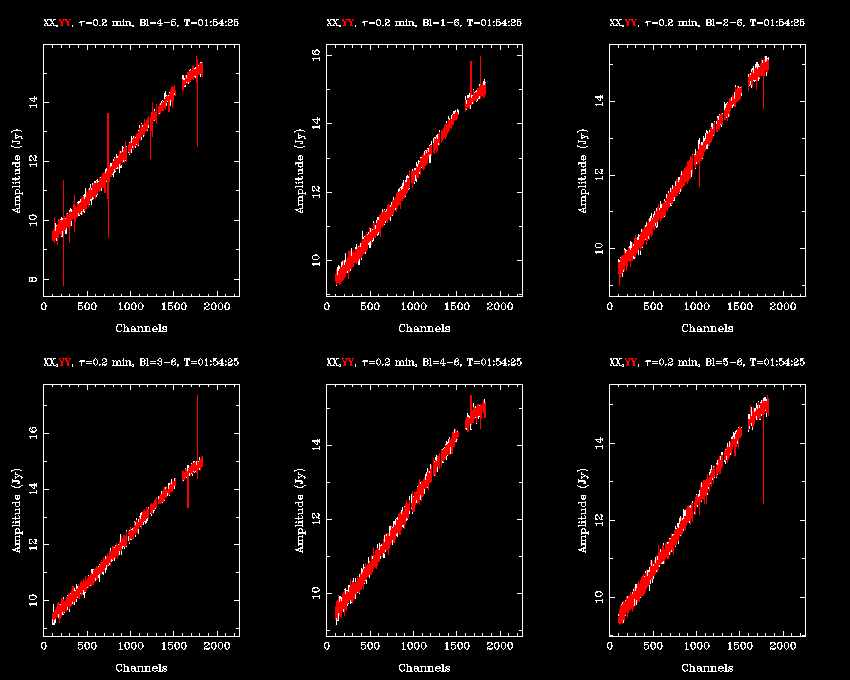

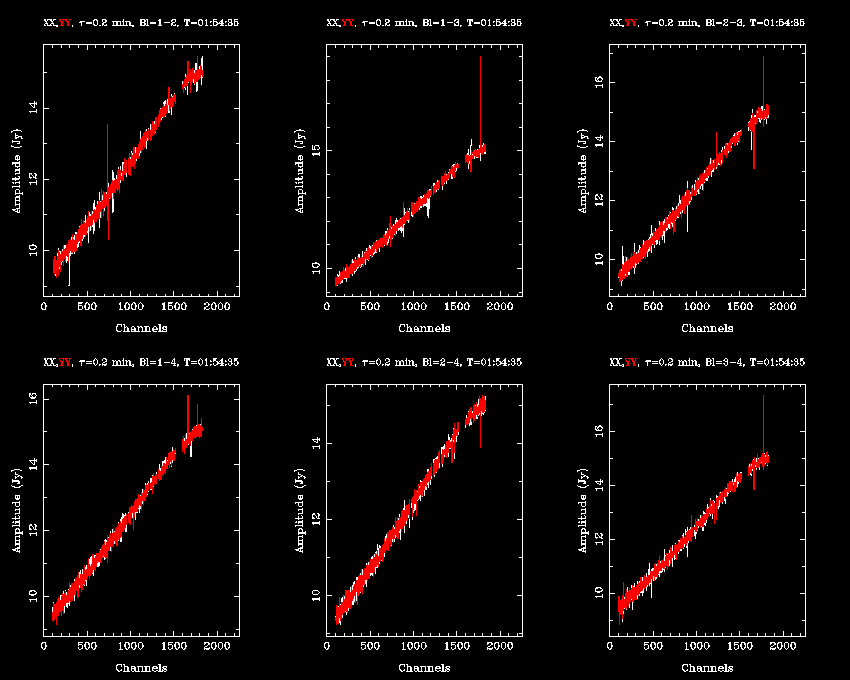

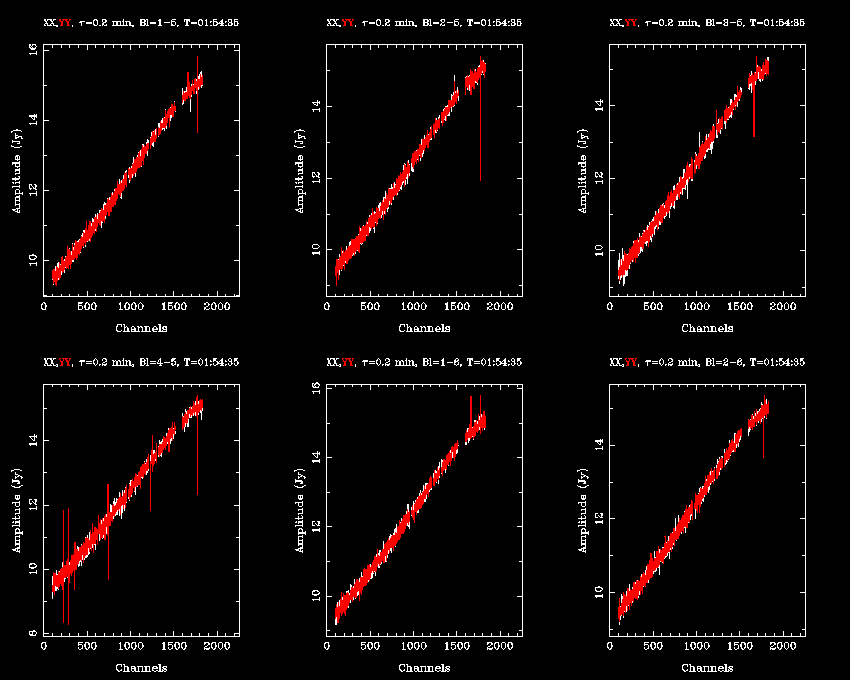

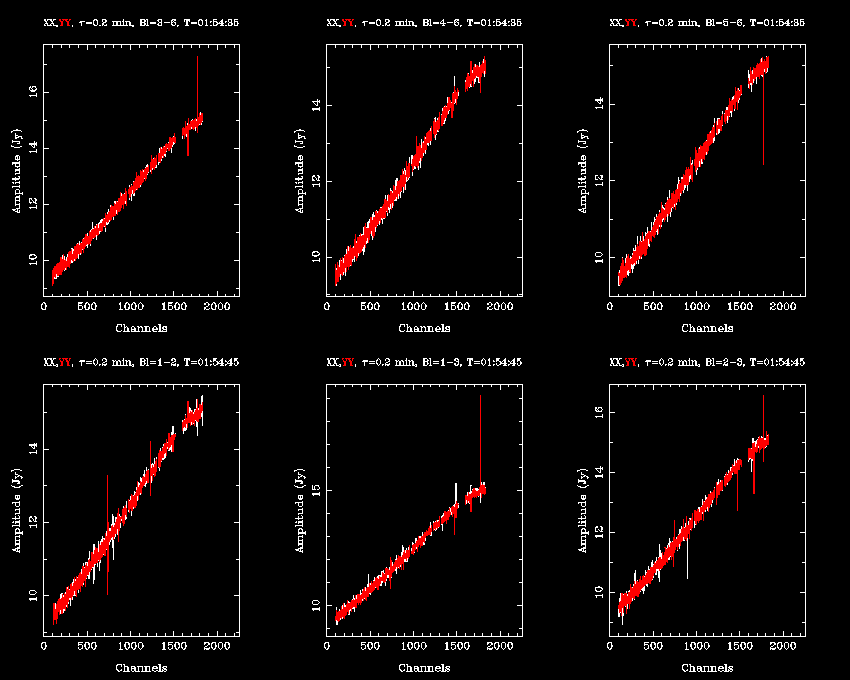

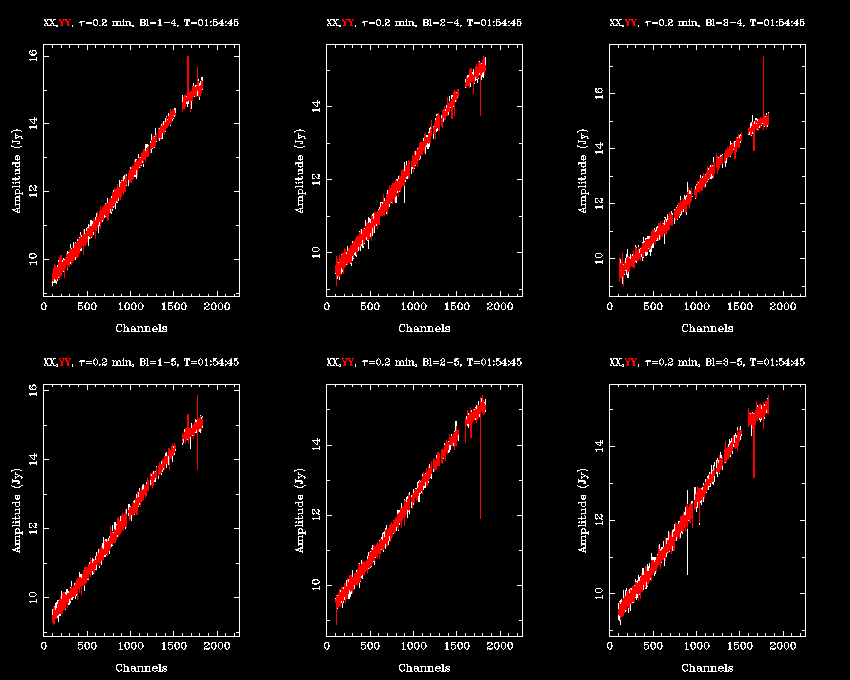

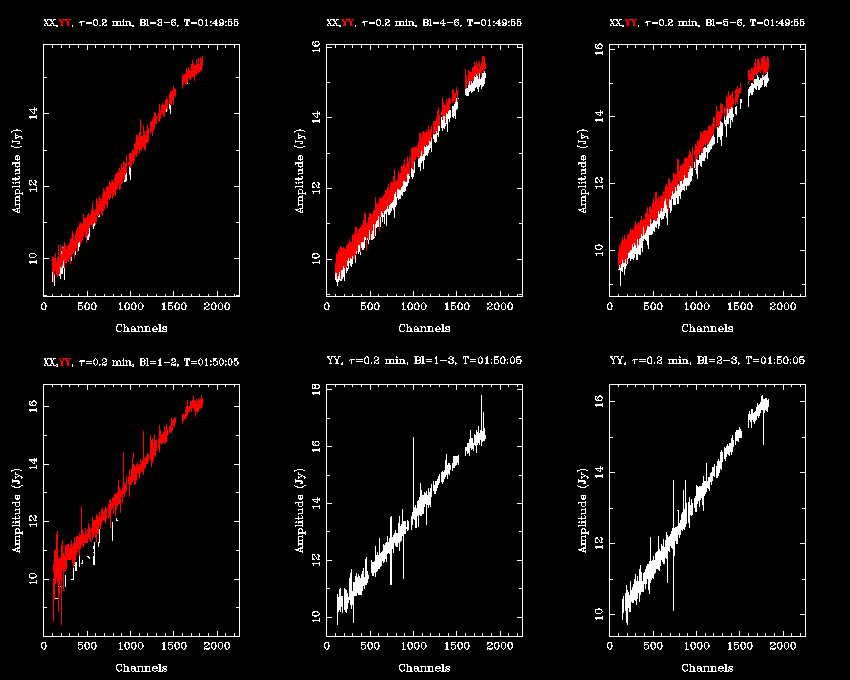

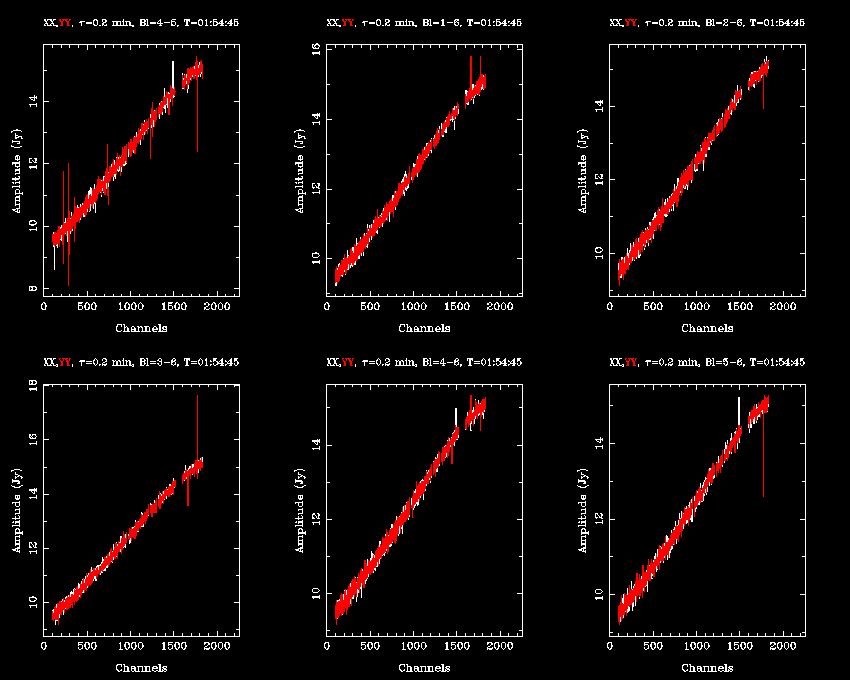

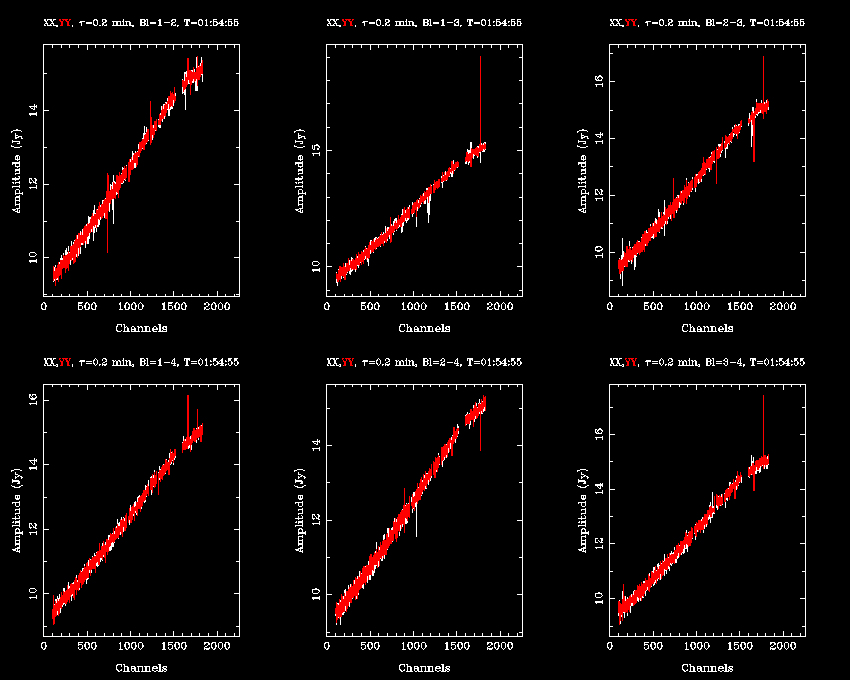

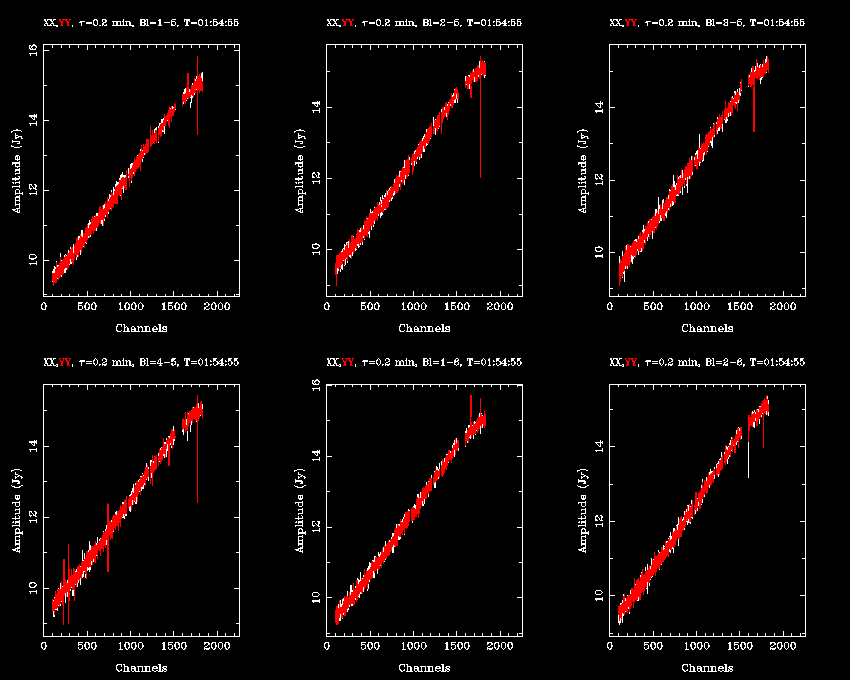

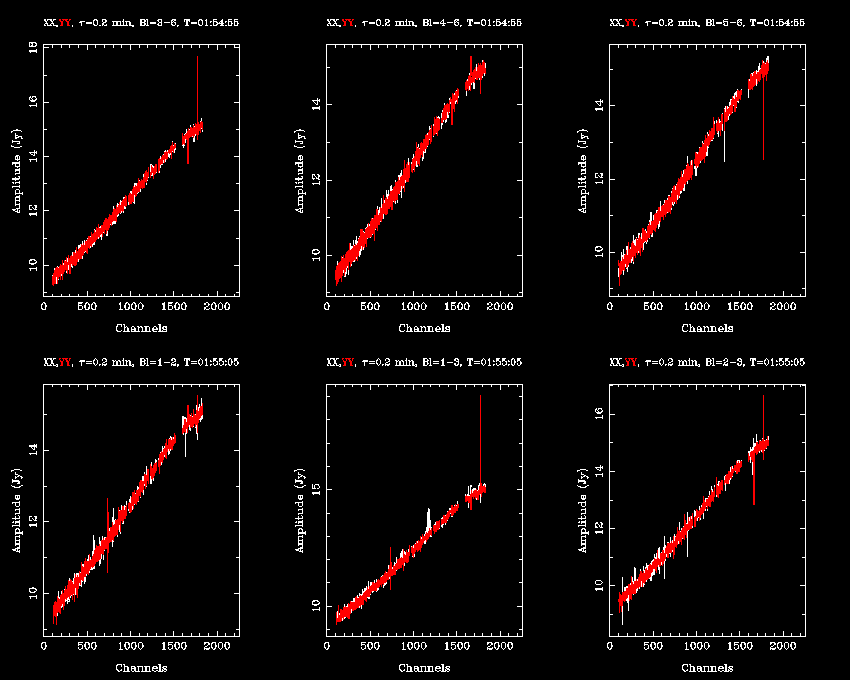

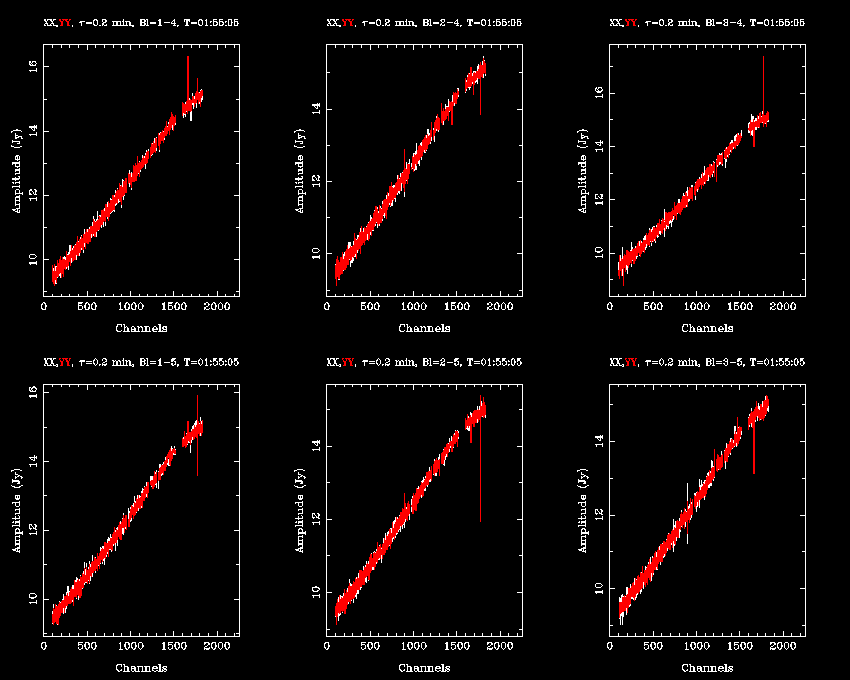

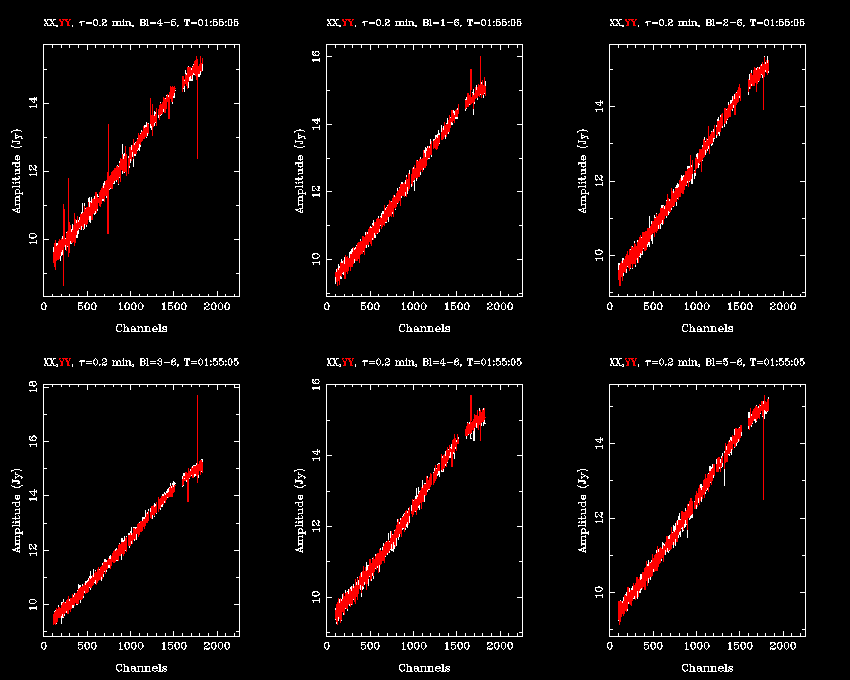

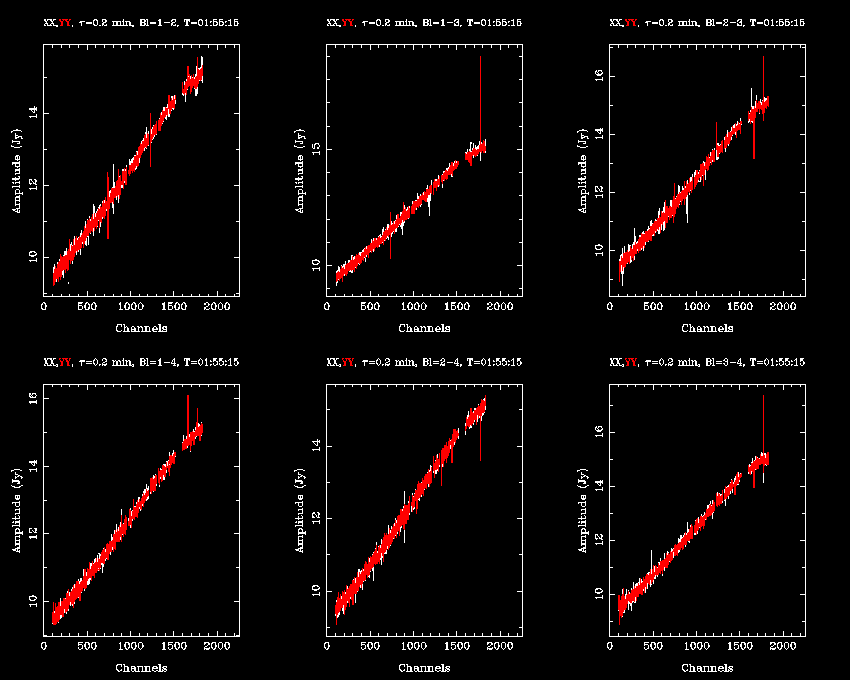

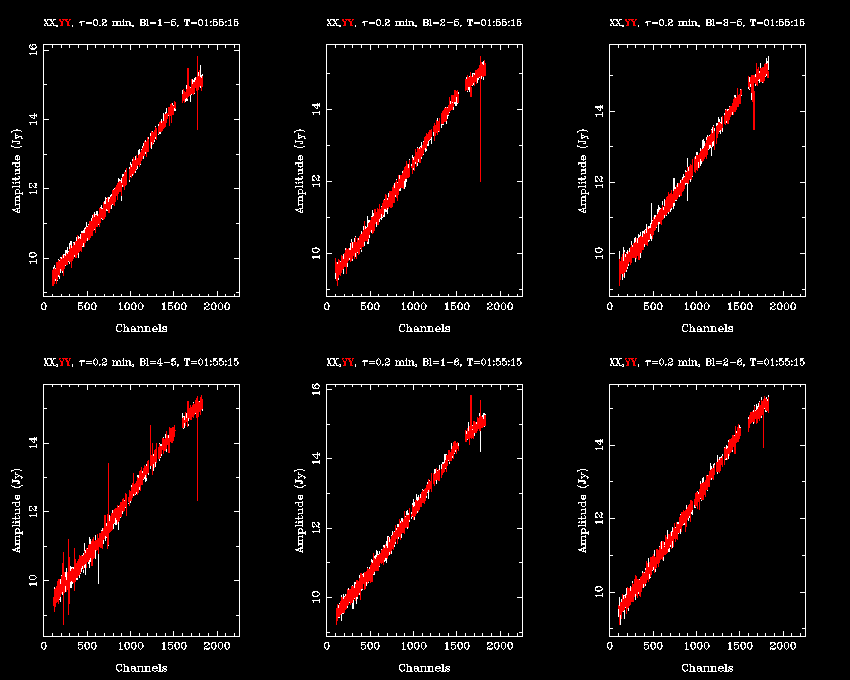

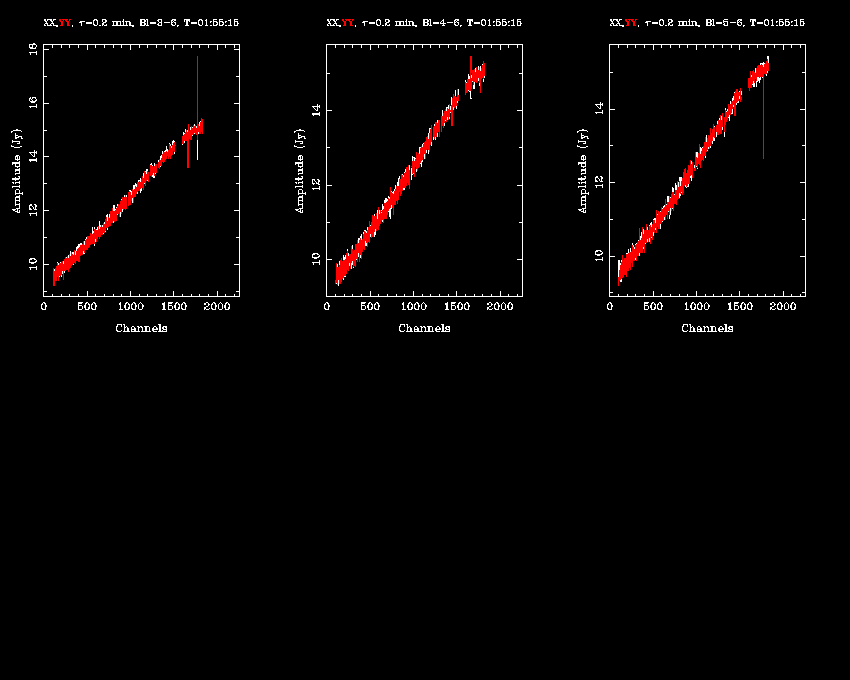

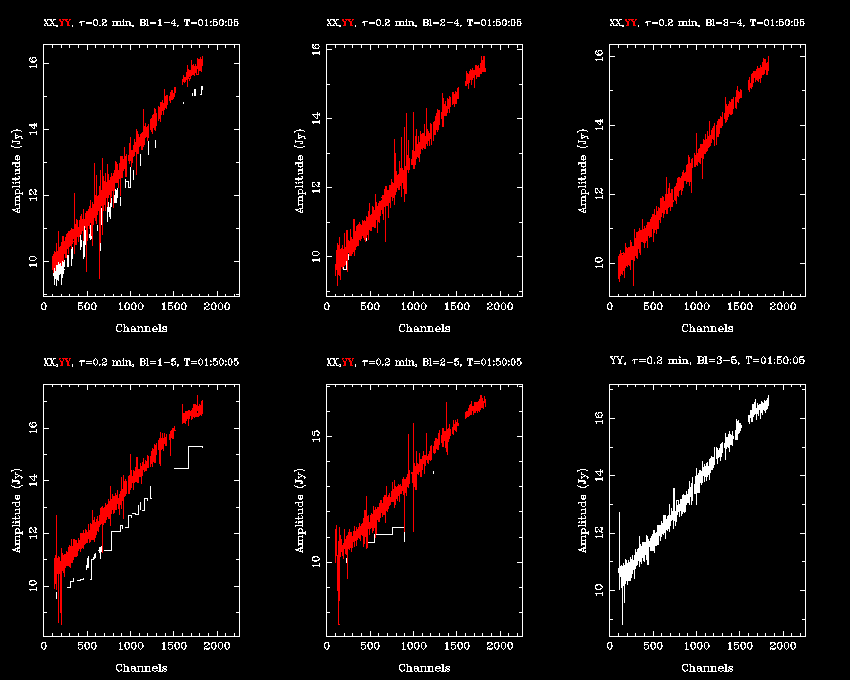

blflag: Revision 1.22, 2015/12/04 03:07:29 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Reading the data...
Number of points to edit: 772078
Entering interactive mode...
Define a region - exit with x
Define a region - exit with x
Applying the flagging...
Total number of correlations:   4302900
Number of correlations flagged: 12686
MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $
Selecting parallel-hand polarisations
Reading the data ...
Number correlations accepted: 1424717
Number of frequency bands/settings: 1
Number of polarisations selected: 2
Number of solution intervals: 2
Number of passband solution intervals: 1
Initialising ...
Using post-Aug94 ATCA flux scale for 1934-638.
Using known frequency variation of 1934-638
Generating initial solution estimate ...
Doing solution refinement ...
Iter= 1, Solution Error:  0.673
Iter= 2, Solution Error:  0.006
Iter= 3, Solution Error:  0.000
Saving solution ...
##########Post RFI band

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'mfcal':  Correlations flagged or edge-rejected: 726733
  warnings.warn(msg)


uvplt: Revision 1.18, 2014/05/21 04:34:59 UTC

Will plot unflagged data

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100


File # 1  = 1934-638.2100
1934-638.2100 2.1000 GHz
Read 1037 visibilities from all files

Baseline 1-2, plot 87951 points
Baseline 1-3, plot 90598 points
Baseline 2-3, plot 90155 points
Baseline 1-4, plot 97754 points
Baseline 2-4, plot 101394 points
Baseline 3-4, plot 93331 points
Baseline 1-5, plot 95369 points
Baseline 2-5, plot 99545 points
Baseline 3-5, plot 92925 points
Baseline 4-5, plot 94560 points
Baseline 1-6, plot 93740 points
Baseline 2-6, plot 97640 points
Baseline 3-6, plot 93221 points
Baseline 4-6, plot 98141 points
Baseline 5-6, plot 98393 points


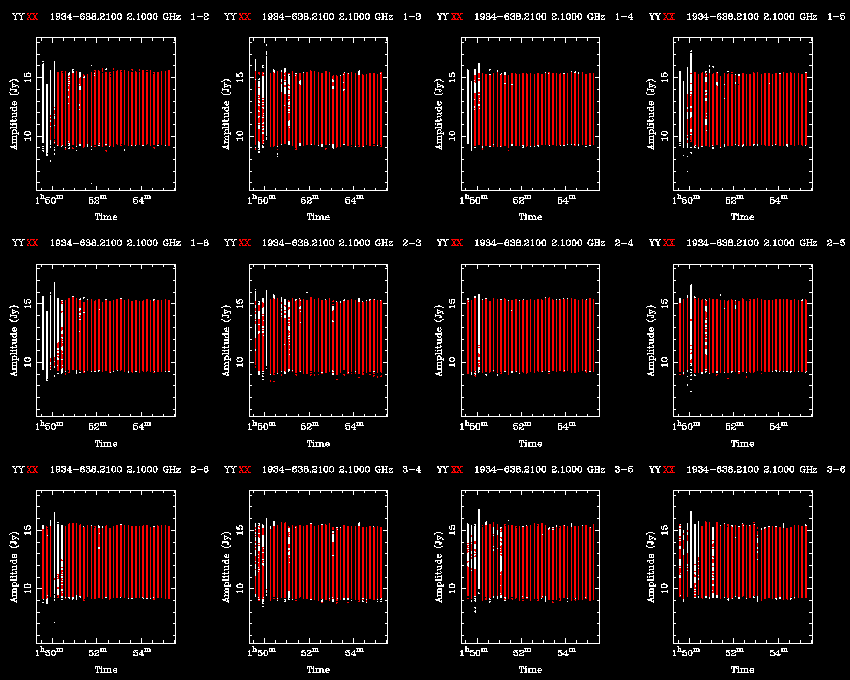

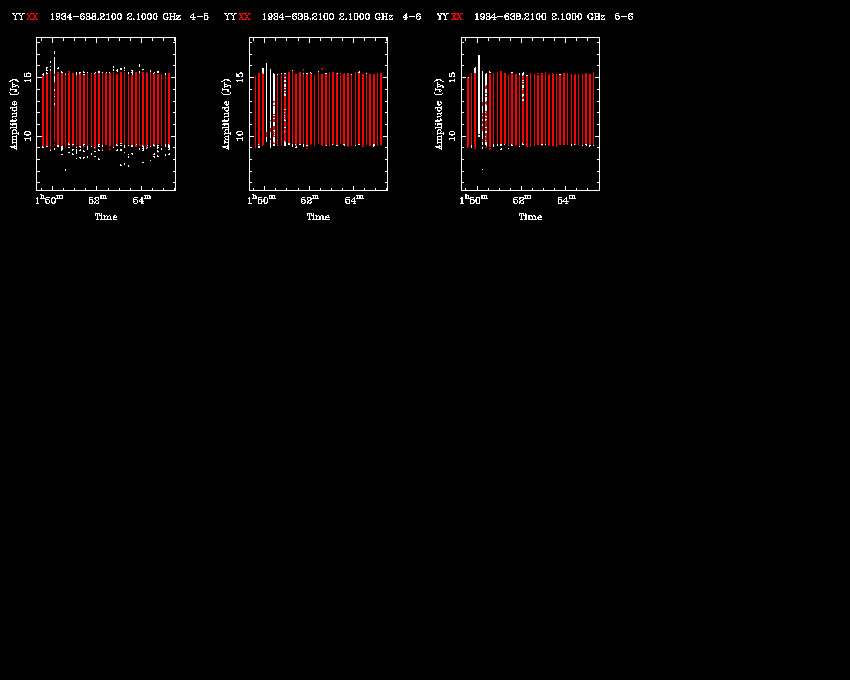

pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Do SumThreshold operation on baseline   1   2
 32.4% of the data on this baseline is now flagged
 32.4% of the data on this baseline is now flagged
 32.7% of the data on this baseline is now flagged
Blow away the dust...
 32.8% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   3
 30.0% of the data on this baseline is now flagged
 30.2% of the data on this baseline is now flagged
 30.8% of the data on this baseline is now flagged
Blow away the dust...
 30.9% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   2   3
 30.5% of the data on this baseline is now flagged
 30.6% of the data on this baseline is now flagged
 31.0% of the data on this baseline is now flagged
Blow away the dust...
 31.0% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   4


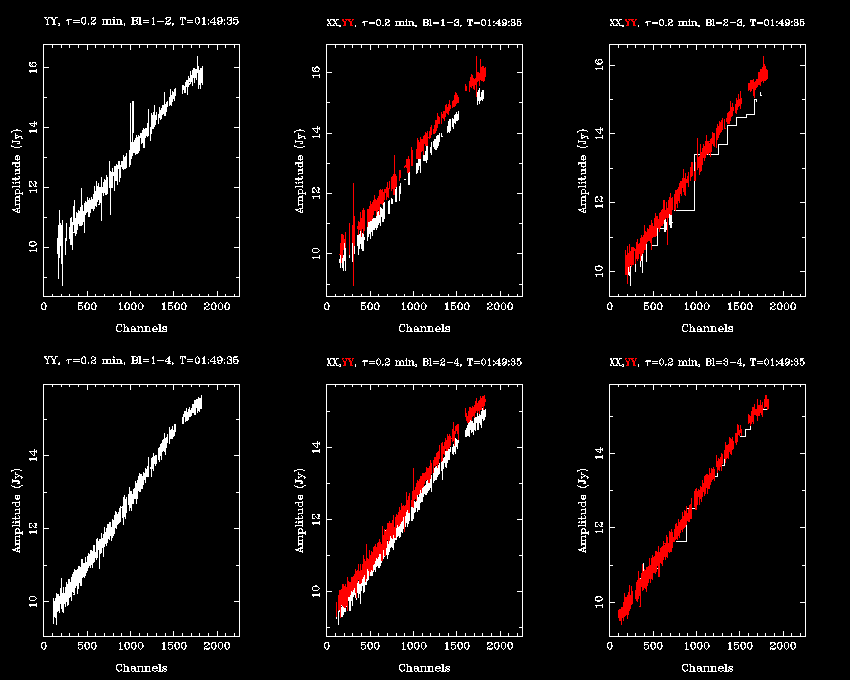

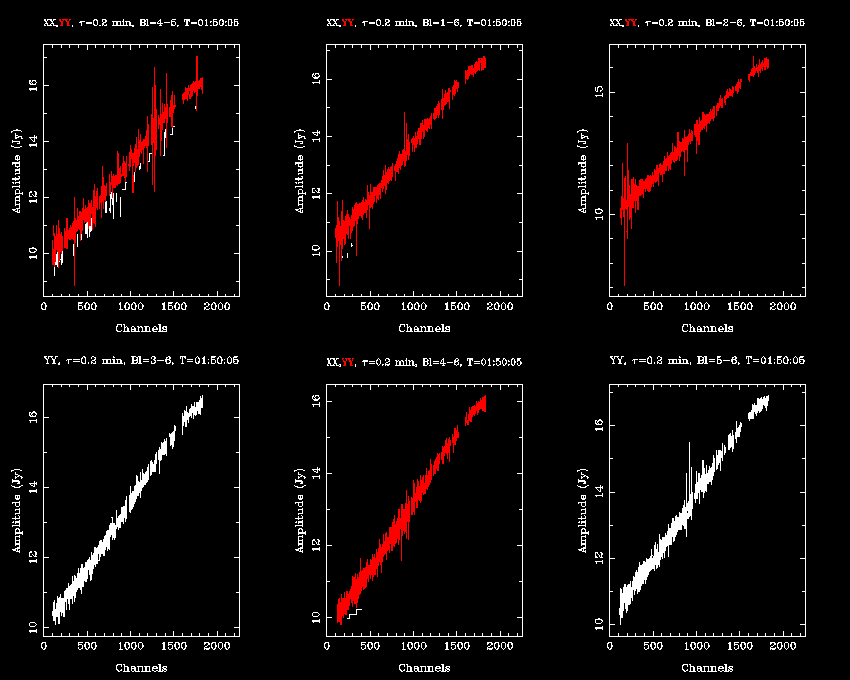

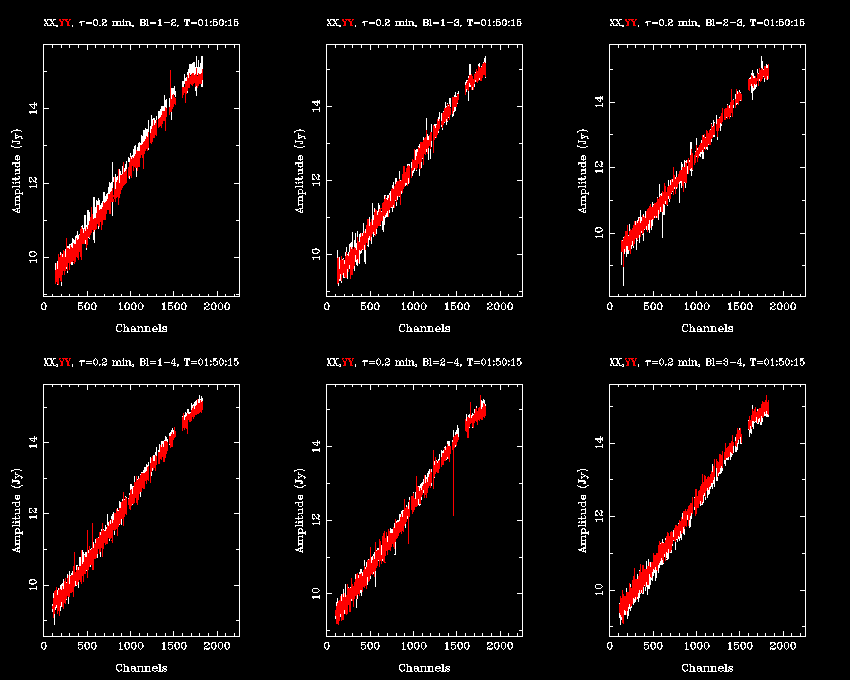

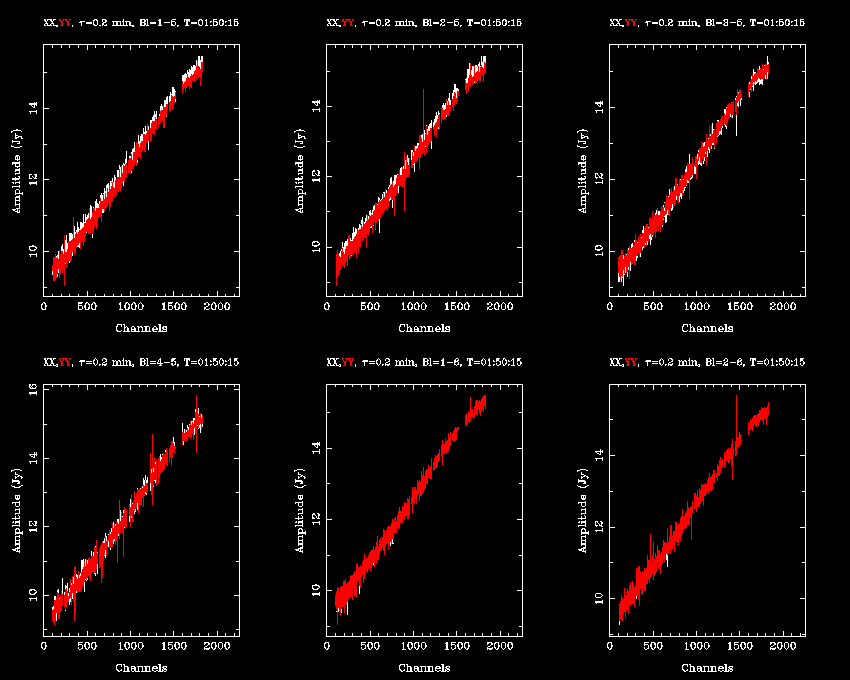

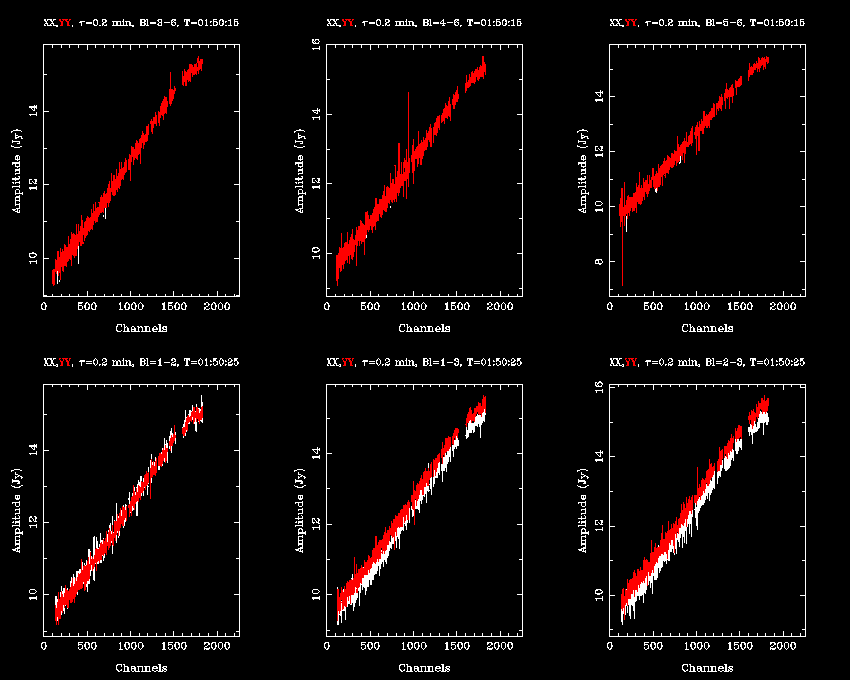

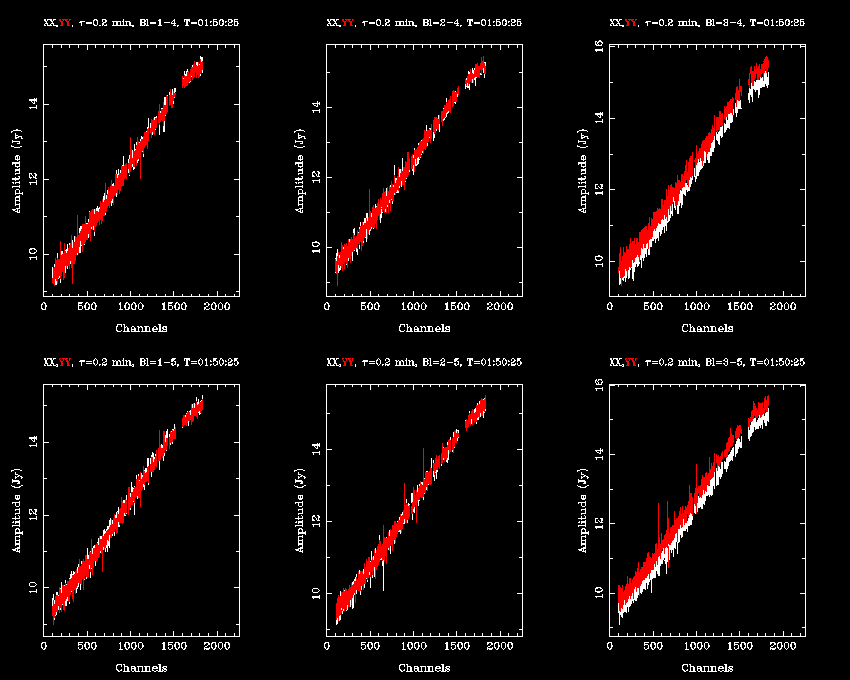

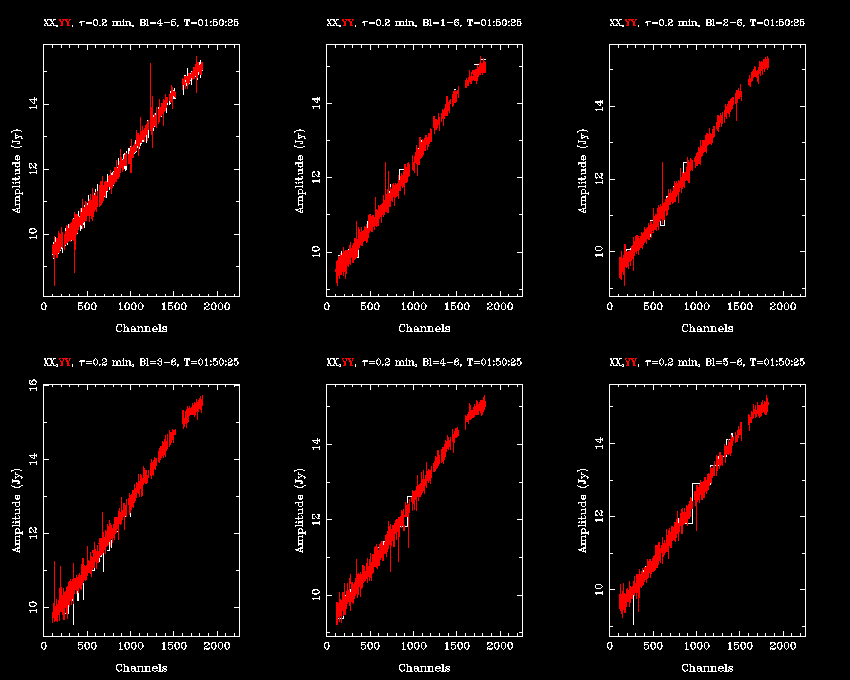

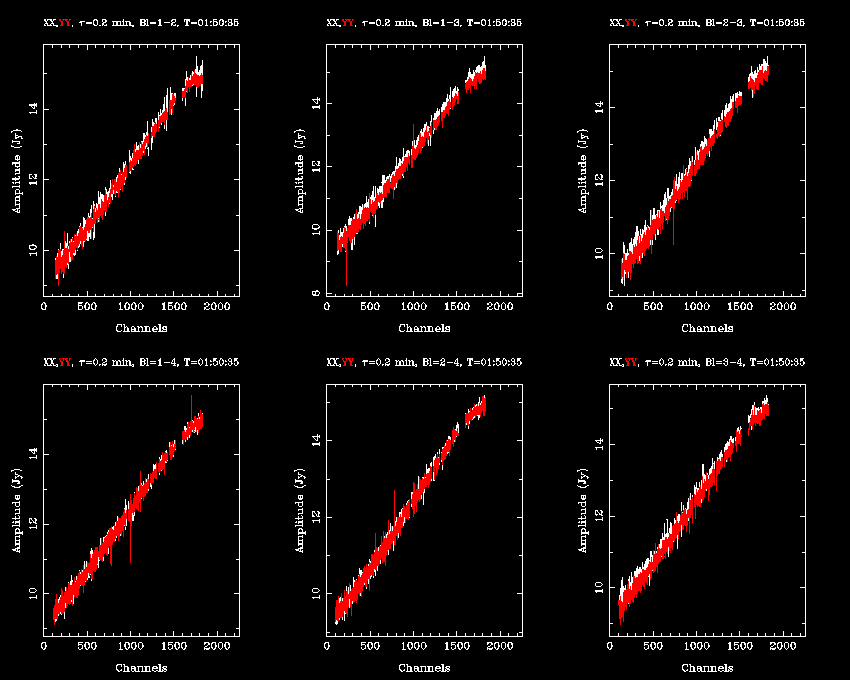

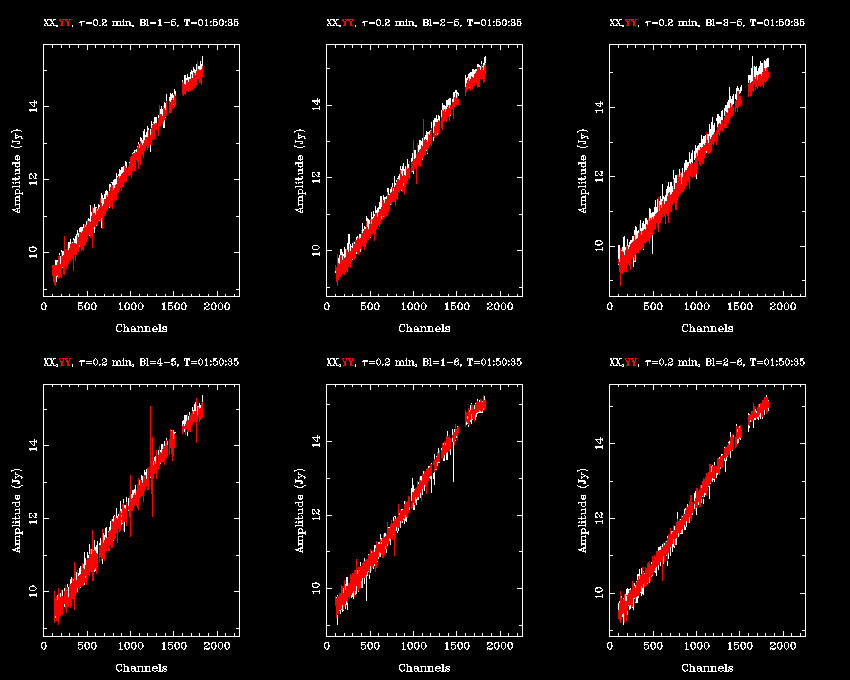

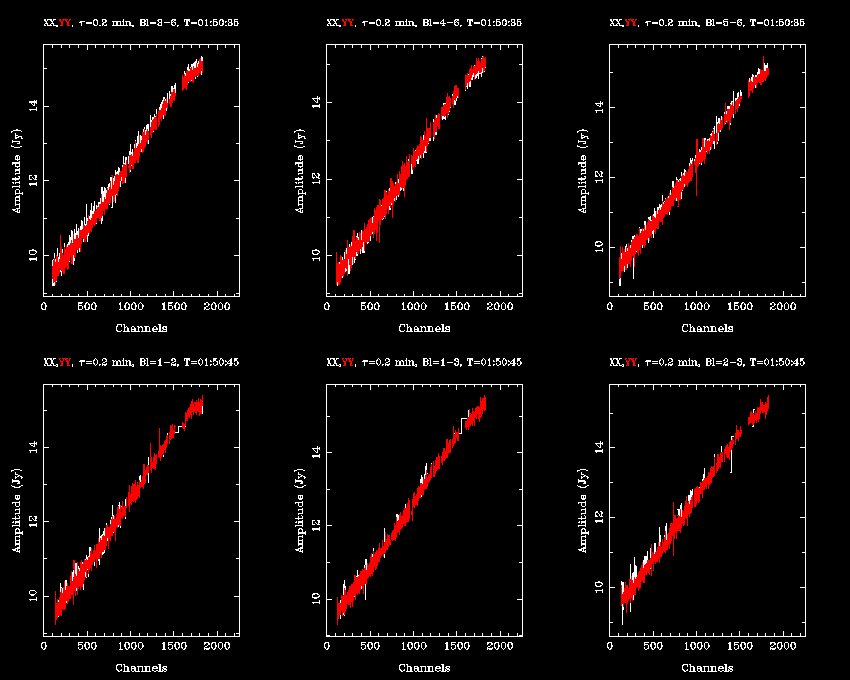

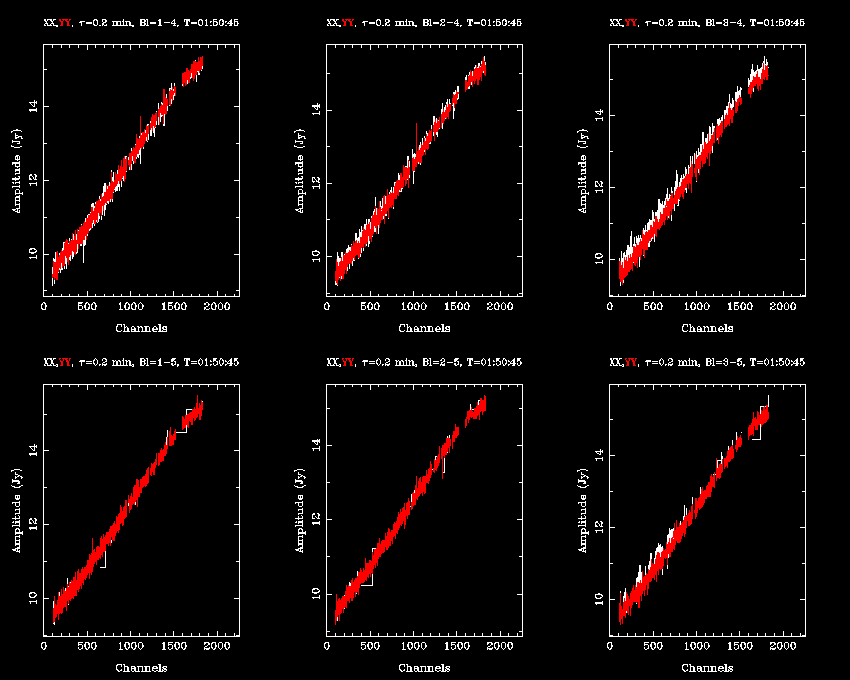

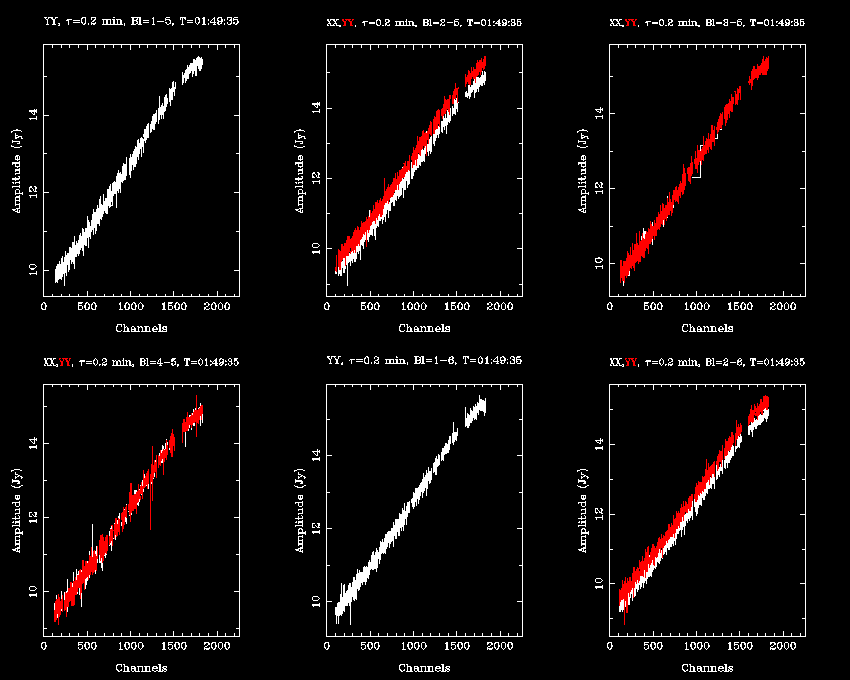

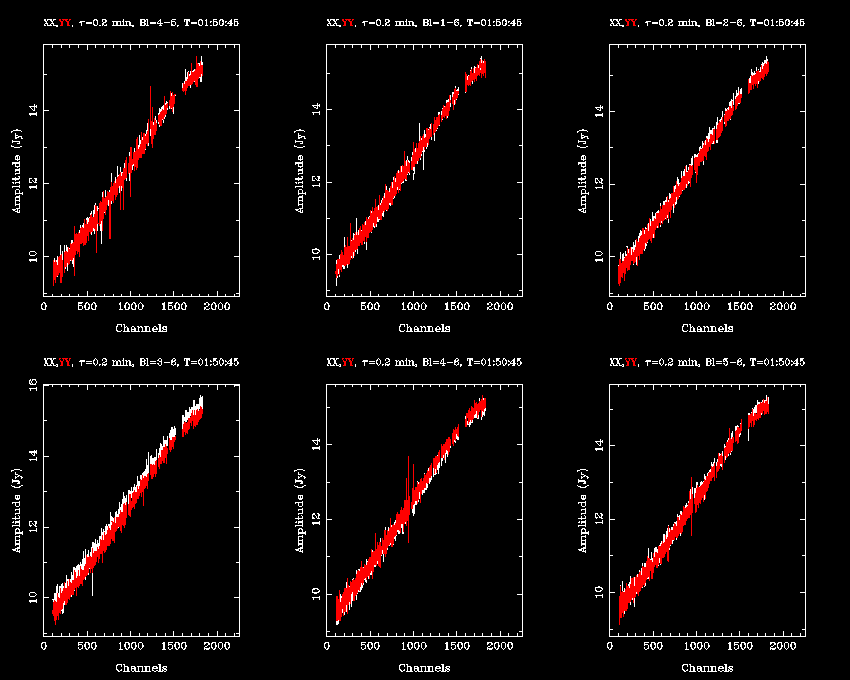

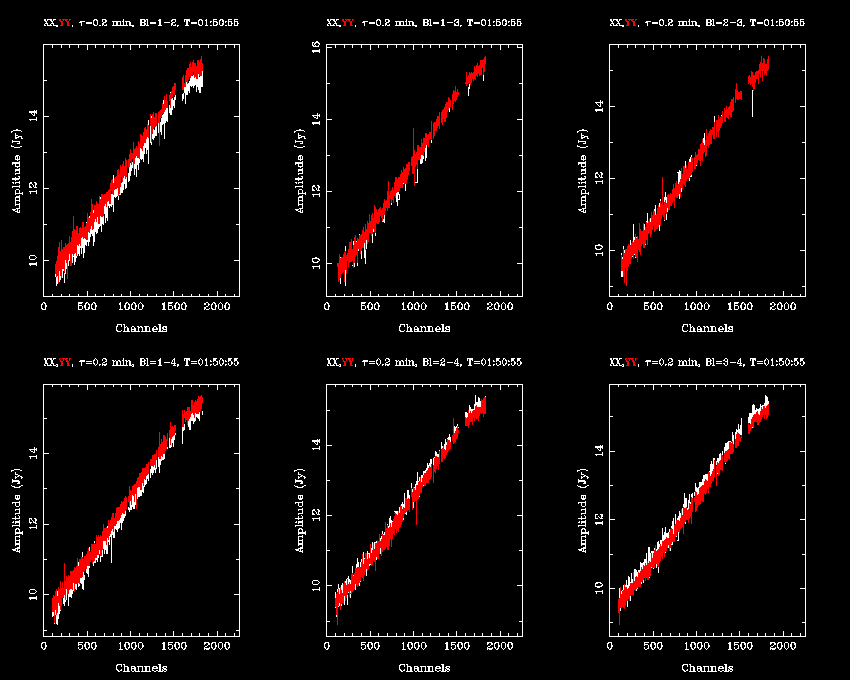

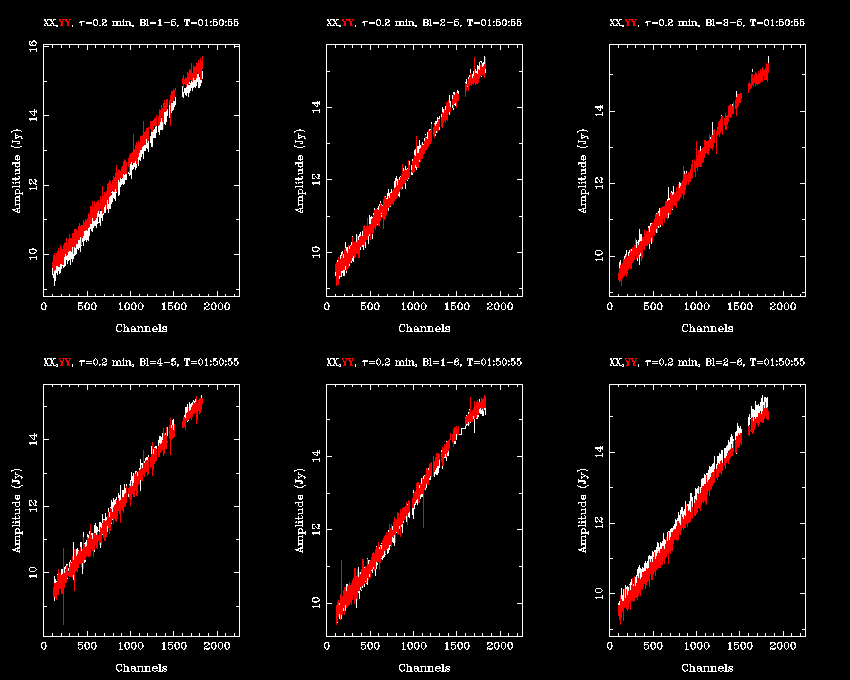

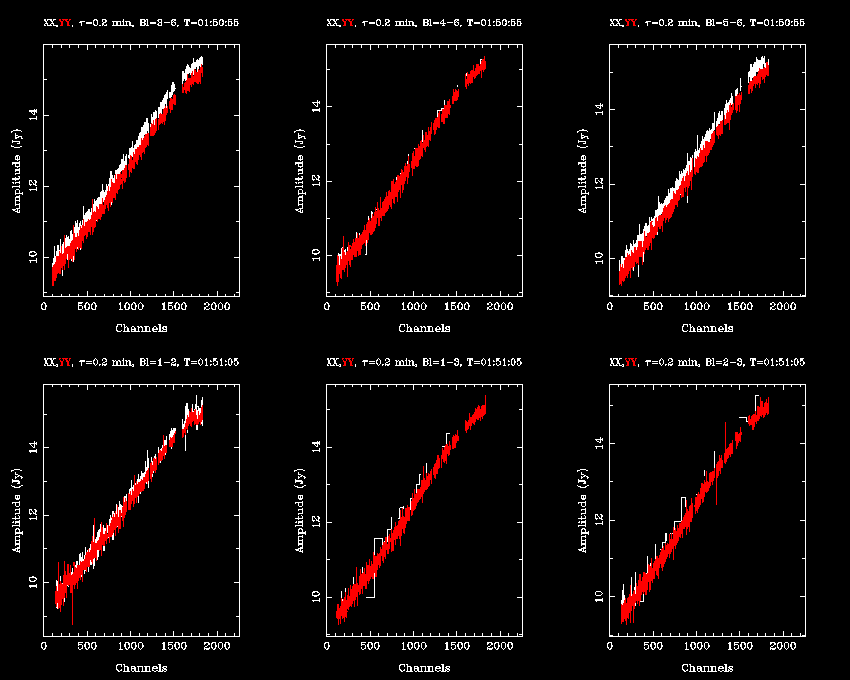

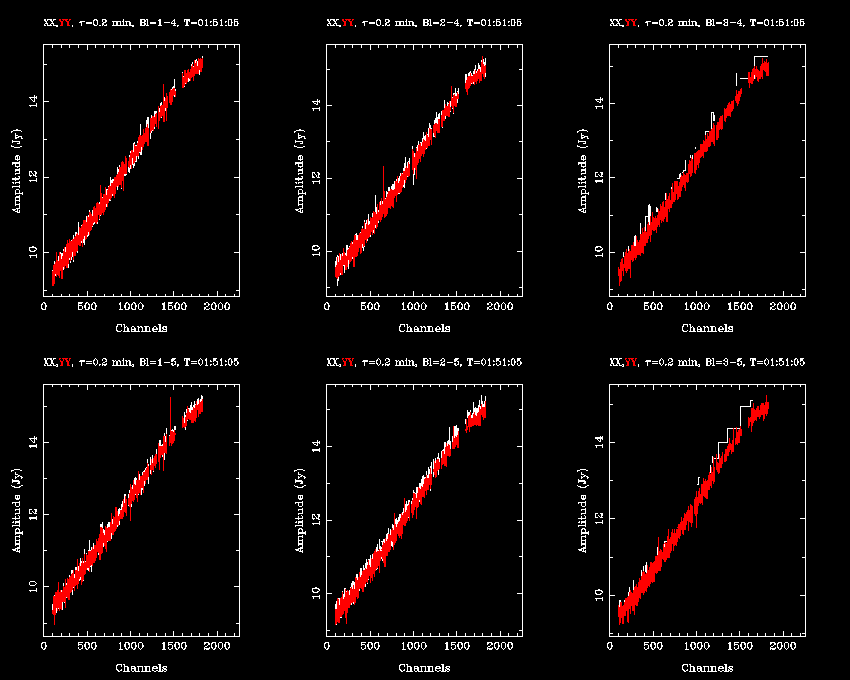

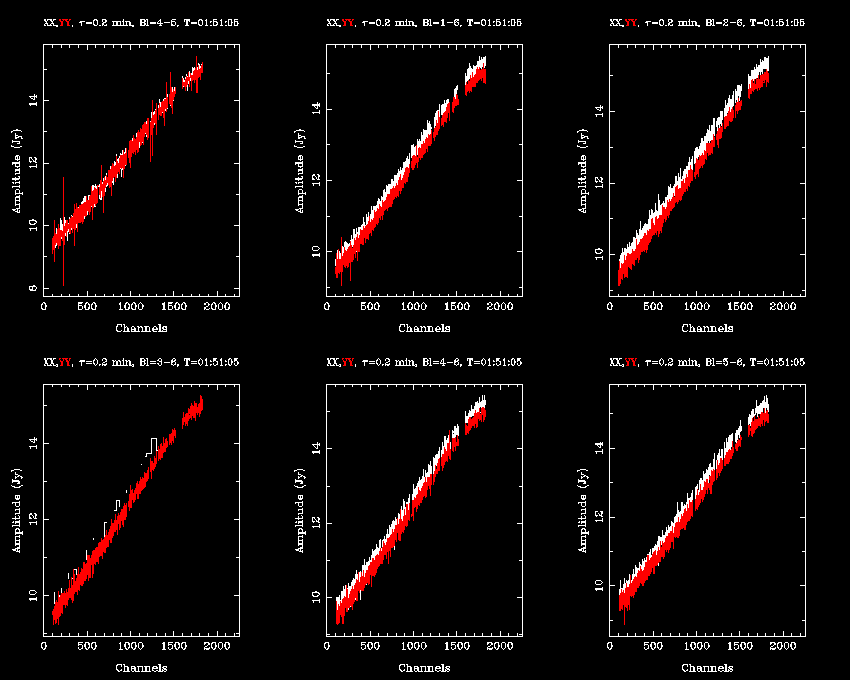

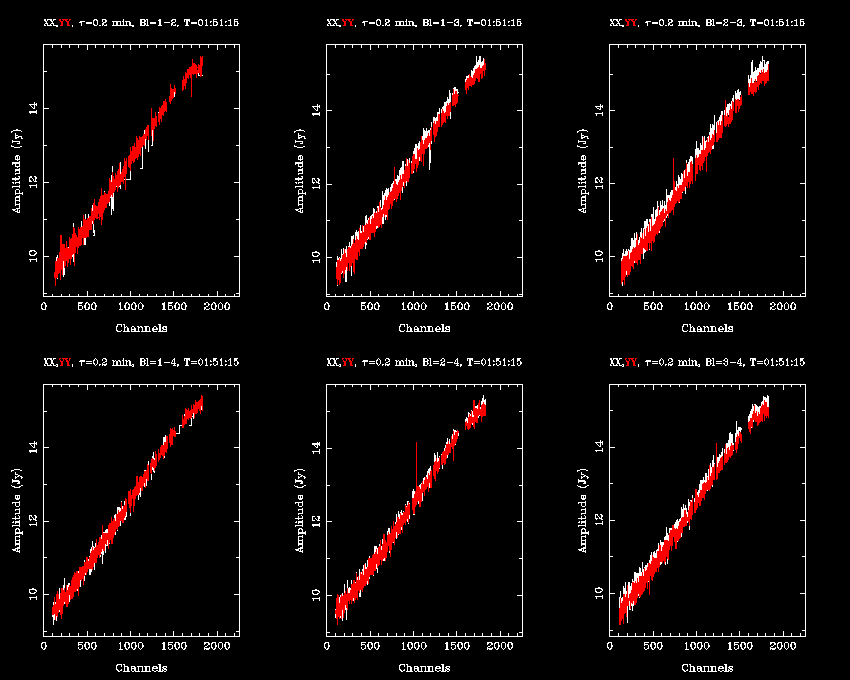

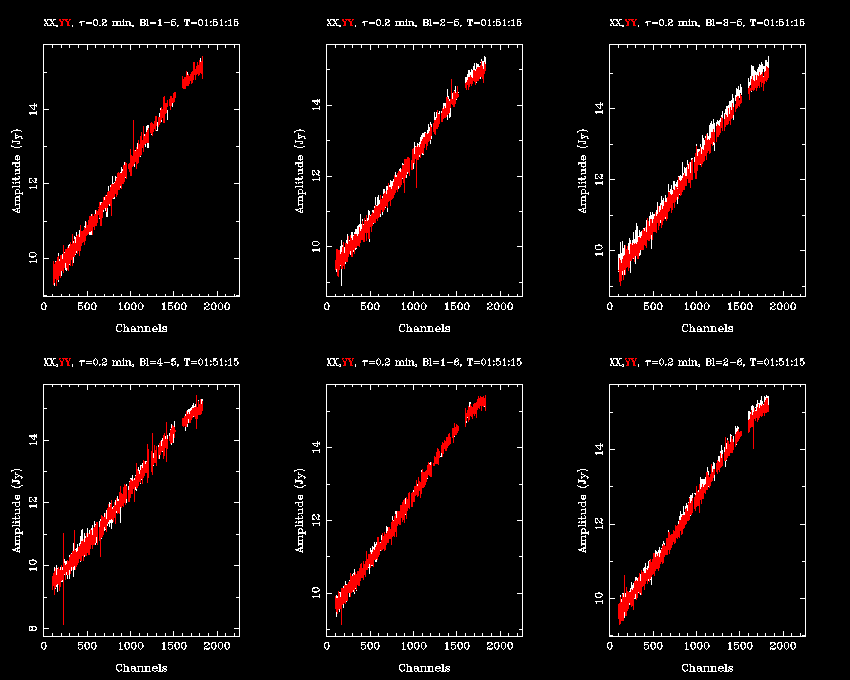

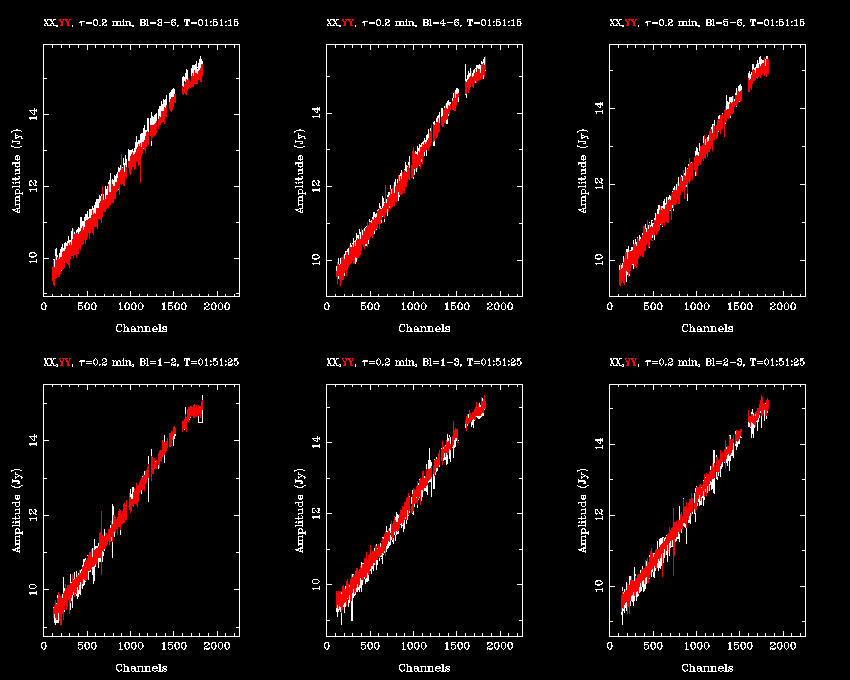

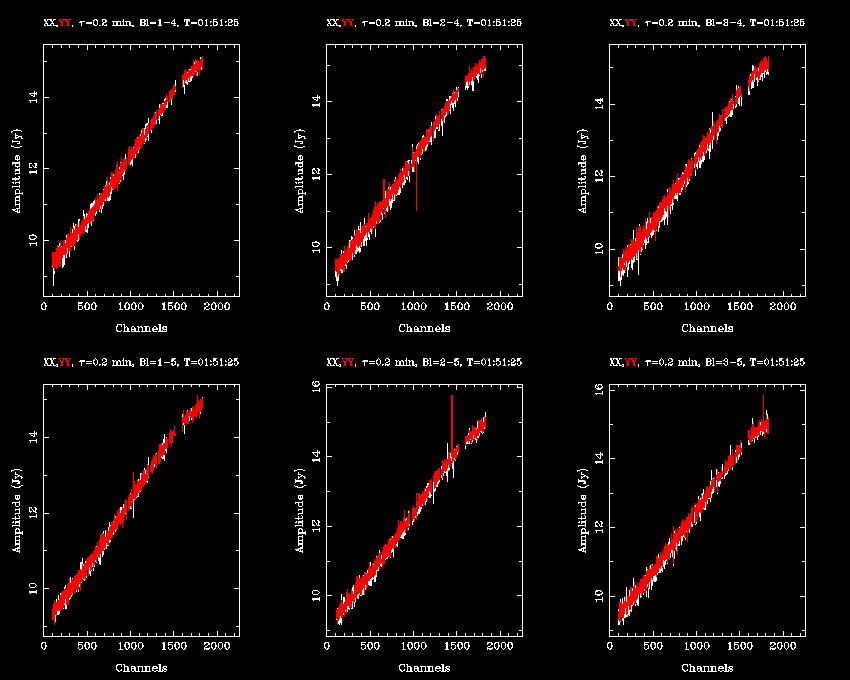

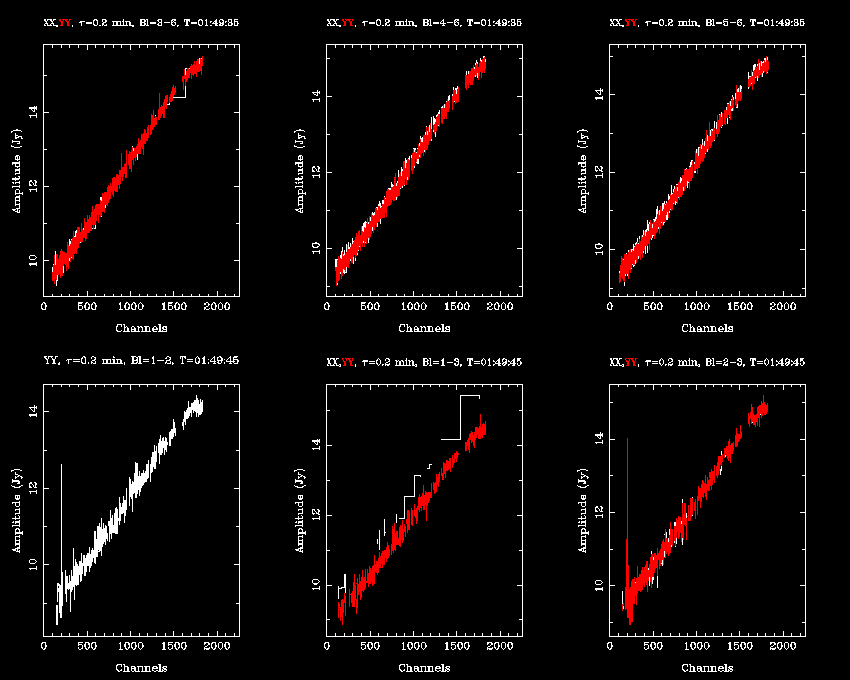

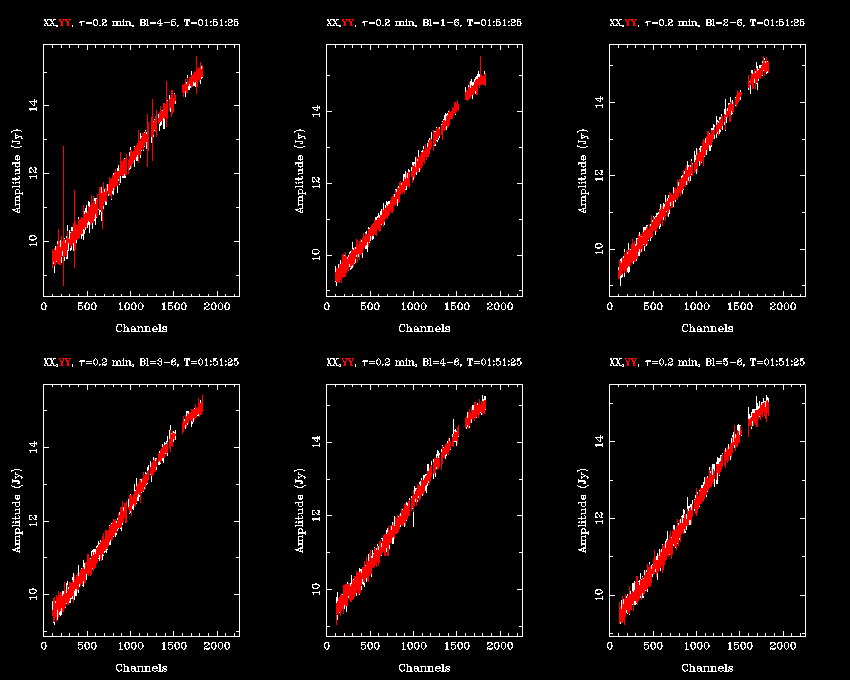

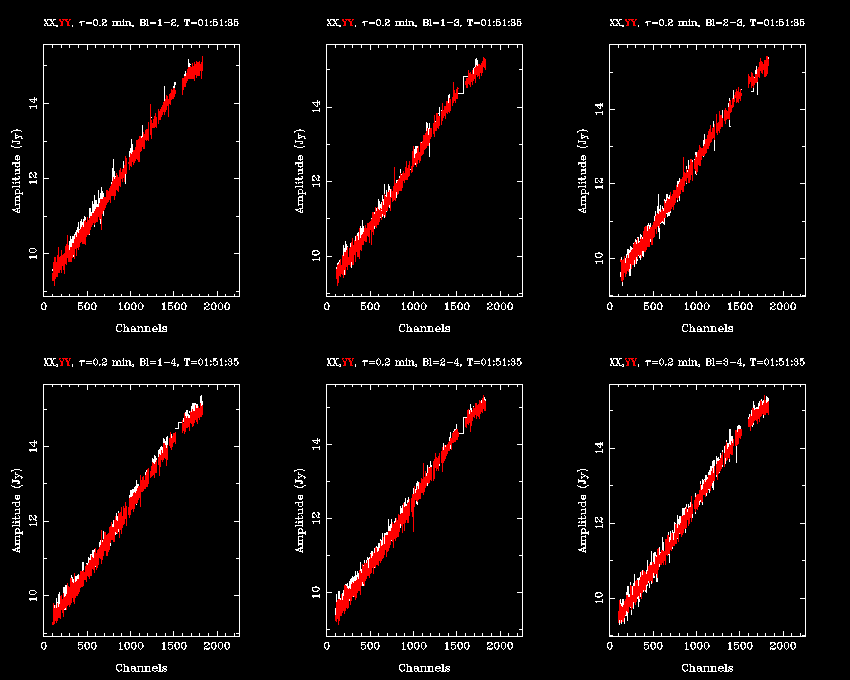

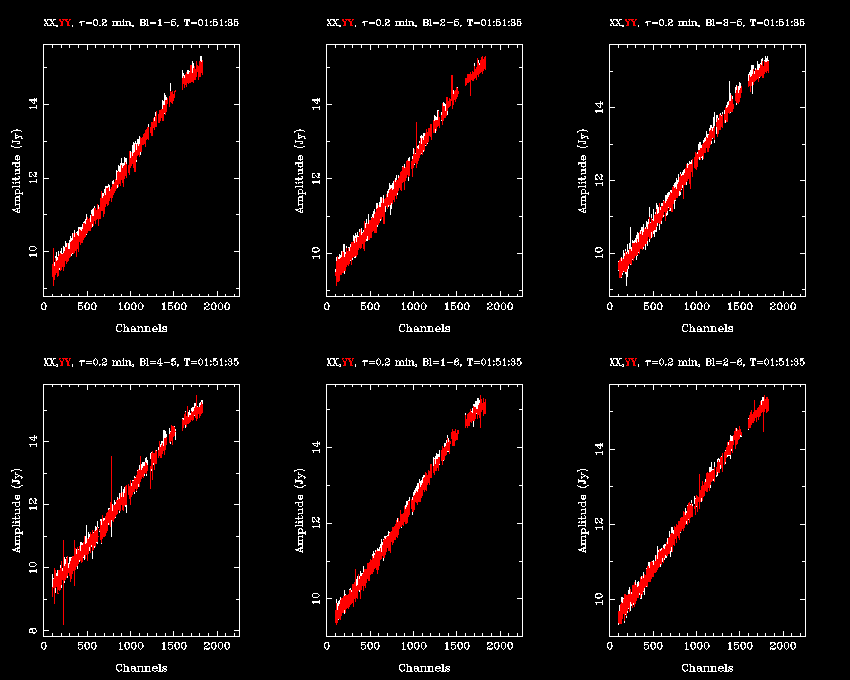

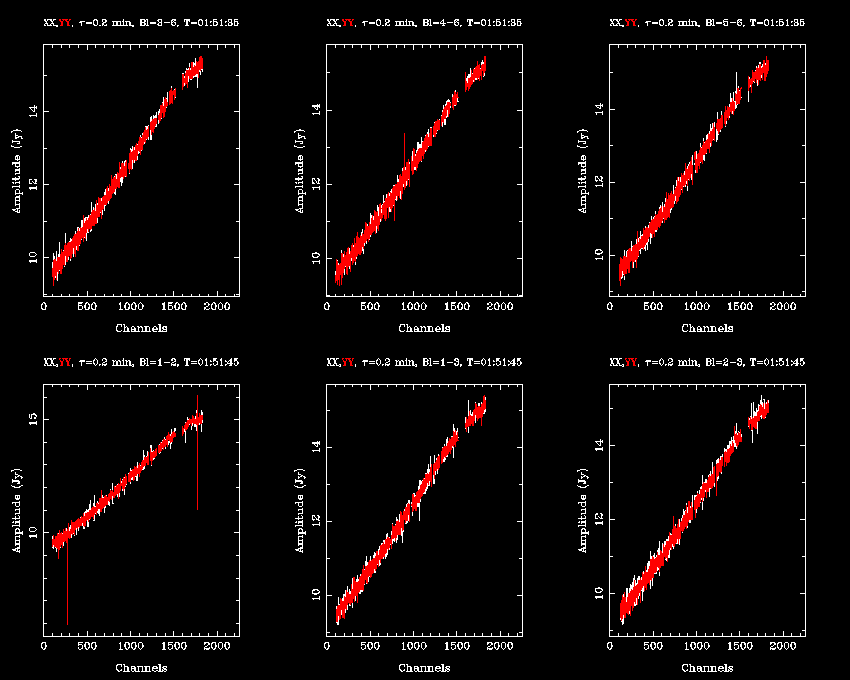

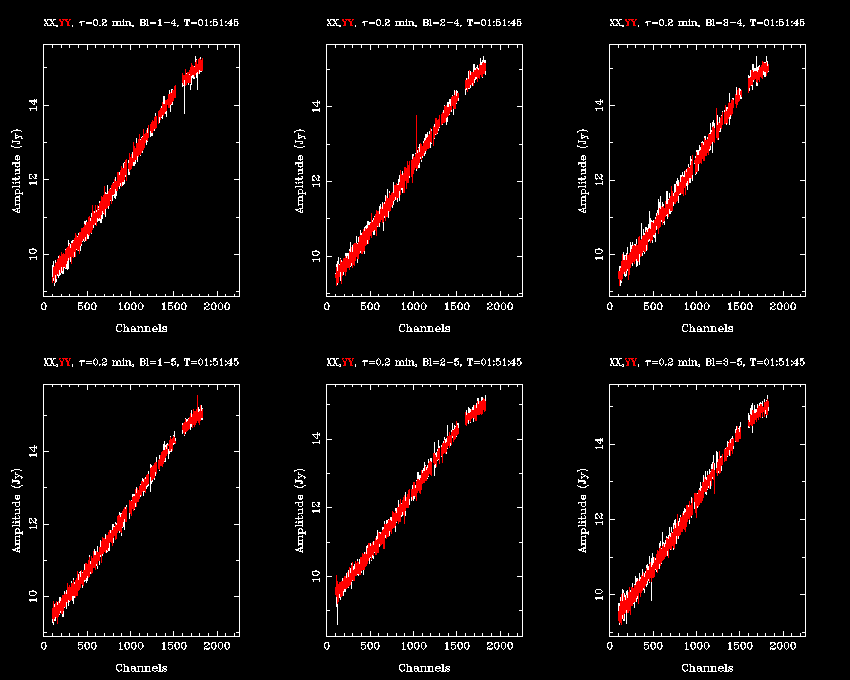

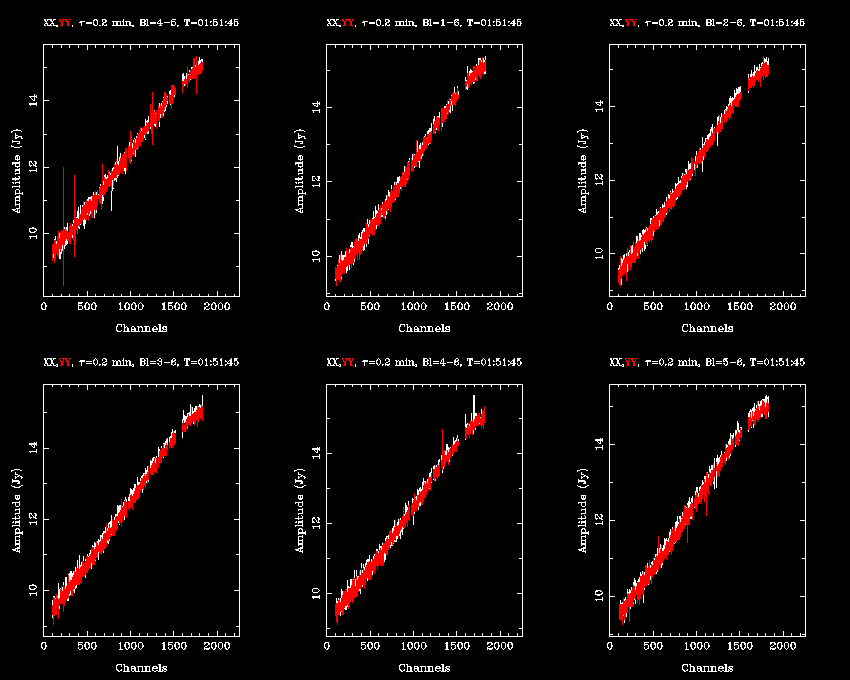

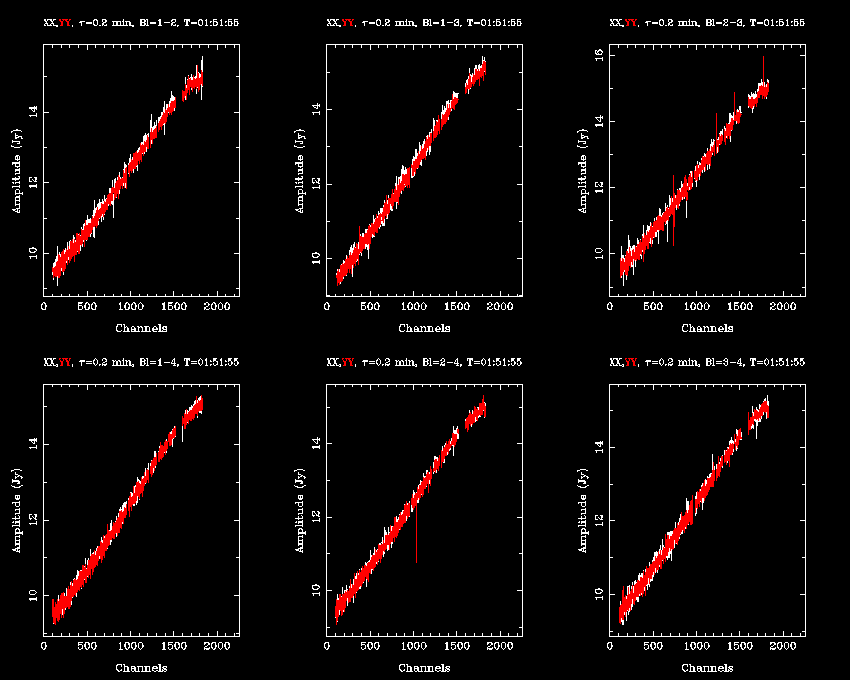

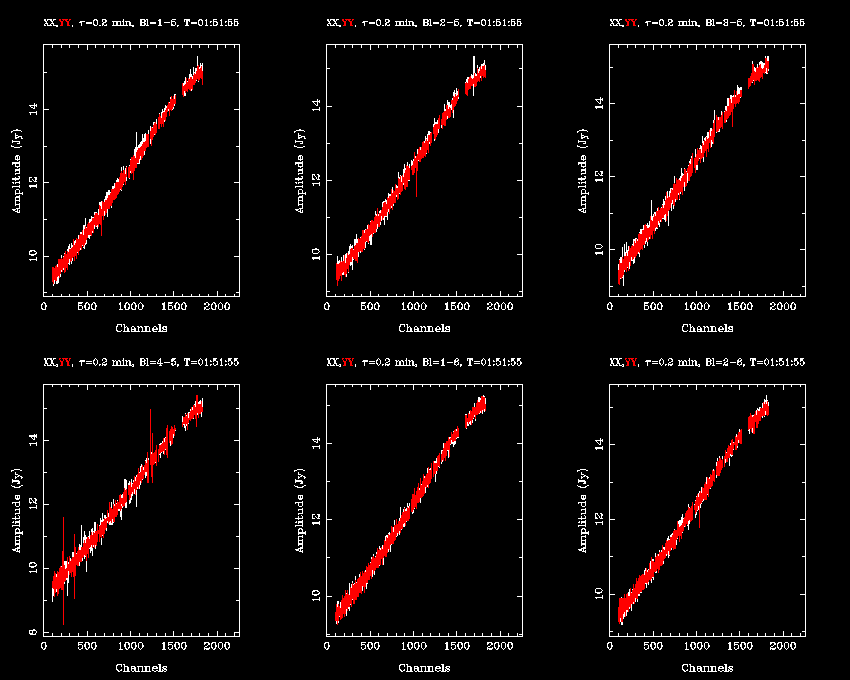

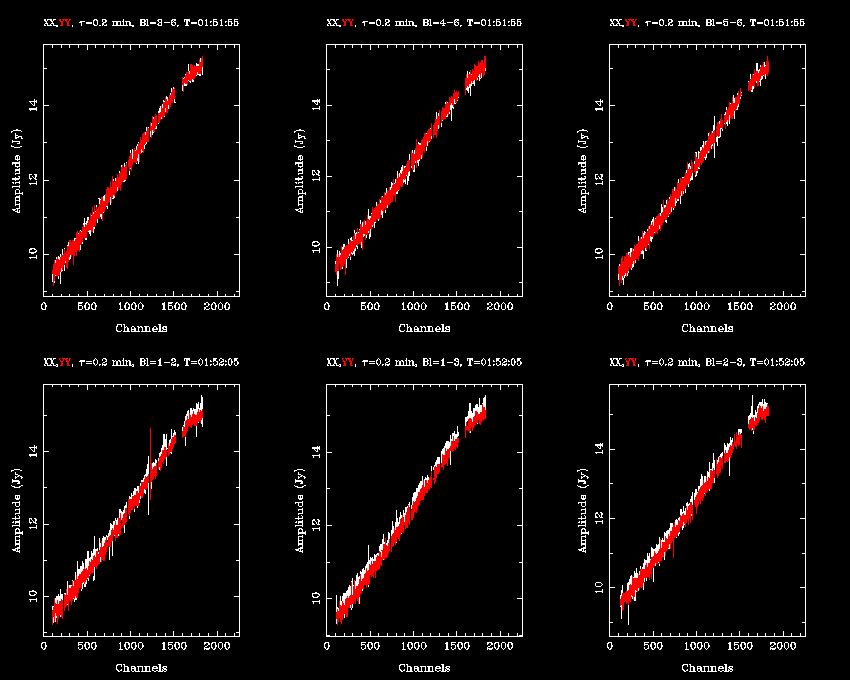

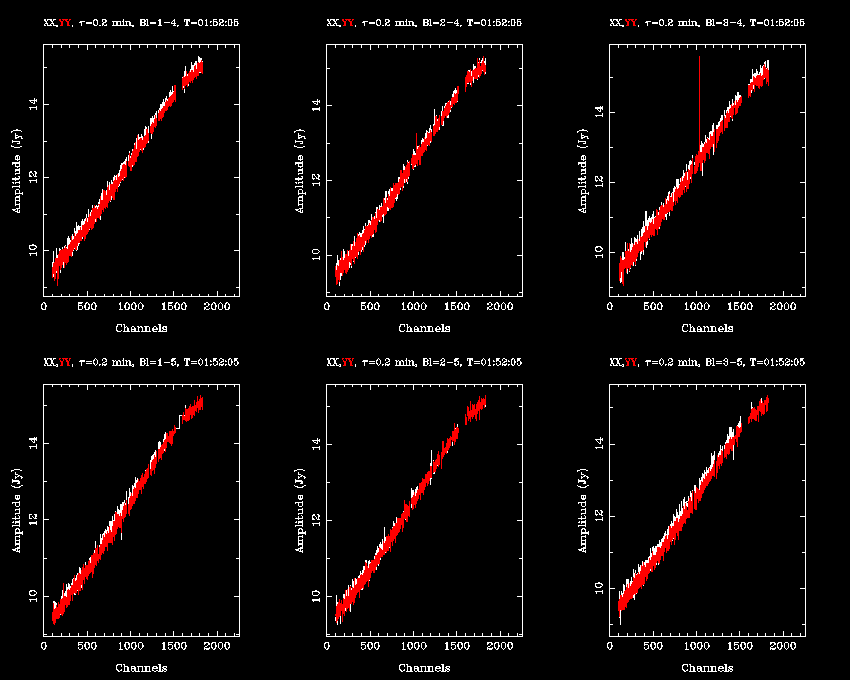

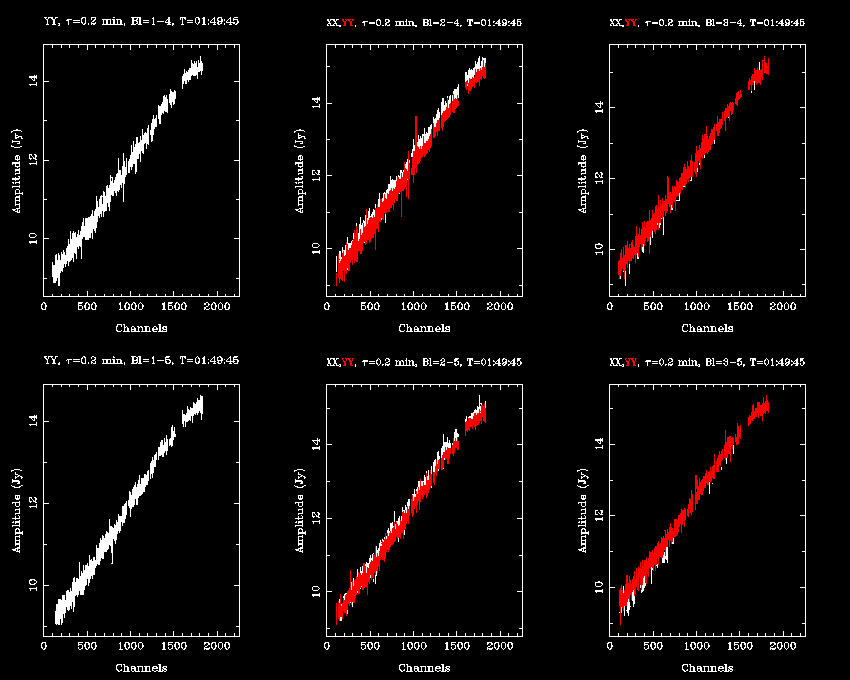

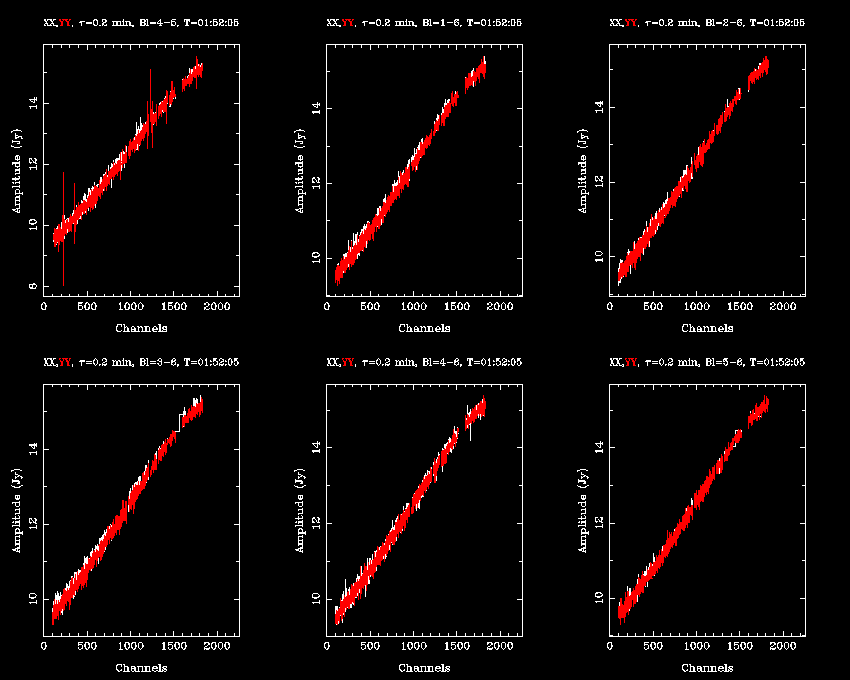

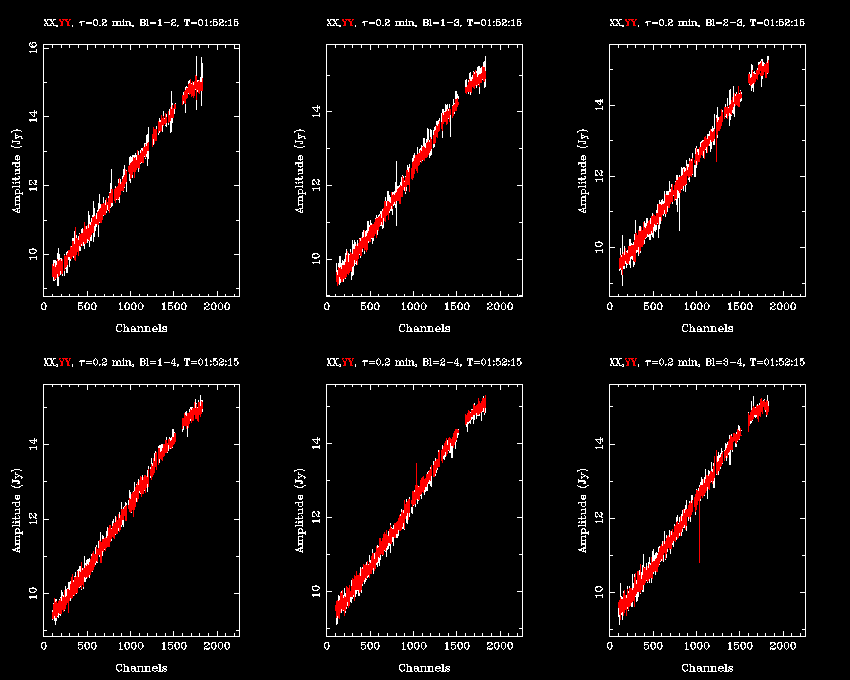

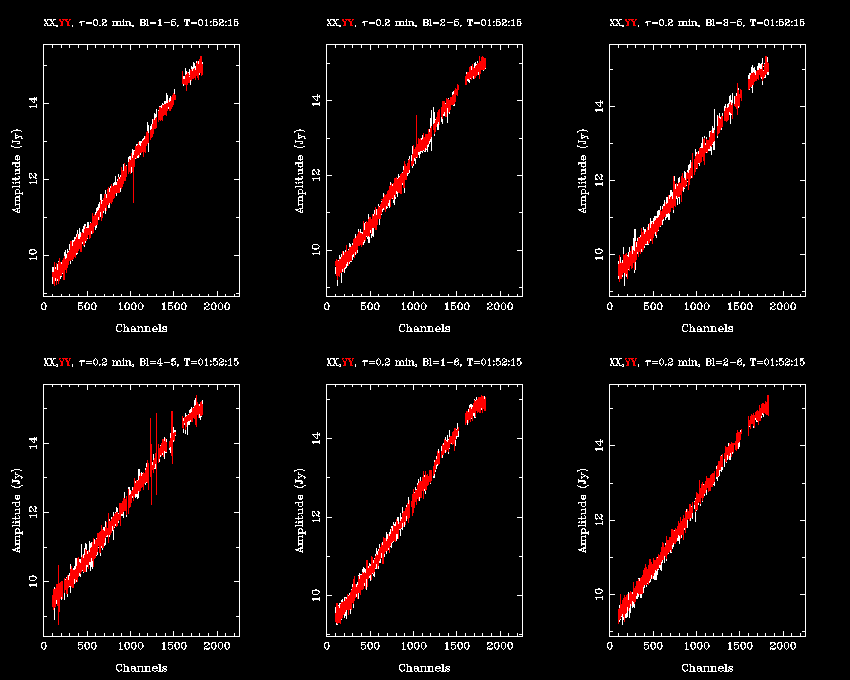

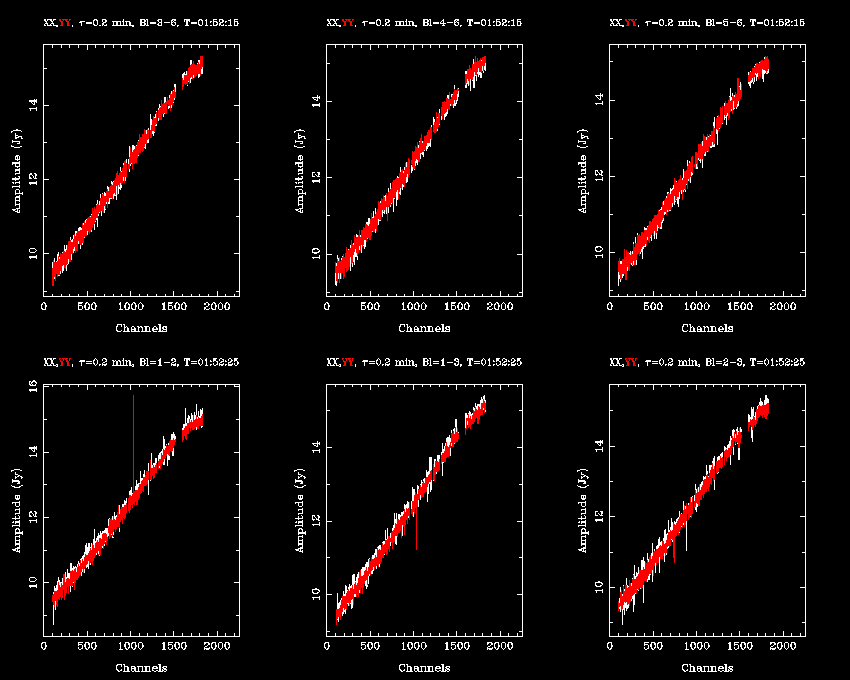

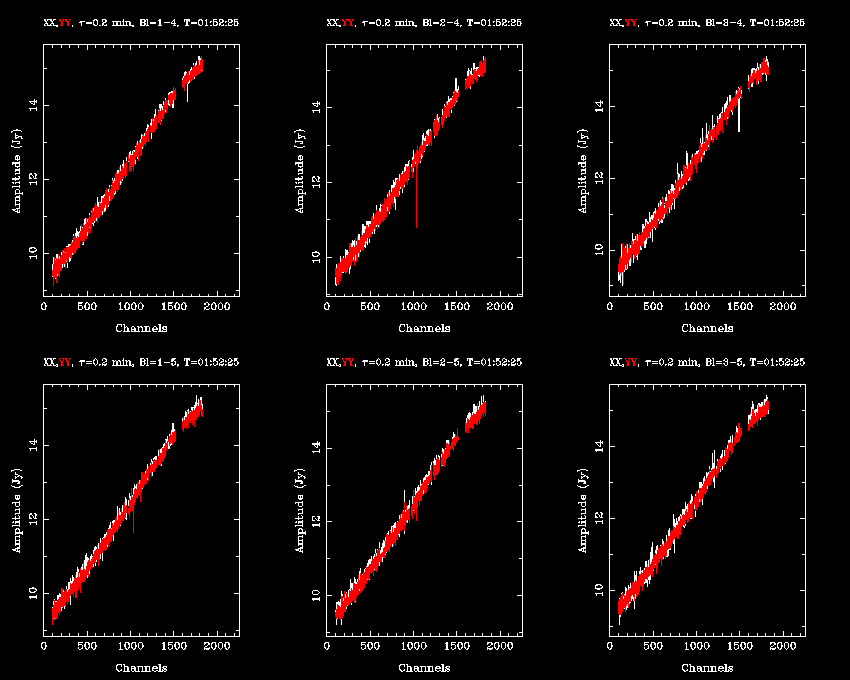

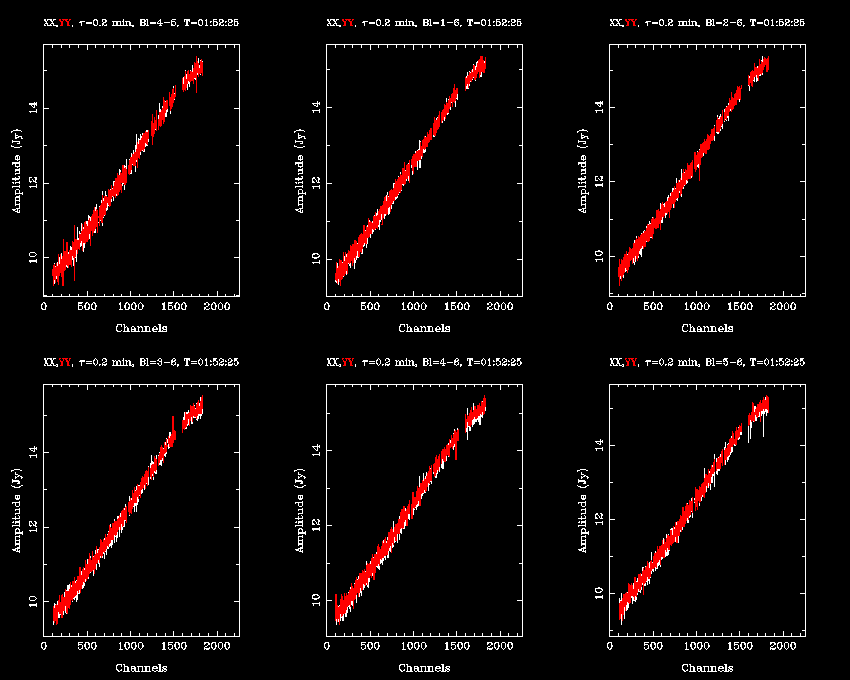

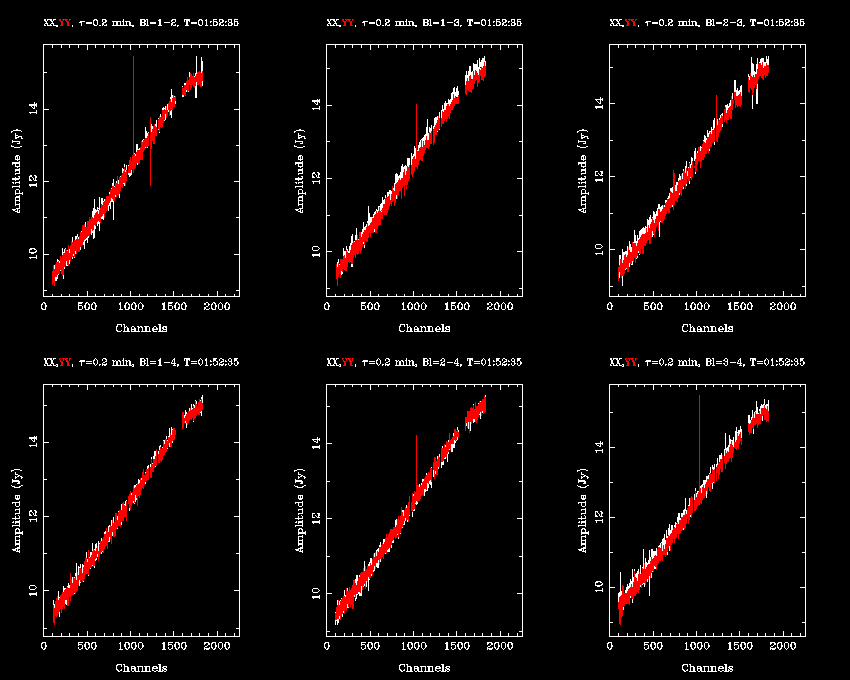

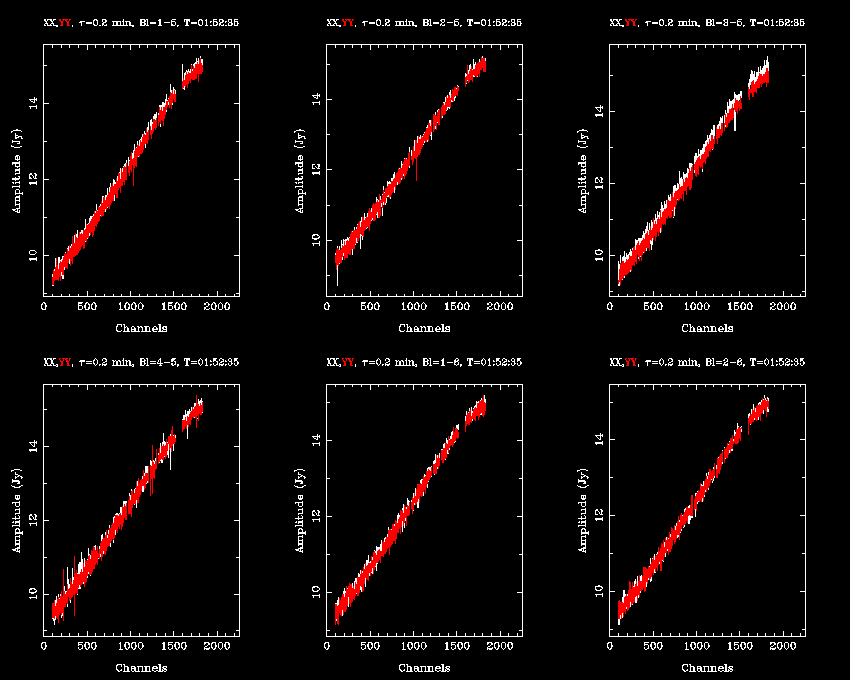

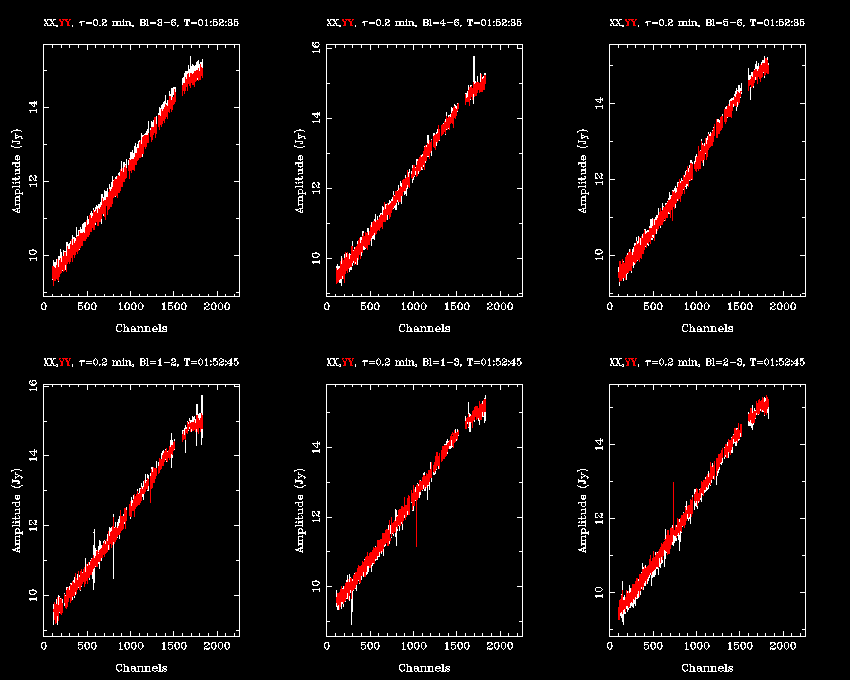

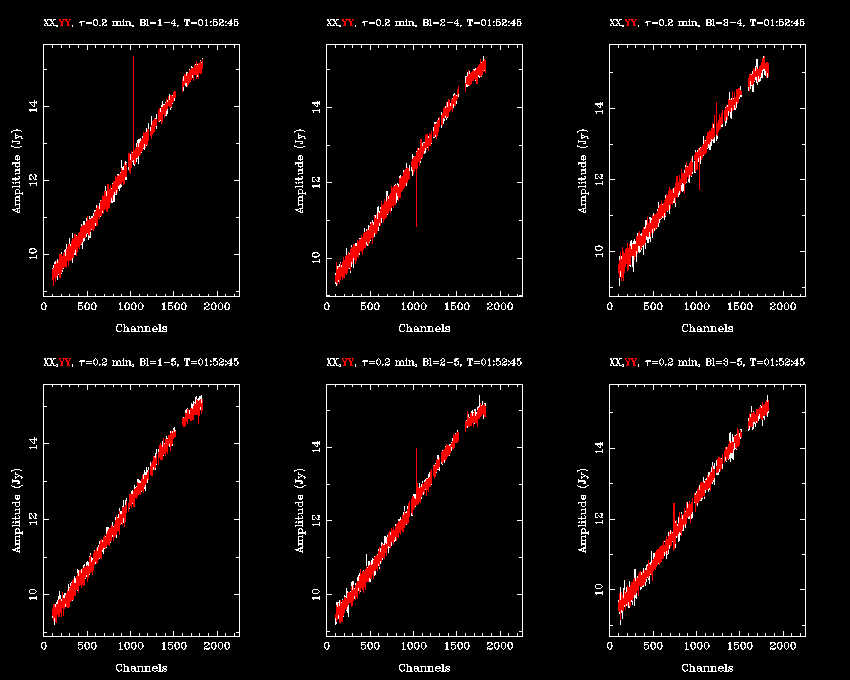

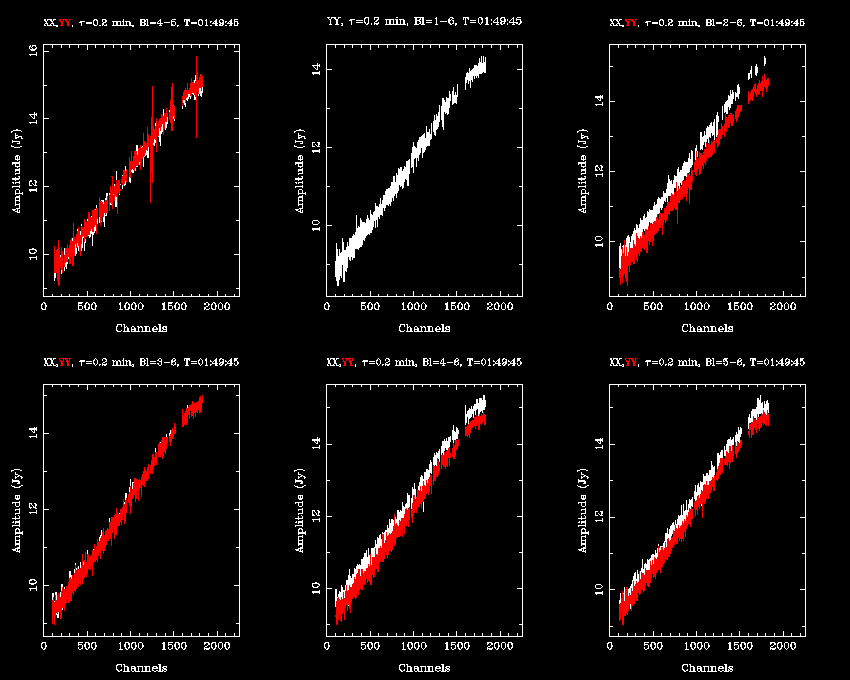

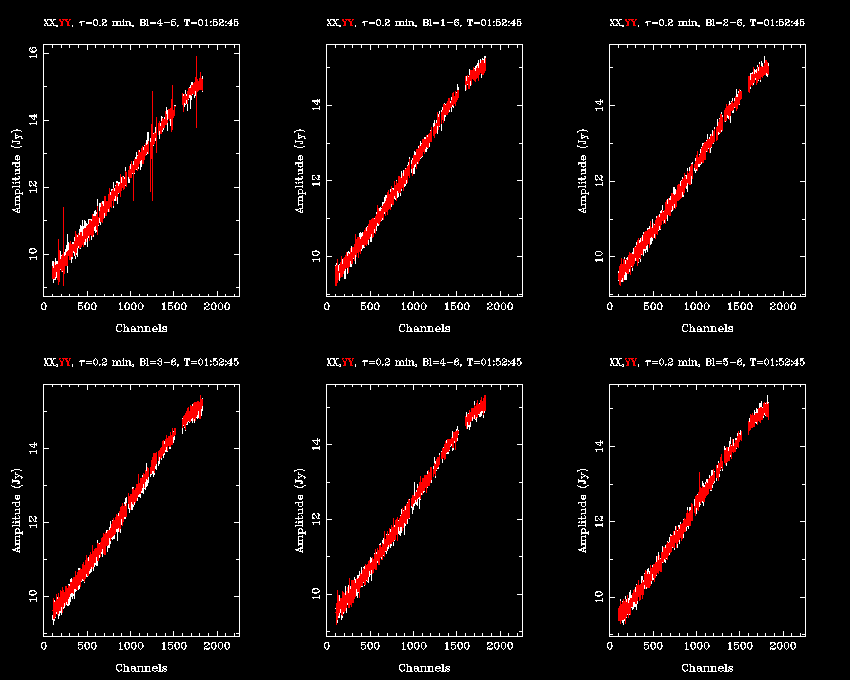

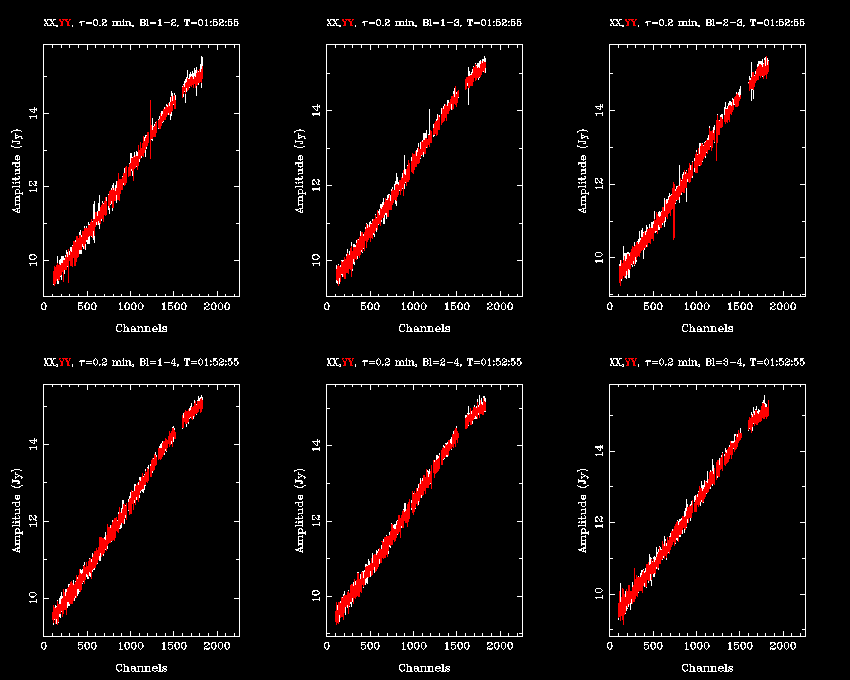

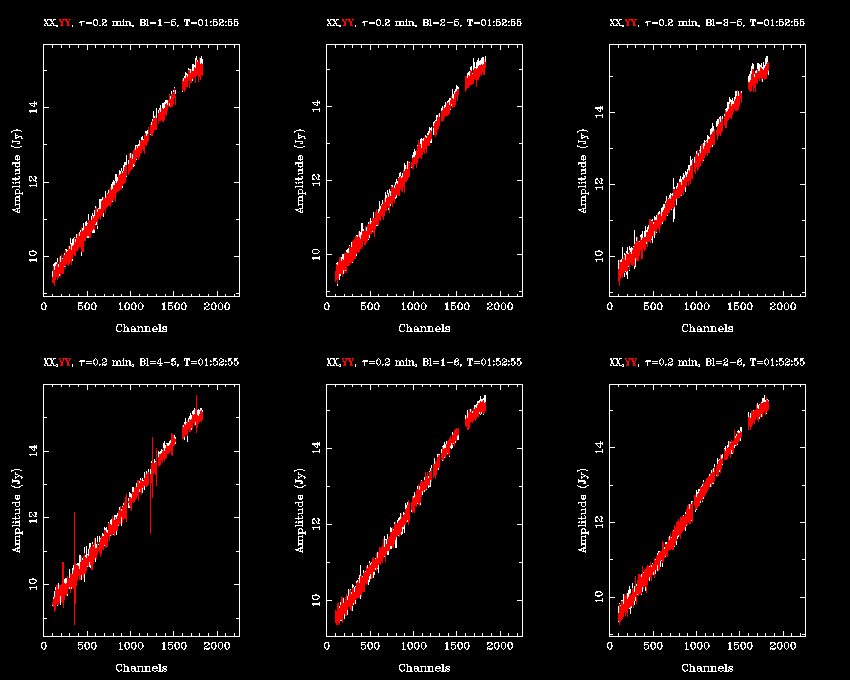

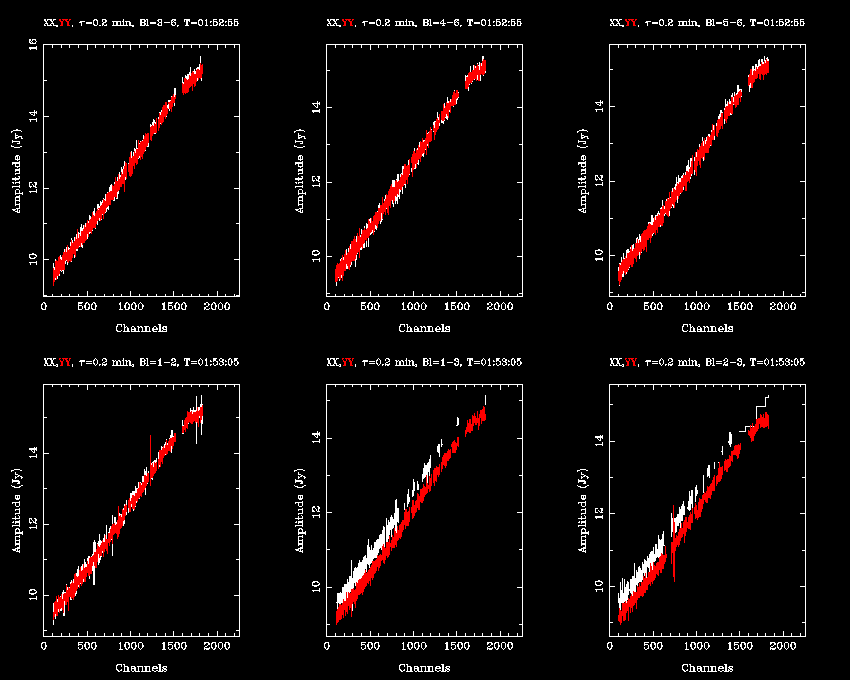

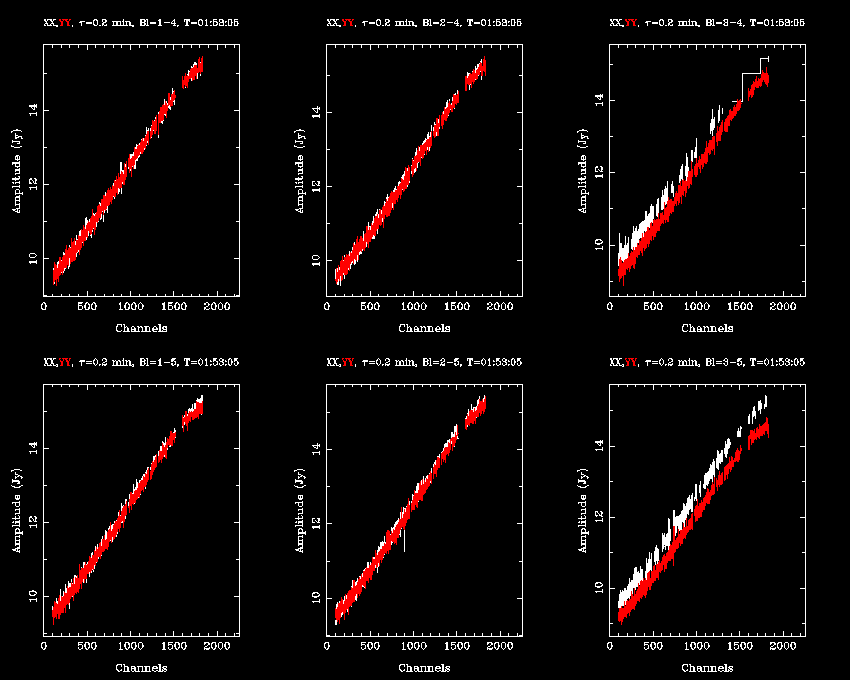

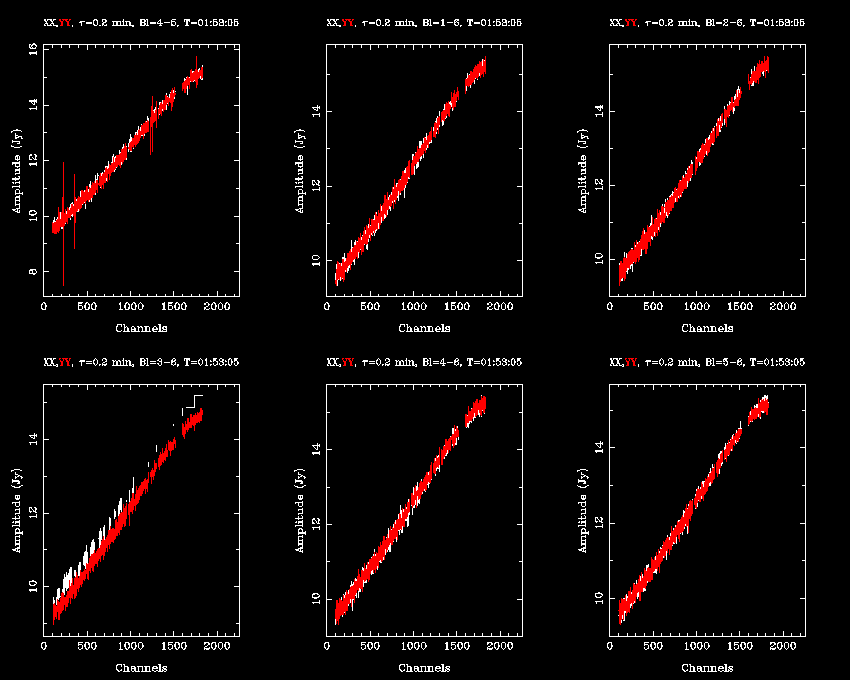

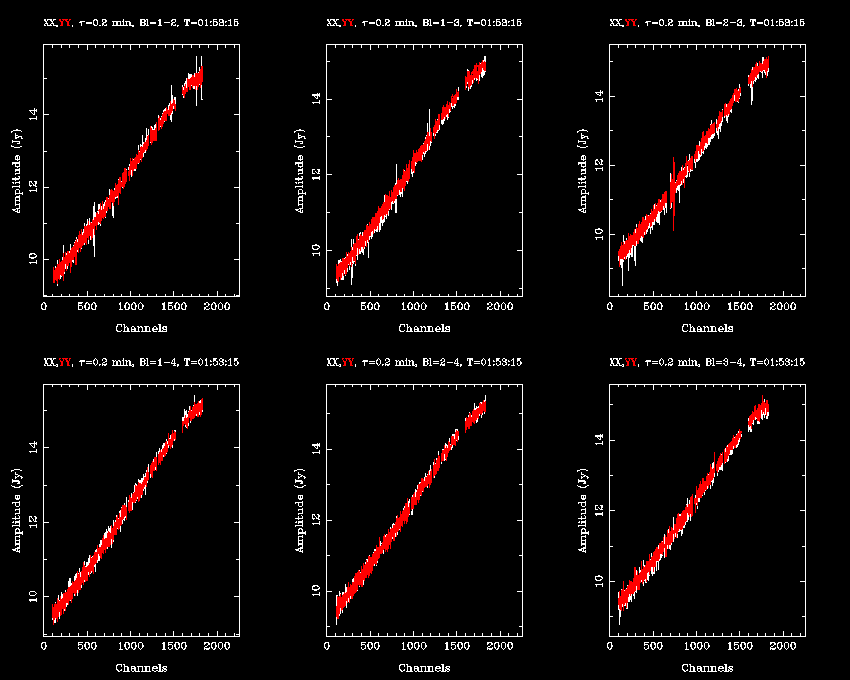

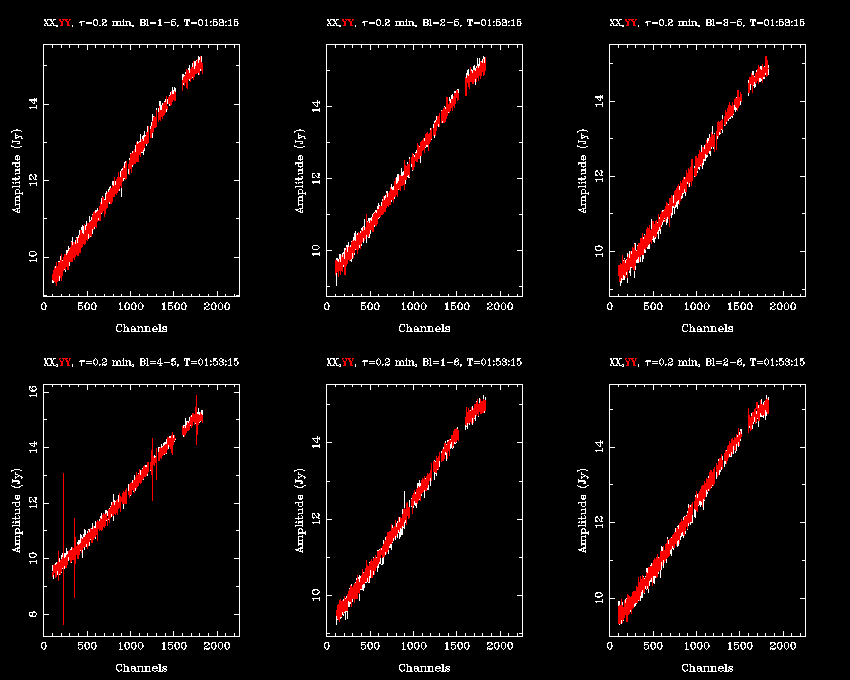

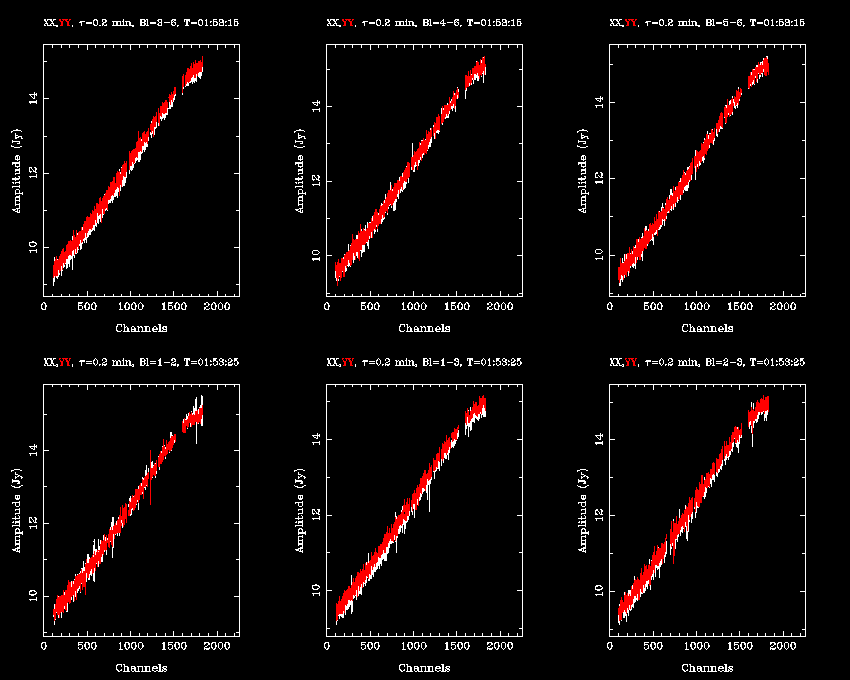

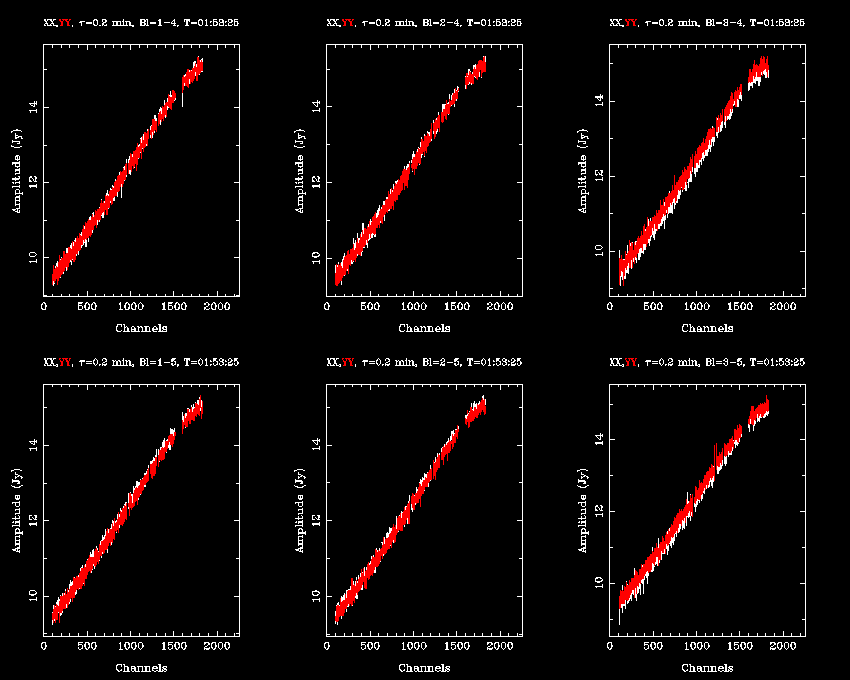

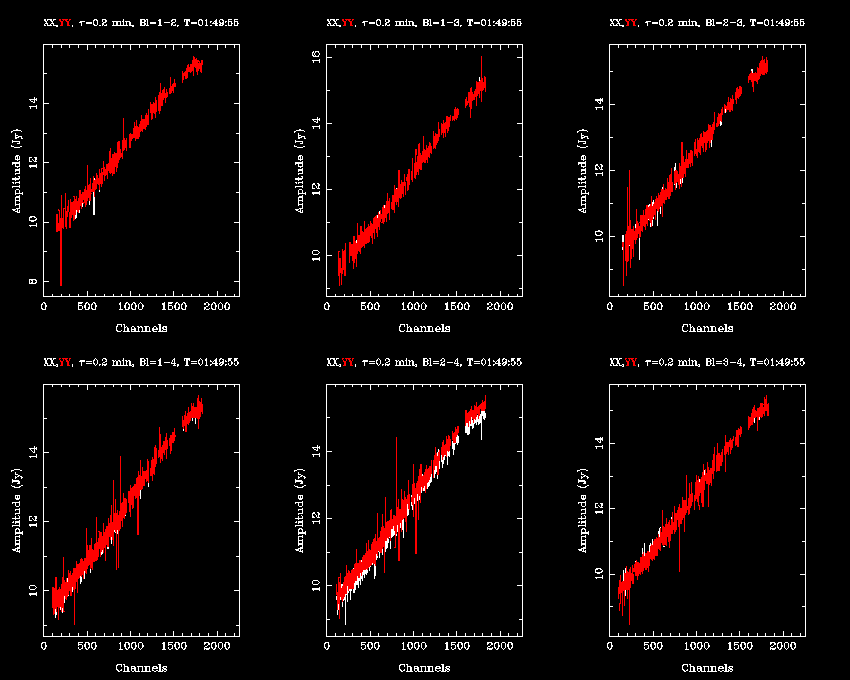

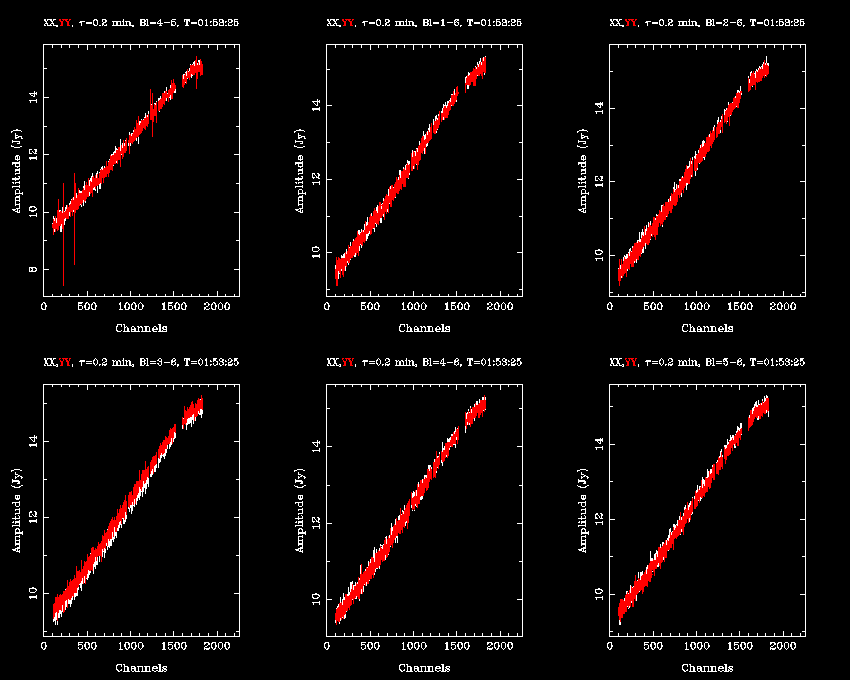

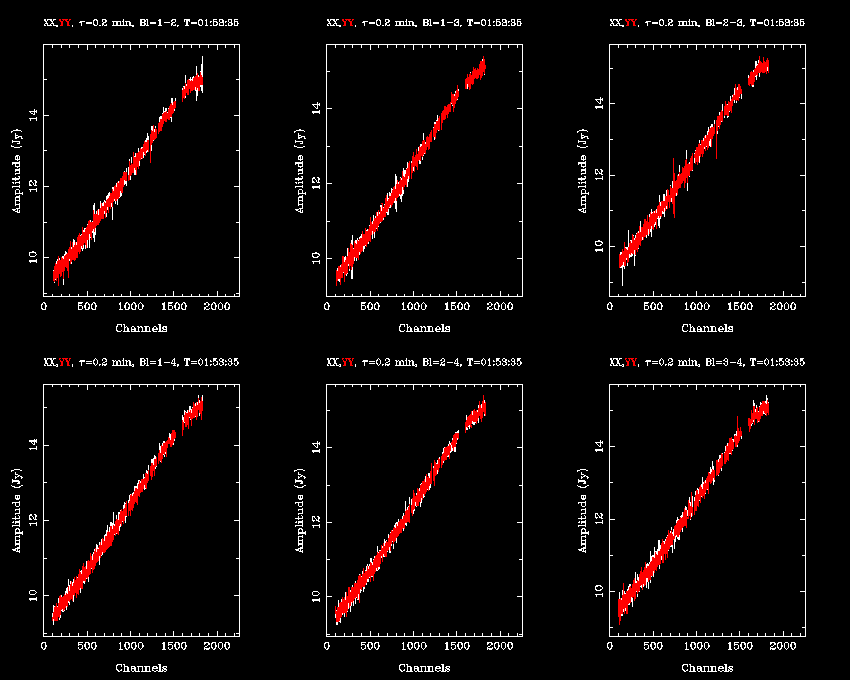

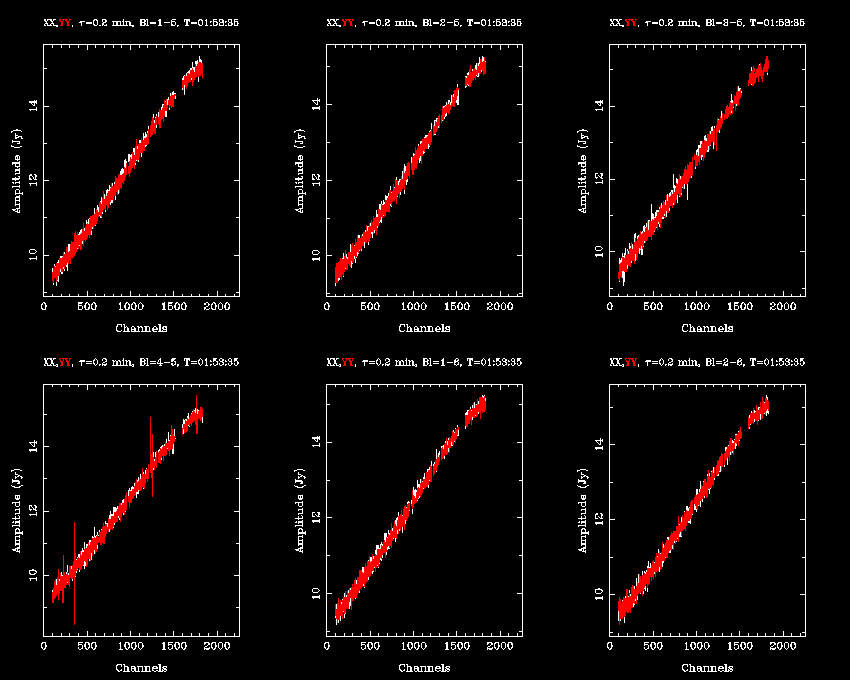

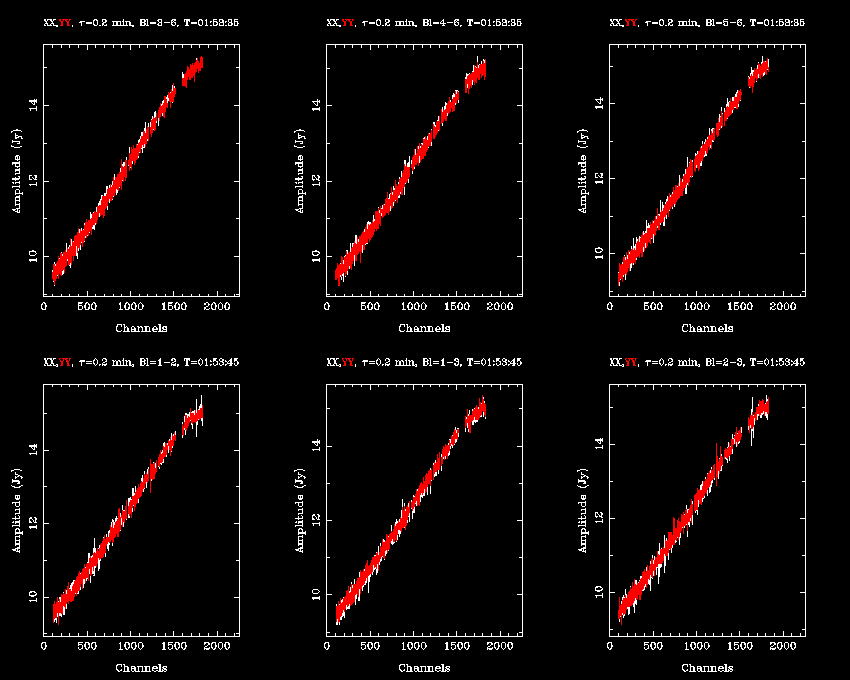

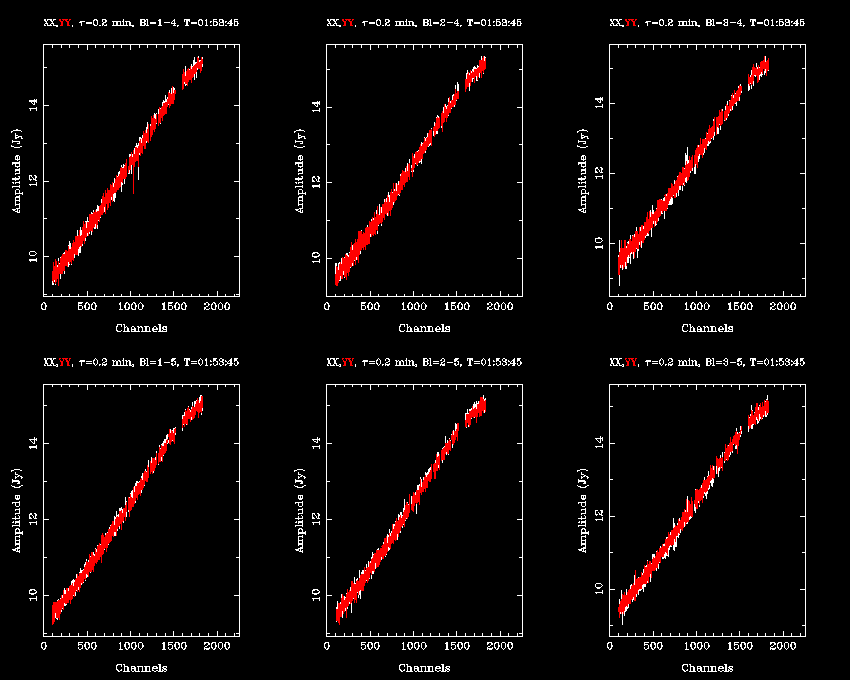

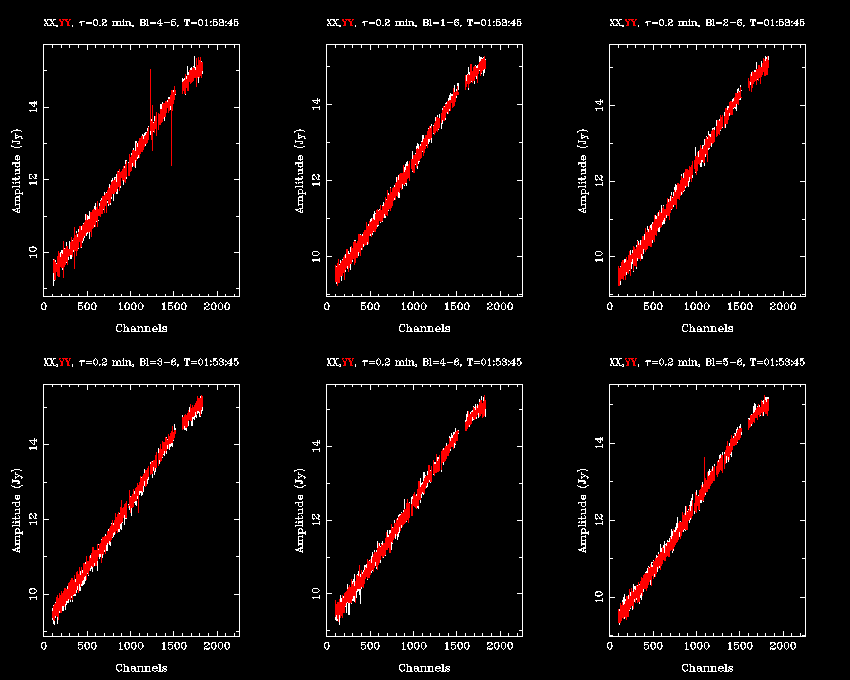

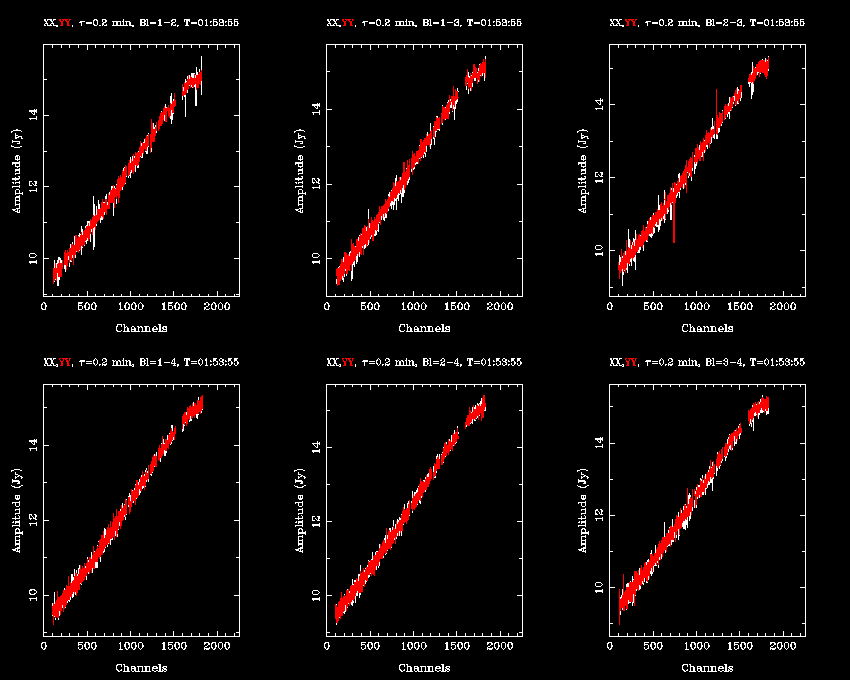

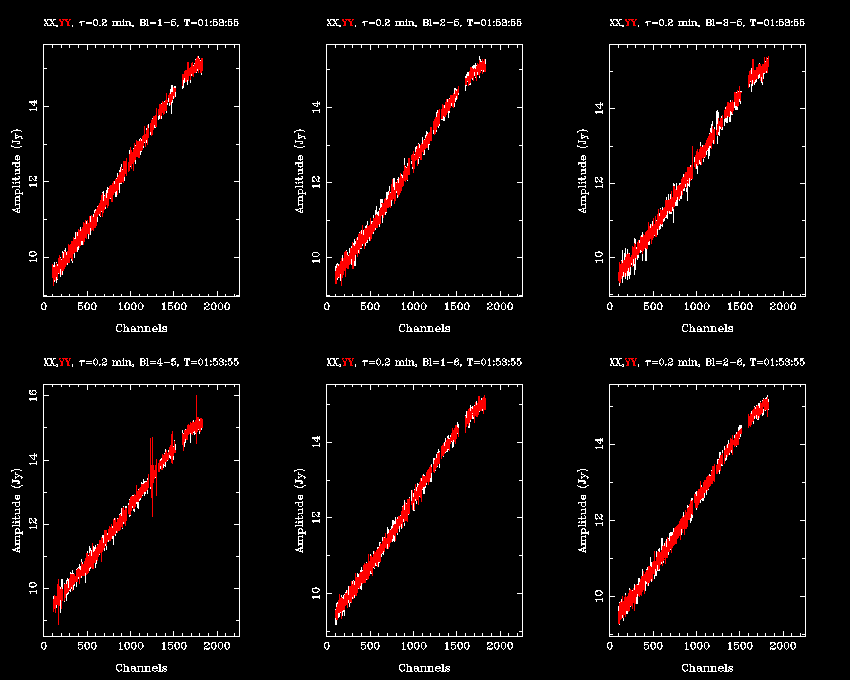

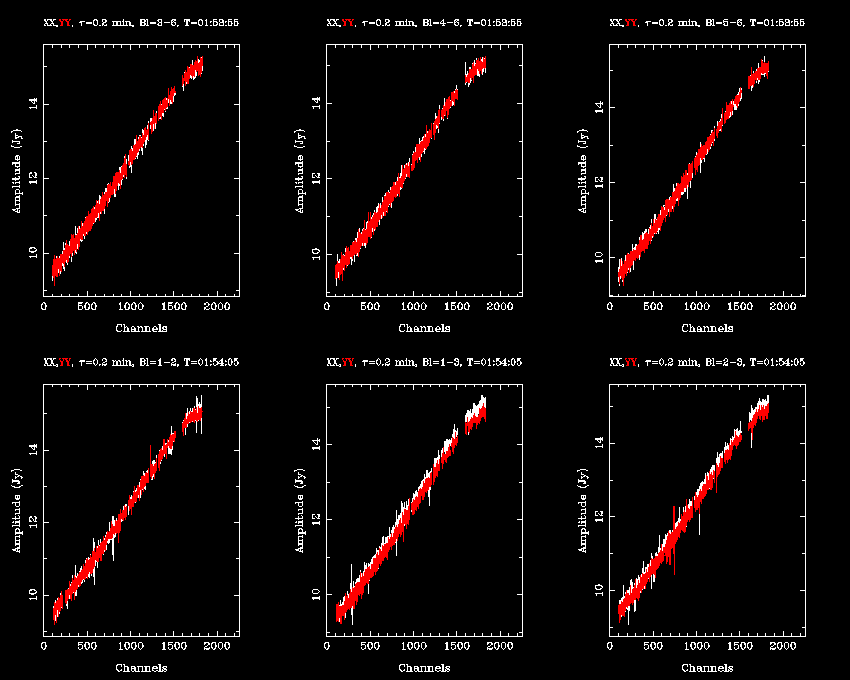

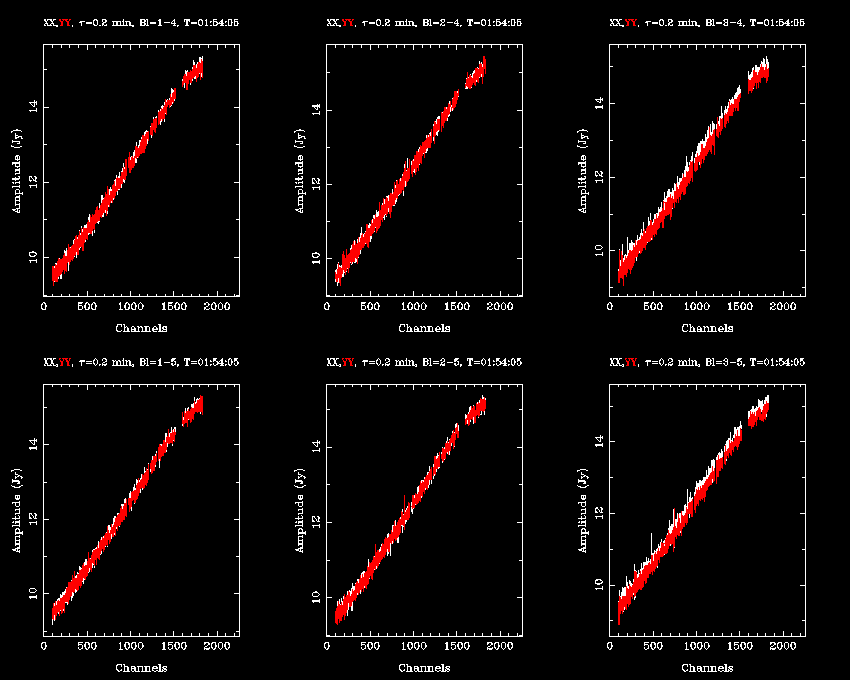

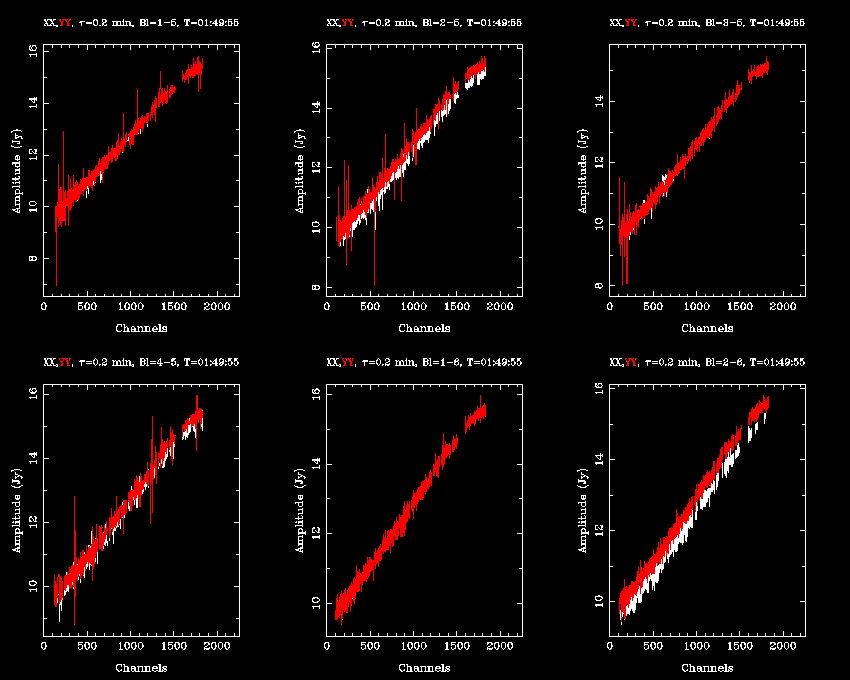

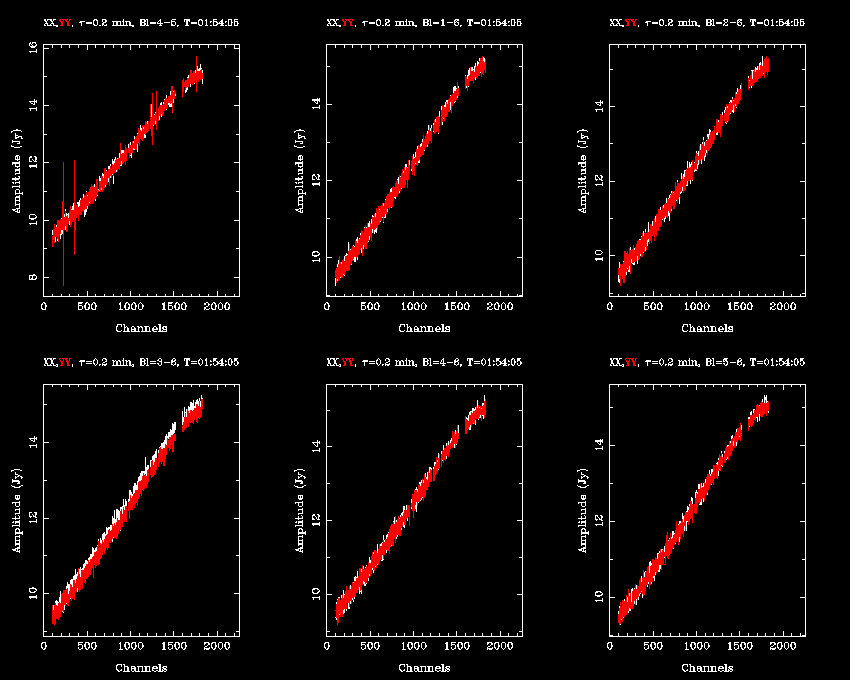

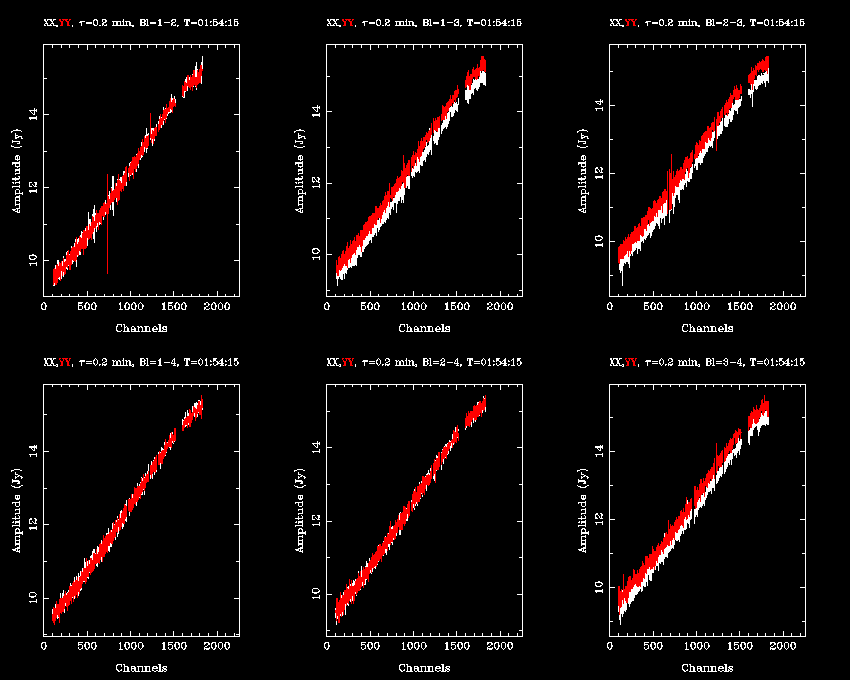

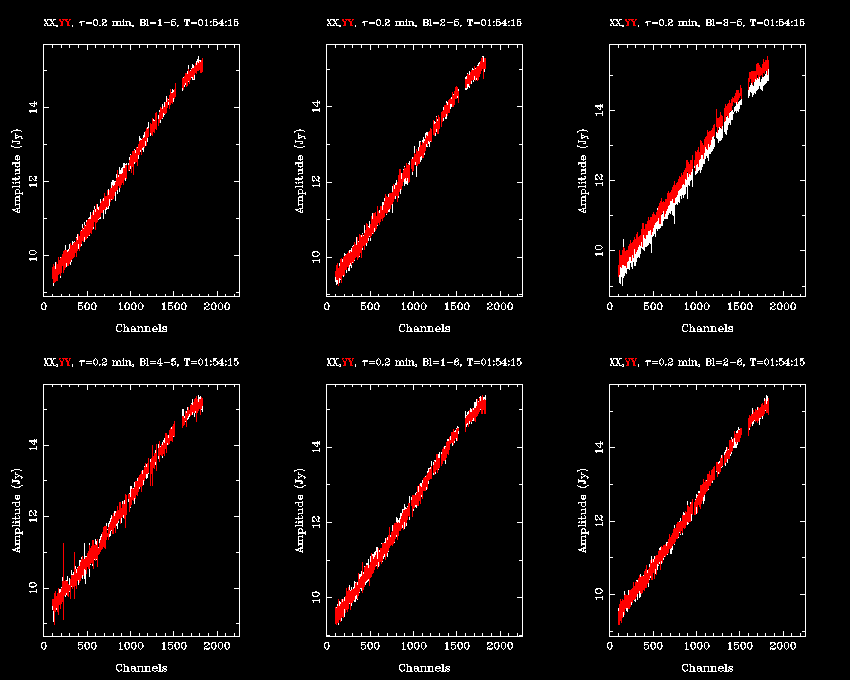

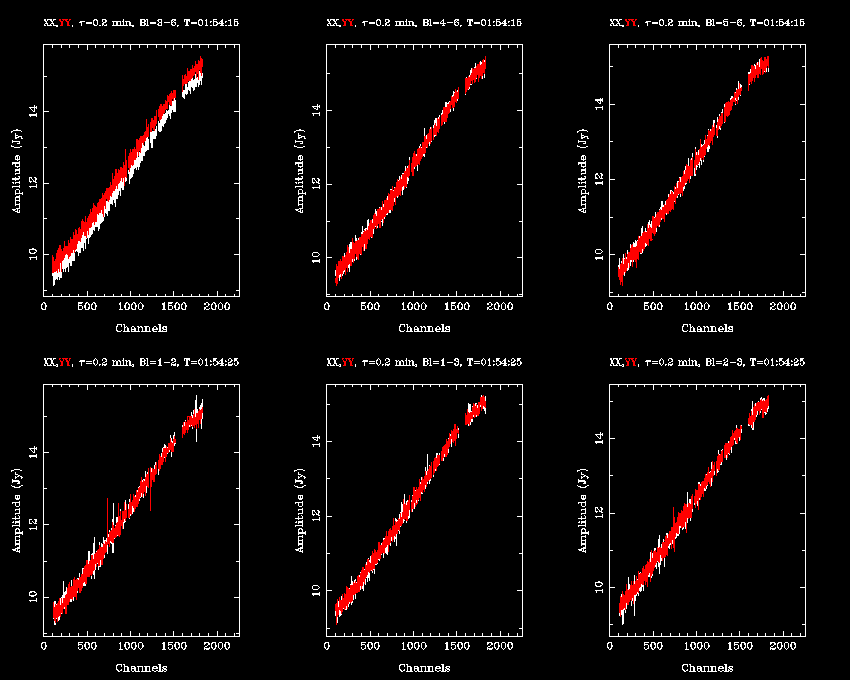

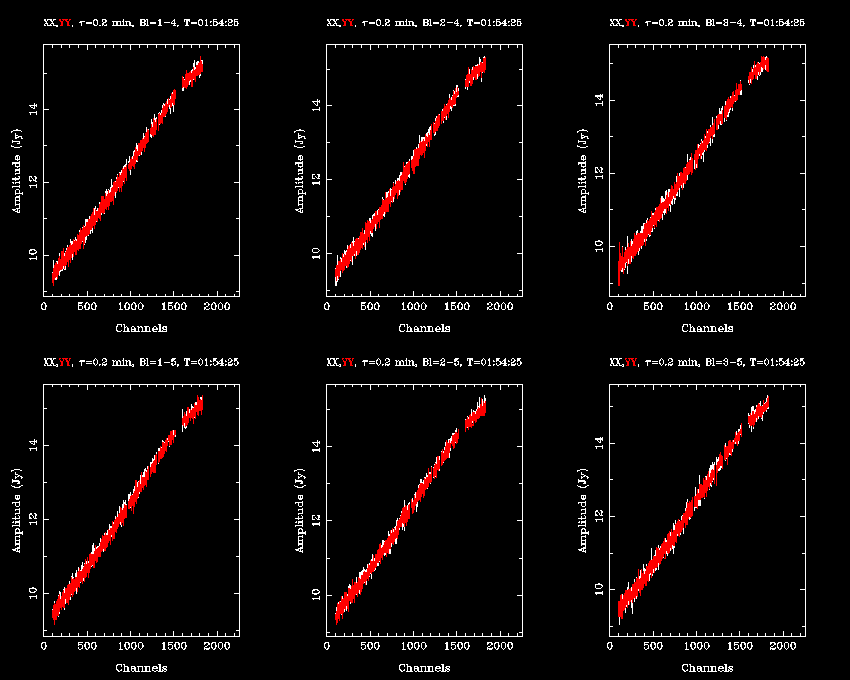

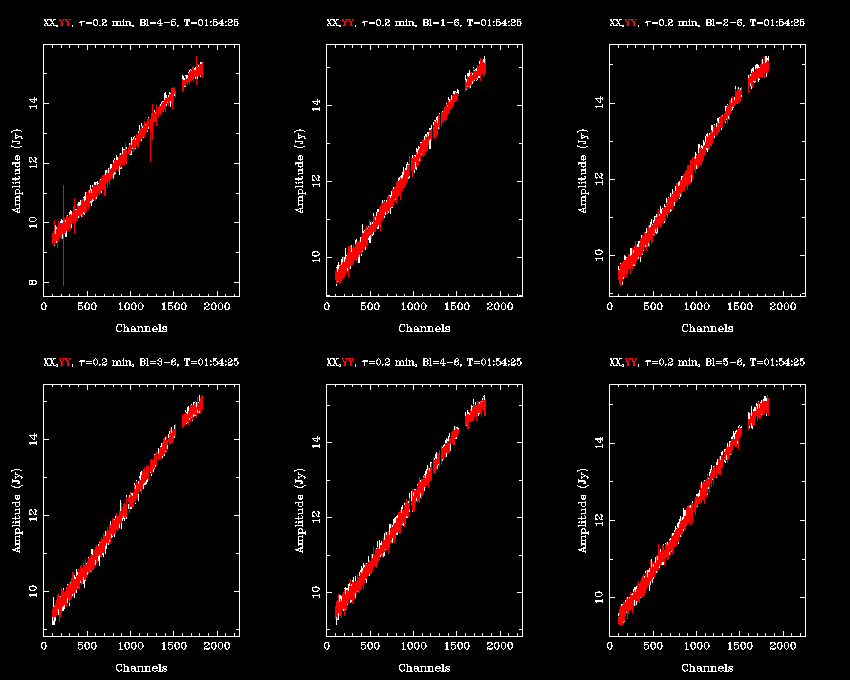

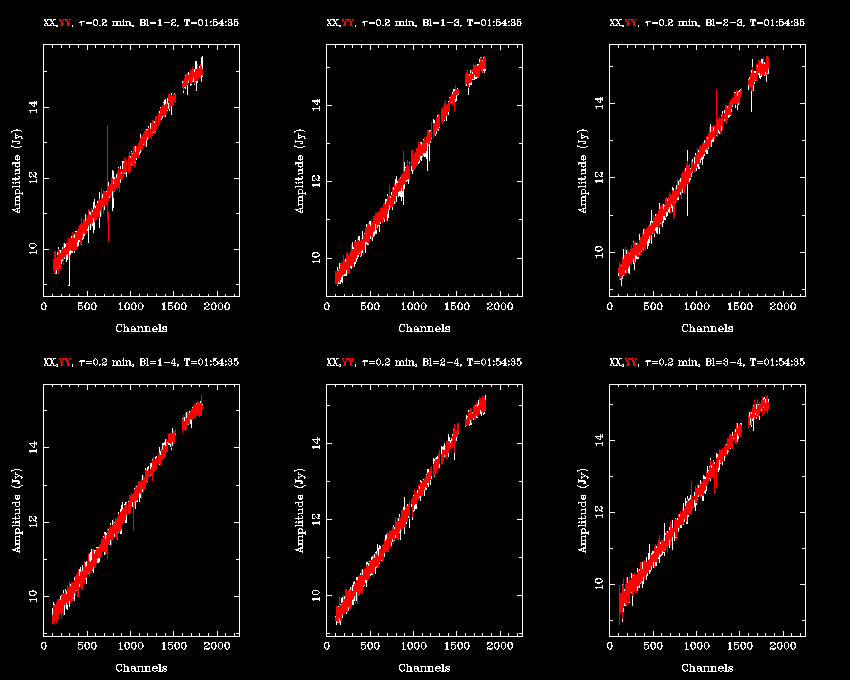

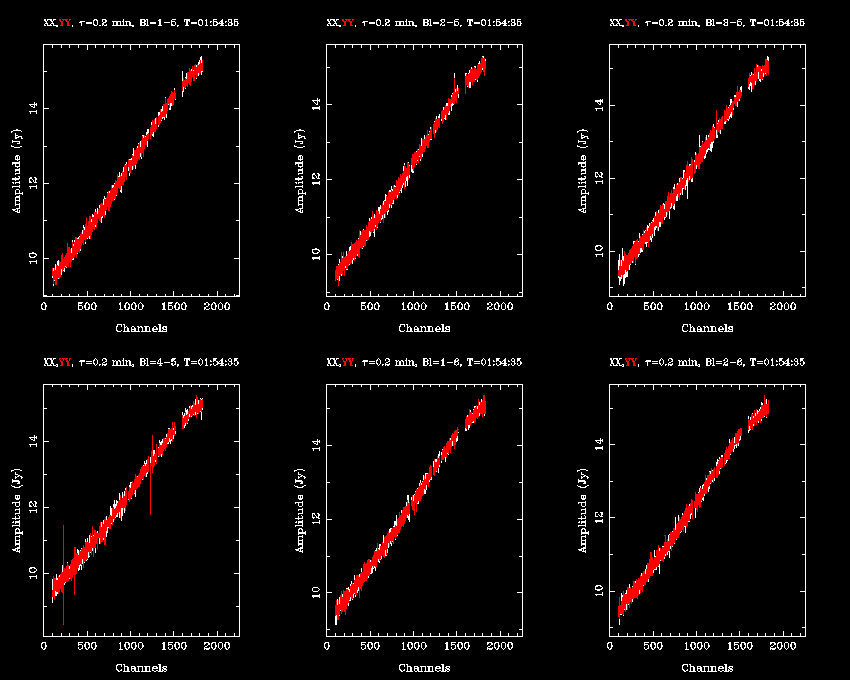

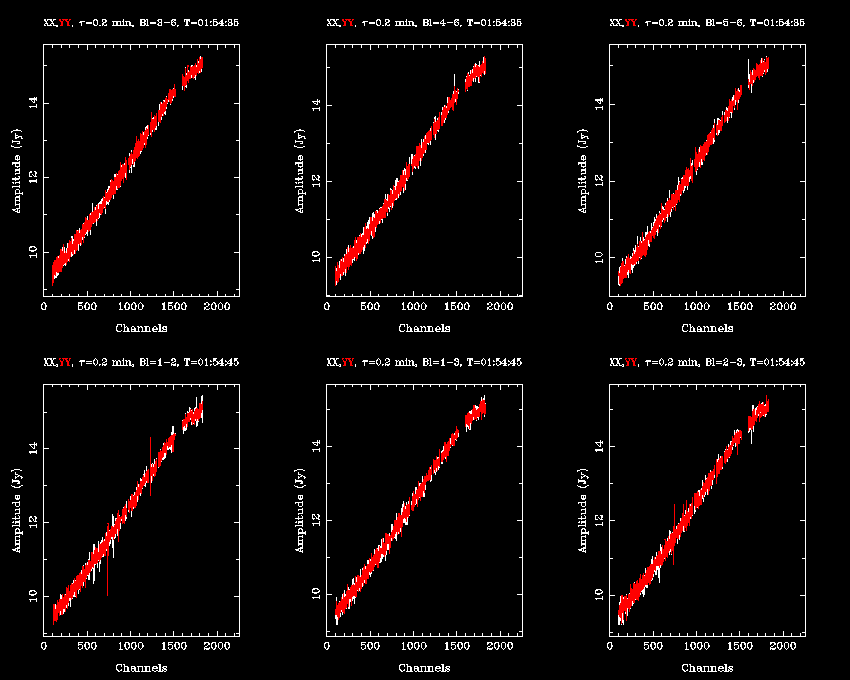

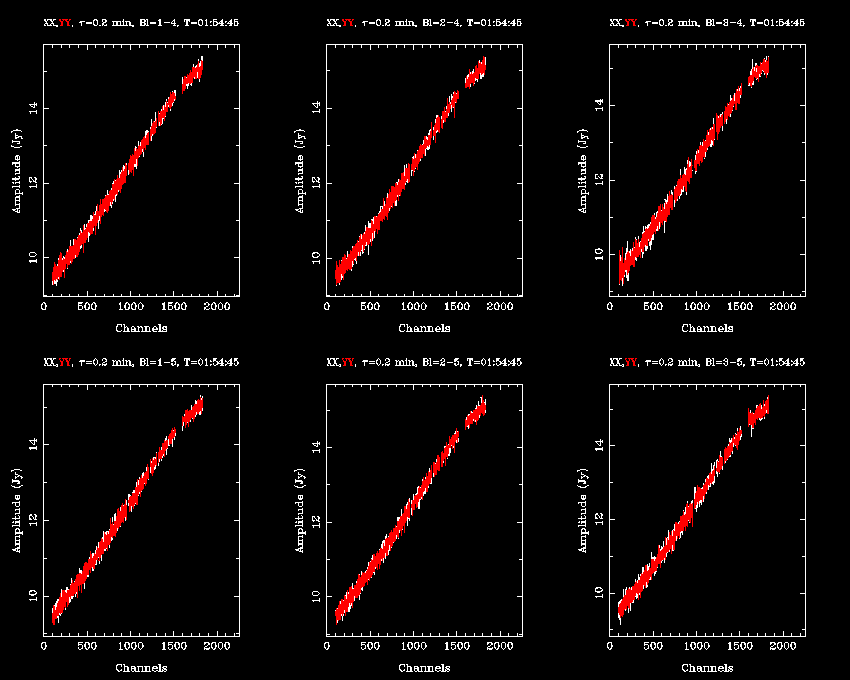

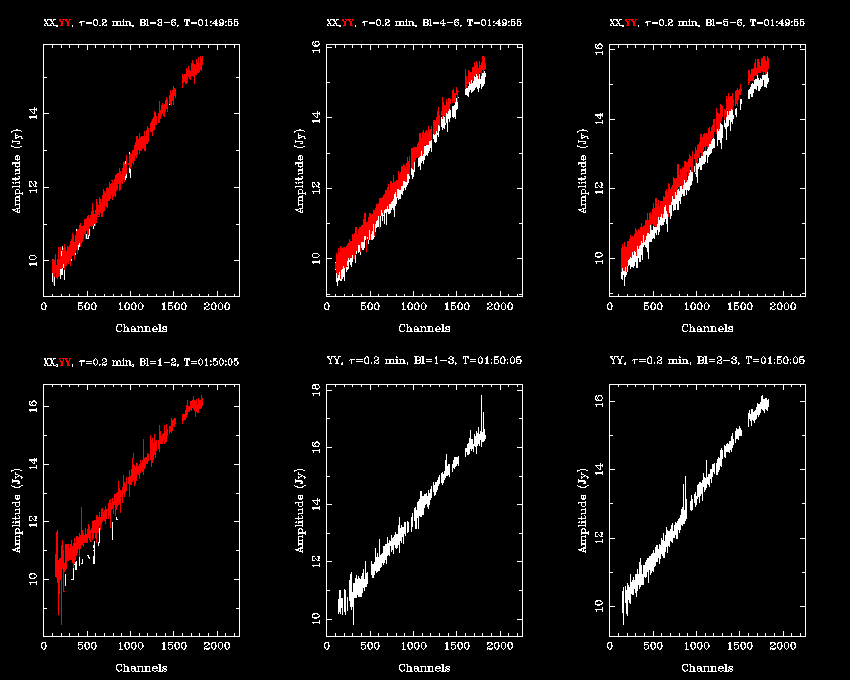

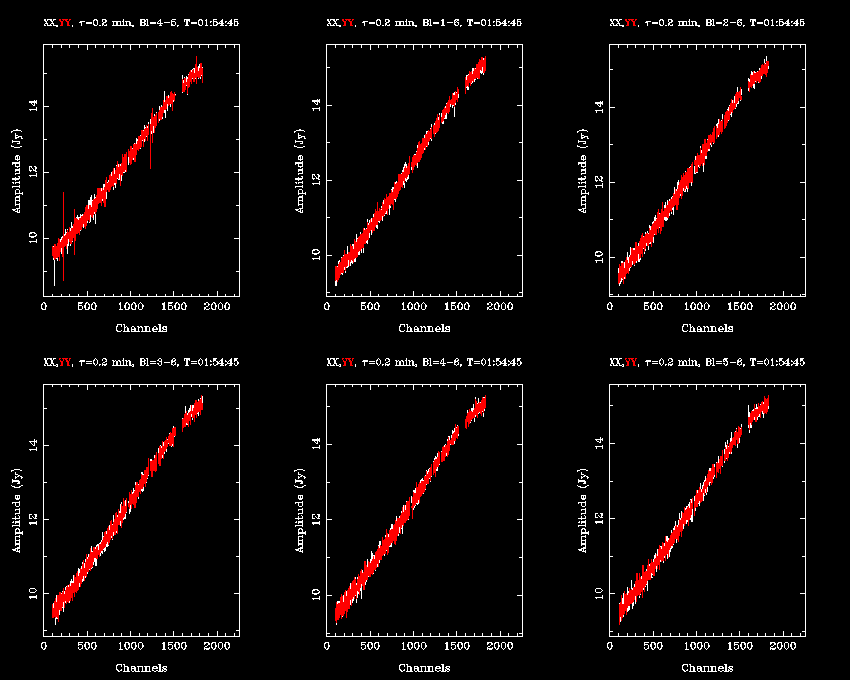

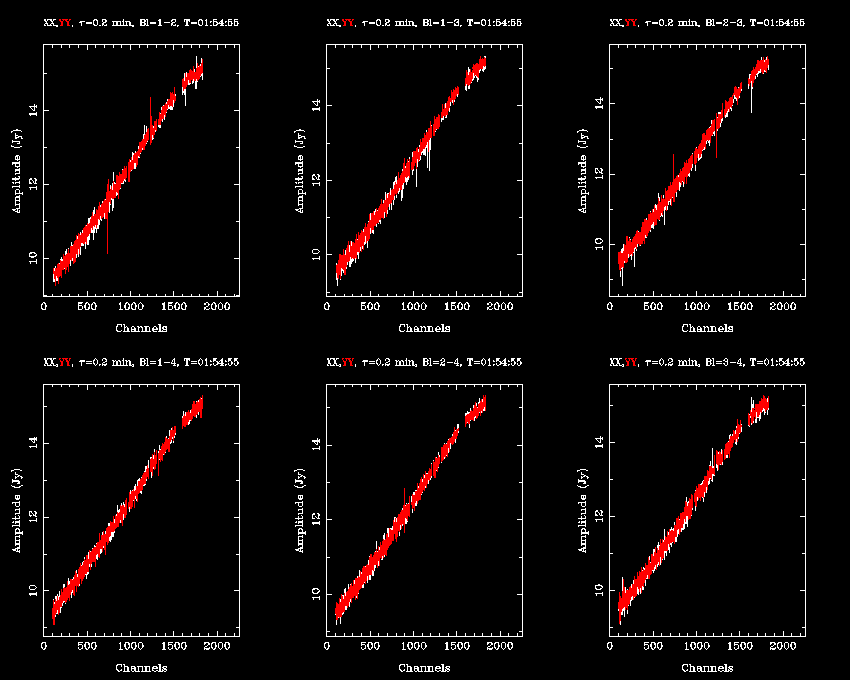

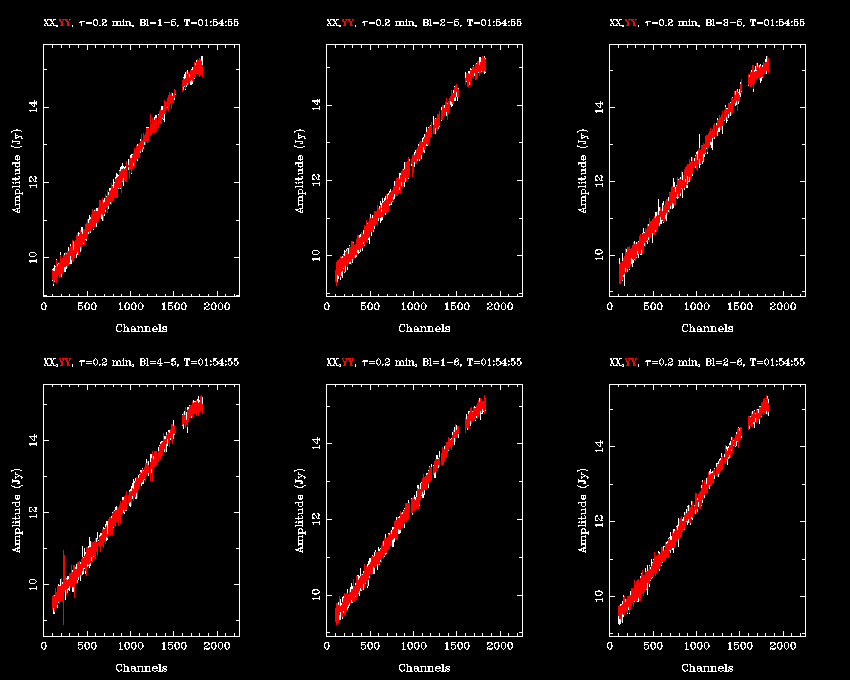

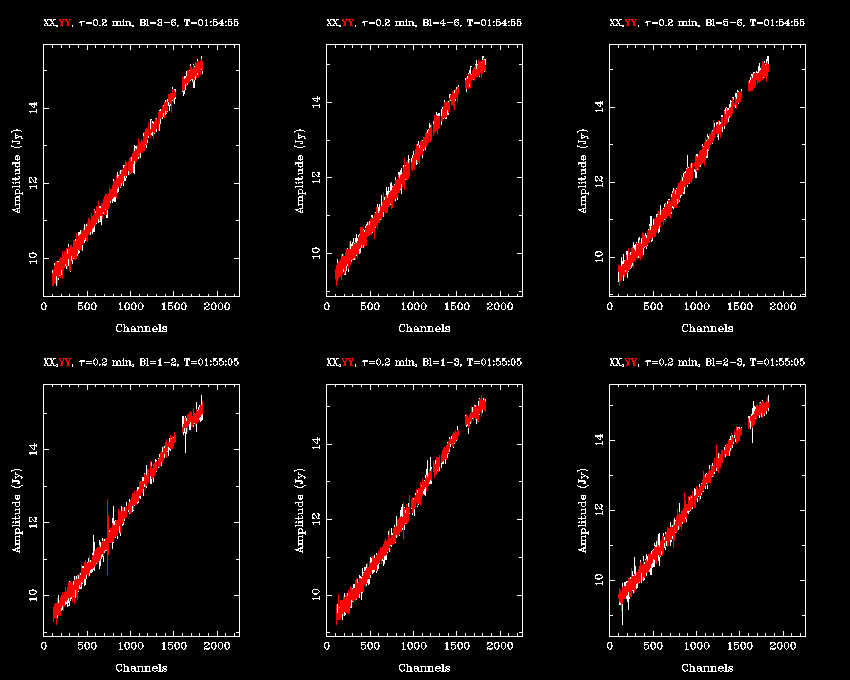

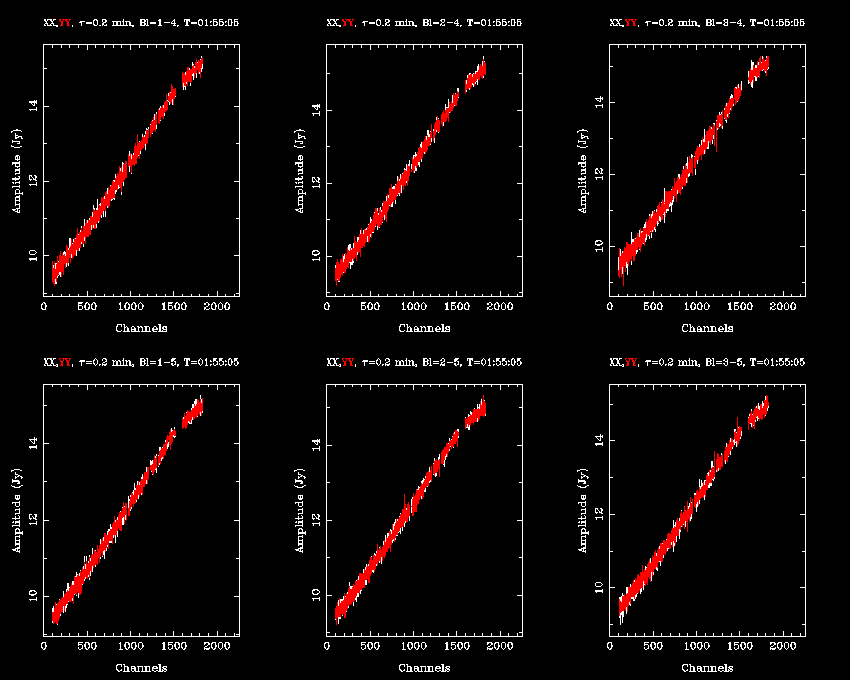

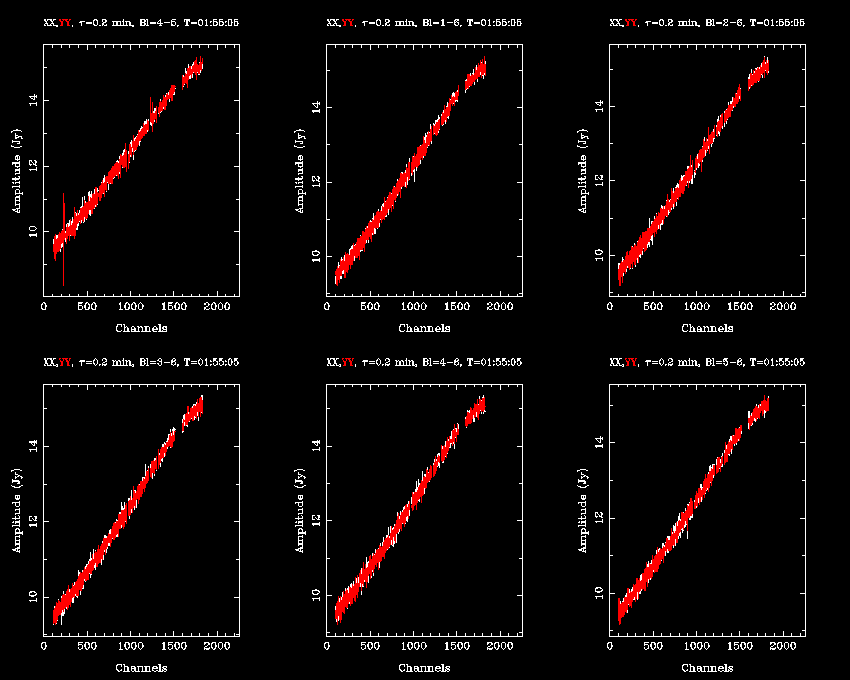

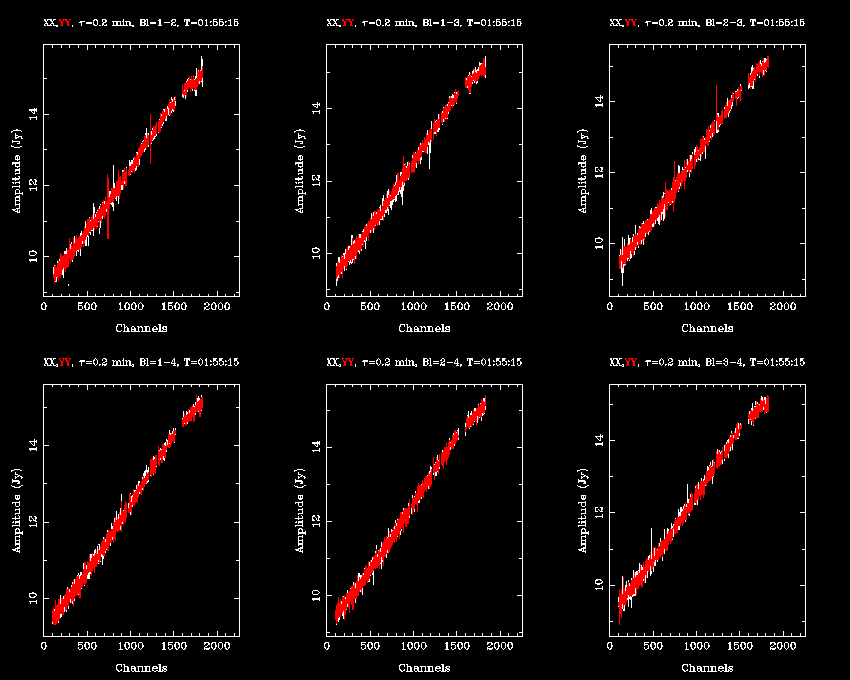

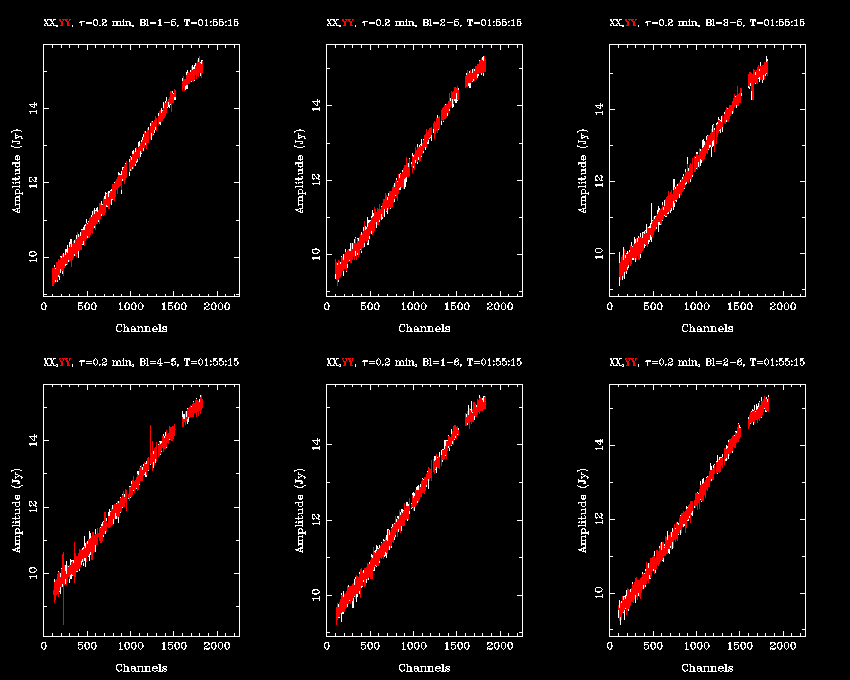

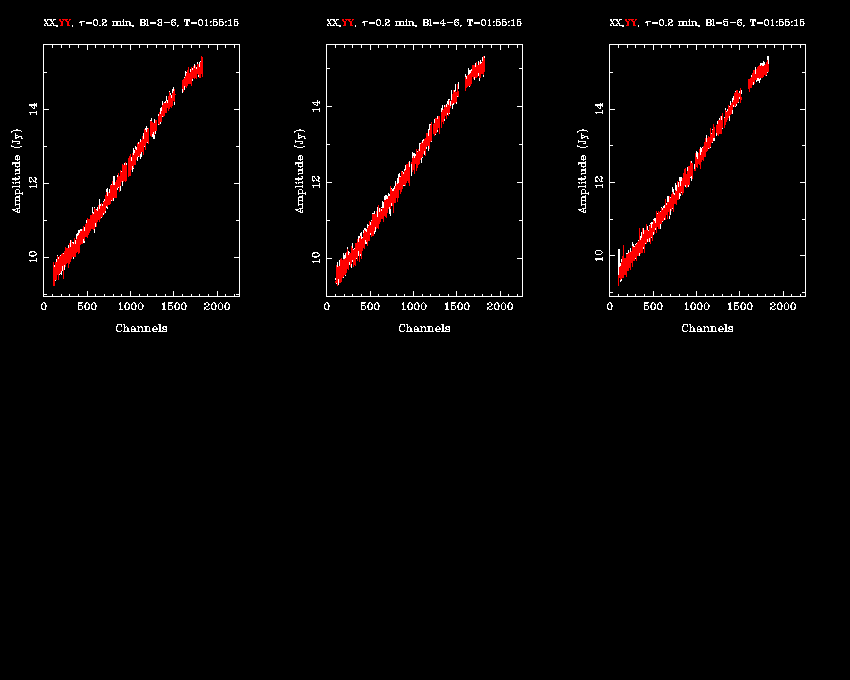

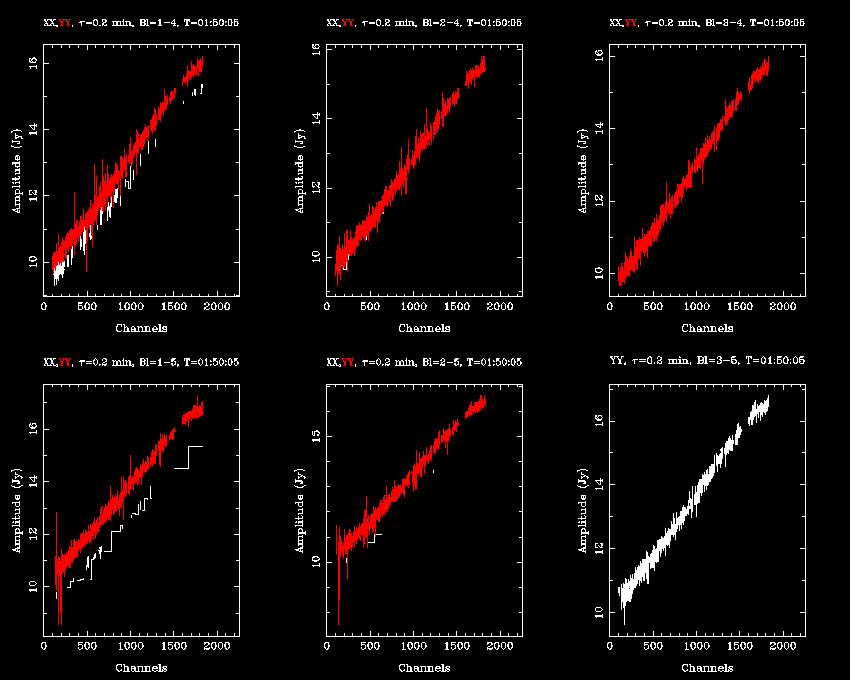

blflag: Revision 1.22, 2015/12/04 03:07:29 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Reading the data...
Number of points to edit: 763203
Entering interactive mode...
Define a region - exit with x
Define a region - exit with x
Applying the flagging...
Total number of correlations:   4302900
Number of correlations flagged: 845
MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $
Selecting parallel-hand polarisations
Reading the data ...
Number correlations accepted: 1417058
Number of frequency bands/settings: 1
Number of polarisations selected: 2
Number of solution intervals: 2
Number of passband solution intervals: 1
Initialising ...
Using post-Aug94 ATCA flux scale for 1934-638.
Using known frequency variation of 1934-638
Generating initial solution estimate ...
Doing solution refinement ...
Iter= 1, Solution Error:  0.674
Iter= 2, Solution Error:  0.006
Iter= 3, Solution Error:  0.000
Saving solution ...
##########Post RFI bandpa

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'mfcal':  Correlations flagged or edge-rejected: 734392
  warnings.warn(msg)


uvplt: Revision 1.18, 2014/05/21 04:34:59 UTC

Will plot unflagged data

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100


File # 1  = 1934-638.2100
1934-638.2100 2.1000 GHz
Read 1037 visibilities from all files

Baseline 1-2, plot 86913 points
Baseline 1-3, plot 88775 points
Baseline 2-3, plot 88948 points
Baseline 1-4, plot 97607 points
Baseline 2-4, plot 101068 points
Baseline 3-4, plot 92697 points
Baseline 1-5, plot 95157 points
Baseline 2-5, plot 99239 points
Baseline 3-5, plot 92497 points
Baseline 4-5, plot 93905 points
Baseline 1-6, plot 93677 points
Baseline 2-6, plot 97474 points
Baseline 3-6, plot 92952 points
Baseline 4-6, plot 97978 points
Baseline 5-6, plot 98171 points


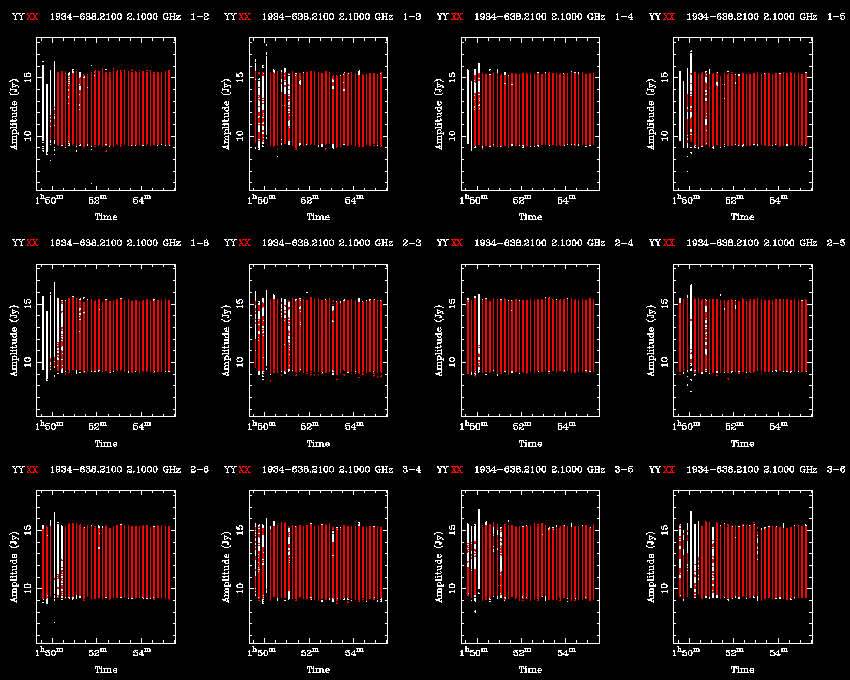

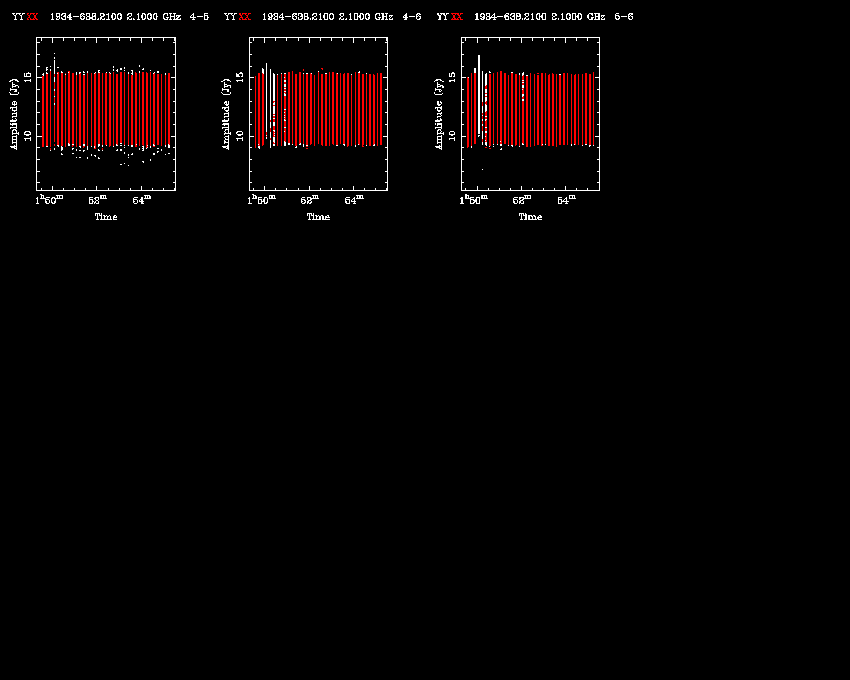

pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Do SumThreshold operation on baseline   1   2
 33.3% of the data on this baseline is now flagged
 33.3% of the data on this baseline is now flagged
 33.3% of the data on this baseline is now flagged
Blow away the dust...
 33.3% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   3
 31.5% of the data on this baseline is now flagged
 31.5% of the data on this baseline is now flagged
 31.6% of the data on this baseline is now flagged
Blow away the dust...
 31.6% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   2   3
 31.6% of the data on this baseline is now flagged
 31.6% of the data on this baseline is now flagged
 31.6% of the data on this baseline is now flagged
Blow away the dust...
 31.6% of the data on this baseline is now flagged
Do SumThreshold operation on baseline   1   4


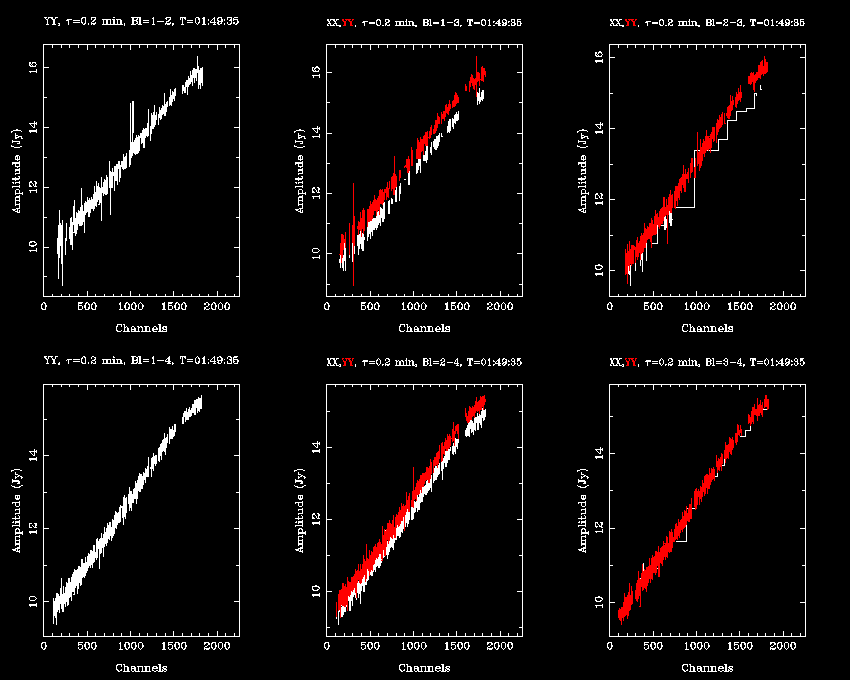

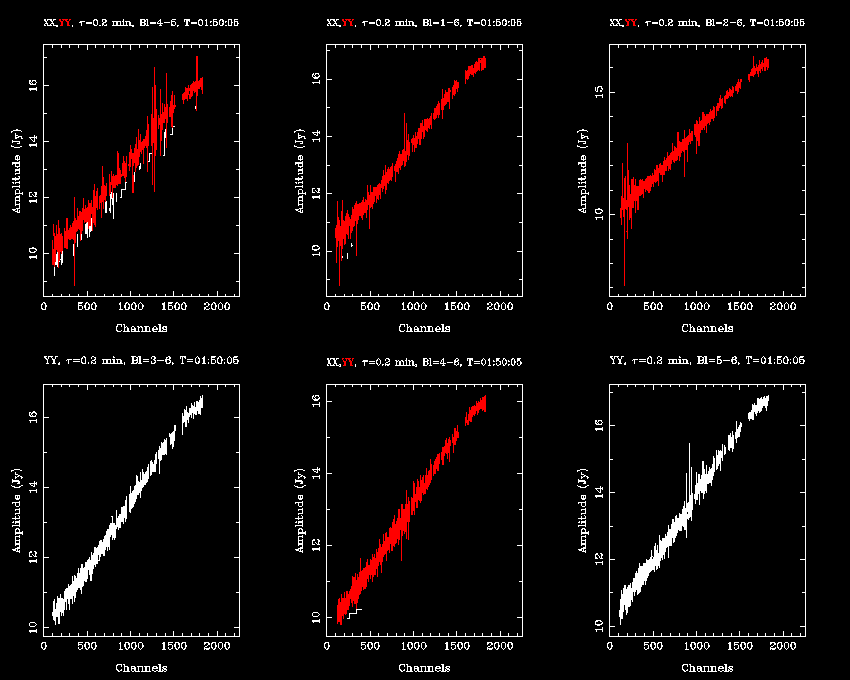

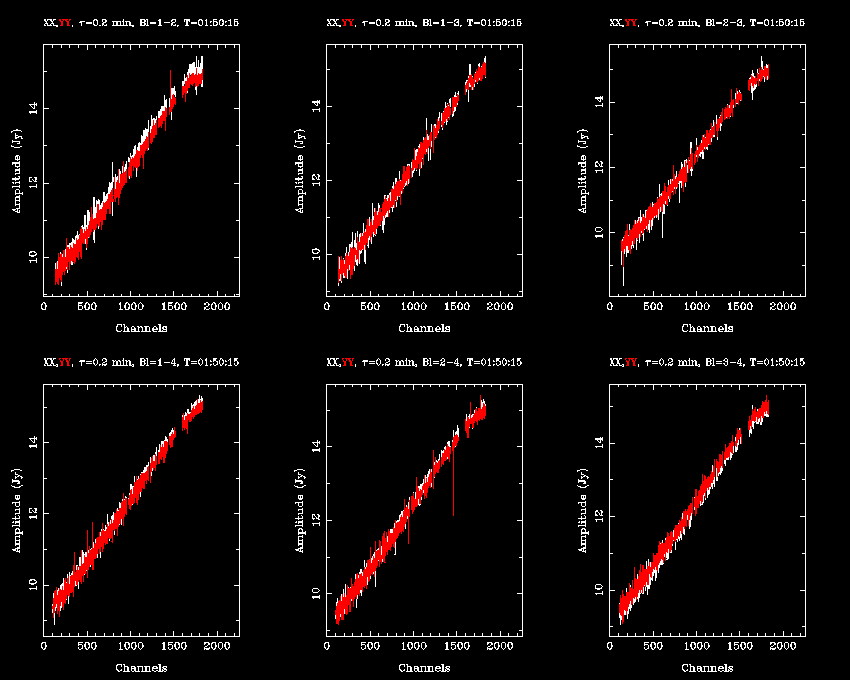

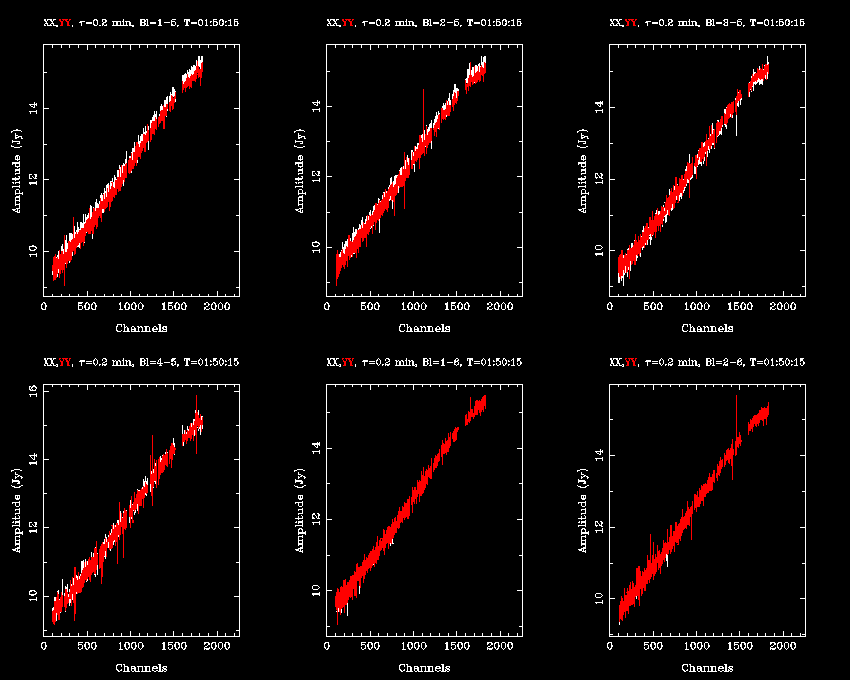

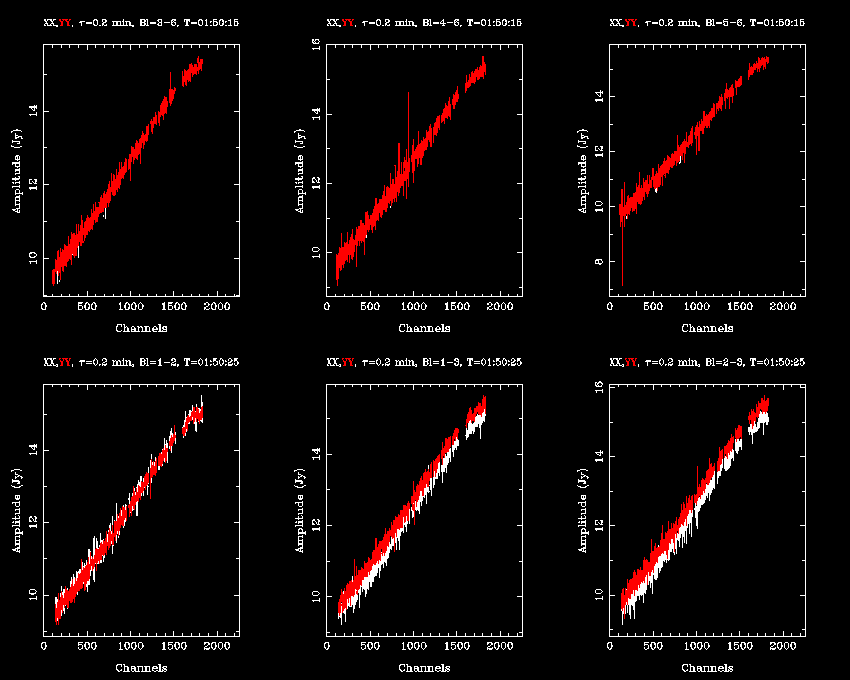

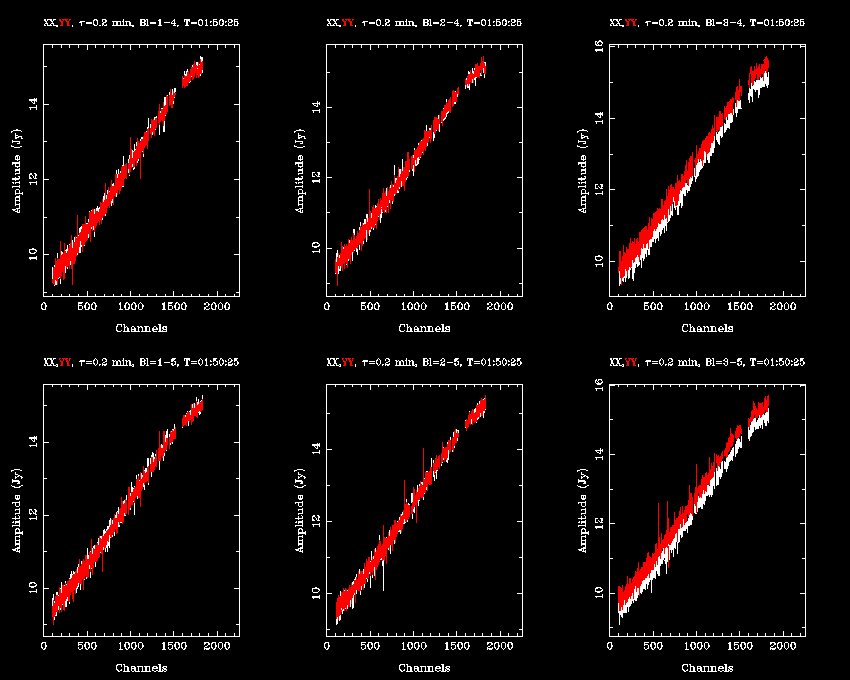

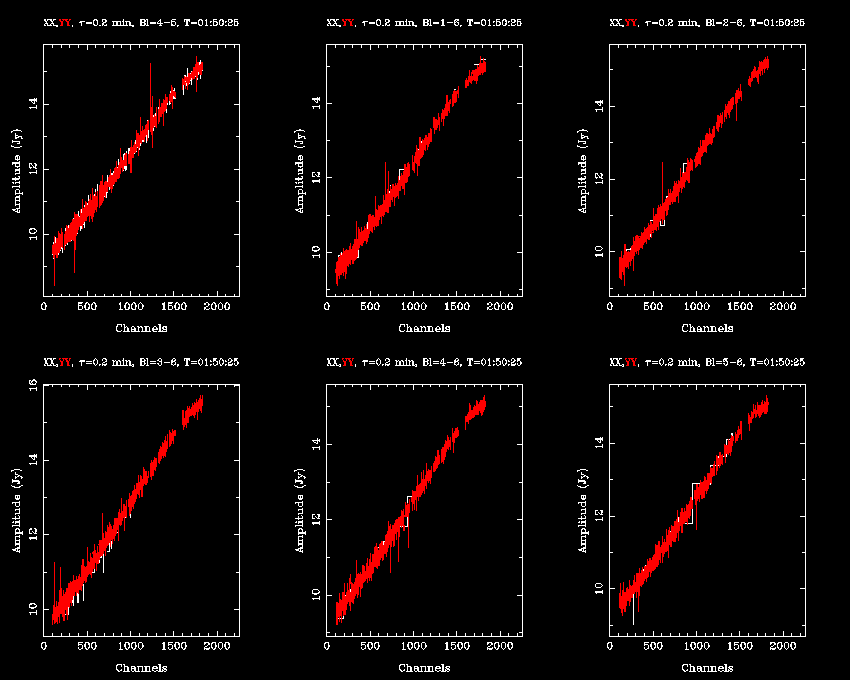

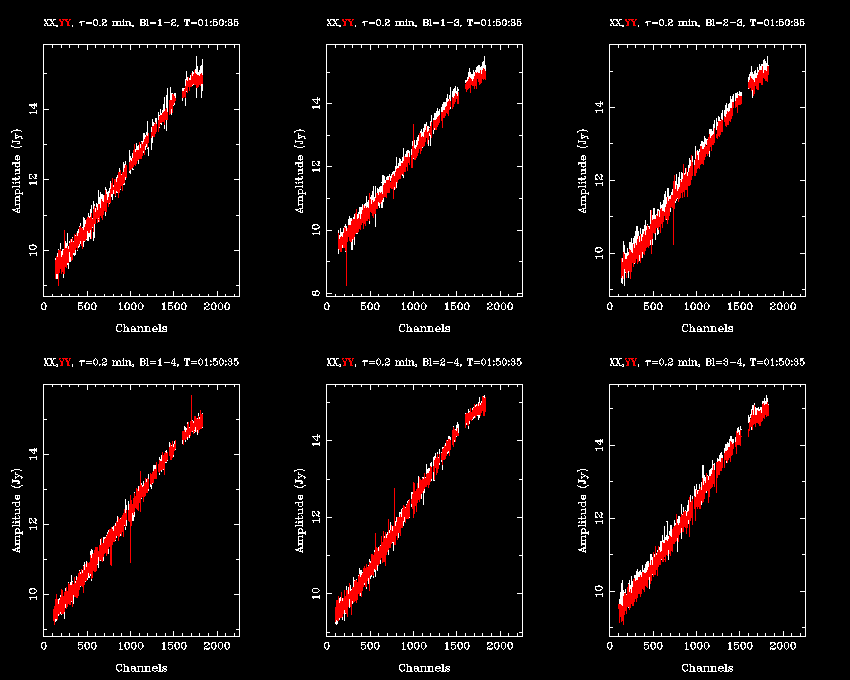

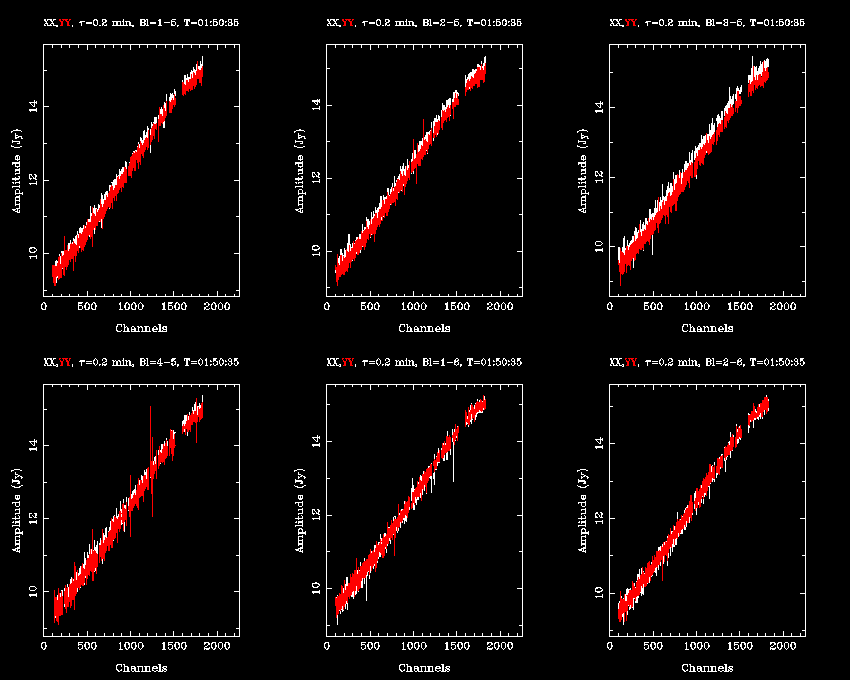

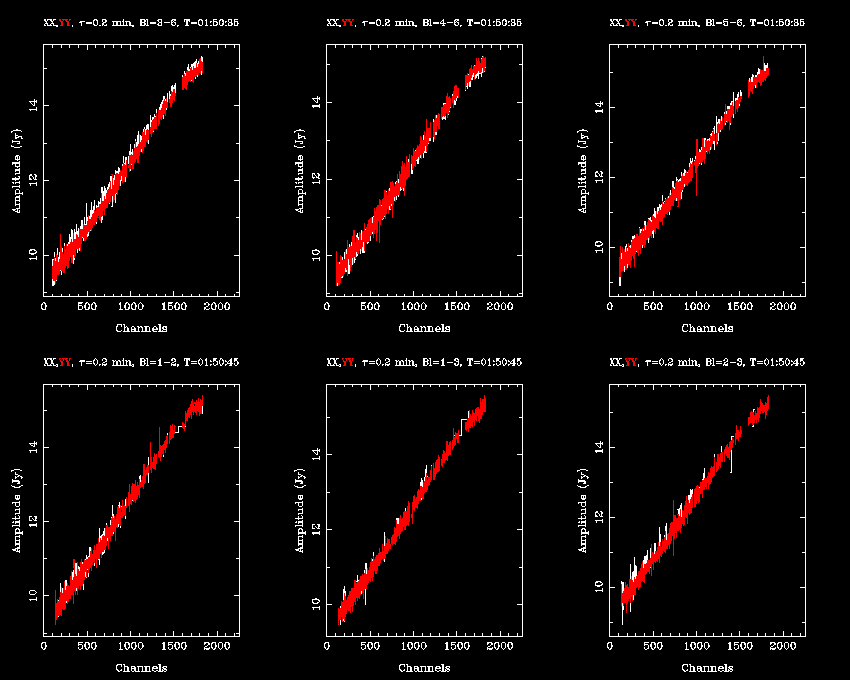

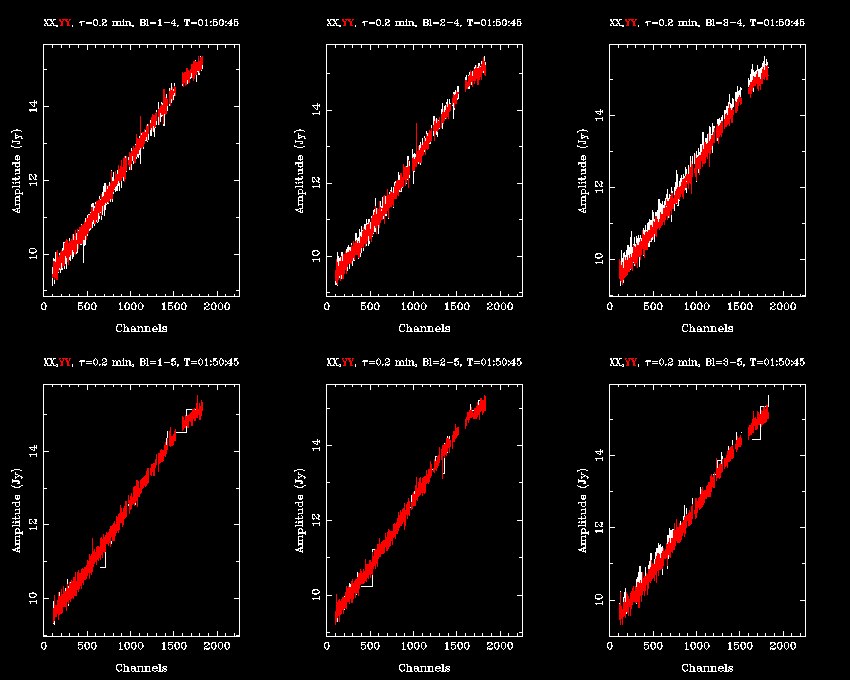

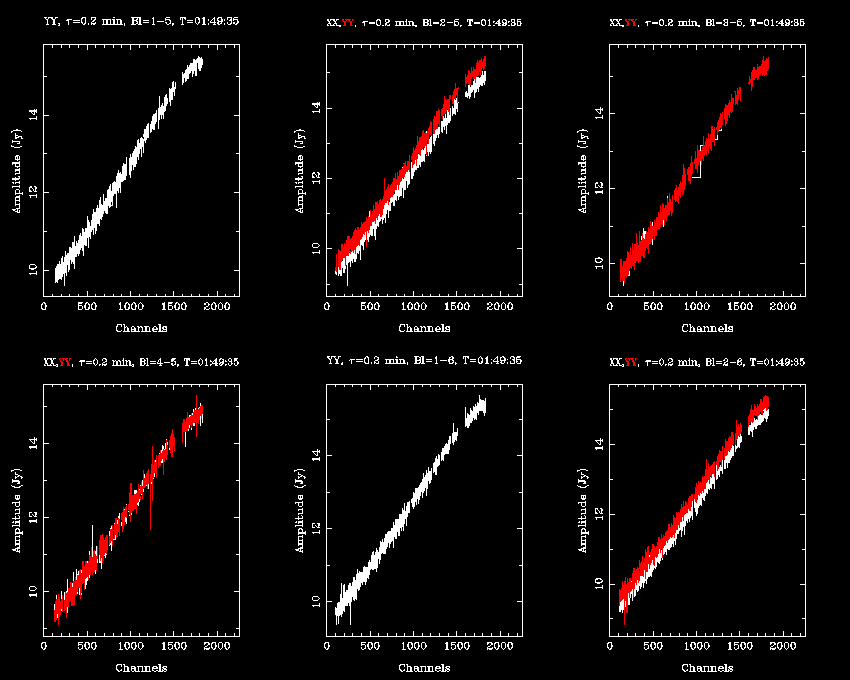

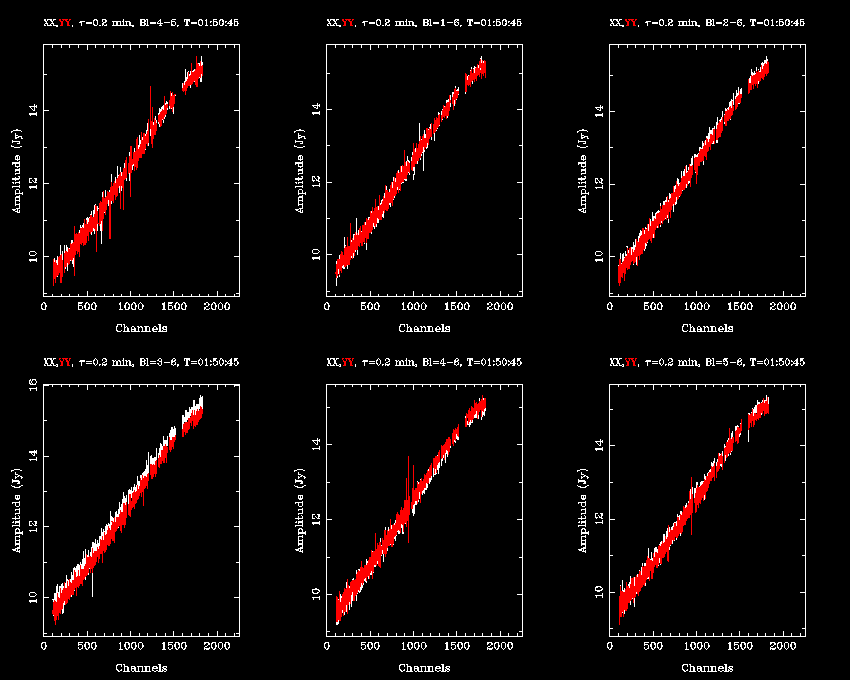

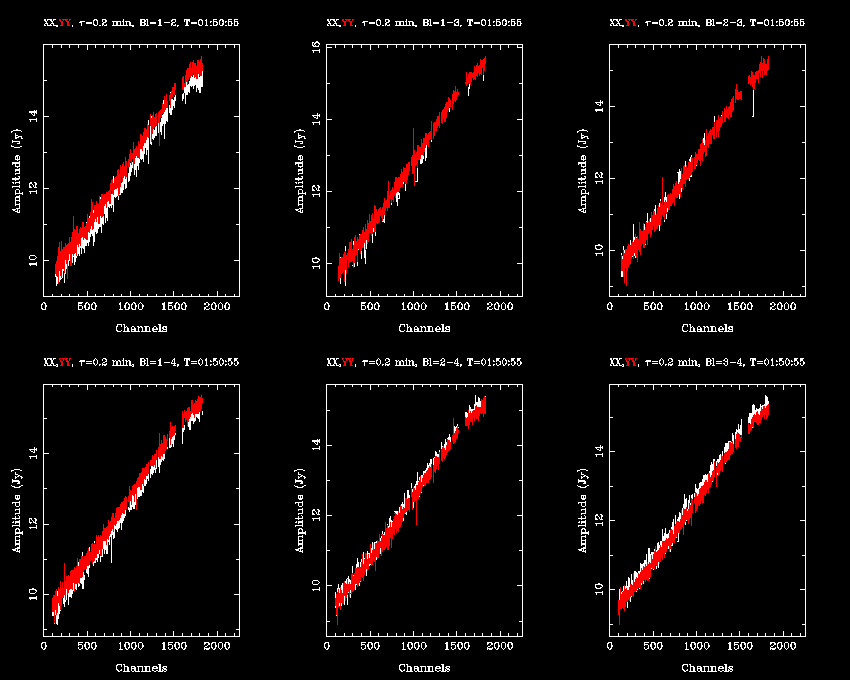

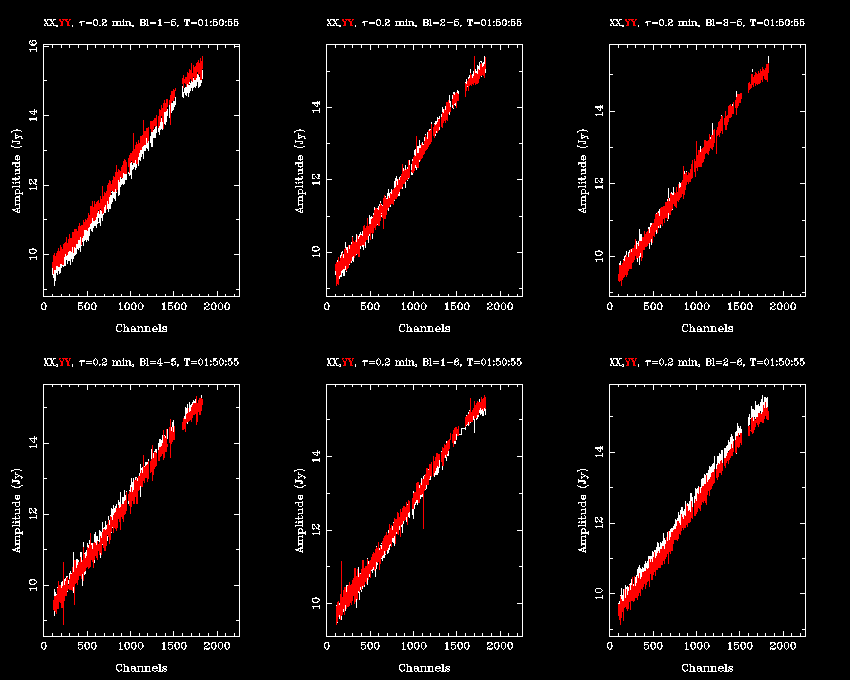

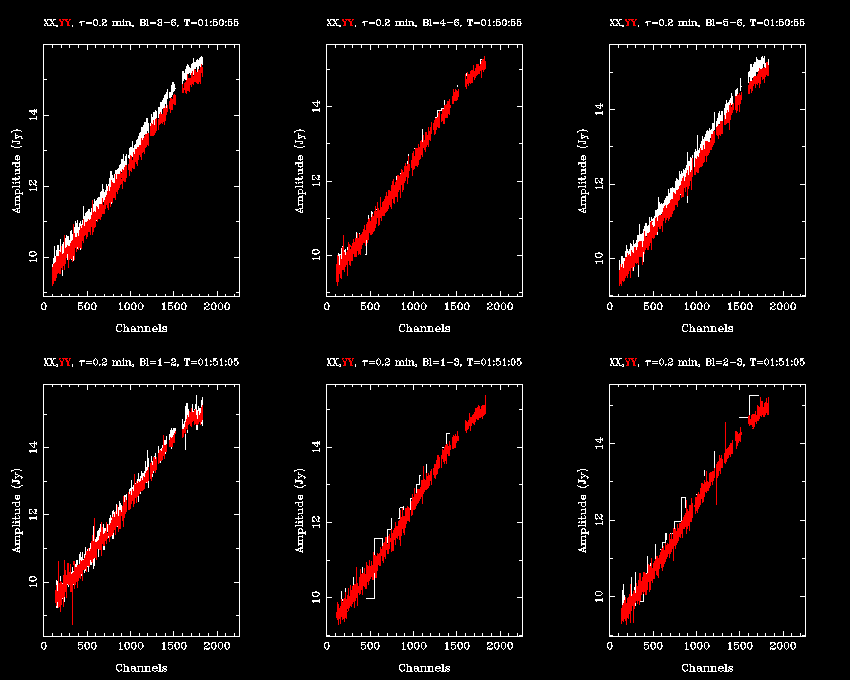

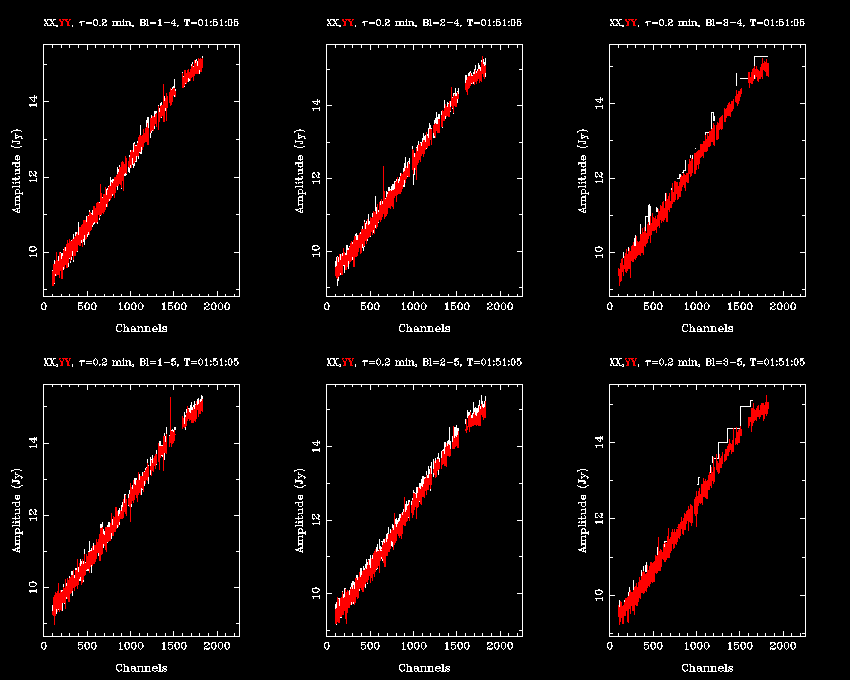

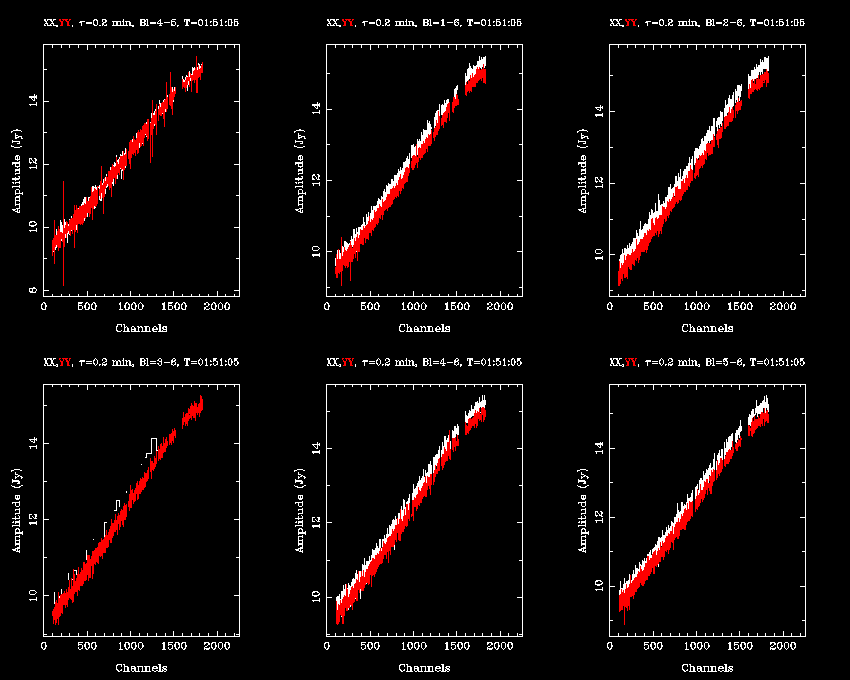

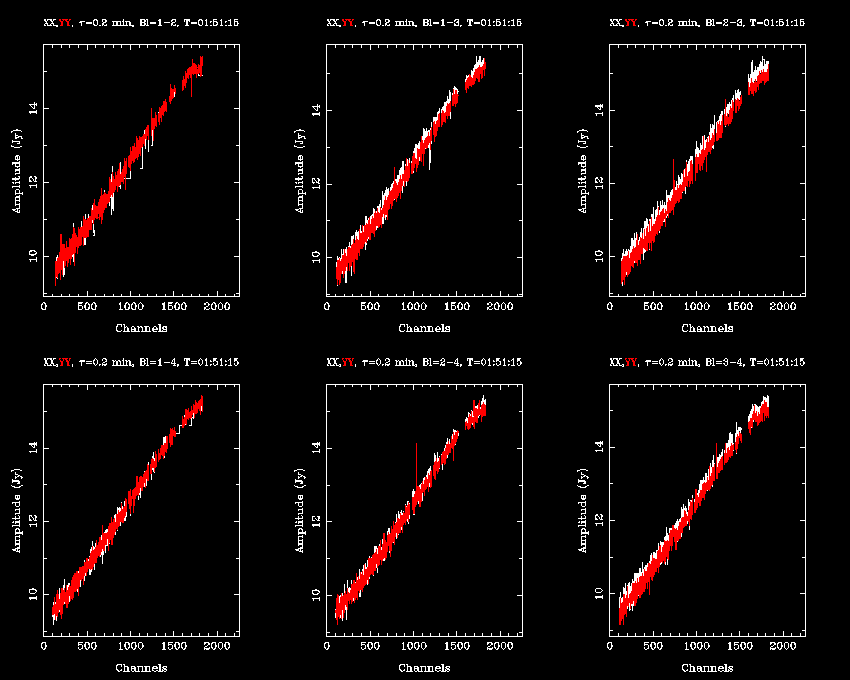

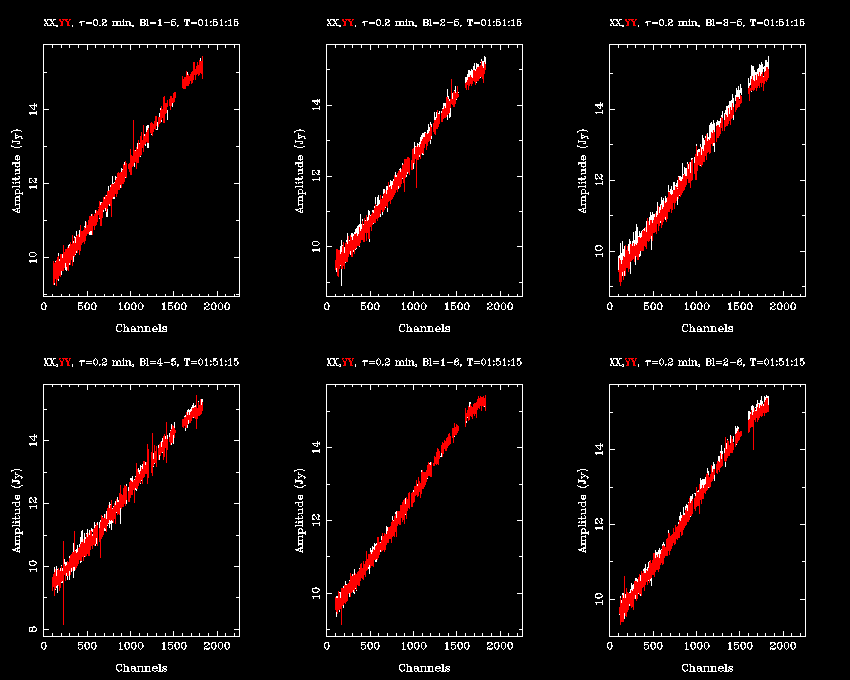

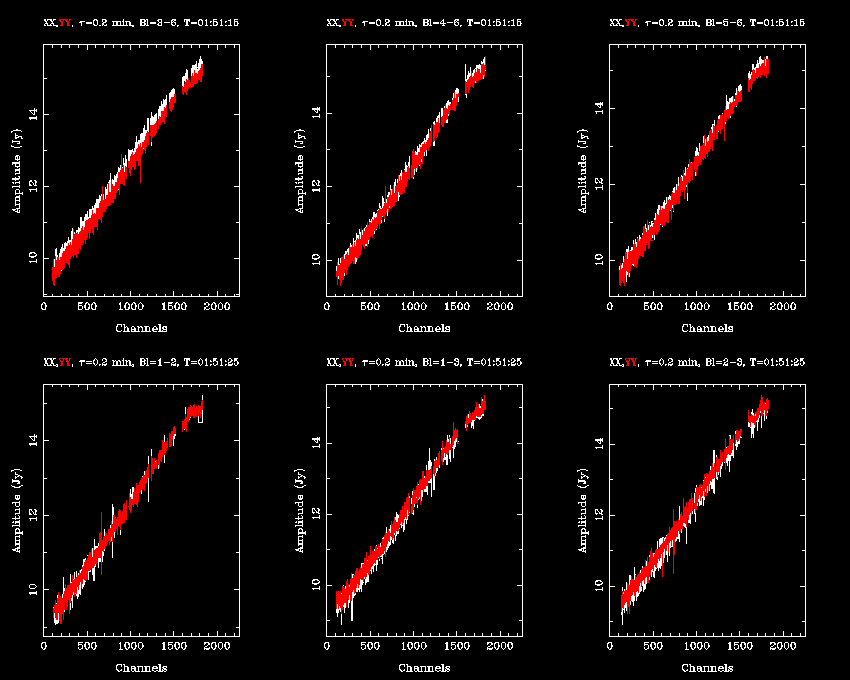

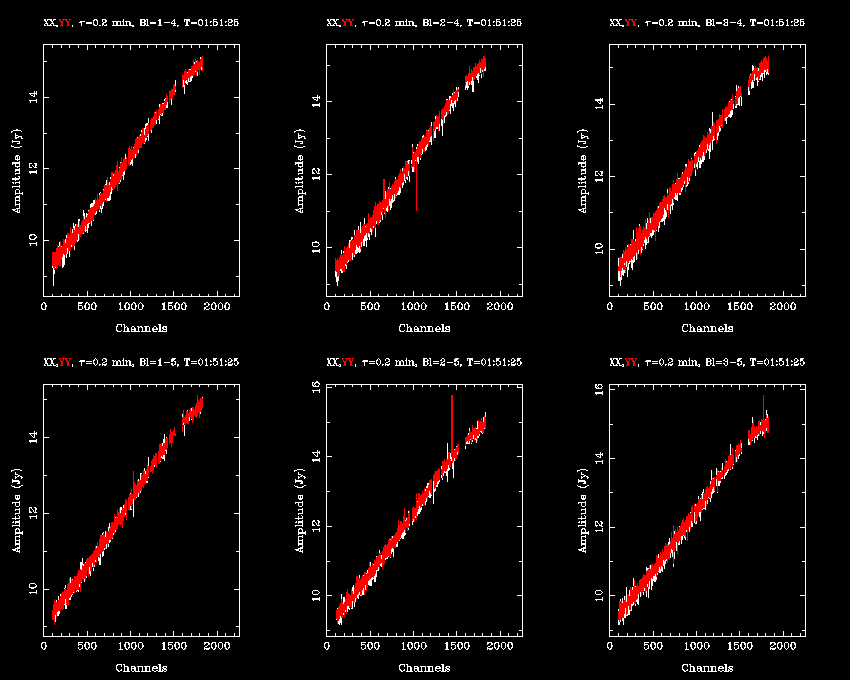

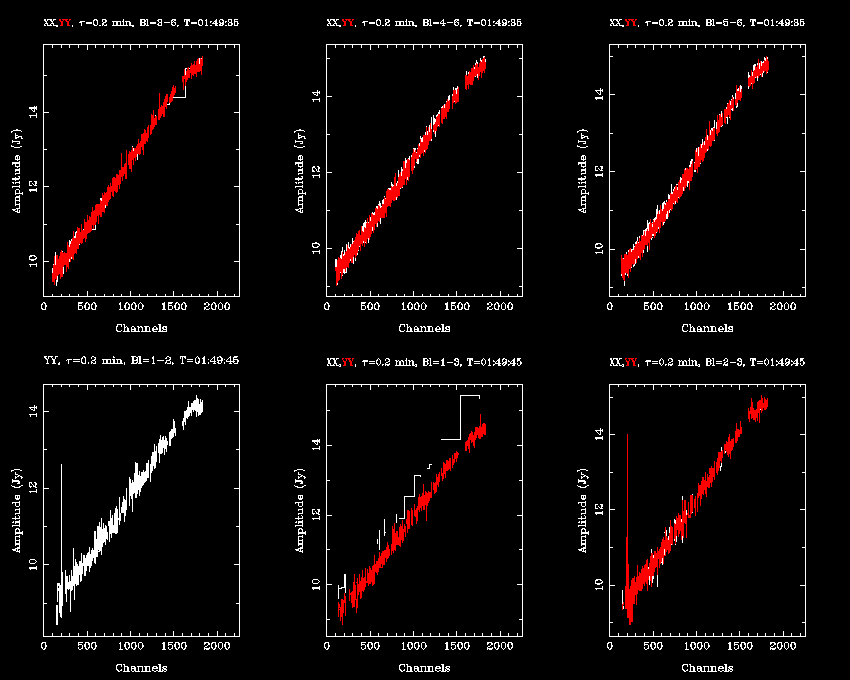

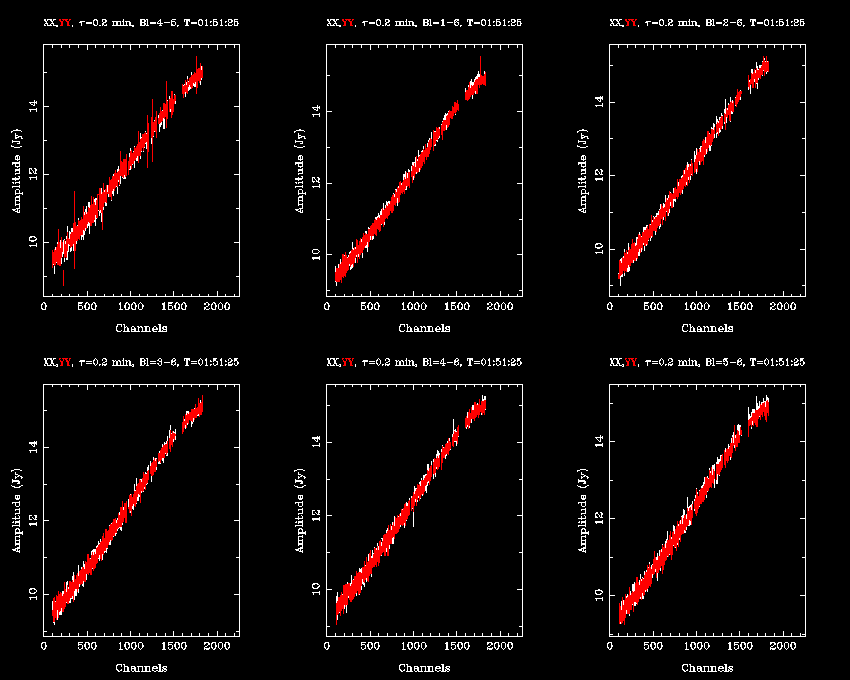

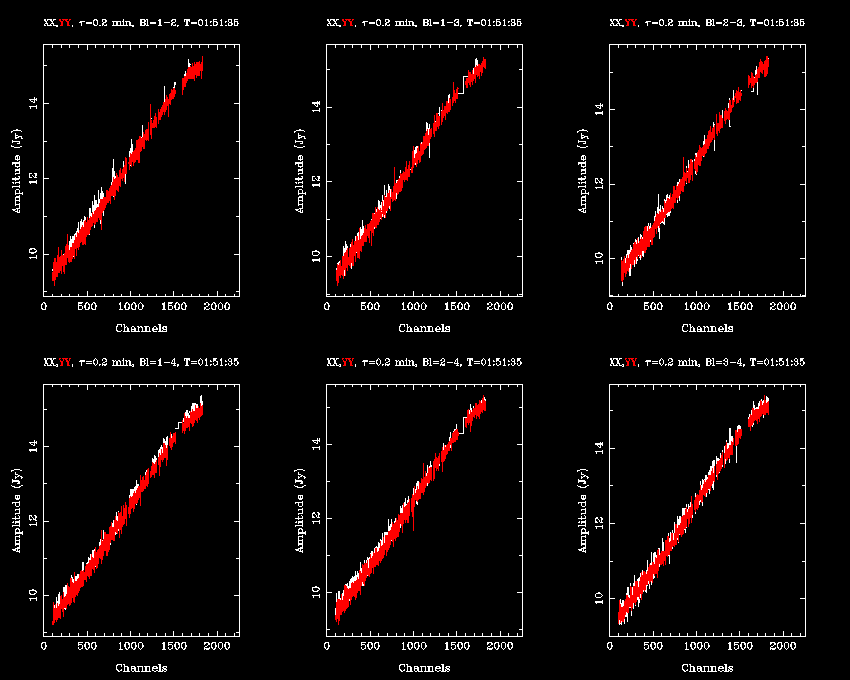

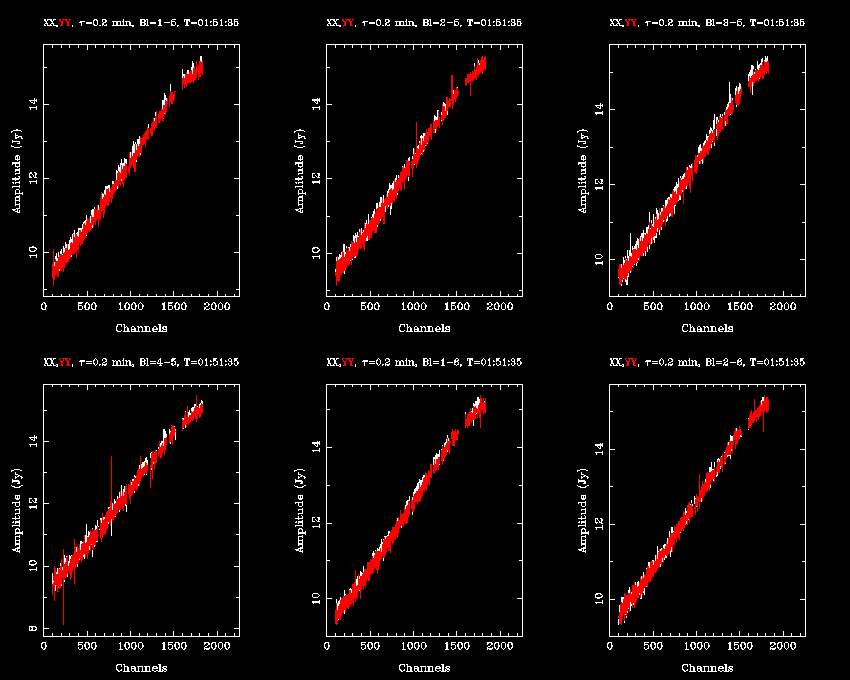

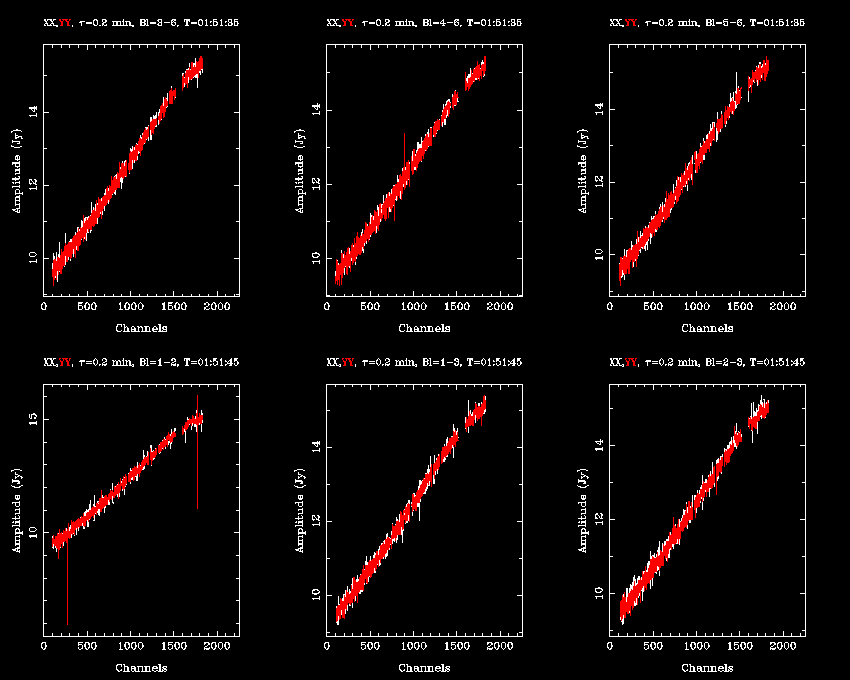

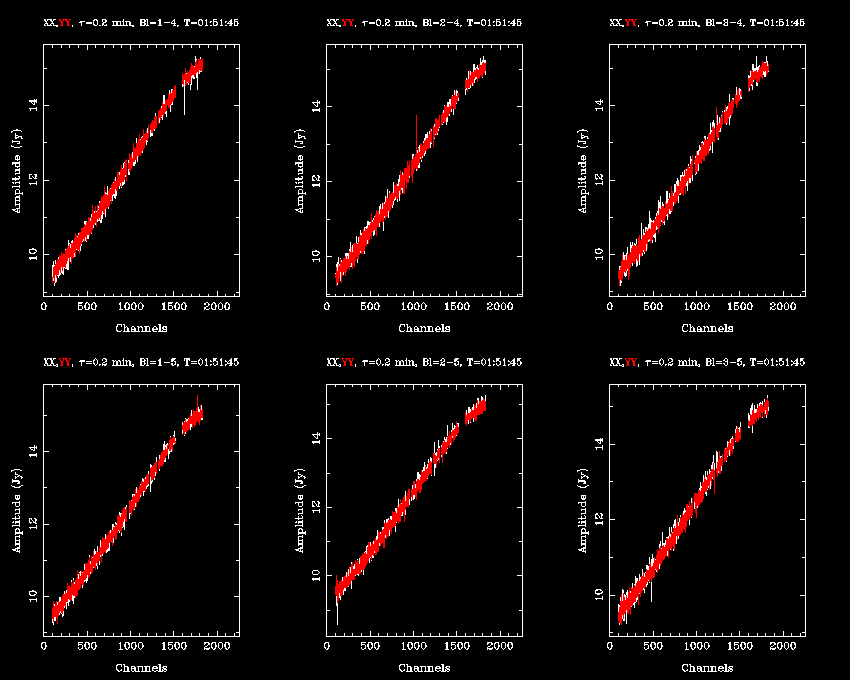

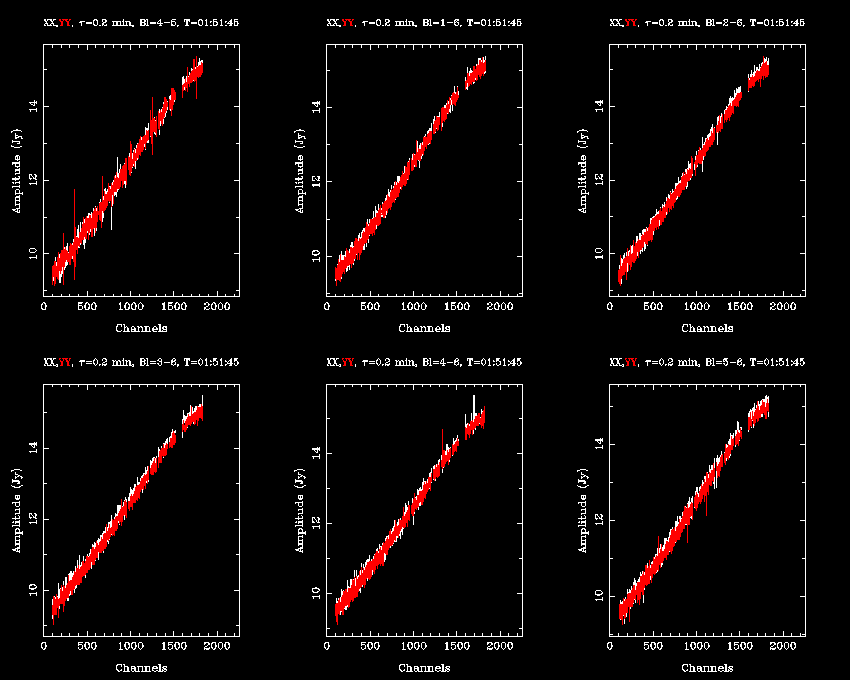

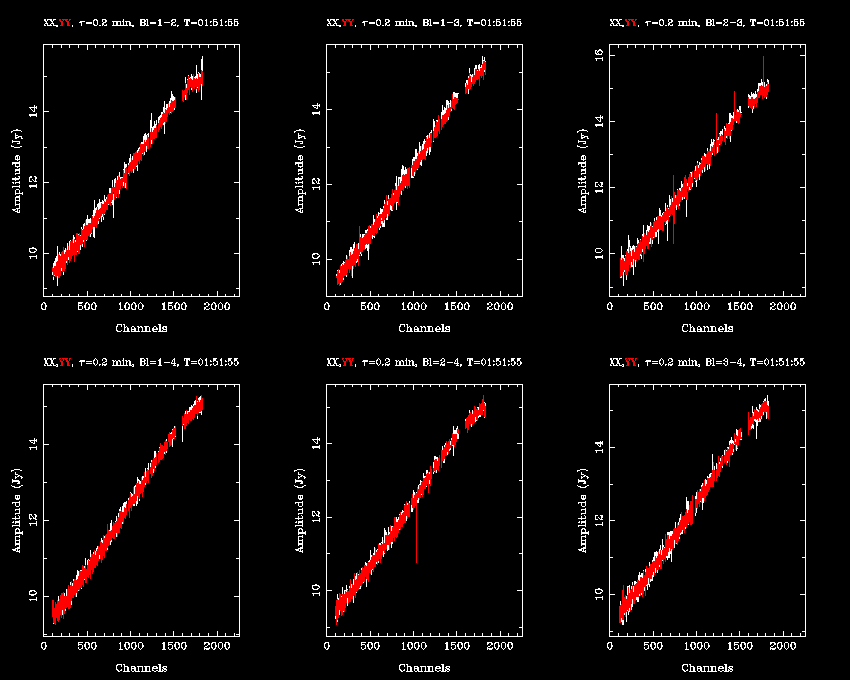

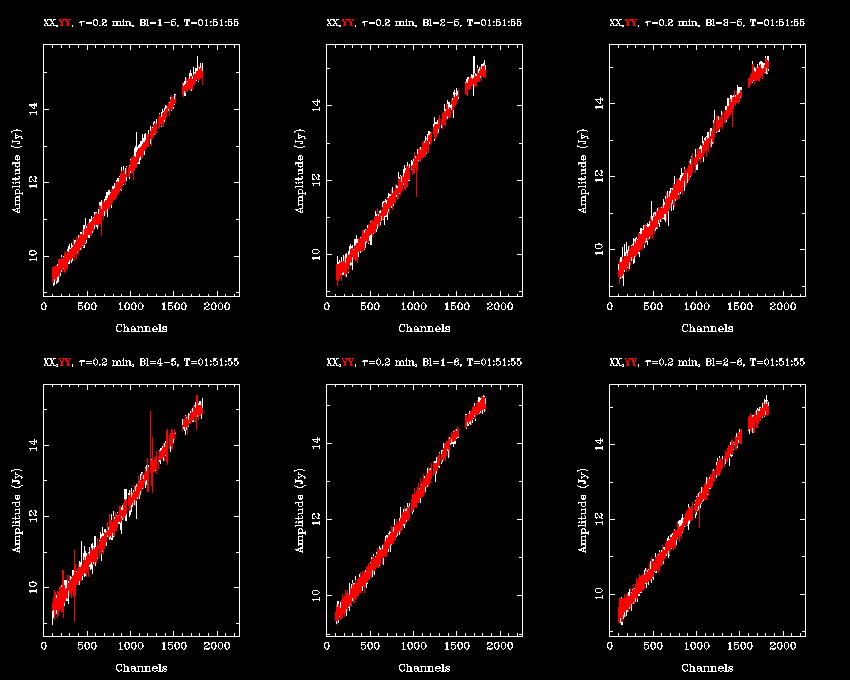

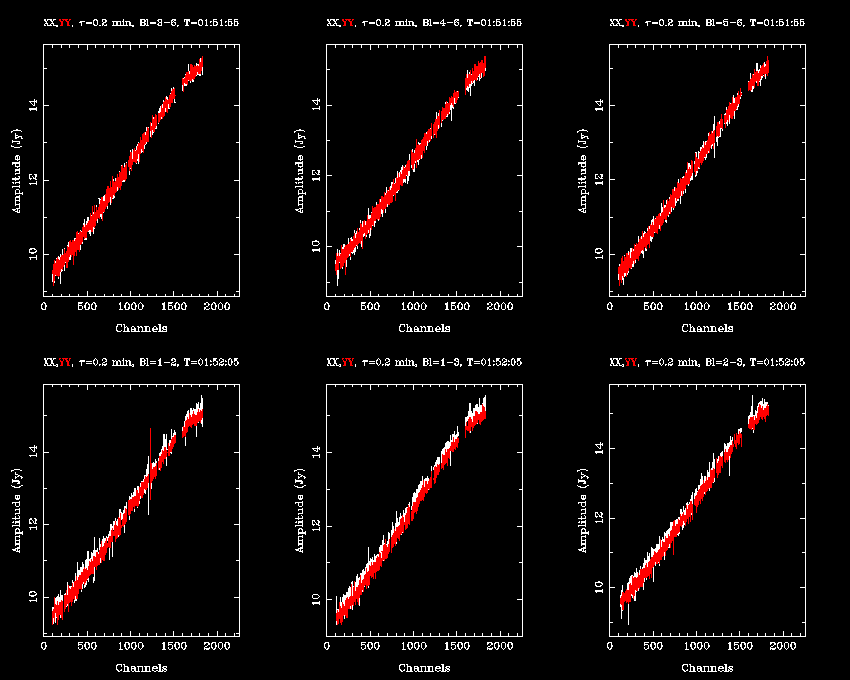

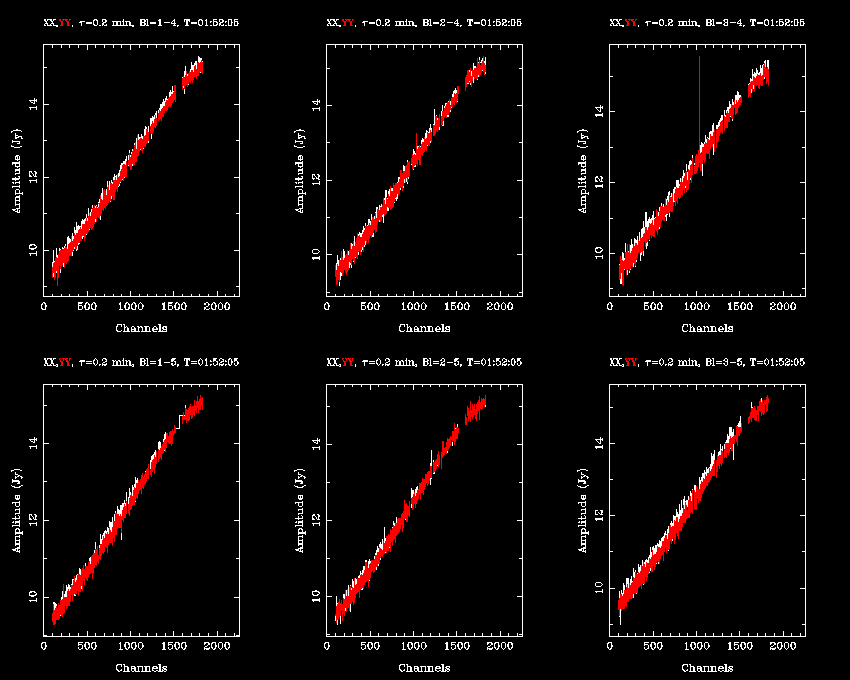

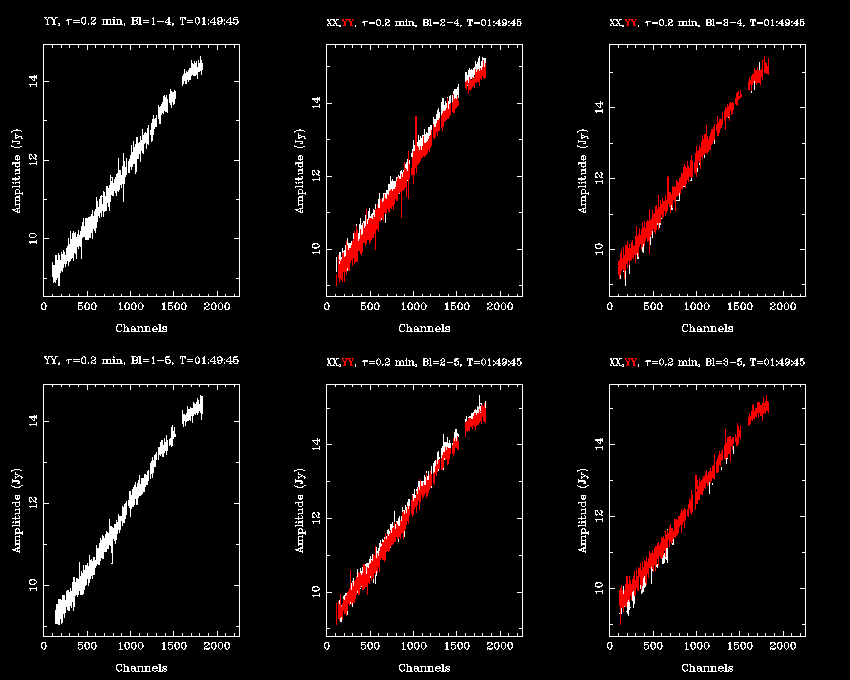

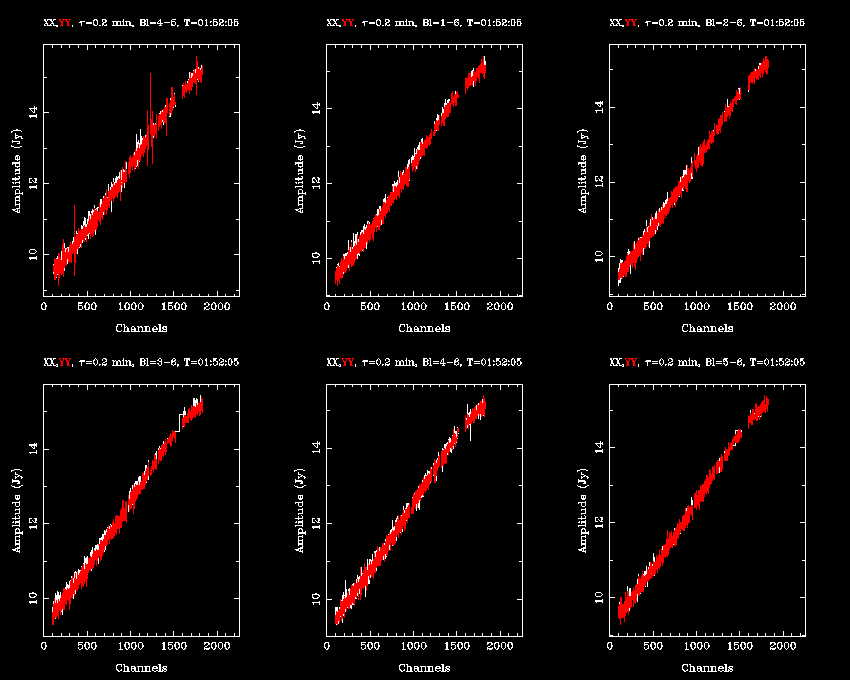

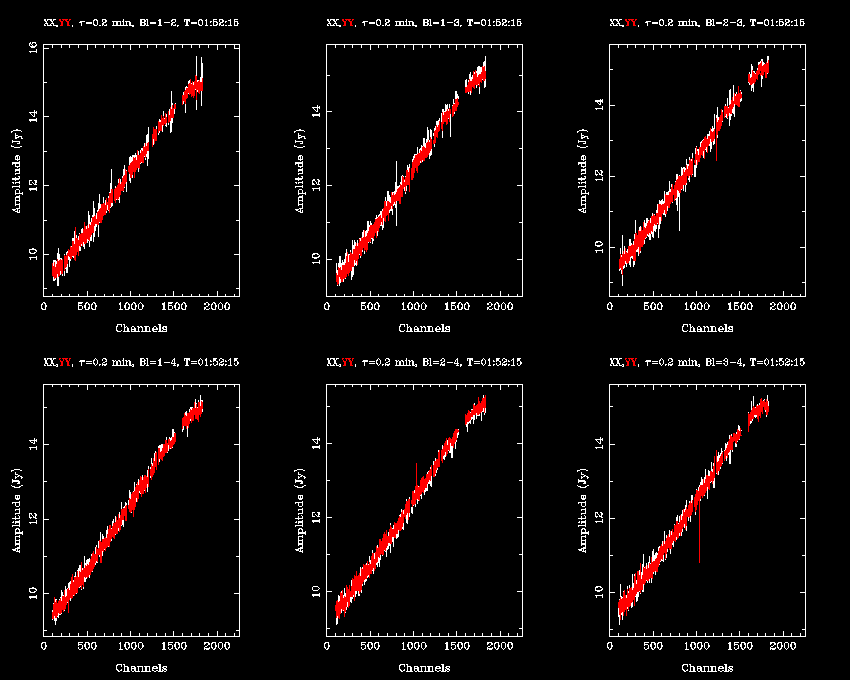

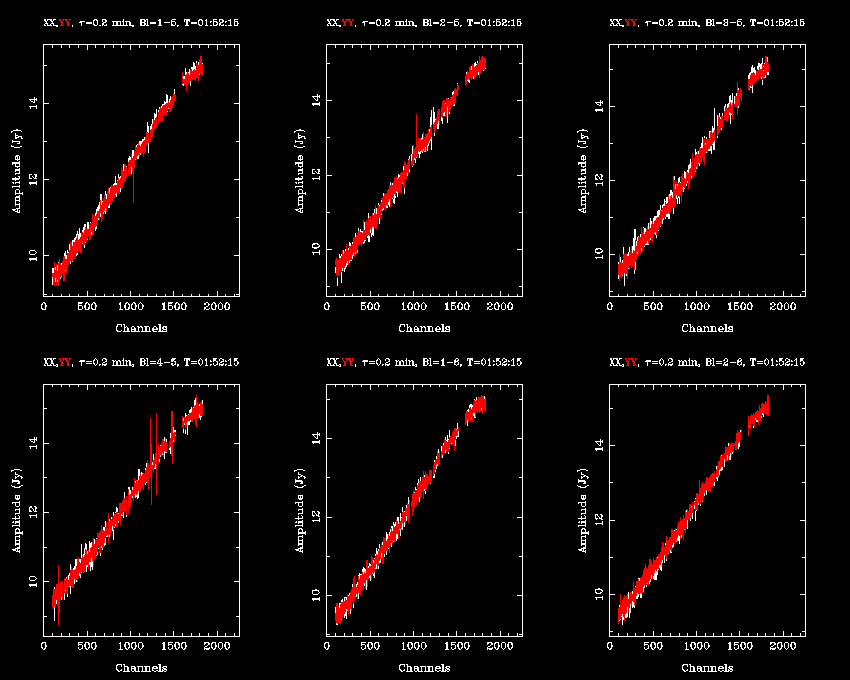

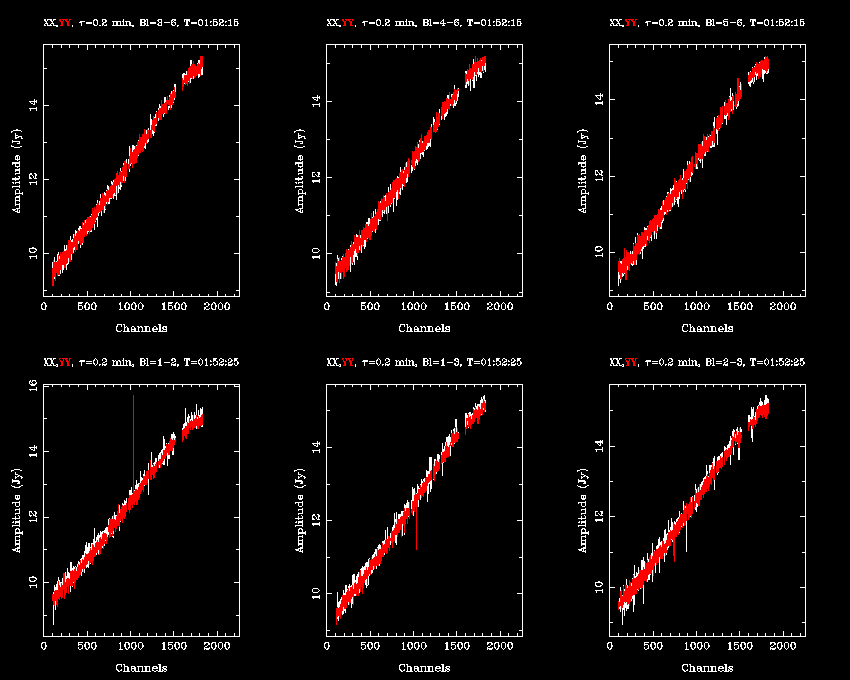

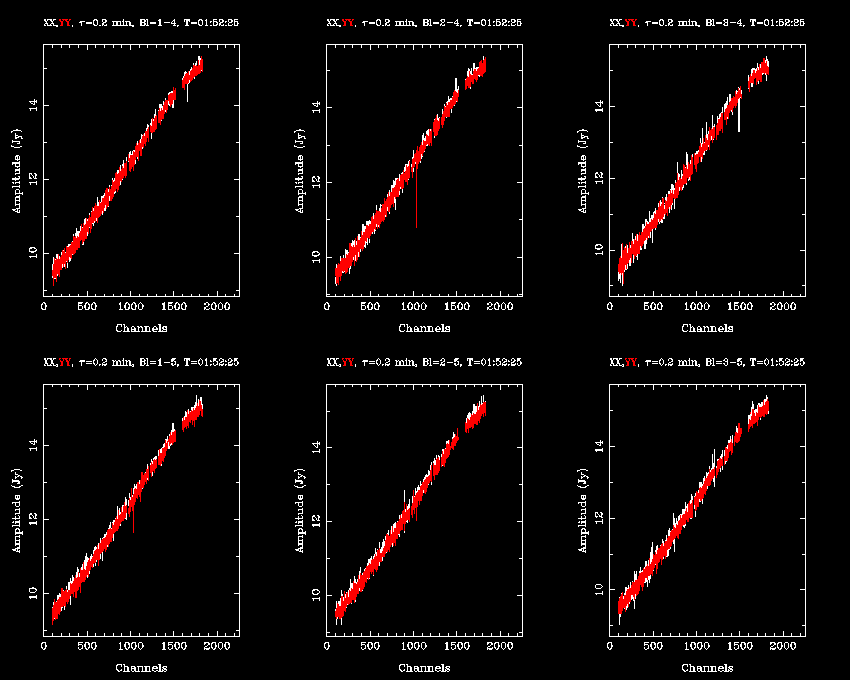

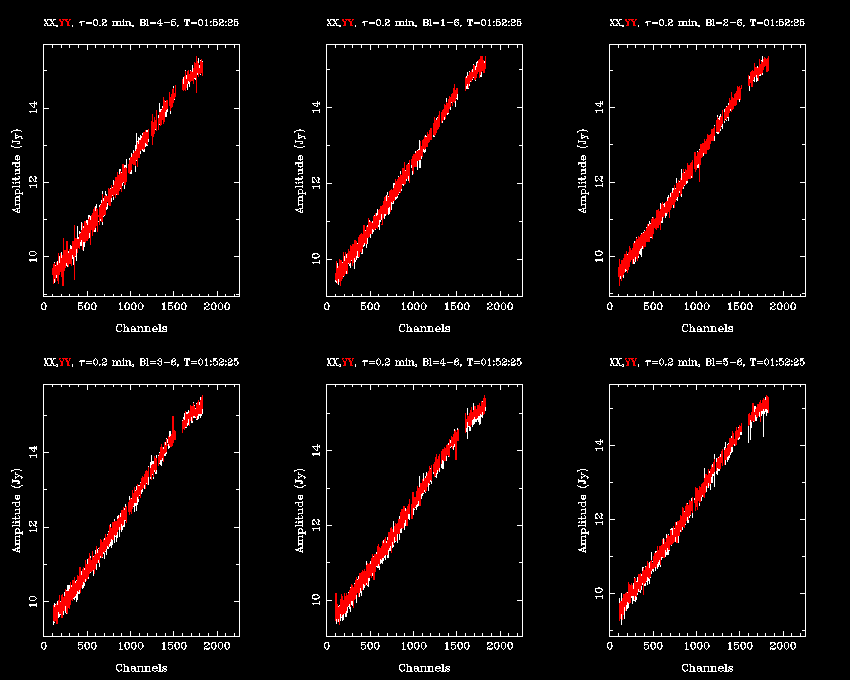

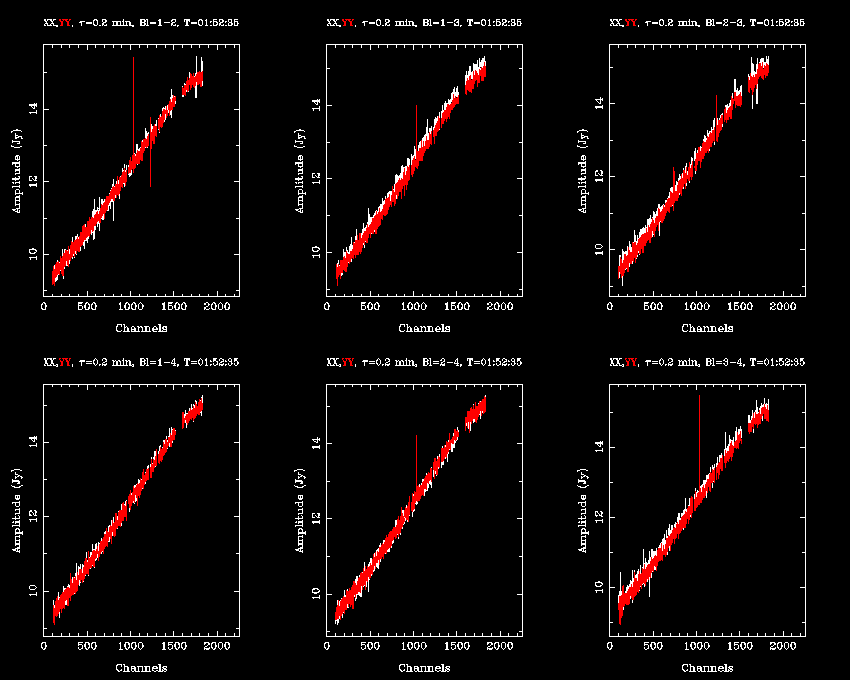

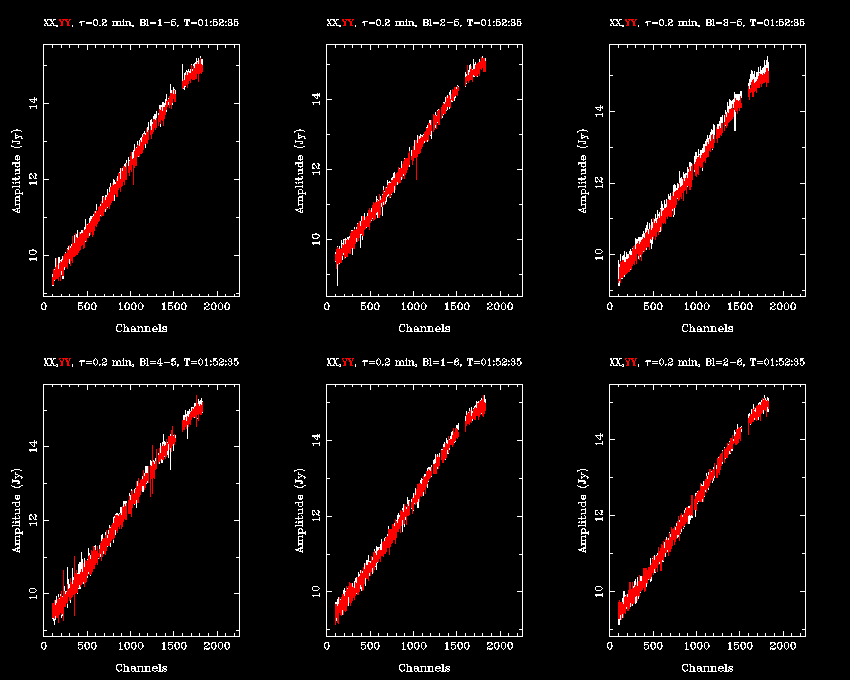

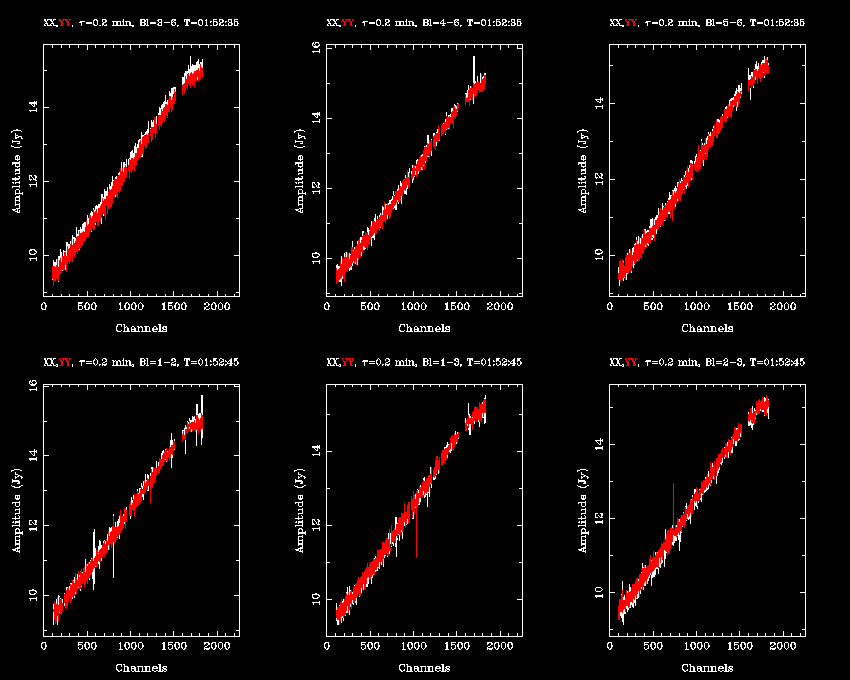

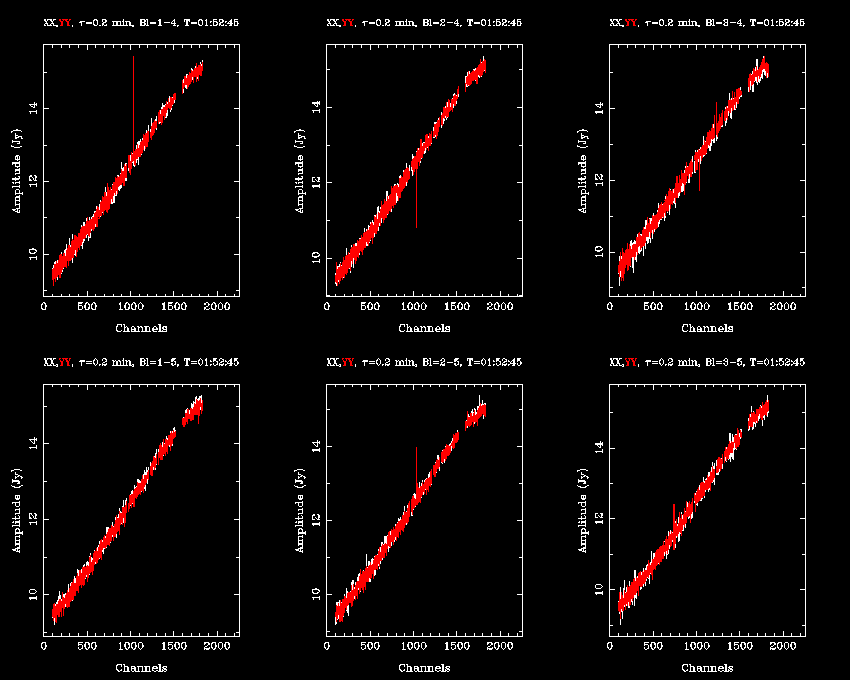

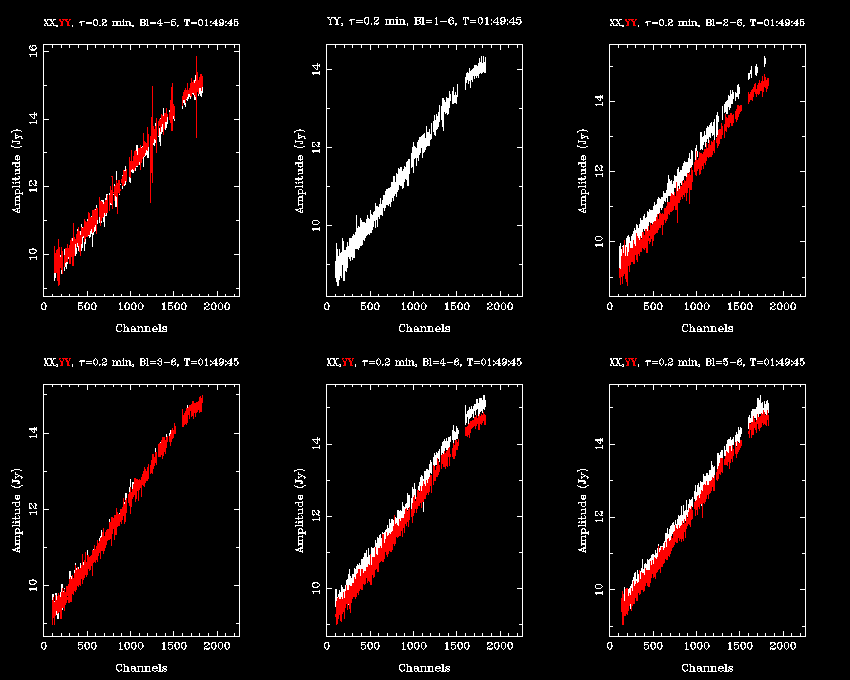

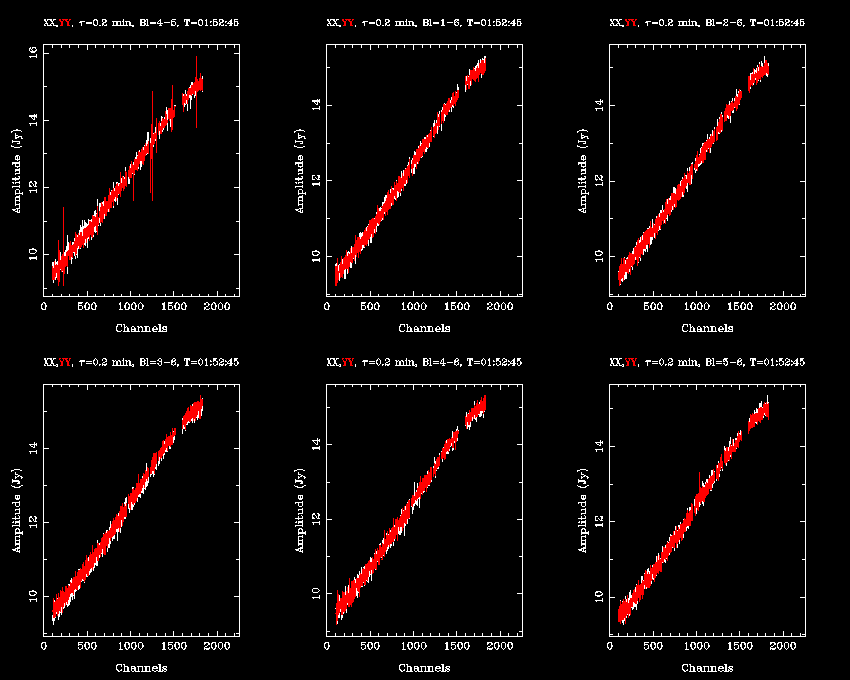

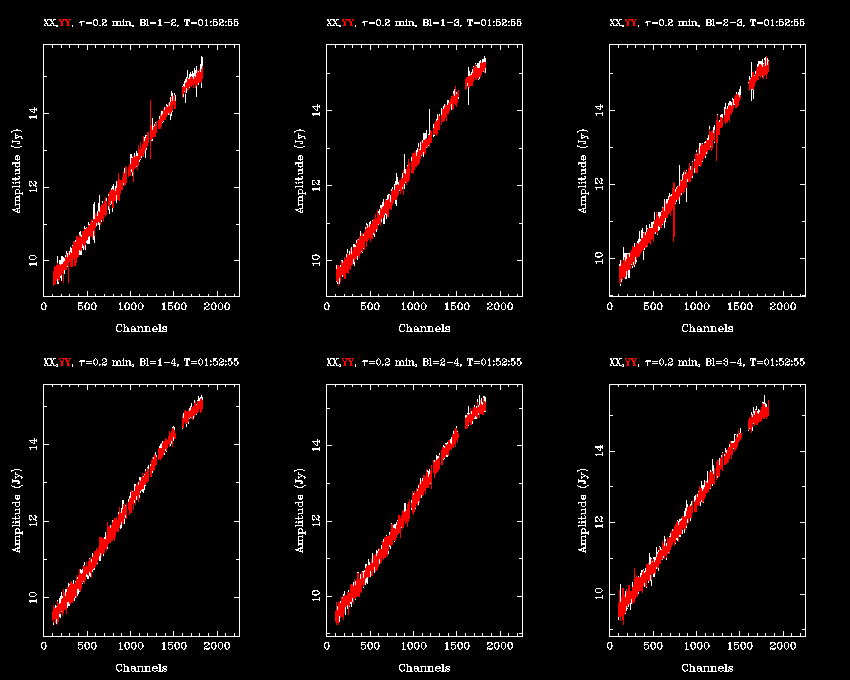

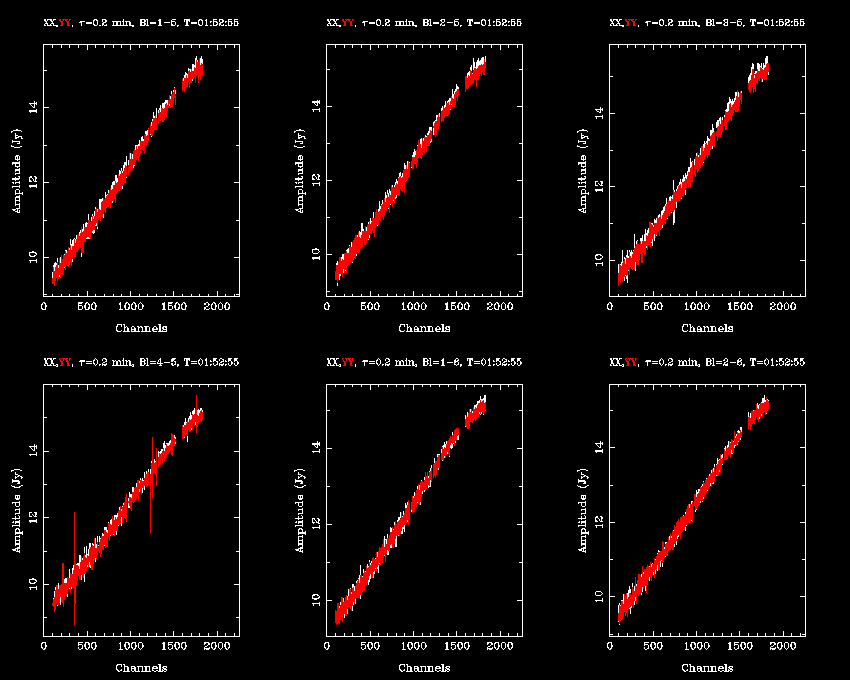

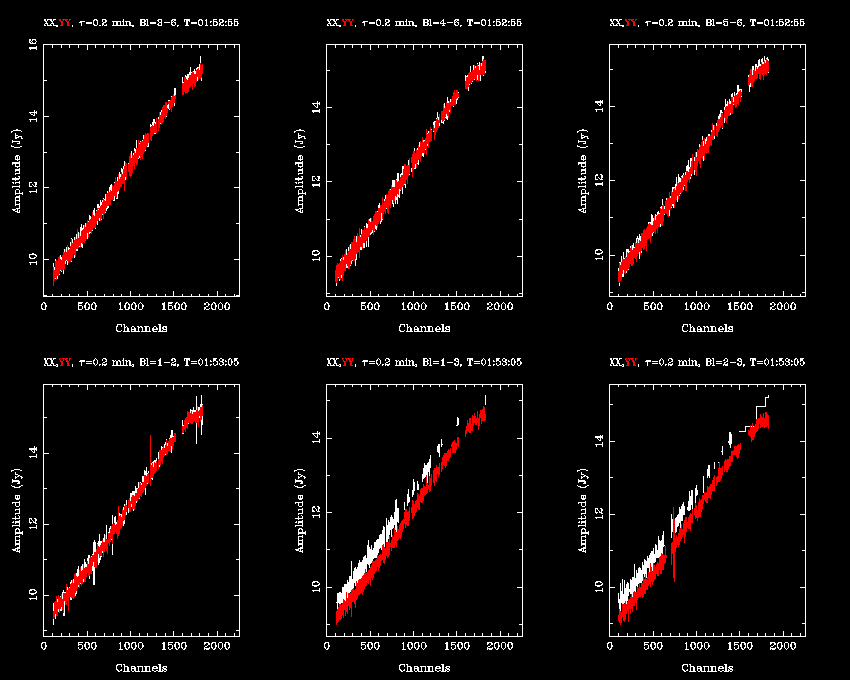

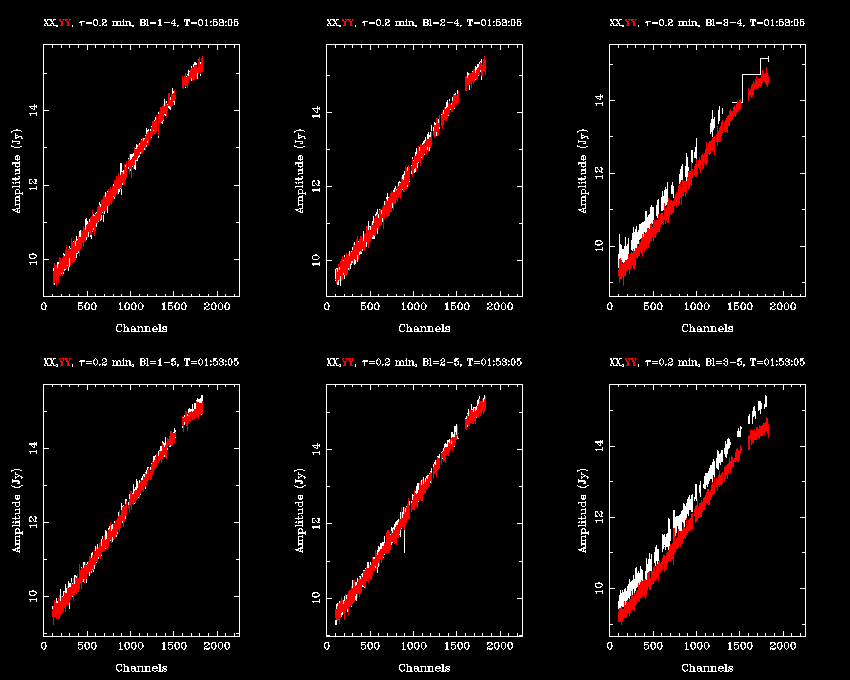

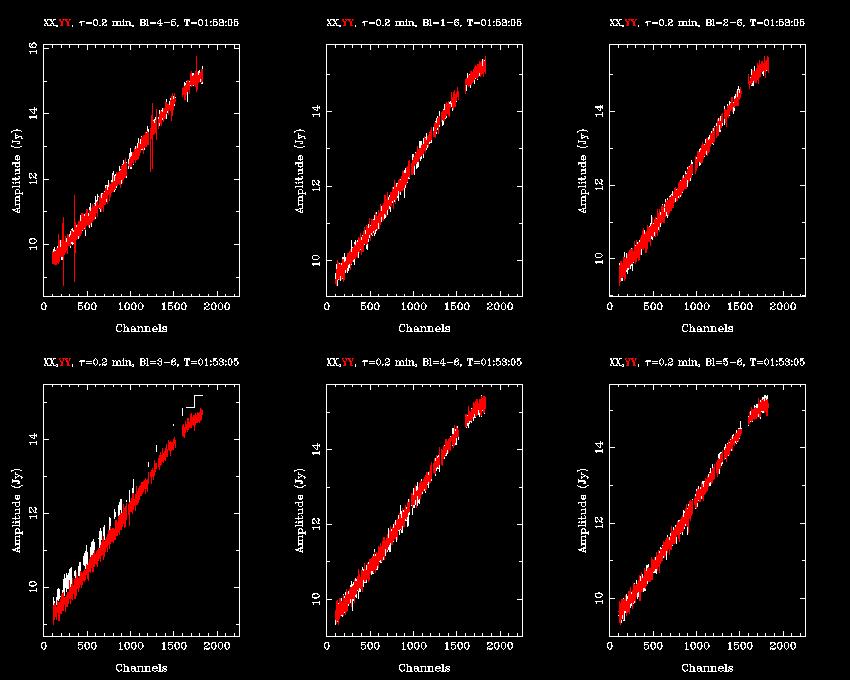

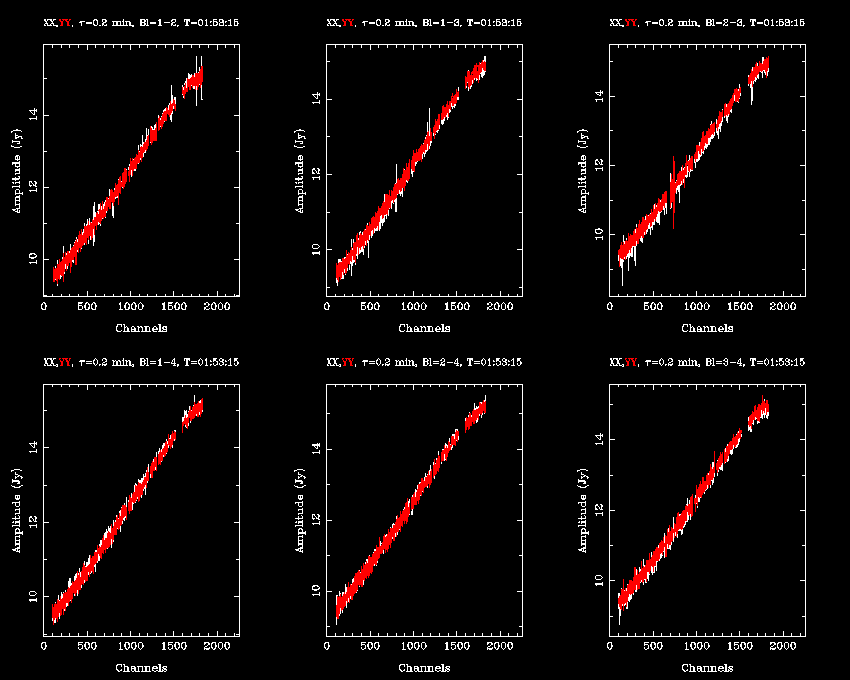

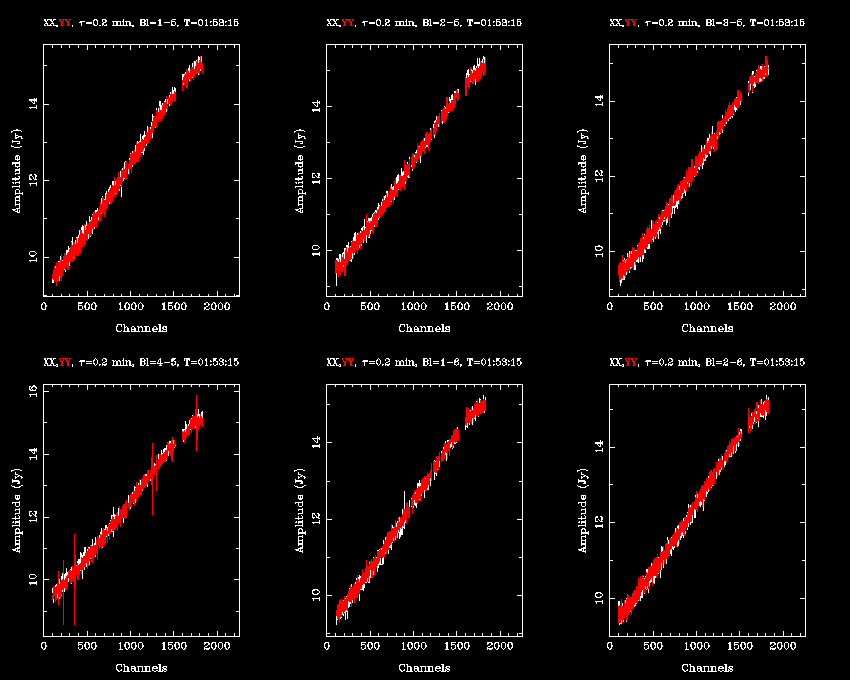

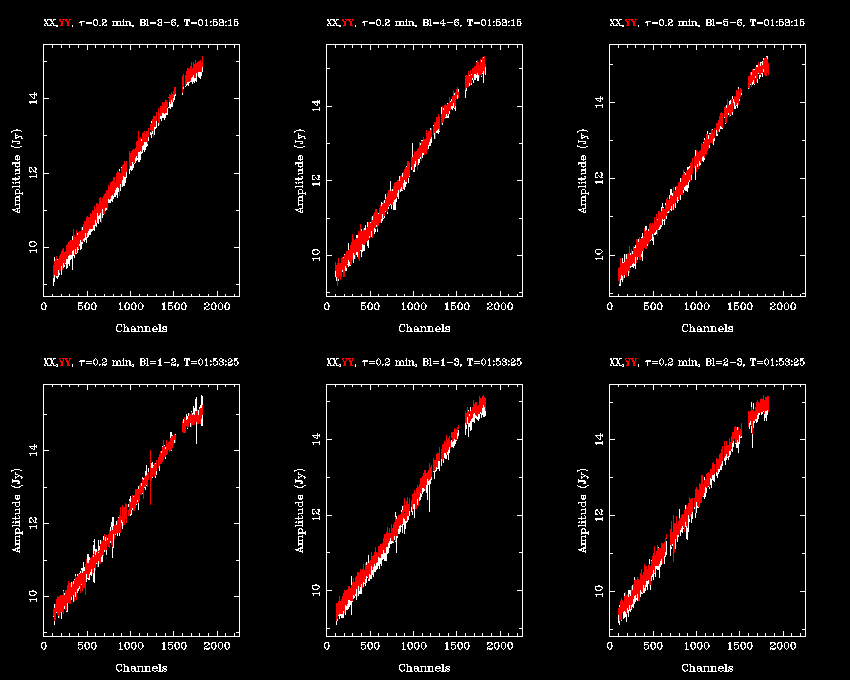

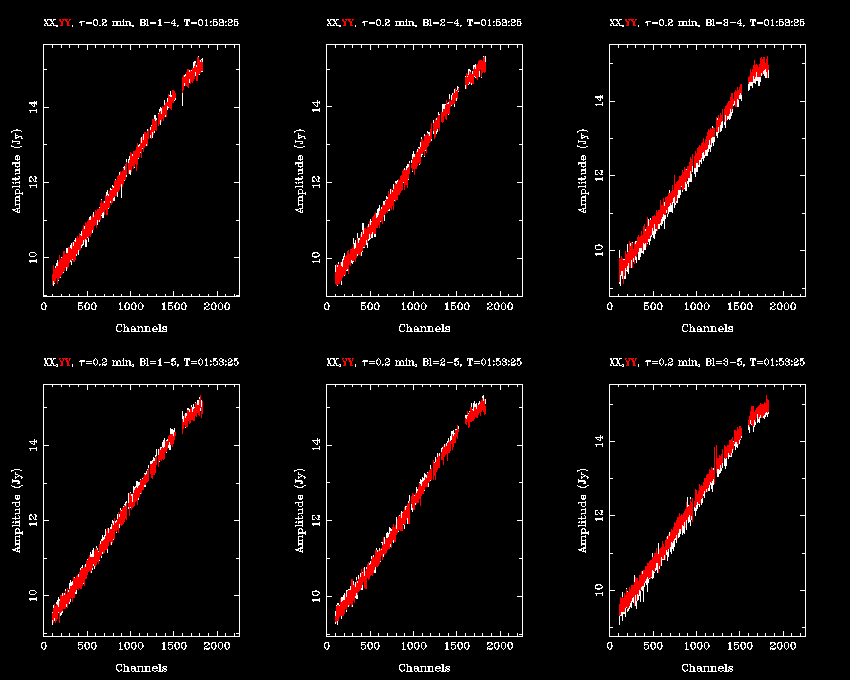

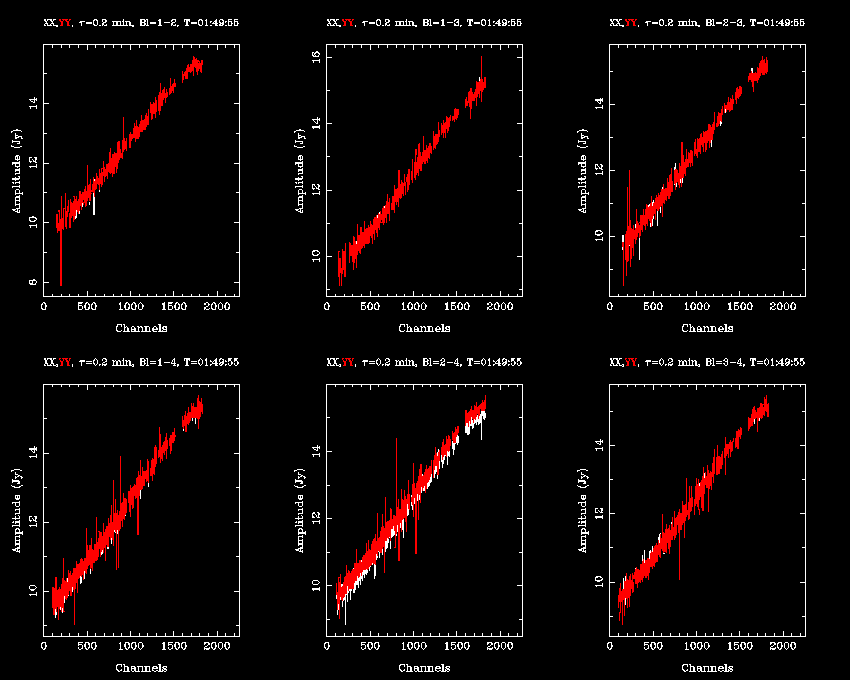

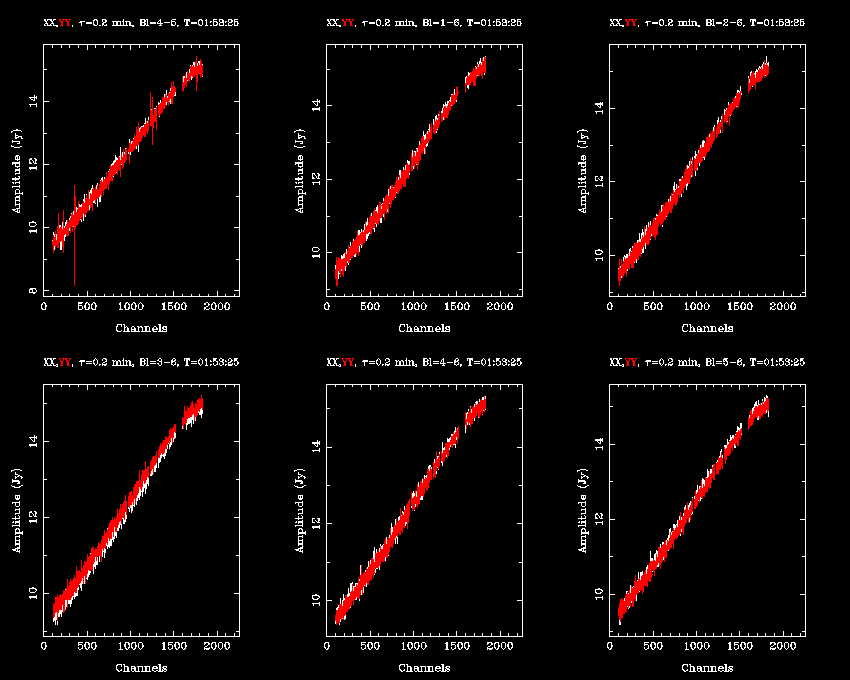

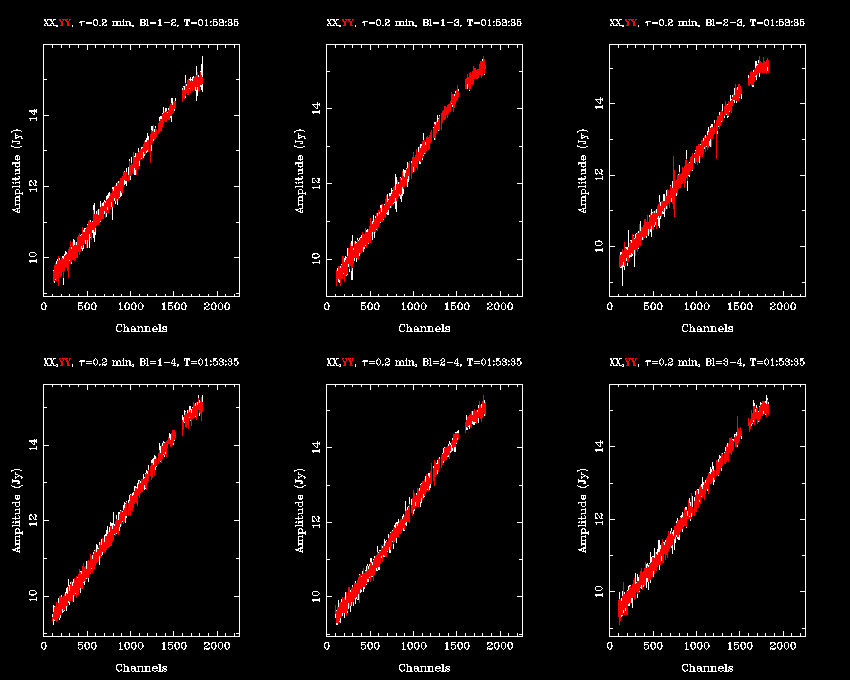

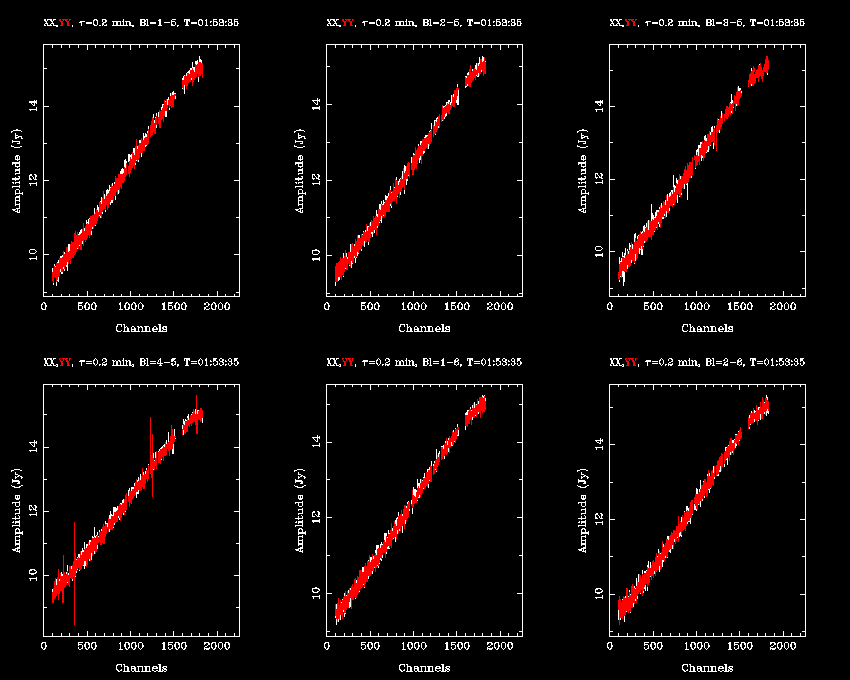

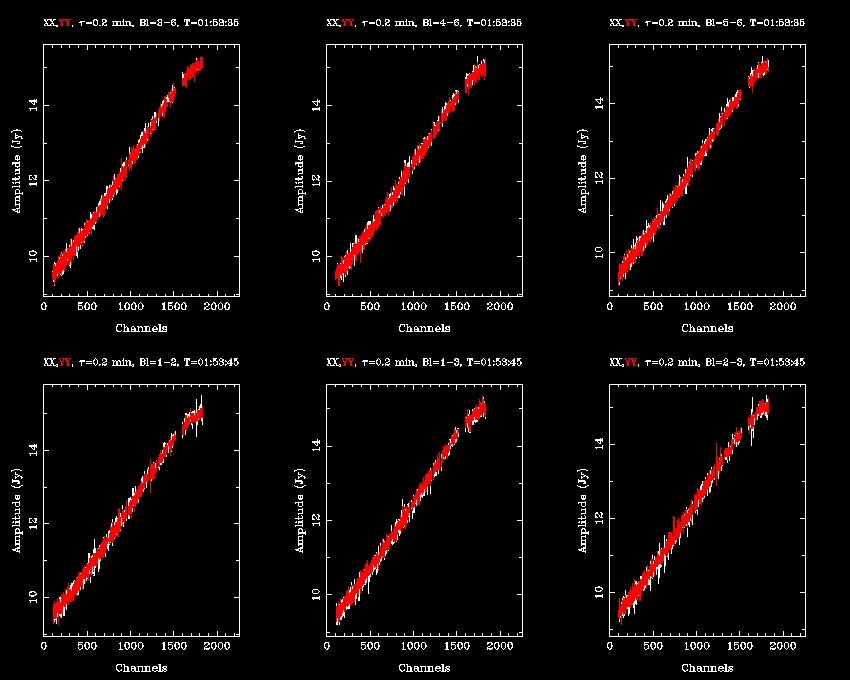

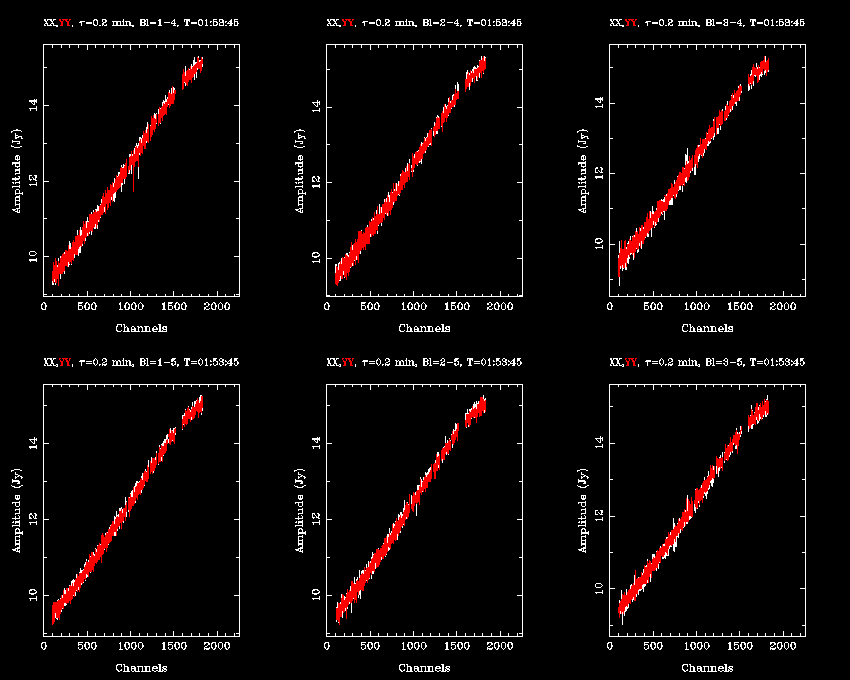

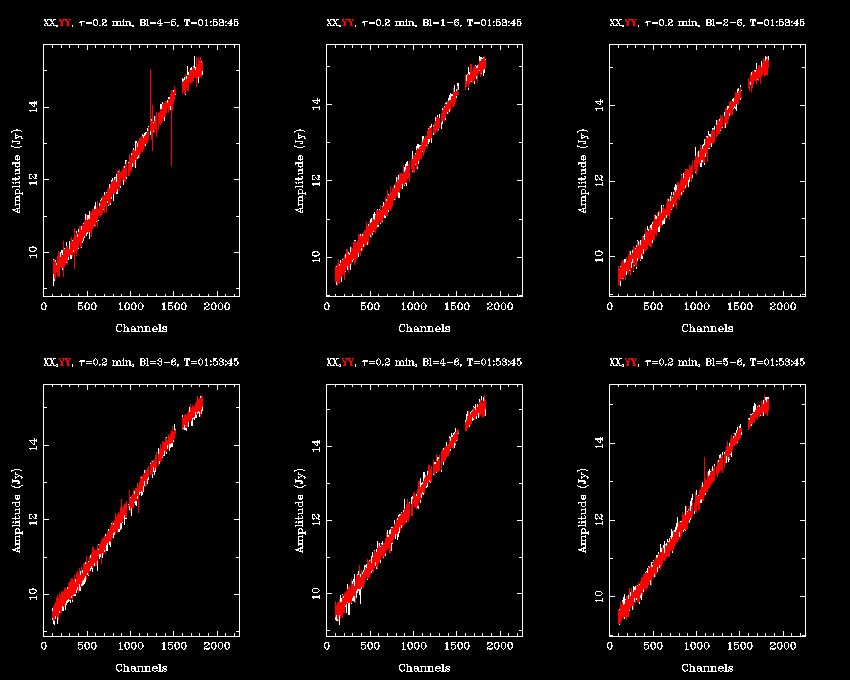

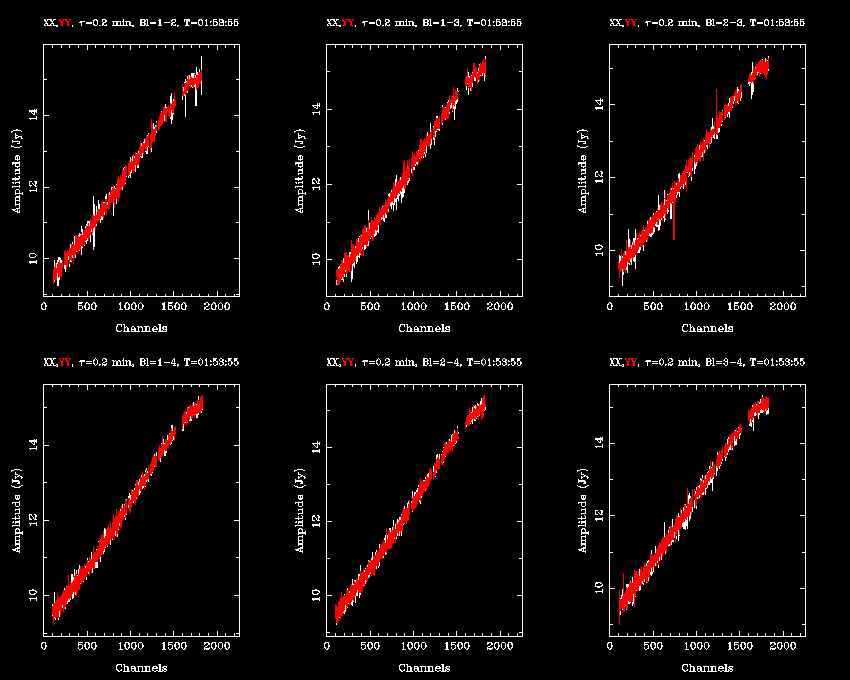

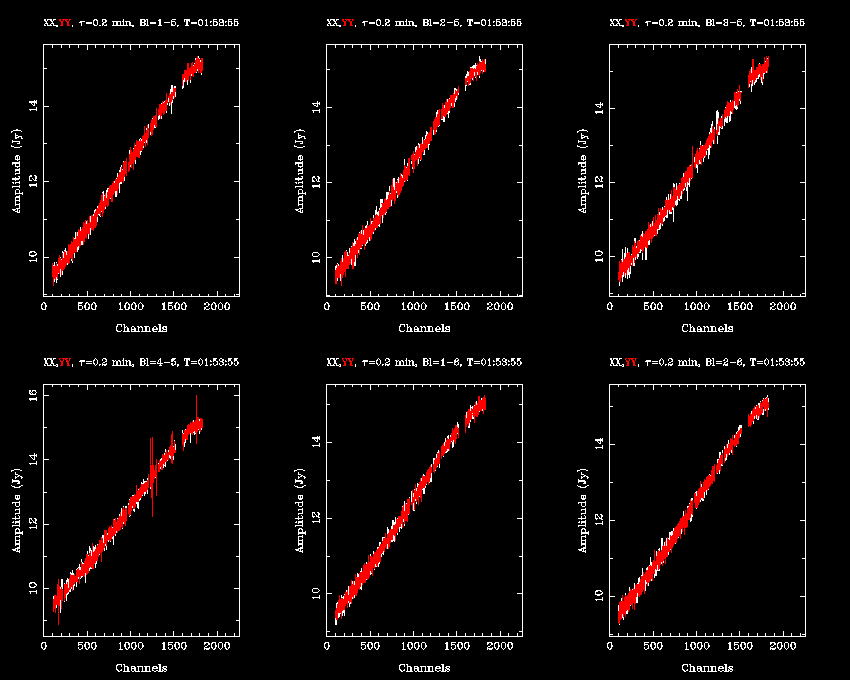

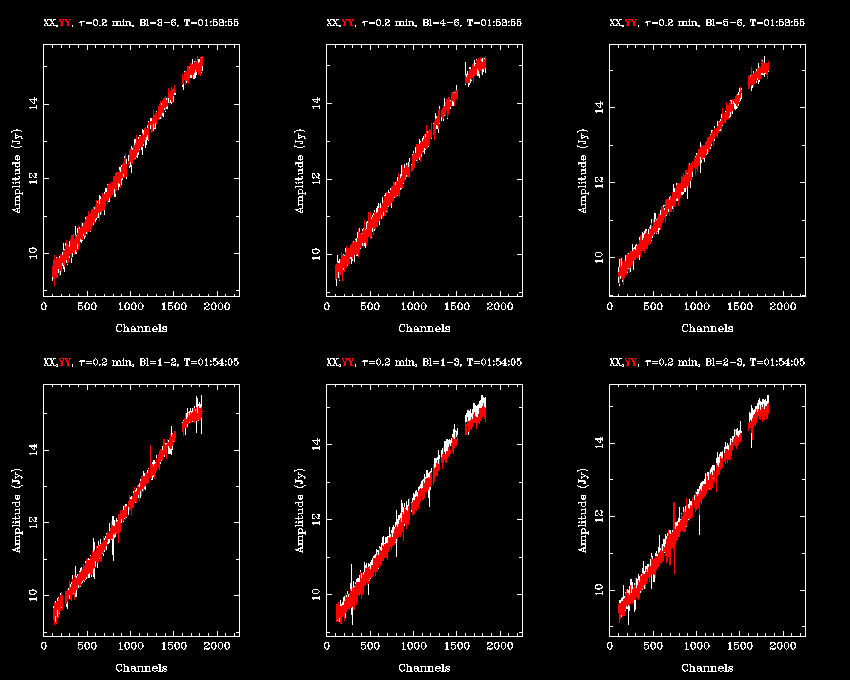

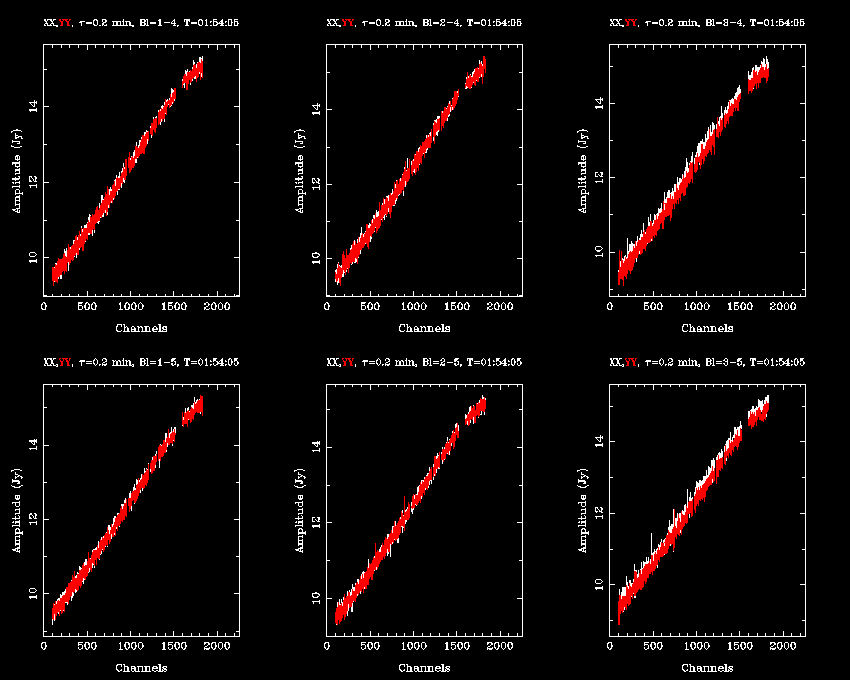

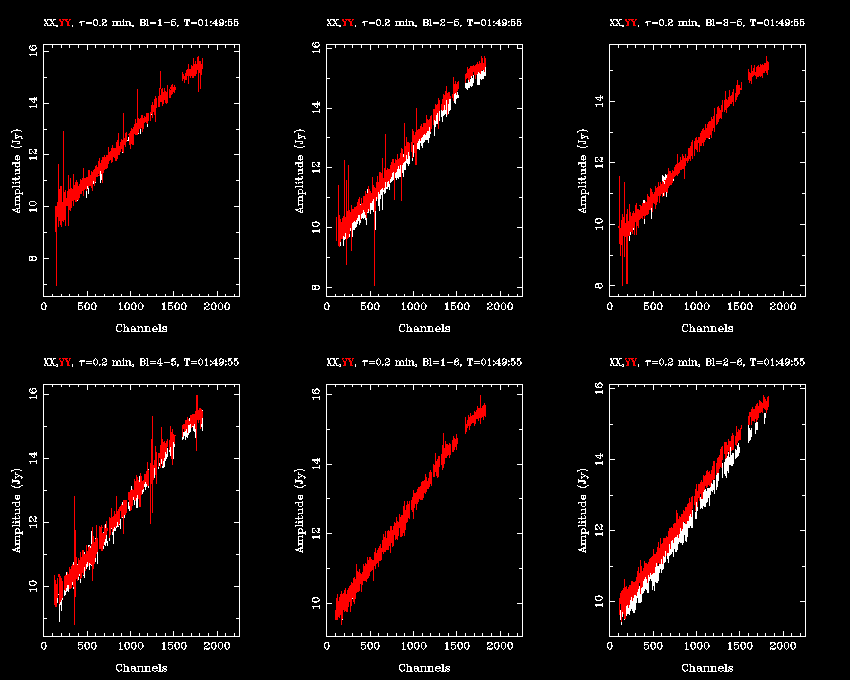

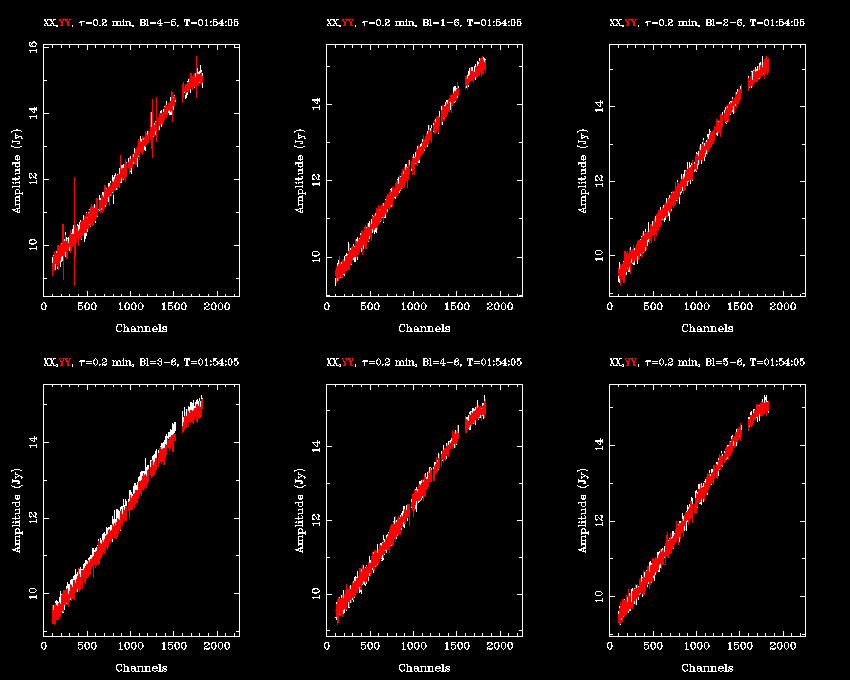

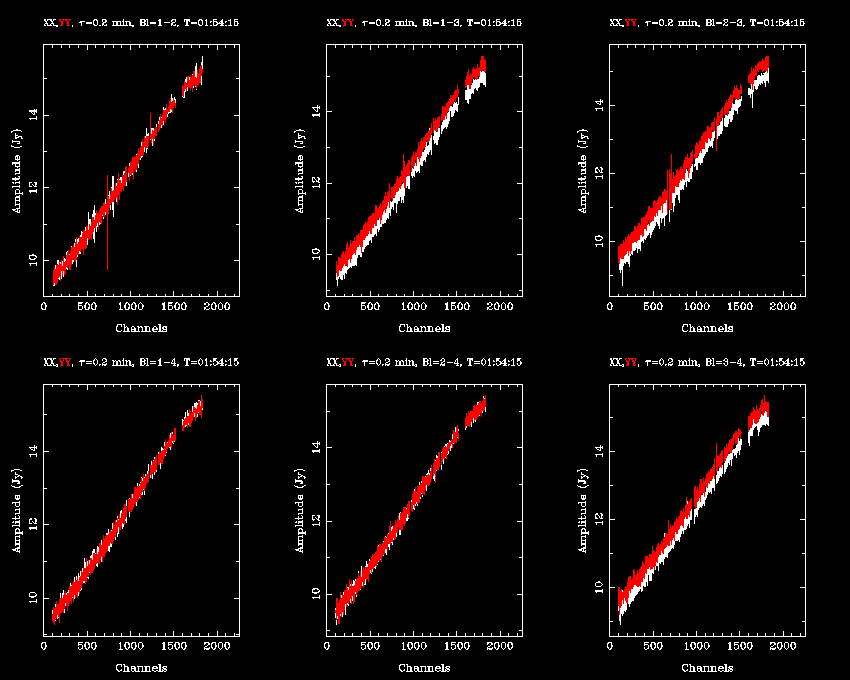

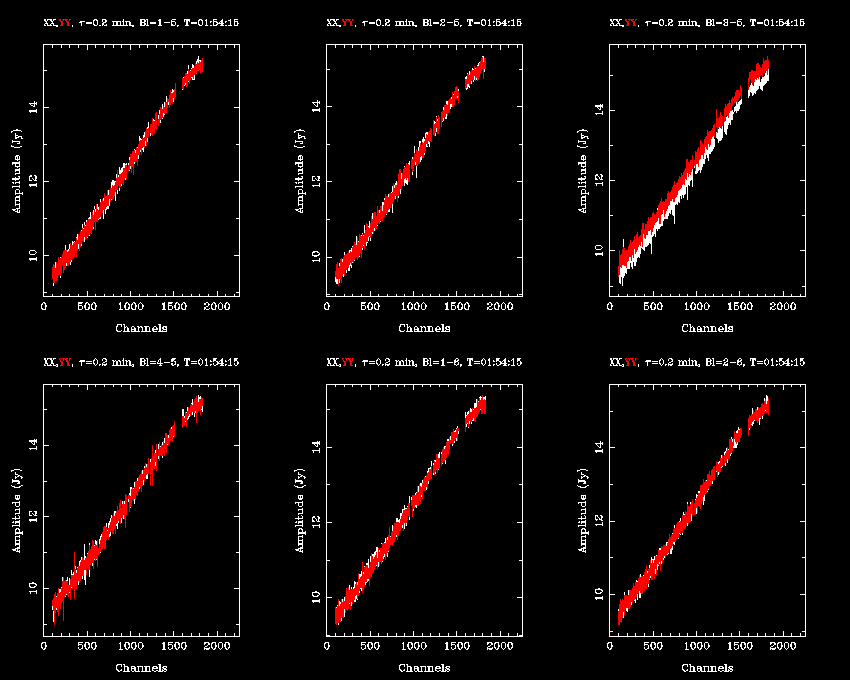

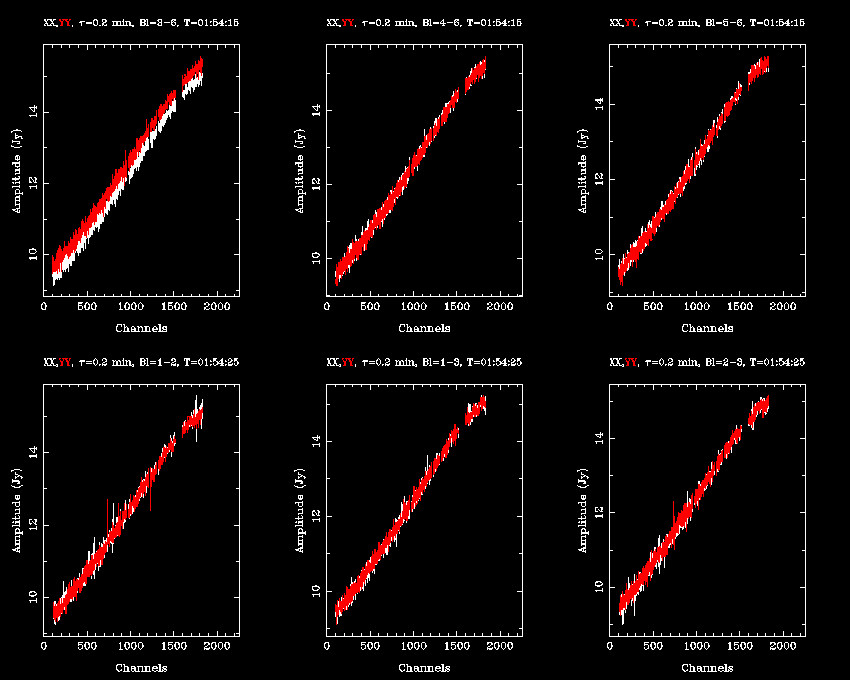

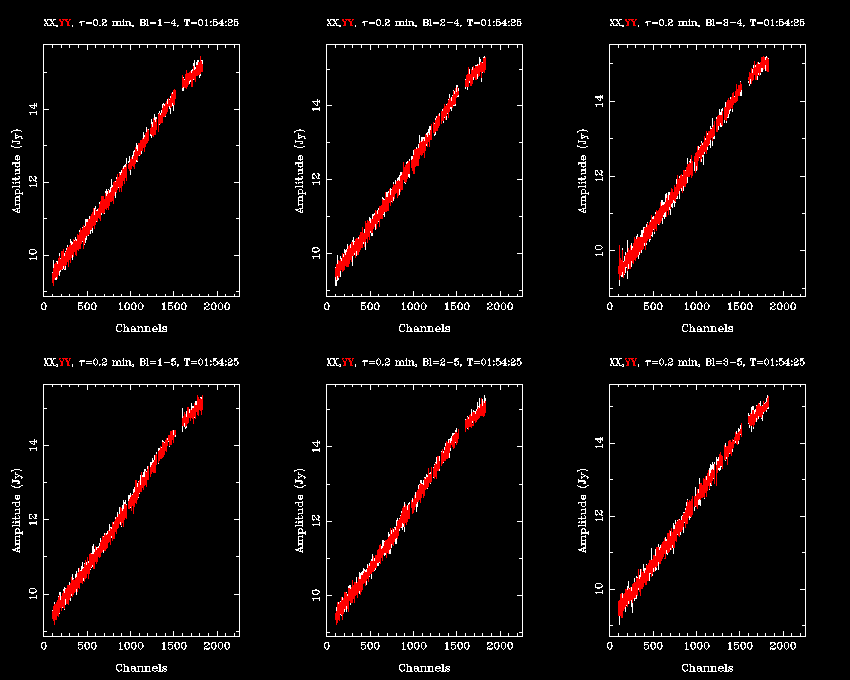

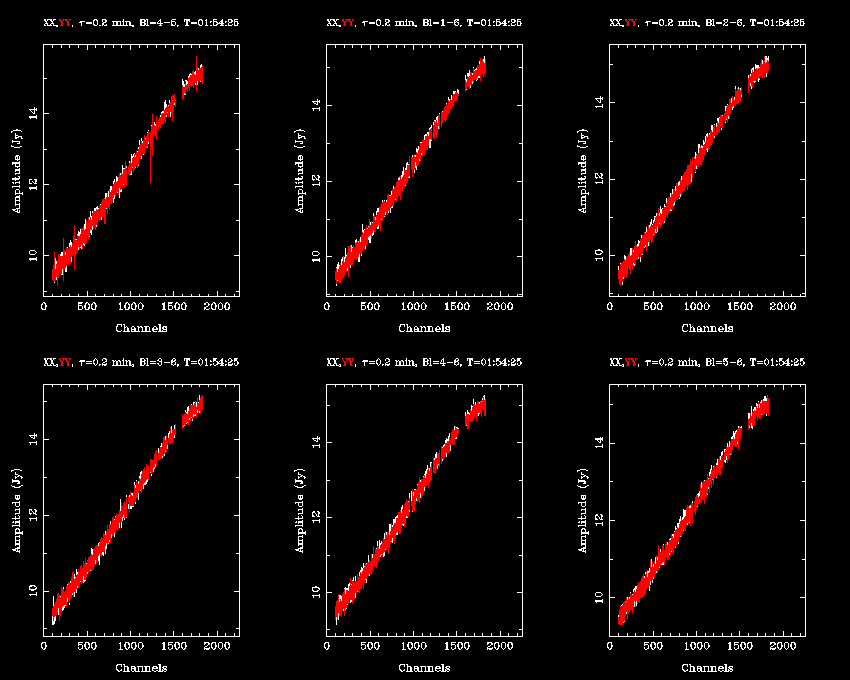

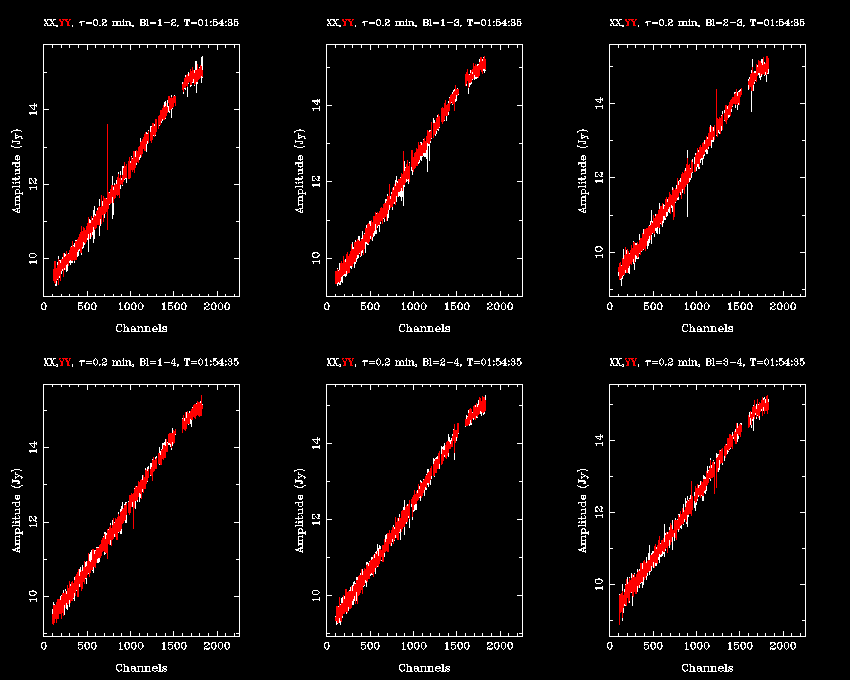

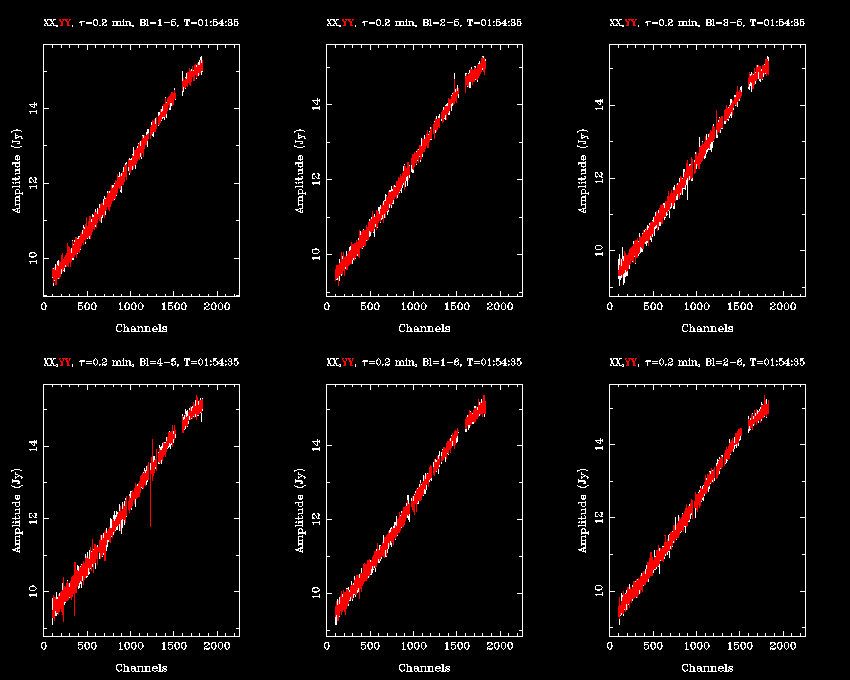

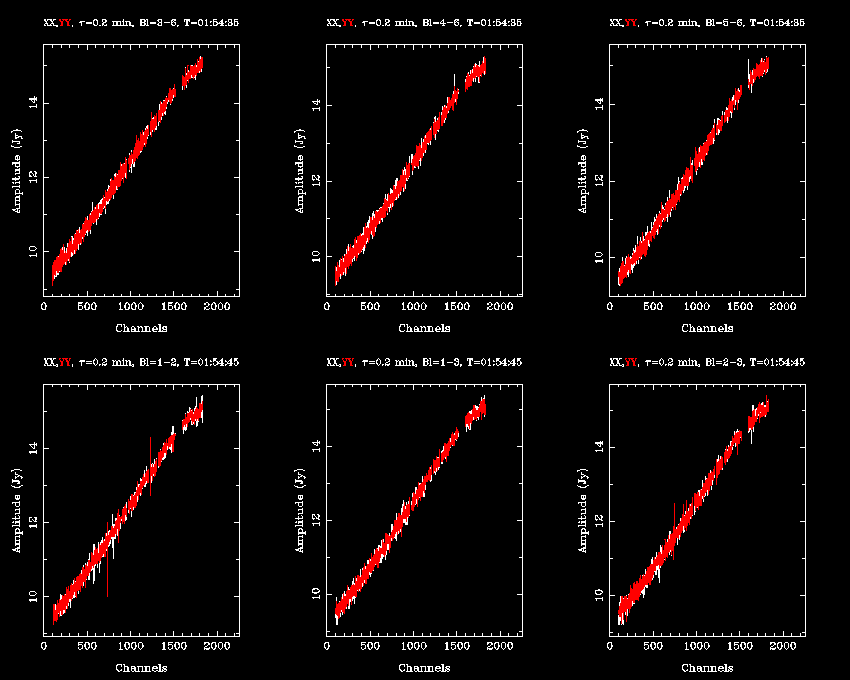

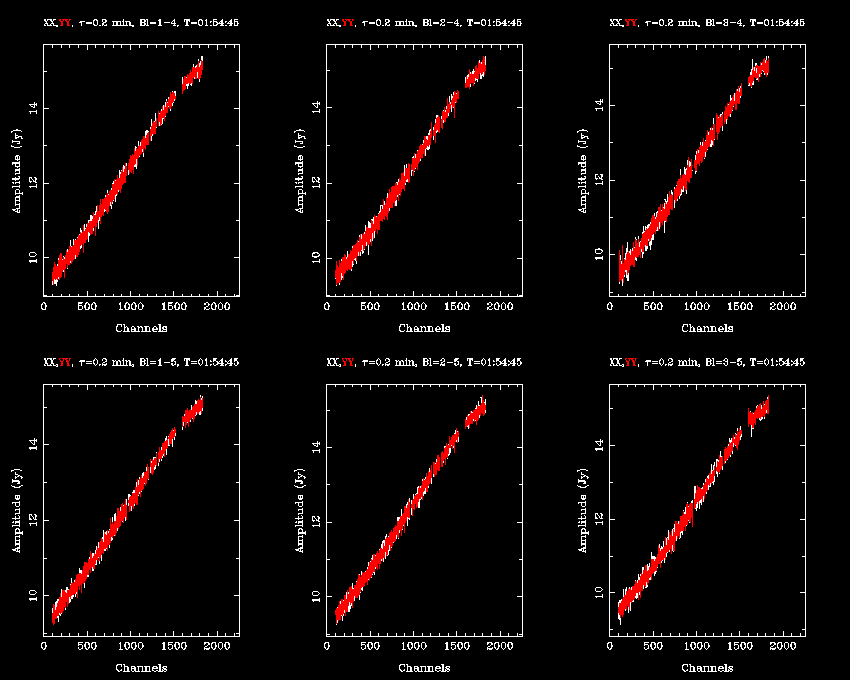

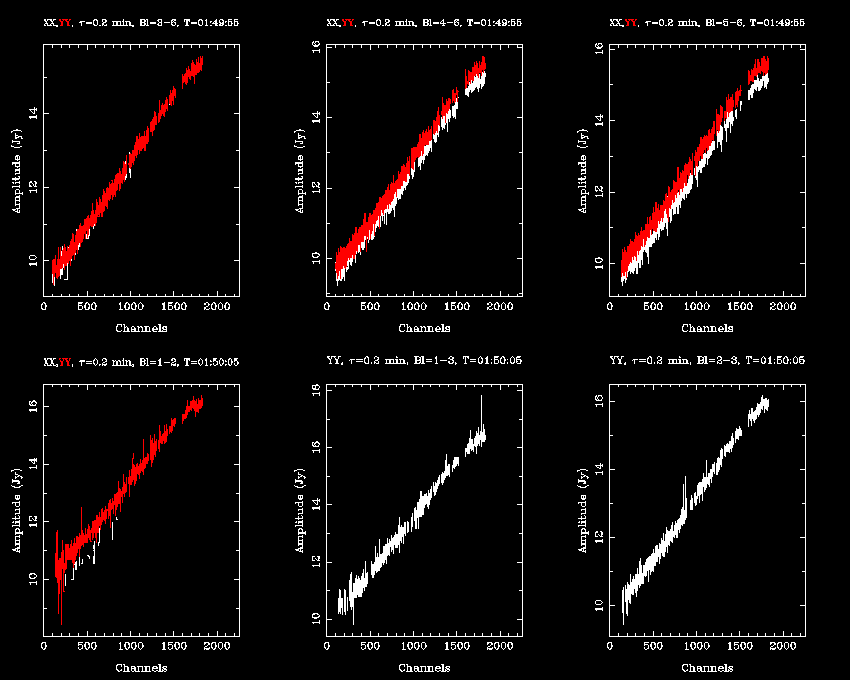

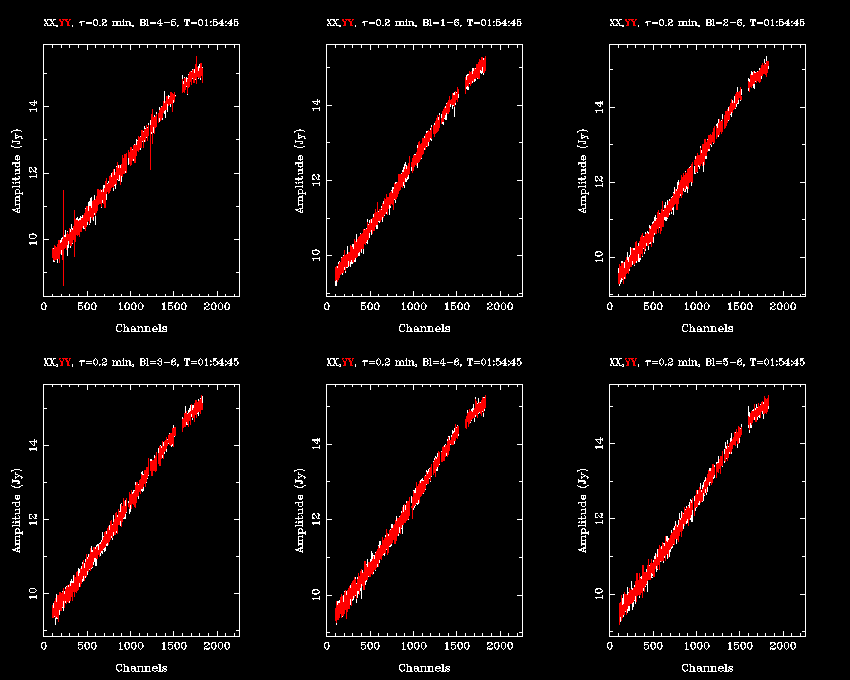

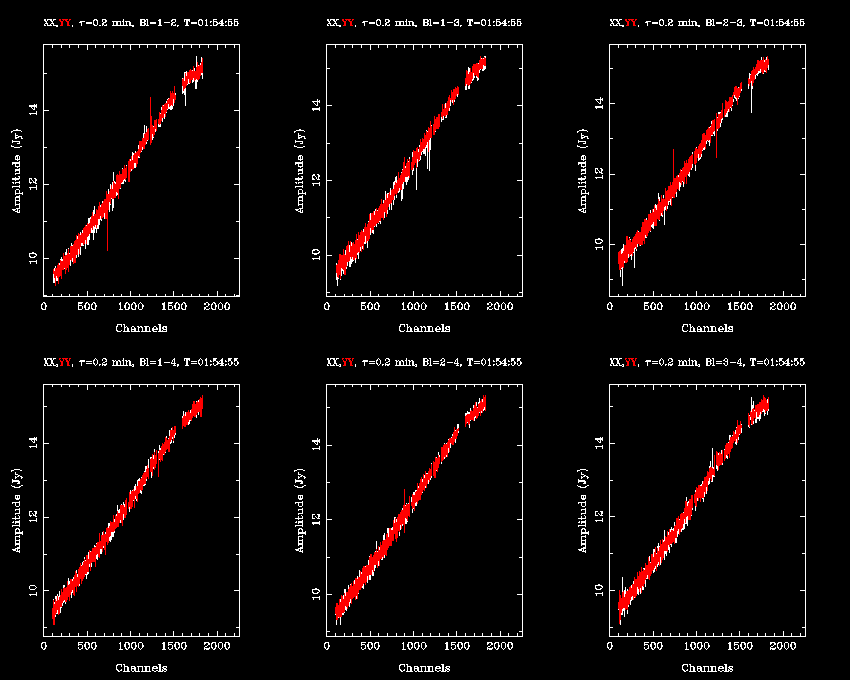

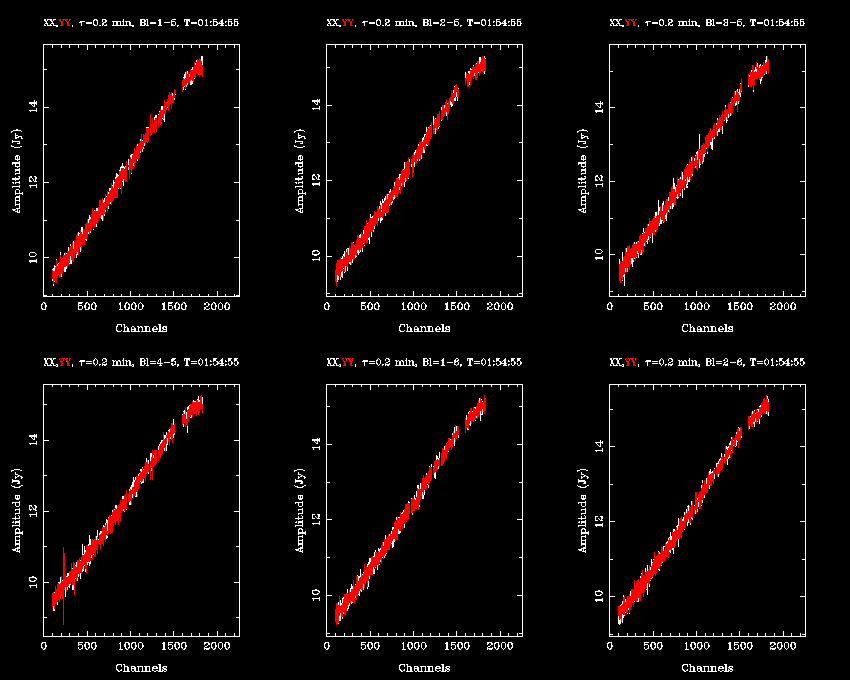

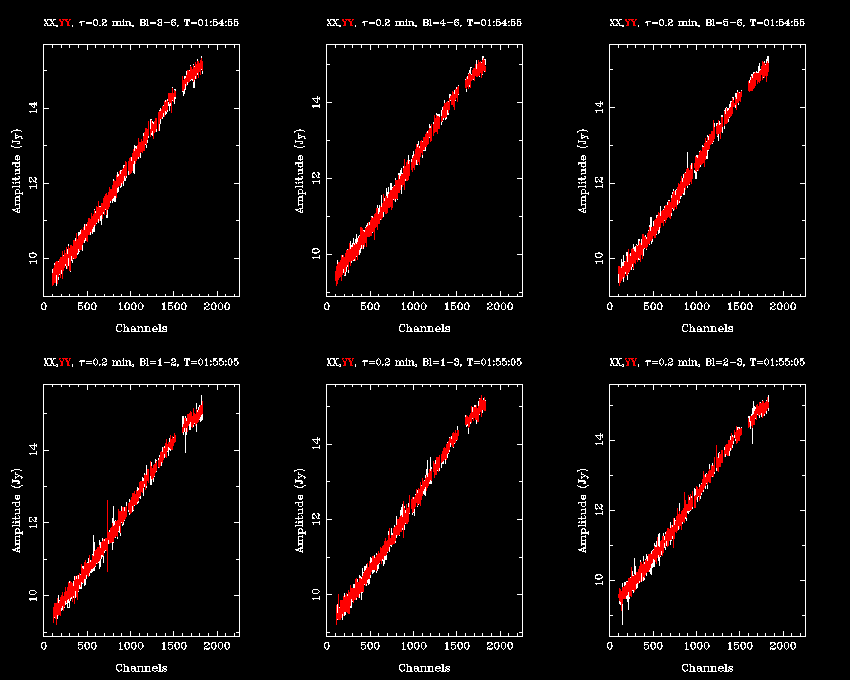

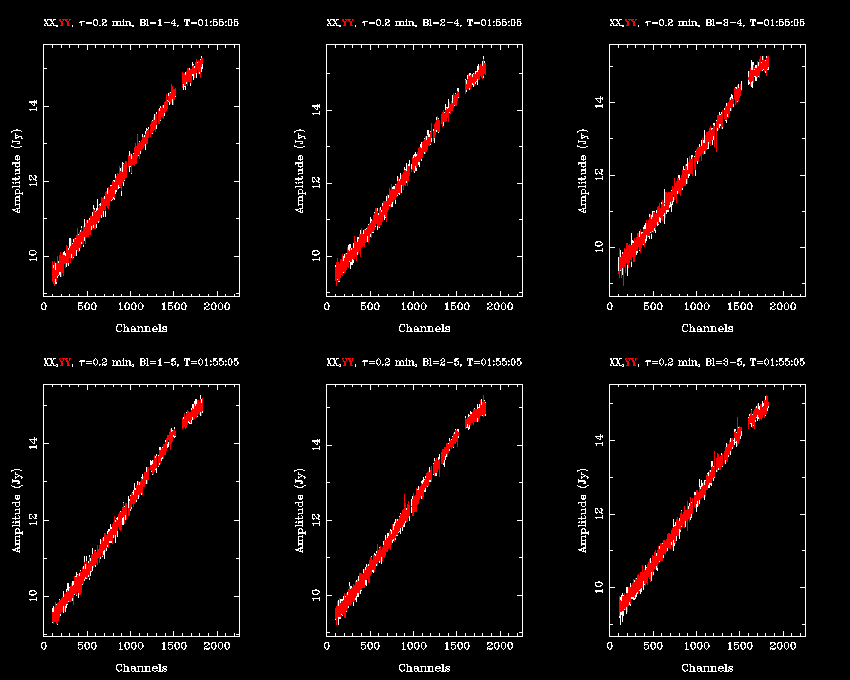

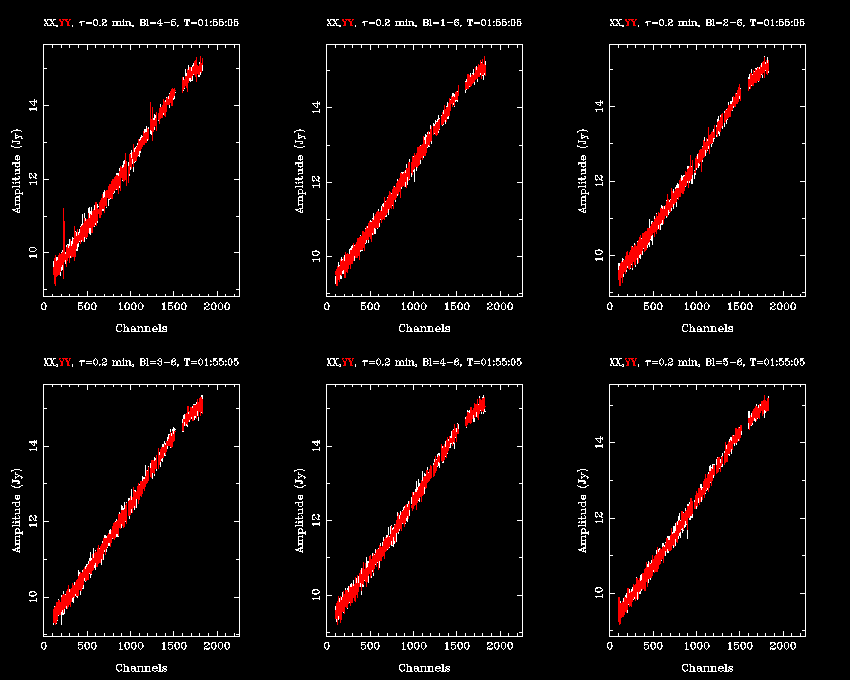

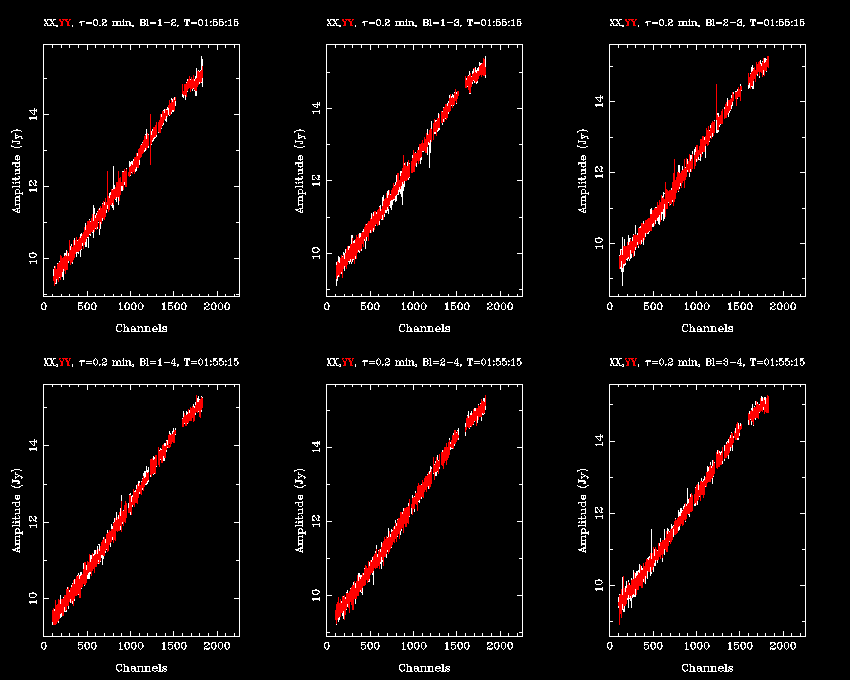

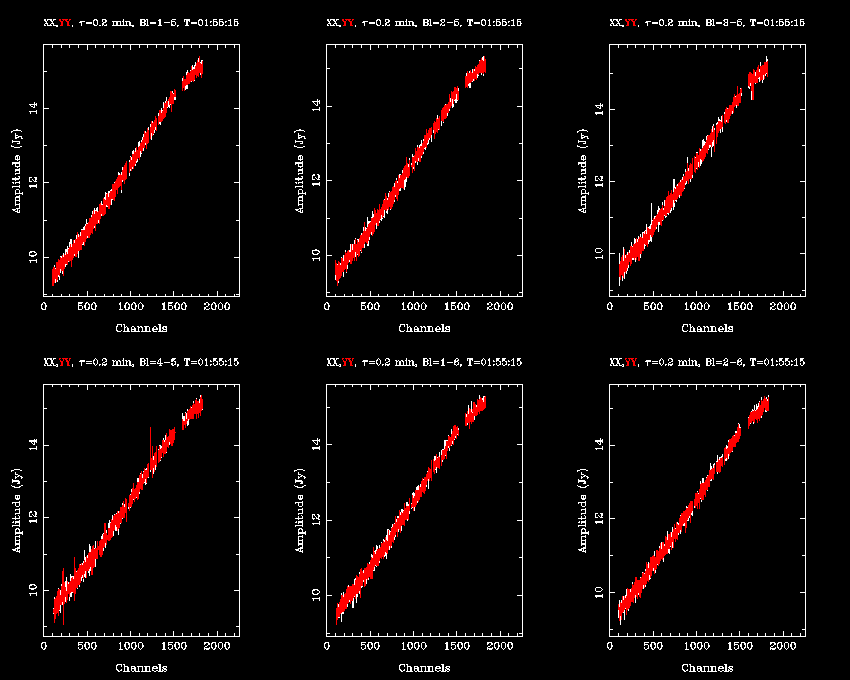

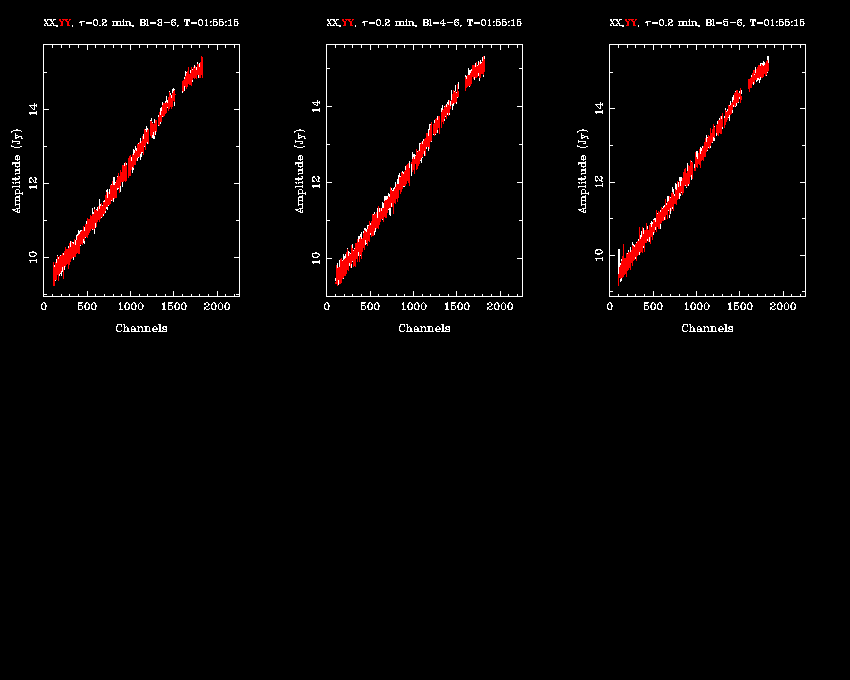

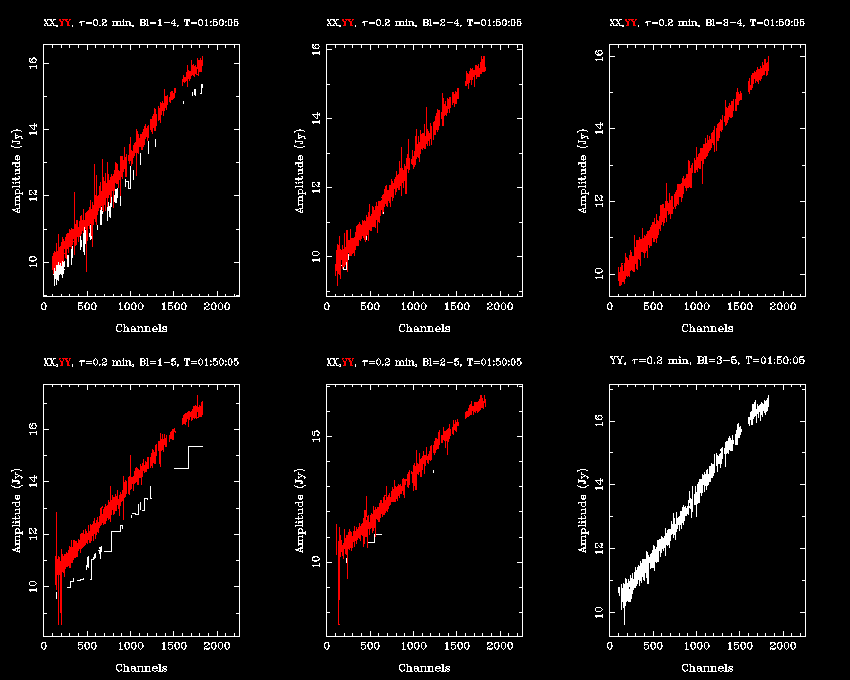

blflag: Revision 1.22, 2015/12/04 03:07:29 UTC

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100
Reading the data...
Number of points to edit: 762248
Entering interactive mode...
MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $
Selecting parallel-hand polarisations
Reading the data ...
Number correlations accepted: 1416285
Number of frequency bands/settings: 1
Number of polarisations selected: 2
Number of solution intervals: 2
Number of passband solution intervals: 1
Initialising ...
Using post-Aug94 ATCA flux scale for 1934-638.
Using known frequency variation of 1934-638
Generating initial solution estimate ...
Doing solution refinement ...
Iter= 1, Solution Error:  0.674
Iter= 2, Solution Error:  0.006
Iter= 3, Solution Error:  0.000
Saving solution ...
##########Post RFI bandpass, flux calibration##########


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'mfcal':  Correlations flagged or edge-rejected: 735165
  warnings.warn(msg)


uvplt: Revision 1.18, 2014/05/21 04:34:59 UTC

Will plot unflagged data

Applying bandpass corrections to 1934-638.2100
Applying gain corrections to 1934-638.2100


File # 1  = 1934-638.2100
1934-638.2100 2.1000 GHz
Read 1037 visibilities from all files

Baseline 1-2, plot 86819 points
Baseline 1-3, plot 88576 points
Baseline 2-3, plot 88894 points
Baseline 1-4, plot 97602 points
Baseline 2-4, plot 101018 points
Baseline 3-4, plot 92648 points
Baseline 1-5, plot 95140 points
Baseline 2-5, plot 99233 points
Baseline 3-5, plot 92462 points
Baseline 4-5, plot 93784 points
Baseline 1-6, plot 93677 points
Baseline 2-6, plot 97433 points
Baseline 3-6, plot 92940 points
Baseline 4-6, plot 97978 points
Baseline 5-6, plot 98081 points


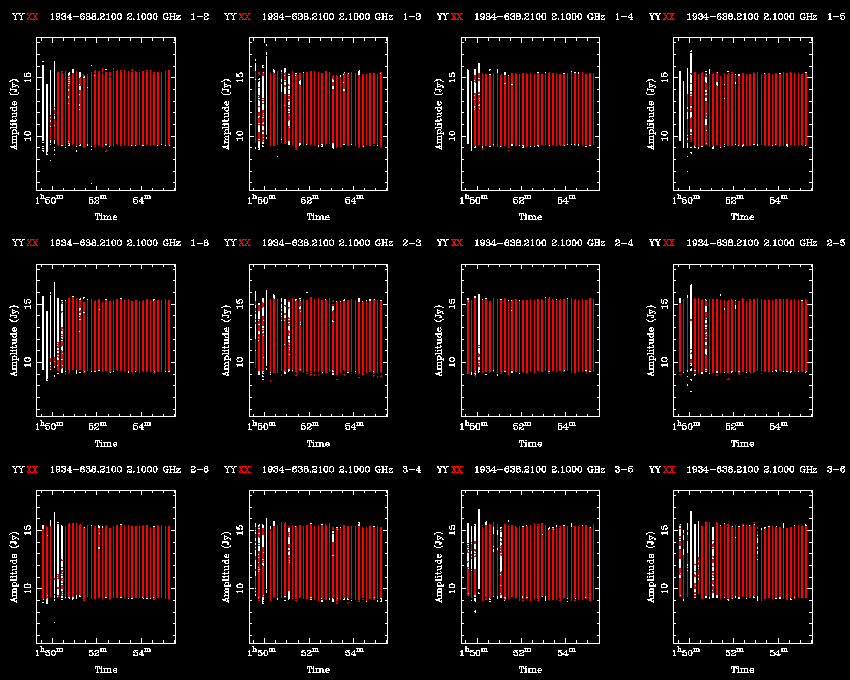

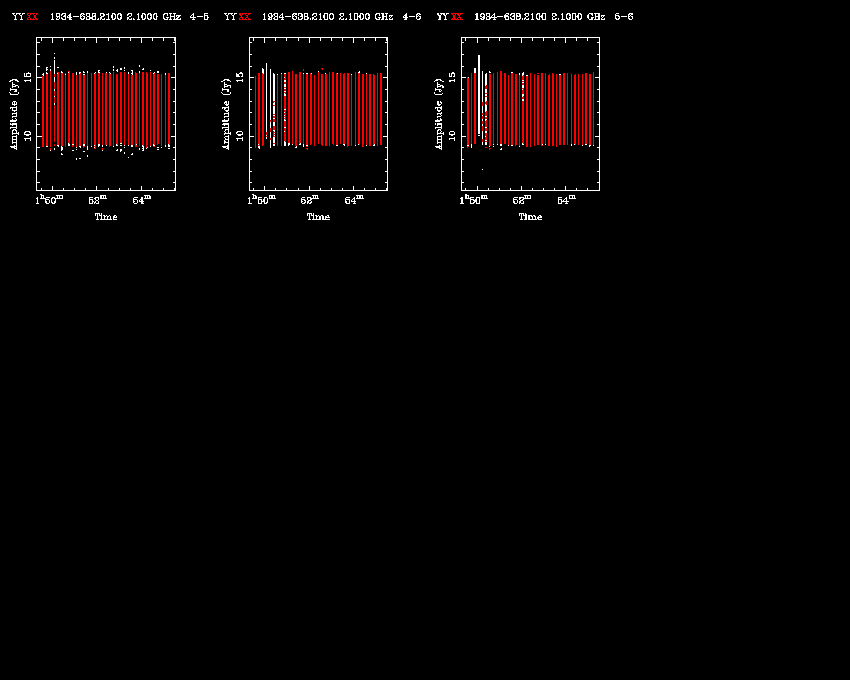

In [8]:

## RFI FLAGGING

# do this 2 or 3 times
loop = [0,1,3]

for l in loop: 

    # automatic flagging

    # loop through stokes parameters

    stokes_arr = ['xx','xy','yx','yy']

    for u in stokes_arr:
        # pgflag parameters
        vis = bandflux_cal
        stokes = str(u)+','+','.join(stokes_arr)
        command = "<b"
        device="/xs" 
        mir_output = miriad.pgflag(vis=vis,stokes=stokes,command=command,
                                    device=device)
        print(mir_output.decode("utf-8"))
        flaggingcheck_pgflag(mir_output)

    # if you want to see what it looks like after pgflag
    print('#'*10+"Post pgflag bandpass, flux calibration"+'#'*10)
    !rm *png*
    # uvspec parameters
    vis = bandflux_cal
    stokes = "xx,yy"
    axis = "chan,amp"
    #device="/xs"
    device="{0}bfpostpgflag.png/png".format(vis)
    mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                                device=device)

    plot_list = glob.glob('{0}bfpostpgflag*png*'.format(vis))
    for plot in plot_list:
        display(Image(filename=plot, format='png'))


    # flag visibilities by hand

    # blflag parameters
    vis = bandflux_cal
    device="/xs" 
    stokes = "xx,xy"
    axis = "chan,amp"
    options='nofqav,nobase'
    mir_output = miriad.blflag(vis=vis,device=device,stokes=stokes,
                               axis=axis,options=options)
    print(mir_output.decode("utf-8"))

    # mfcal parameters
    vis = bandflux_cal

    mir_output = miriad.mfcal(vis=vis)
    print(mir_output.decode("utf-8"))



    print('#'*10+"Post RFI bandpass, flux calibration"+'#'*10)
    !rm *png*
    # look at the amplitude vs time

    # uvplt
    vis = bandflux_cal
    stokes = "xx,yy"
    axis = "time,amp"
    options="nofqav"
    device="{0}bftimeamp.png/png".format(vis)

    mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                              options=options,device=device)
    print(mir_output.decode("utf-8"))

    uvplot_list = glob.glob('{0}bftimeamp*png*'.format(vis))
    for plot in uvplot_list:
        display(Image(filename=plot, format='png'))

        # if above 1 jy, can use as phase cal for the next round
        # last gpcopy (if not, go 2 back); you can tell on blflag plot



gpcal: Revision 1.22, 2016/05/01 22:31:05 UTC

Applying bandpass corrections to 1934-638.2100
Number of antennae: 6
Reading the data ...
Number of solution intervals: 35
Total visibilities read: 525
Number visibilities accepted: 512
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 12.3198,  0.0000,  0.0000,  0.0000 at   2.1682 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 10.1022,  0.0000,  0.0000,  0.0000 at   2.8107 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 11.5985,  0.0000,  0.0000,  0.0000 at   2.3653 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 13.4642,  0.0000,  0.0000,  0.0000 at   1.8622 GHz.
Using post-Aug94 ATCA flux scale for 1934-638.
Using IQUV = 14.9023,  0.0000,  0.0000,  0.0000 at   1.4026 GHz.
Iter= 1, Amplit/Phase Solution Error:   0.152
Iter= 1, Polarisation Solution Error:   0.037
Iter= 1, Overall Solution Error:        0.668
Iter= 2, Amplit/Phase Solution Error:   0.003
Iter= 2, Polarisation S

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'gpcal':  Number of flagged visibilities: 13
  warnings.warn(msg)


uvplt: Revision 1.18, 2014/05/21 04:34:59 UTC

Will plot unflagged data

Applying bandpass corrections to 1934-638.2100
Applying freq. dependent gain corrections to 1934-638.2100
Applying freq. dependent leakage correction to 1934-638.2100


File # 1  = 1934-638.2100
1934-638.2100 2.1000 GHz
Read 1024 visibilities from all files

Plot 1306550 points


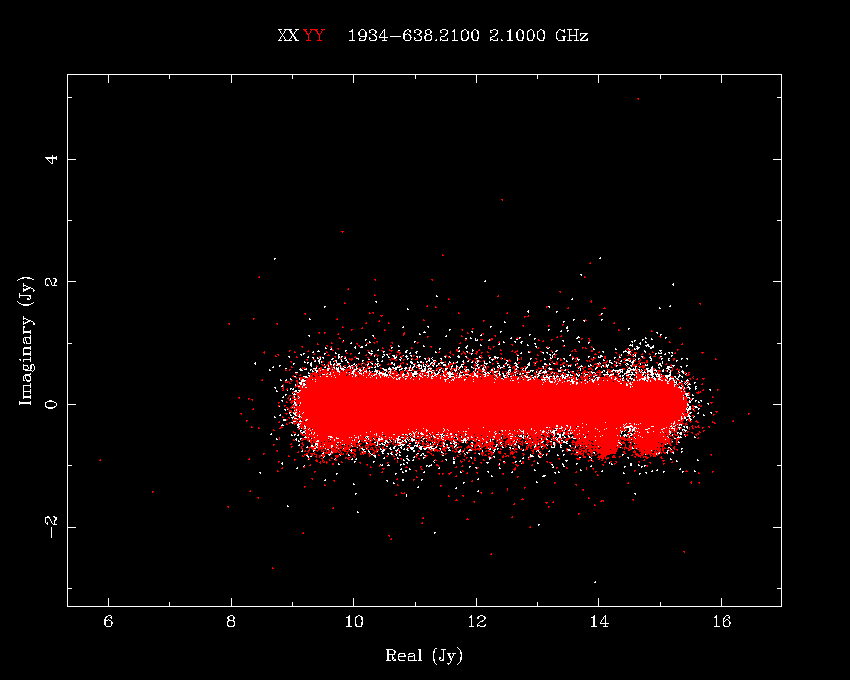

'# if you want to see what it looks like after all RFI flagging\nprint(\'#\'*10+"Post pgflag bandpass, flux calibration"+\'#\'*10)\n!rm *png*\n# uvspec parameters\nvis = bandflux_cal\nstokes = "xx,yy"\naxis = "chan,amp"\n#device="/xs"\ndevice="{0}tmp.png/png".format(vis)\nmir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,\n                          device=device)\n\nplot_list = glob.glob(\'{0}tmp*png*\'.format(vis))\nfor plot in plot_list:\n  display(Image(filename=plot, format=\'png\'))\n'

In [9]:
  
# gain calibration over time

# gpcal parameters
vis = bandflux_cal
interval="0.1"
nfbin="4"
options="xyvary"

mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options)
print(mir_output.decode("utf-8"))

    
# look at the  phase vs time
!rm *png*
# uvplt parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "real,imag"
options="nofqav,nobase,equal"
device="{0}bfrealimag.png/png".format(vis)

mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                          options=options,device=device)
print(mir_output.decode("utf-8"))

uvplot_list = glob.glob('{0}bfrealimag*png*'.format(vis))
for plot in uvplot_list:
    display(Image(filename=plot, format='png'))
    


"""# if you want to see what it looks like after all RFI flagging
print('#'*10+"Post pgflag bandpass, flux calibration"+'#'*10)
!rm *png*
# uvspec parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "chan,amp"
#device="/xs"
device="{0}tmp.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}tmp*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))
"""

# source calibration

In [234]:
# iterate over sources in the block
h=13
print(h,'/',len(sources))

source = sources[h]+suffix
print('source = '+source)

# was the last source brighter than 1 jsky? 
# can you use it to copy calibration solutions over? 
# if false, uses the one before it
bright_enough = True

# for block 1, these are the ones not brighter than 1 Jy
# 3 (mwacsj2153.5), 11 (mwacsj2352.4.2100), 14 (pks0105-122.2100)
dim = [3,11,14]
if h-1 in dim:
    bright_enough = False

13 / 14
source = pks0105-122.2100


In [235]:
sources

['pks1740-649',
 'pmnj1726-6427',
 'pks1814-637',
 'mwacsj2153.5',
 'pks2149-28',
 'pks2135-209',
 'mwacsj2157.5',
 'pks2254-367',
 '2311-452',
 'pks2333-528',
 '0022-423',
 'mwacsj2352.4',
 '0023-263',
 'pks0105-122']

In [ ]:

################### Skipping phase cal stuff in lieu of self cal l###############    



# copy over calibration from the last thing you calibrated
if h == 0:
    vis = bandflux_cal
elif bright_enough:
    vis = sources[h-1]+suffix
else:
    vis = sources[h-2]+suffix

print("vis = "+vis)    
# gain calibration over time

# gpcal parameters
# vis = bandflux_cal
interval="0.1"
nfbin="4"
options="xyvary"

mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options)
print(mir_output.decode("utf-8"))

# copy calibration tables from bandpass/flux calibrator to source to be imaged

# gpcopy parameters
#vis = bandflux_cal
out = source

mir_output = miriad.gpcopy(vis=vis,out=out)
print(mir_output.decode("utf-8"))

print('#'*10+"Pre mfcal {0} calibration".format(sources[h])+'#'*10)

# uvspec parameters
vis = source
stokes = "xx,yy"
axis = "chan,amp"
device="{0}premfcal.png/png".format(vis)
# can do devices like /xs, /png, /null, or others listed on the link:
# (http://www.atnf.csiro.au/computing/software/miriad/userguide/node25.html)
# note: you have to close xs before the cell stops hanging
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}premfcal*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))

## RFI flagging

In [ ]:
# RFI FLAGGING

# loop over stokes

stokes_arr = ['xx','xy','yx','yy']

for u in stokes_arr:
    # pgflag parameters
    vis = source
    stokes = str(u)+','+','.join(stokes_arr)
    command = "<b"
    device="/xs" 
    mir_output = miriad.pgflag(vis=vis,stokes=stokes,command=command,
                                device=device)
    print(mir_output.decode("utf-8"))
    flaggingcheck_pgflag(mir_output)
    


In [ ]:
# lets me know if I'm not paying attention

applescript = """
display dialog "Check Jy!" ¬
with title "Juypter notebook" ¬
with icon caution ¬
buttons {"OK"}
"""
subprocess.call("osascript -e '{0}'".format(applescript), shell=True)



# blflag parameters
vis = source
device="/xs" 
stokes = "xx,yy"
axis = "chan,amp"
options="nofqav,nobase"
mir_output = miriad.blflag(vis=vis,device=device,stokes=stokes,
                           axis=axis,options=options)
print(mir_output.decode("utf-8"))

# if you want to see what it looks like after blflag
print('#'*10+"Post blflag source"+'#'*10)
!rm *png*
# uvspec parameters
vis = source
stokes = "xx,yy"
axis = "chan,amp"
#device="/xs"
device="{0}postblflag.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}postblflag*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))

# done RFI flagging the source
# now apply the calibration solutions

In [ ]:
# gpcal parameters
vis =  source
interval="0.1"
nfbin="4"
options="xyvary"

mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options)
print(mir_output.decode("utf-8"))

# reestablish flux

# gpboot parameters
vis = source
cal = bandflux_cal

mir_output = miriad.gpboot(vis=vis,cal=cal)
print(mir_output.decode("utf-8"))

## uvmeas

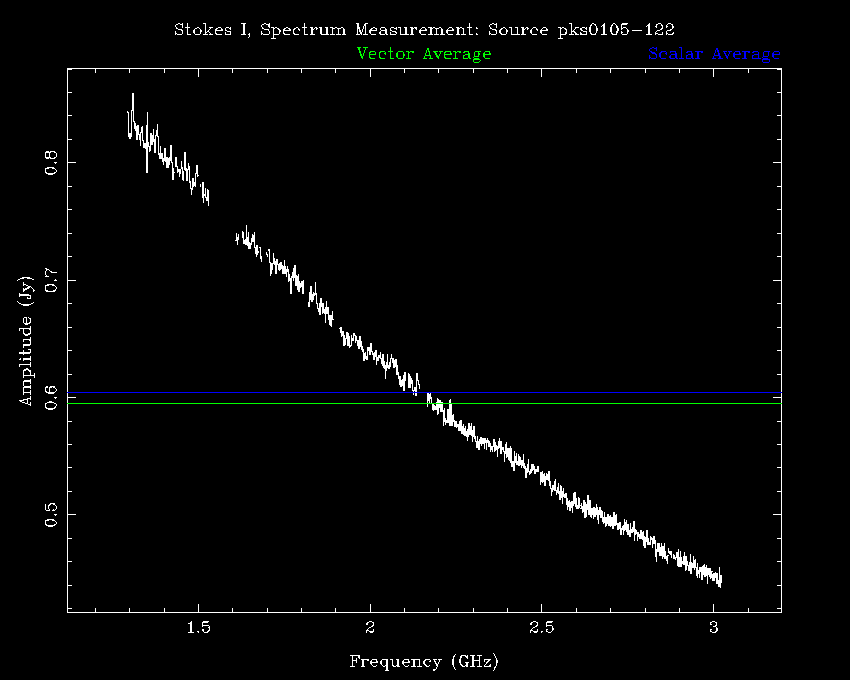

In [226]:
# uvfmeas!
vis= source
stokes ='i'
line = 'channel,2048,1,1,1'
log = 'uvfmeaslog{0}MHz_{1}'.format(line.split(',')[-2],source)
device="{0}.png/png".format(log)

mir_output = miriad.uvfmeas(vis=vis,stokes=stokes,device=device,line=line,log=log)
#print(mir_output.decode("utf-8"))


plot_list = glob.glob("{0}.png".format(log))
for plot in plot_list:
    display(Image(filename=plot, format='png'))


# Imaging

In [227]:
# average/smoothe antenna gains


# gpaver parameters
vis = source
interval = "2"

mir_output = miriad.gpaver(vis=vis,interval=interval)
print(mir_output.decode("utf-8"))


# uvaver parameters
vis = source
temp = vis.split('.')
uvav_source = temp[0]+'.uvaver.'+temp[1]
out= uvav_source 

mir_output = miriad.uvaver(vis=vis,out=out)
print(mir_output.decode("utf-8"))

# split into smaller frequency chunks

# uvsplit parameters
vis = uvav_source 
maxwidth ="0.512"

# how do I predict these file names? 
splitname = source +'.*'
!rm -r $splitname

mir_output = miriad.uvsplit(vis=vis,maxwidth=maxwidth)
print(mir_output.decode("utf-8"))

freq_chunks = names_uvsplit(mir_output)

gpaver: Revision 1.4, 2015/10/29 01:31:20 UTC


MiriadError: Error opening pks0105-122.uvaver.2100, in UVOPEN(new): File exists


In [ ]:
"""# delete imap & beam if you've cleaned too much and want to start over
rmtext = freq_chunks[i]+".imap" +' '+ freq_chunks[i]+".ibeam"
!rm -r $rmtext"""

## Initial Imaging

In [ ]:
# Imaging

# select the first freq chunk
freq_chunk = freq_chunks[0]

# do I need to image each frequency chunk? 
#for freq_chunk in freq_chunks:
#    print(freq_chunk)

# loop twice so you can use self-cal
loop = [0,1]

for l in loop:
    
    if l == 1:
        ##########################################################################
        # self calibration
        print('#'*10+"Selfcal"+"#"*10)
        # selfcal parameters
        vis = freq_chunk
        model=vis+".imodel"
        clip= "0.013"
        interval=1
        options="phase,mfs"

        mir_output = miriad.selfcal(vis=vis,model=model,clip=clip,interval=interval,
                                   options=options)
        print(mir_output.decode("utf-8"))
        ###########################################################################


    # invert parameters
    vis = freq_chunk
    map_ = freq_chunk+".imap"
    beam = freq_chunk+".ibeam"
    robust = "0.5"
    stokes = "i"
    options="mfs,double"

    # delete the files if they already exist
    !rm -r $map_
    !rm -r $beam

    mir_output = miriad.invert(vis=vis,map=map_,beam=beam,robust=robust,
                               stokes=stokes, options=options)
    print(mir_output.decode("utf-8"))


    invert_rms = grabrms_invert(mir_output)

    # look at the dirty map
    

    # cgdisp parameters
    in_ = freq_chunk+".imap"
    beam = freq_chunk+".ibeam"
    type_="p"
    device="{0}.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                               options=options)
    print(mir_output.decode("utf-8"))
    print('#'*10+"Dirty Map after inversion"+"#"*10)
    display(Image(filename='{0}.png'.format(in_)))

    # zoom into the center
    region="quarter"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,region=region,device=device,laptyp=laptyp,
                               options=options)
    print(mir_output.decode("utf-8"))
    display(Image(filename='{0}.png'.format(in_)))



    # clean parameters
    map_ = freq_chunk+".imap"
    beam = freq_chunk+".ibeam"
    out = freq_chunk+".imodel"
    options="negstop,positive"
    cutoff=invert_rms
    niters="1000"

    # remove model if it already exists
    !rm -r $out

    mir_output = miriad.clean(map=map_,beam=beam,out=out,cutoff=cutoff,niters=niters,
                               options=options)
    print(mir_output.decode("utf-8"))


    rmscheck_clean(mir_output) 

    # I should go back and make these plot better

    # restore the image

    # restor parameters
    model = freq_chunk+".imodel"
    beam = freq_chunk+".ibeam"
    map_ = freq_chunk+".imap"
    out = freq_chunk+".irestor"
    mode=""#"residual"

    # remove restored image if it already exists
    !rm -r $out

    mir_output = miriad.restor(model=model,map=map_,beam=beam,out=out, mode=mode)
    print(mir_output.decode("utf-8"))

    # look at the cleaned image

    

    # cgdisp parameters
    in_ = freq_chunk+".irestor"
    beam = freq_chunk+".ibeam"
    type_="p"
    device="{0}.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"
    range_="0,0,log"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                               options=options,range=range_)
    print(mir_output.decode("utf-8"))
    print('#'*10+"Cleaned image"+"#"*10)
    im_to_save = '{0}.png'.format(in_)
    display(Image(filename=im_to_save))

    # zoom into the center
    region="quarter"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,region=region,device=device,laptyp=laptyp,
                               options=options,range=range_)
    print(mir_output.decode("utf-8"))
    display(Image(filename='{0}.png'.format(in_)))
    !cp $im_to_save $notebook_dir

## Additional Cleaning

In [ ]:
"""## even more cleaning if you need it

# clean parameters
map_ = freq_chunk+".imap"
beam = freq_chunk+".ibeam"
out = freq_chunk+".imodel"
options="negstop,positive"
cutoff=invert_rms
niters="1000"

print('cutoff='+cutoff)
# remove model if it already exists
!rm -r $out

mir_output = miriad.clean(map=map_,beam=beam,out=out,cutoff=cutoff,niters=niters,
                           options=options)
print(mir_output.decode("utf-8"))


rmscheck_clean(mir_output) 

# I should go back and make these plot better

# restore the image

# restor parameters
model = freq_chunk+".imodel"
beam = freq_chunk+".ibeam"
map_ = freq_chunk+".imap"
out = freq_chunk+".irestor"
mode=""#"residual"

# remove restored image if it already exists
!rm -r $out

mir_output = miriad.restor(model=model,map=map_,beam=beam,out=out, mode=mode)
print(mir_output.decode("utf-8"))

# look at the cleaned image

# remove png if it already exists
! rm *png*

# cgdisp parameters
in_ = freq_chunk+".irestor"
beam = freq_chunk+".ibeam"
type_="p"
device="{0}.png/png".format(in_)
laptyp = "/hms,dms"
options="wedge"
range_="0,0,log"

mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                           options=options,range=range_)
print(mir_output.decode("utf-8"))
print('#'*10+"Cleaned image"+"#"*10)
display(Image(filename='{0}.png'.format(in_)))

# zoom into the center
region="quarter"

mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,region=region,device=device,laptyp=laptyp,
                           options=options,range=range_)
print(mir_output.decode("utf-8"))
display(Image(filename='{0}.png'.format(in_)))"""

## Imfit and imhist

In [ ]:
# measure the flux density of the source

# imfit parameters
in_ = freq_chunk+".irestor"
region="quarter"
object_="point"
spar="1,0,0"
out=freq_chunk+".iresidual"
options="residual"

# remove residual image if it already exists
!rm -r $out

mir_output = miriad.imfit(in_=in_,region=region,object=object_,spar=spar, out=out,
                           options=options)
print(mir_output.decode("utf-8"))


peakflux= grabpeak_imfit(mir_output)



# look at the cleaned image after the central source is subtracted by imfit



# cgdisp parameters
in_ = freq_chunk+".iresidual"
beam = freq_chunk+".ibeam"
type_="p"
device="{0}.png/png".format(in_)
laptyp = "/hms,dms"
options="wedge"
range_="0,0,log"

mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                           options=options,range=range_)
print(mir_output.decode("utf-8"))
print('#'*10+"Cleaned image - central source"+"#"*10)
display(Image(filename='{0}.png'.format(in_)))

# zoom into the center
region="quarter"

mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,region=region,device=device,laptyp=laptyp,
                           options=options,range=range_)
print(mir_output.decode("utf-8"))
display(Image(filename='{0}.png'.format(in_)))


# estimate the dynamic range of the image

# imhist parameters
in_ = freq_chunk+".iresidual"
region="quarter"
device="imhist_{0}.png/png".format(in_)
options="nbin,100"

mir_output = miriad.imhist(in_=in_,region=region, device=device,
                           options=options)
print(mir_output.decode("utf-8"))
print('#'*10+"imhist"+"#"*10)
display(Image(filename='imhist_{0}.png'.format(in_)))


rms_imhist= grabrms_imhist(mir_output)

dynamic_range = float(peakflux[0])/float(rms_imhist)
print('dynamic range: {0}'.format(round(dynamic_range)))

In [ ]:
# above 300 is good for dynamic range

In [ ]:
# save notebook

%notebook -e mirpy_reducescript.ipynb

In [ ]:
# save as HTML

filename = notebook_dir+'/mirpy_reducescript.ipynb'
fn = export_to_html(filename,source)
print("File exported as:\n\t{0}".format(fn))

# The End!

In [ ]:
# lets me know if I'm not paying attention

applescript = """
display dialog "Mirpy script finished!" ¬
with title "Juypter notebook" ¬
with icon caution ¬
buttons {"OK"}
"""
subprocess.call("osascript -e '{0}'".format(applescript), shell=True)